# Initial Exploration of Van der Waals Constants Dataset

In [1]:
!pip install rdkit --quiet
!pip install pubchempy --quiet
!pip install --upgrade mol2vec --quiet
!pip install optuna --quiet
!pip install wandb --quiet
!pip install joblib --quiet

In [2]:
!wget https://github.com/samoturk/mol2vec/raw/master/examples/models/model_300dim.pkl

--2024-11-30 07:25:12--  https://github.com/samoturk/mol2vec/raw/master/examples/models/model_300dim.pkl
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/samoturk/mol2vec/master/examples/models/model_300dim.pkl [following]
--2024-11-30 07:25:13--  https://raw.githubusercontent.com/samoturk/mol2vec/master/examples/models/model_300dim.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76786055 (73M) [application/octet-stream]
Saving to: ‘model_300dim.pkl.4’

model_300dim.pkl.4  100%[===================>]  73.23M   233MB/s    in 0.3s    

2024-11-30 07:25:13 (233 MB/s) - ‘model_300dim.pkl.4’ sa

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
import pubchempy as pcp
from urllib.request import urlopen
from urllib.parse import quote
import time
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
url = 'https://huggingface.co/datasets/BlakeMilstea/Van_Der_Waals_Constants/raw/main/Van_Der_Waals_Constants%20-%20Sheet1%20(1).csv'
drive_path = '/content/drive/MyDrive/EOS_Predictor/Data'

Our dataset is a collection of atomic signatures and their corresponding a and b values.

In [6]:
class DataPreprocessor_Speed:
    def __init__(self, url):
        """
        Initializes the DataPreprocessor with a URL to the dataset.

        Args:
            url (str): The URL to the dataset CSV.
        """
        self.url = url
        self.data = None

    def load_data(self):
        """
        Loads the dataset from the specified URL and sets initial column names.
        """
        self.data = pd.read_csv(self.url)
        self.data.columns = ['sci_name', 'name', 'a', 'b']
        return self.data.head()

    @staticmethod
    def name_to_SMILES_individual(name):
        """
        Retrieves the SMILES string for a molecule name using individual PubChem requests.

        Args:
            name (str): The name of the molecule.

        Returns:
            str: The SMILES string for the molecule, or np.nan if not found.
        """
        try:
            compounds = pcp.get_compounds(name, 'name')
            if compounds:
                return compounds[0].canonical_smiles
            else:
                return np.nan
        except Exception:
            return np.nan

    @staticmethod
    def names_to_cids(names):
        """
        Retrieves PubChem CIDs for a list of molecule names.

        Args:
            names (list of str): List of molecule names.

        Returns:
            dict: A dictionary where keys are molecule names and values are PubChem CIDs.
        """
        name_to_cid = {}
        for name in names:
            try:
                compounds = pcp.get_compounds(name, 'name')
                if compounds:
                    name_to_cid[name] = compounds[0].cid
                else:
                    name_to_cid[name] = np.nan
            except Exception:
                name_to_cid[name] = np.nan
        return name_to_cid

    @staticmethod
    def cids_to_smiles(cids):
        """
        Retrieves the SMILES strings for a list of PubChem CIDs in bulk.

        Args:
            cids (list of int): List of PubChem CIDs.

        Returns:
            dict: A dictionary where keys are CIDs and values are SMILES strings.
        """
        cid_to_smiles = {}
        try:
            # Use PubChem's REST API to get SMILES for multiple CIDs
            cid_list = ",".join(map(str, cids))
            url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid_list}/property/CanonicalSMILES/JSON"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()

            # Extract SMILES information from the response
            for item in data['PropertyTable']['Properties']:
                cid_to_smiles[item['CID']] = item['CanonicalSMILES']
        except Exception:
            # If there's an error, mark all as NaN
            for cid in cids:
                cid_to_smiles[cid] = np.nan
        return cid_to_smiles

    def add_SMILES_column_individual(self):
        """
        Adds a column to the dataset with SMILES strings using individual requests.
        """
        smiles_names = []
        for name in self.data['name']:
            smiles_names.append(self.name_to_SMILES_individual(name))
        self.data['smile'] = smiles_names
        # Remove rows with missing SMILES strings
        self.data = self.data.dropna().reset_index(drop=True)
        return self.data.head()

    def add_SMILES_column_bulk(self):
        """
        Adds a column to the dataset with SMILES strings using PubChem bulk requests.
        """
        # Step 1: Retrieve CIDs for all molecule names
        name_to_cid = self.names_to_cids(self.data['name'])
        self.data['cid'] = self.data['name'].map(name_to_cid)

        # Remove rows where no CID was found
        self.data = self.data.dropna(subset=['cid']).reset_index(drop=True)
        cids = self.data['cid'].astype(int).tolist()

        # Step 2: Retrieve SMILES for all found CIDs
        cid_to_smiles = self.cids_to_smiles(cids)
        self.data['smile'] = self.data['cid'].map(cid_to_smiles)

        # Remove rows with missing SMILES strings
        self.data = self.data.dropna(subset=['smile']).reset_index(drop=True)
        return self.data.head()

    def compare_speed(self):
        """
        Compares the speed of individual vs. bulk PubChem requests.
        """
        # Load the dataset
        self.load_data()

        # Measure time for individual requests
        start_time = time.time()
        self.add_SMILES_column_individual()
        individual_time = time.time() - start_time
        print(f"Time taken for individual requests: {individual_time:.2f} seconds")

        # Reload data for a fair comparison
        self.load_data()

        # Measure time for bulk requests
        start_time = time.time()
        self.add_SMILES_column_bulk()
        bulk_time = time.time() - start_time
        print(f"Time taken for bulk requests: {bulk_time:.2f} seconds")


In [ ]:
# Initialize the preprocessor with the dataset URL
preprocessor = DataPreprocessor_Speed('https://huggingface.co/datasets/BlakeMilstea/Van_Der_Waals_Constants/raw/main/Van_Der_Waals_Constants%20-%20Sheet1%20(1).csv')

# Compare the speed of individual and bulk requests
preprocessor.compare_speed()

Time taken for individual requests: 173.10 seconds
Time taken for bulk requests: 178.76 seconds


We will use bulk requests for scalability but it does not seem to effect runtime much in out case.


In [7]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import requests
import pubchempy as pcp

class DataPreprocessor:
    def __init__(self, url, drive_path=''):
        """
        Initializes the DataPreprocessor with a URL to the dataset and a Google Drive path.

        Args:
            url (str): The URL to the dataset CSV.
            drive_path (str): The path to the mounted Google Drive folder.
        """
        self.url = url
        self.drive_path = drive_path
        self.data = None
        self.preprocessed_file_path = os.path.join(self.drive_path, 'preprocessed_data.csv')
        self.embeddings_file_path = os.path.join(self.drive_path, 'embeddings.npy')
        self.targets_file_path = os.path.join(self.drive_path, 'targets.npy')

        # Initialize RDKitEmbeddings instance
        self.embedding_generator = RDKitEmbeddings()

        self.preprocess()

    def load_data(self):
        """
        Loads the dataset from the specified URL and sets initial column names.
        """
        self.data = pd.read_csv(self.url)
        self.data.columns = ['sci_name', 'name', 'a', 'b']
        return self.data.head()

    def add_molecular_properties(self):
        """
        Adds various molecular properties and atom count to the dataset.
        """
        self.data['properties'] = self.data['smile'].apply(self.calculate_molecular_properties)
        properties_df = self.data['properties'].apply(pd.Series)
        self.data = pd.concat([self.data, properties_df], axis=1)
        self.data.drop(columns=['properties'], inplace=True)
        return self.data.head()

    def calculate_molecular_properties(self, smiles):
        """
        Calculates various molecular properties using RDKit's descriptors.
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {
                'Molecular Weight': np.nan,
                'LogP': np.nan,
                'TPSA': np.nan,
                'Rotatable Bonds': np.nan,
                'H Bond Donors': np.nan,
                'H Bond Acceptors': np.nan,
                'Aromatic Rings': np.nan,
                'Num Rings': np.nan,
                'Atom Count': np.nan
            }
        return {
            'Molecular Weight': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'Rotatable Bonds': Descriptors.NumRotatableBonds(mol),
            'H Bond Donors': Descriptors.NumHDonors(mol),
            'H Bond Acceptors': Descriptors.NumHAcceptors(mol),
            'Aromatic Rings': Descriptors.NumAromaticRings(mol),
            'Num Rings': len(mol.GetRingInfo().AtomRings()),
            'Atom Count': len(mol.GetAtoms())
        }

    def clean_data(self):
        """
        Cleans the dataset by removing duplicates, handling missing values, and ensuring valid molecular properties.
        """
        self.data = self.data.drop_duplicates()
        self.data = self.data.dropna(subset=['name', 'a', 'b'])
        self.data['a'] = pd.to_numeric(self.data['a'], errors='coerce')
        self.data['b'] = pd.to_numeric(self.data['b'], errors='coerce')
        self.data = self.data.dropna(subset=['a', 'b'])
        self.data = self.data[(self.data['a'] > 0) & (self.data['b'] > 0)]
        self.data['name'] = self.data['name'].astype(str)
        self.data = self.data.dropna(subset=[
            'smile', 'Molecular Weight', 'LogP', 'TPSA',
            'Rotatable Bonds', 'H Bond Donors', 'H Bond Acceptors',
            'Aromatic Rings', 'Num Rings', 'Atom Count'
        ])
        return self.data.head()

    def add_SMILES_column_bulk(self):
        """
        Adds a column to the dataset with SMILES strings using PubChem bulk requests.
        """
        name_to_cid = self.names_to_cids(self.data['name'])
        self.data['cid'] = self.data['name'].map(name_to_cid)
        self.data = self.data.dropna(subset=['cid']).reset_index(drop=True)
        cids = self.data['cid'].astype(int).tolist()
        cid_to_smiles = self.cids_to_smiles(cids)
        self.data['smile'] = self.data['cid'].map(cid_to_smiles)
        self.data = self.data.dropna(subset=['smile']).reset_index(drop=True)
        return self.data.head()

    @staticmethod
    def names_to_cids(names):
        """
        Retrieves PubChem CIDs for a list of molecule names.
        """
        name_to_cid = {}
        for name in names:
            try:
                compounds = pcp.get_compounds(name, 'name')
                if compounds:
                    name_to_cid[name] = compounds[0].cid
                else:
                    name_to_cid[name] = np.nan
            except Exception:
                name_to_cid[name] = np.nan
        return name_to_cid

    @staticmethod
    def cids_to_smiles(cids):
        """
        Retrieves the SMILES strings for a list of PubChem CIDs in bulk.
        """
        cid_to_smiles = {}
        try:
            cid_list = ",".join(map(str, cids))
            url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid_list}/property/CanonicalSMILES/JSON"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            for item in data['PropertyTable']['Properties']:
                cid_to_smiles[item['CID']] = item['CanonicalSMILES']
        except Exception:
            for cid in cids:
                cid_to_smiles[cid] = np.nan
        return cid_to_smiles

    def create_embeddings_and_targets(self):
      """
      Generates RDKit embeddings (fingerprints) and raw targets for the dataset.
      """
      if 'smile' not in self.data.columns:
          raise ValueError("The dataset must contain a 'smile' column to create embeddings.")
      if 'a' not in self.data.columns or 'b' not in self.data.columns:
          raise ValueError("The dataset must contain 'a' and 'b' columns to create targets.")

      smiles_list = self.data['smile'].tolist()
      embeddings = self.embedding_generator.smiles_to_fingerprint(smiles_list)
      valid_embeddings = []
      valid_targets = []

      for idx, emb in enumerate(embeddings):
          if emb is not None:
              # Ensure raw targets are used directly from the dataset
              raw_a = self.data.iloc[idx]['a']
              raw_b = self.data.iloc[idx]['b']

              valid_embeddings.append(emb)
              valid_targets.append([raw_a, raw_b])

      embeddings = np.array(valid_embeddings, dtype=np.float32)
      targets = np.array(valid_targets, dtype=np.float32)

      # Save the raw embeddings and targets
      np.save(self.embeddings_file_path, embeddings)
      np.save(self.targets_file_path, targets)

      # Debugging: Check saved targets
      print("Saved targets (first 5 rows):", targets[:5])

      return embeddings, targets


    def load_embeddings_and_targets(self):
        """
        Loads pre-saved embeddings and targets if available.
        """
        if os.path.exists(self.embeddings_file_path) and os.path.exists(self.targets_file_path):
            embeddings = np.load(self.embeddings_file_path)
            targets = np.load(self.targets_file_path)
            print(f'Loaded Embeddings')
            return embeddings, targets
        return self.create_embeddings_and_targets()

    def save_preprocessed_data(self):
        """
        Saves the preprocessed data to a CSV file in the Google Drive directory.
        """
        if not os.path.exists(self.drive_path):
            os.makedirs(self.drive_path)
        self.data.to_csv(self.preprocessed_file_path, index=False)

    def load_preprocessed_data(self):
        """
        Loads the preprocessed data from the Google Drive directory if it exists.
        """
        if os.path.exists(self.preprocessed_file_path):
            self.data = pd.read_csv(self.preprocessed_file_path)
            return self.data
        return None

    def preprocess(self):
        """
        Full preprocessing pipeline: Load data, add SMILES, and save if not already preprocessed.
        """
        preprocessed_data = self.load_preprocessed_data()
        if preprocessed_data is not None:
            self.data = preprocessed_data
            return preprocessed_data
        self.load_data()
        self.add_SMILES_column_bulk()
        self.add_molecular_properties()
        self.clean_data()
        self.save_preprocessed_data()
        return self.data


In [8]:
class DataVisualizer:
    def __init__(self, data):
        """
        Initializes the DataVisualizer with the dataset.

        Args:
            data (pd.DataFrame): The dataset to visualize.
        """
        self.data = data
        self.scale_data()

    def correlation_heatmap(self):
        """
        Plots a heatmap showing the correlation matrix of the numerical variables in the dataset.
        """
        # Select only numeric columns for correlation analysis
        numeric_data = self.data.select_dtypes(include=['number'])
        correlation_matrix = numeric_data.corr()

        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap')
        plt.show()

    def pairplot(self, correlation_threshold=0.7):
      """
      Plots a pairplot (scatterplot matrix) to show relationships between all numerical variables,
      but filters out plots that do not have a meaningful relationship (based on correlation threshold).

      Args:
          correlation_threshold (float): The minimum correlation absolute value to display the plot.
      """
      # Select only numeric columns for pairplot
      numeric_data = self.data.select_dtypes(include=['number'])

      # Calculate correlation matrix
      correlation_matrix = numeric_data.corr()

      # Identify columns to keep (those with at least one correlation above the threshold)
      relevant_columns = set()

      # Loop through the correlation matrix and add columns with meaningful correlations
      for col in correlation_matrix.columns:
          for row in correlation_matrix.index:
              if abs(correlation_matrix.loc[row, col]) >= correlation_threshold:
                  relevant_columns.add(col)
                  relevant_columns.add(row)

      # Convert set to list before filtering the DataFrame
      relevant_columns = list(relevant_columns)

      # Filter the numeric_data to only include the relevant columns
      filtered_data = numeric_data[relevant_columns]

      # Plot pairplot only for selected columns
      sns.pairplot(filtered_data)
      plt.suptitle('Pairplot of Relevant Numerical Variables', y=1.02)
      plt.show()

    def scale_data(self):
        """
        Scales the numeric columns to have a mean of 0 and a standard deviation of 1.
        """
        # Select only numeric columns for scaling
        numeric_data = self.data.select_dtypes(include=['number'])
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(numeric_data)
        scaled_df = pd.DataFrame(scaled_data, columns=numeric_data.columns)
        self.data = pd.concat([self.data.select_dtypes(exclude=['number']), scaled_df], axis=1)
        return scaled_df

    def boxplot(self):
      """
      Plots a boxplot for the numerical variables to visualize the distribution and potential outliers.
      Excludes the 'cid' column from the plot.
      """
      # Exclude the 'cid' column from the numerical columns
      numerical_columns = [col for col in self.data.select_dtypes(include='number').columns if col != 'cid']

      plt.figure(figsize=(10, 6))
      sns.boxplot(data=self.data[numerical_columns])
      plt.title('Boxplot of Variables (Excluding CID)')
      plt.show()

    def violin_plot(self, x, y):
        """
        Plots a violin plot to show the distribution of data across different categories.

        Args:
            x (str): The column name of the categorical variable to be plotted on the x-axis.
            y (str): The column name of the numerical variable to be plotted on the y-axis.
        """
        if x not in self.data.columns or y not in self.data.columns:
            print(f"Error: Columns '{x}' or '{y}' do not exist in the dataset.")
            return
        plt.figure(figsize=(10, 6))
        sns.violinplot(x=x, y=y, data=self.data)
        plt.title(f'Violin Plot: {x} vs {y}')
        plt.show()

    def violin_plot_full(self):
      """
      Plots a violin plot for the numerical variables to visualize the distribution and density of the data.
      Excludes the 'cid' column from the plot.
      """
      # Scale the data first
      self.scale_data()

      # Exclude the 'cid' column from the numerical columns
      numerical_columns = [col for col in self.data.select_dtypes(include='number').columns if col != 'cid']

      plt.figure(figsize=(12, 8))
      sns.violinplot(data=self.data[numerical_columns], inner="quart")
      plt.title('Violin Plot of Variables (Excluding CID)')
      plt.show()


    def regression_plot(self, x, y):
        """
        Plots a regression plot to visualize the linear relationship between two numerical variables.

        Args:
            x (str): The column name of the variable to be plotted on the x-axis.
            y (str): The column name of the variable to be plotted on the y-axis.
        """
        if x not in self.data.columns or y not in self.data.columns:
            print(f"Error: Columns '{x}' or '{y}' do not exist in the dataset.")
            return
        sns.regplot(x=x, y=y, data=self.data, scatter_kws={'s': 10, 'alpha': 0.7}, line_kws={'color': 'red'})
        plt.title(f'Regression Plot: {x} vs {y}')
        plt.show()

    def scatter_plot(self, x, y):
        """
        Plots a simple scatter plot between two numerical variables.

        Args:
            x (str): The column name of the variable to be plotted on the x-axis.
            y (str): The column name of the variable to be plotted on the y-axis.
        """
        if x not in self.data.columns or y not in self.data.columns:
            print(f"Error: Columns '{x}' or '{y}' do not exist in the dataset.")
            return
        plt.figure(figsize=(10, 6))
        plt.scatter(self.data[x], self.data[y], c='blue', alpha=0.6)
        plt.title(f'Scatter Plot: {x} vs {y}')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.grid(True)
        plt.show()

    def facet_grid(self, col, row=None):
      """
      Creates a facet grid plot to visualize relationships across multiple facets of the dataset.

      Args:
          col (str): The column name to be used for the column facets.
          row (str, optional): The column name to be used for the row facets.
      """
      # Check if the provided columns exist in the data
      if col not in self.data.columns:
          print(f"Error: Column '{col}' does not exist in the dataset.")
          return
      if row and row not in self.data.columns:
          print(f"Error: Column '{row}' does not exist in the dataset.")
          return

      # Create the FacetGrid
      g = sns.FacetGrid(self.data, col=col, row=row, margin_titles=True)

      # Map a scatterplot (you could also add other types of plots here)
      g.map(sns.scatterplot, 'a', 'b')

      # Set labels and titles
      g.set_axis_labels('a', 'b')
      g.set_titles("{col_name} | {row_name}")

      # Add a title for the whole grid
      g.fig.suptitle('Facet Grid: Relationships between a and b', size=16)

      # Adjust layout
      plt.subplots_adjust(top=0.9)  # Adjust the title to avoid overlap with plots

      plt.show()


In [ ]:

# Initialize the preprocessor with the dataset URL and Google Drive path
preprocessor = DataPreprocessor(url, drive_path)
data = preprocessor.data

# Display the final preprocessed data
print(preprocessor.data.head())

# Assuming 'preprocessed_data' is the cleaned dataset:
visualizer = DataVisualizer(data)

# Generate a correlation heatmap for scaled numeric variables
visualizer.correlation_heatmap()  # You can call this method without any changes, as it handles the correlation matrix.

# Generate pairplot for scaled data
visualizer.pairplot()

# Generate a boxplot for scaled data
visualizer.boxplot()

# Generate a violin plot (after scaling)
visualizer.violin_plot('a', 'Atom Count')
visualizer.violin_plot_full()

# Generate a scatter plot and regression plot between two variables (after scaling)
visualizer.scatter_plot('a', 'Atom Count')
visualizer.regression_plot('a', 'Atom Count')

# Generate a FacetGrid (after scaling)
visualizer.facet_grid(col='Atom Count')


# Delete the data
# preprocessor.delete_preprocessed_data()

NameError: name 'RDKitEmbeddings' is not defined

In [9]:
class EOS_Predictor_Pipeline:
    def __init__(self, data):
        self.data = data
        self.model_lr = LinearRegression()
        self.model_rf = RandomForestRegressor(random_state=42)
        self.model_xgb_mse = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # MSE loss
        self.model_xgb_pseudo = xgb.XGBRegressor(objective='reg:pseudohubererror', random_state=42)  # Pseudo-Huber loss
        self.scaler = StandardScaler()

    def split_data(self, test_size=0.2, random_state=42):
        """
        Splits the data into training and test sets.
        """
        numeric_data = self.data.select_dtypes(include=['number'])

        # Features (X) are all columns except for 'a' and 'b'
        X = numeric_data.drop(columns=['a', 'b'])

        # Target (y) is 'a' and 'b'
        y = self.data[['a', 'b']]

        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Fit the scaler on the training data and transform both training and test data
        self.X_train_scaled = self.scaler.fit_transform(X_train)
        self.X_test_scaled = self.scaler.transform(X_test)

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        print(f"Training set size: {X_train.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}")

    def train_model(self, model_type='lr', target_weights=None):
        """
        Trains the specified model on the scaled training set.
        """
        if model_type == 'lr':
            self.model = self.model_lr
        elif model_type == 'rf':
            self.model = self.model_rf
        elif model_type == 'xgb_mse':
            self.model = self.model_xgb_mse  # Use the correct XGBoost model
        elif model_type == 'xgb_pseudo':
            self.model = self.model_xgb_pseudo  # Use the correct XGBoost model
        else:
            print("Invalid model type. Choose 'lr', 'rf', 'xgb_mse', or 'xgb_pseudo'.")
            return

        if model_type in ['xgb_mse', 'xgb_pseudo'] and target_weights is not None:
            self.model.fit(self.X_train_scaled, self.y_train, sample_weight=target_weights)
        else:
            self.model.fit(self.X_train_scaled, self.y_train)

        print(f"{model_type} model trained successfully.")

    def cross_validate(self, model_type='lr', cv=5, target_weights=None):
        """
        Performs cross-validation on the scaled training data and prints the mean score.
        """
        if model_type == 'lr':
            model = self.model_lr
        elif model_type == 'rf':
            model = self.model_rf
        elif model_type == 'xgb_mse':
            model = self.model_xgb_mse
        elif model_type == 'xgb_pseudo':
            model = self.model_xgb_pseudo
        else:
            print("Invalid model type. Choose 'lr', 'rf', 'xgb_mse', or 'xgb_pseudo'.")
            return

        if target_weights is not None and model_type in ['xgb_mse', 'xgb_pseudo']:
            scores = cross_val_score(model, self.X_train_scaled, self.y_train, cv=cv, scoring='neg_mean_squared_error', fit_params={'sample_weight': target_weights})
        else:
            scores = cross_val_score(model, self.X_train_scaled, self.y_train, cv=cv, scoring='neg_mean_squared_error')

        print(f"{model_type} cross-validation scores (MSE): {scores}")
        print(f"Mean {model_type} cross-validation score (MSE): {np.mean(scores)}")

    def tune_hyperparameters(self, model_type='lr', param_grid=None, random_search=False, n_iter=10, cv=5):
      """
      Tunes hyperparameters using GridSearchCV or RandomizedSearchCV.

      Args:
          model_type (str): Type of model to tune ('lr', 'rf', 'xgb_mse', 'xgb_pseudo').
          param_grid (dict): Dictionary of parameters for tuning.
          random_search (bool): Whether to use RandomizedSearchCV (True) or GridSearchCV (False).
          n_iter (int): Number of iterations for RandomizedSearchCV if `random_search=True`.
          cv (int): Number of cross-validation folds.
      """
      if param_grid is None:
          param_grid_rf = {
              'n_estimators': [100, 200, 300],
              'max_depth': [10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
          }
      if model_type == 'lr':
          model = self.model_lr
      elif model_type == 'rf':
          model = self.model_rf
      elif model_type == 'xgb_mse':
          model = self.model_xgb_mse
      elif model_type == 'xgb_pseudo':
          model = self.model_xgb_pseudo
      else:
          print("Invalid model type. Choose 'lr', 'rf', 'xgb_mse', or 'xgb_pseudo'.")
          return

      # Choose between GridSearchCV or RandomizedSearchCV
      if random_search:
          search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=n_iter, cv=cv, verbose=1, random_state=42, n_jobs=-1)
      else:
          search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)

      # Fit the search on the training data
      search.fit(self.X_train_scaled, self.y_train)

      # Output best parameters and best score
      print(f"Best hyperparameters for {model_type}: {search.best_params_}")
      print(f"Best cross-validation score for {model_type}: {search.best_score_}")

      # Set the best model as the model to use for predictions
      self.model = search.best_estimator_

      # Return the best hyperparameters and score
      return search.best_params_, search.best_score_

    def evaluate_model(self, model_type='lr', hyper=False):
      """
      Evaluates the specified model on the scaled test set and prints the metrics for 'a', 'b', and combined MSE.
      """
      if model_type == 'lr':
          model = self.model_lr
      elif model_type == 'rf':
          model = self.model_rf
      elif model_type == 'xgb_mse':
          model = self.model_xgb_mse
      elif model_type == 'xgb_pseudo':
          model = self.model_xgb_pseudo
      elif hyper:
          model = self.model
      else:
        print("Invalid model type. Choose 'lr', 'rf', 'xgb_mse', or 'xgb_pseudo'.")
        return

      # Make predictions on the scaled test data
      y_pred = model.predict(self.X_test_scaled)

      # Calculate MSE for 'a', 'b', and combined
      mse_a = mean_squared_error(self.y_test['a'], y_pred[:, 0])  # MSE for 'a'
      mse_b = mean_squared_error(self.y_test['b'], y_pred[:, 1])  # MSE for 'b'
      mse_combined = mean_squared_error(self.y_test, y_pred)  # Combined MSE for both 'a' and 'b'

      r2 = r2_score(self.y_test, y_pred)  # Calculate R-squared for both 'a' and 'b' combined

      print(f"{model_type} - Mean Squared Error (MSE) for 'a': {mse_a}")
      print(f"{model_type} - Mean Squared Error (MSE) for 'b': {mse_b}")
      print(f"{model_type} - Combined Mean Squared Error (MSE): {mse_combined}")
      print(f"{model_type} - R-squared (R2): {r2}")

      return mse_a, mse_b, mse_combined, r2


    def visualize_comparison(self):
      """
      Visualizes a comparison of the models: Linear Regression, Random Forest, and XGBoost with different loss functions.
      Includes the MSE for 'a', 'b', and combined MSE.
      Also compares non-tuned models with hyperparameter-tuned versions.
      """
      # Evaluate non-tuned models
      mse_lr_a, mse_lr_b, mse_lr_combined, r2_lr = self.evaluate_model('lr')
      mse_rf_a, mse_rf_b, mse_rf_combined, r2_rf = self.evaluate_model('rf')
      mse_xgb_mse_a, mse_xgb_mse_b, mse_xgb_mse_combined, r2_xgb_mse = self.evaluate_model('xgb_mse')
      mse_xgb_pseudo_a, mse_xgb_pseudo_b, mse_xgb_pseudo_combined, r2_xgb_pseudo = self.evaluate_model('xgb_pseudo')

      # Perform hyperparameter tuning and evaluate the tuned models
      param_grid_rf = {
          'n_estimators': [100, 200, 300],
          'max_depth': [10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]
      }
      best_params_rf, best_score_rf = self.tune_hyperparameters('rf', param_grid_rf)
      mse_rf_tuned_a, mse_rf_tuned_b, mse_rf_tuned_combined, r2_rf_tuned = self.evaluate_model('rf_tuned', True)

      param_grid_xgb = {
          'n_estimators': [100, 200],
          'max_depth': [3, 5, 7],
          'learning_rate': [0.01, 0.1, 0.2]
      }
      best_params_xgb, best_score_xgb = self.tune_hyperparameters('xgb_mse', param_grid_xgb)
      mse_xgb_tuned_a, mse_xgb_tuned_b, mse_xgb_tuned_combined, r2_xgb_tuned = self.evaluate_model('xgb_mse_tuned', True)

      # Prepare data for plotting
      models = ['Linear Regression', 'Random Forest', 'XGBoost (MSE)', 'XGBoost (Pseudo)',
                'Random Forest (Tuned)', 'XGBoost (MSE) (Tuned)']

      # MSE for 'a', 'b', and combined
      mse_a_scores = [mse_lr_a, mse_rf_a, mse_xgb_mse_a, mse_xgb_pseudo_a, mse_rf_tuned_a, mse_xgb_tuned_a]
      mse_b_scores = [mse_lr_b, mse_rf_b, mse_xgb_mse_b, mse_xgb_pseudo_b, mse_rf_tuned_b, mse_xgb_tuned_b]
      mse_combined_scores = [mse_lr_combined, mse_rf_combined, mse_xgb_mse_combined, mse_xgb_pseudo_combined, mse_rf_tuned_combined, mse_xgb_tuned_combined]

      # R2 scores for the models
      r2_scores = [r2_lr, r2_rf, r2_xgb_mse, r2_xgb_pseudo, r2_rf_tuned, r2_xgb_tuned]

      # Plot MSE comparison for 'a', 'b', and combined MSE
      fig, ax = plt.subplots(1, 3, figsize=(18, 6))

      # MSE for 'a' Plot
      ax[0].bar(models, mse_a_scores, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])
      ax[0].set_title('MSE for Target a')
      ax[0].set_ylabel('Mean Squared Error')

      # MSE for 'b' Plot
      ax[1].bar(models, mse_b_scores, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])
      ax[1].set_title('MSE for Target b')
      ax[1].set_ylabel('Mean Squared Error')

      # Combined MSE Plot
      ax[2].bar(models, mse_combined_scores, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])
      ax[2].set_title('Combined MSE')
      ax[2].set_ylabel('Mean Squared Error')

      plt.tight_layout()
      plt.show()

      # Plot R2 comparison
      fig, ax = plt.subplots(figsize=(8, 6))
      ax.bar(models, r2_scores, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])
      ax.set_title('R2 Comparison')
      ax.set_ylabel('R-squared')
      plt.tight_layout()
      plt.show()

    def predict(self, new_data):
        """
        Scales new data and makes predictions using the trained model.
        """
        new_data_scaled = self.scaler.transform(new_data)
        predictions = self.model.predict(new_data_scaled)
        return predictions

In [ ]:
# Example usage

# Create the EOS_Predictor_Pipeline object
pipeline = EOS_Predictor_Pipeline(data)

# Step 1: Split data into training and test sets
pipeline.split_data(test_size=0.2, random_state=42)

# Step 2: Train different models

# Weight 'a' more heavily during training
target_weights_train = np.where(pipeline.y_train['a'] > pipeline.y_train['b'], 2, 1)

# Train Linear Regression model
pipeline.train_model('lr')

# Train Random Forest model
pipeline.train_model('rf')

# Train XGBoost with MSE loss function (with sample weights)
pipeline.train_model('xgb_mse', target_weights=target_weights_train)

# Train XGBoost with Pseudo-Huber loss function (with sample weights)
pipeline.train_model('xgb_pseudo', target_weights=target_weights_train)

# Step 3: Perform Cross-Validation (optional, to check model performance)

# Cross-validation for Linear Regression
# pipeline.cross_validate('lr')

# Cross-validation for Random Forest
# pipeline.cross_validate('rf')

# Cross-validation for XGBoost with MSE loss function (with sample weights)
# pipeline.cross_validate('xgb_mse', target_weights=target_weights_train)

# Cross-validation for XGBoost with Pseudo-Huber loss function (with sample weights)
# pipeline.cross_validate('xgb_pseudo', target_weights=target_weights_train)

# Step 4: Visualize the comparison of all models
pipeline.visualize_comparison()


In [10]:
class RDKitEmbeddings:
    def __init__(self):
        pass

    def smiles_to_fingerprint(self, smiles_list):
        """
        Converts a list of SMILES strings to their corresponding RDKit fingerprints.
        :param smiles_list: List of SMILES strings.
        :return: List of RDKit fingerprints.
        """
        fingerprints = []
        for smiles in smiles_list:
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    # Use the newer MorganGenerator instead of the deprecated method
                    morgan_generator = AllChem.GetMorganGenerator(2)  # Radius 2
                    fp = morgan_generator.GetFingerprint(mol)
                    fingerprints.append(np.array(fp))
                else:
                    fingerprints.append(None)
            except Exception as e:
                print(f"Error processing SMILES {smiles}: {e}")
                fingerprints.append(None)  # In case of an error, append None
        return fingerprints

    def get_average_fingerprint(self, smiles_list):
        """
        Converts a list of SMILES strings to fingerprints and returns their average.
        :param smiles_list: List of SMILES strings.
        :return: Average fingerprint vector.
        """
        fingerprints = self.smiles_to_fingerprint(smiles_list)

        # Filter out None values (in case of errors) before averaging
        valid_fingerprints = [fp for fp in fingerprints if fp is not None]

        if len(valid_fingerprints) == 0:
            raise ValueError("No valid fingerprints found.")

        # Compute the average fingerprint
        average_fingerprint = np.mean(valid_fingerprints, axis=0)
        return average_fingerprint

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import optuna
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import logging
import wandb
from tqdm import tqdm

# Enable CUDA debugging for Colab
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

class MolecularPredictorPipeline:
    # Define the optimizer dictionary as a class attribute
    optimizer_fn_dict = {
        "AdamW": {
            "optimizer_class": optim.AdamW,
            "params": {
                "lr": 0.001,
                "weight_decay": 0.01
            }
        },
        "SGD": {
            "optimizer_class": optim.SGD,
            "params": {
                "lr": 0.01,
                "momentum": 0.9,
                "weight_decay": 0.01
            }
        },
        "Adam": {
            "optimizer_class": optim.Adam,
            "params": {
                "lr": 0.001,
                "betas": (0.9, 0.999),
                "weight_decay": 0.01
            }
        },
        "RMSprop": {
            "optimizer_class": optim.RMSprop,
            "params": {
                "lr": 0.01,
                "alpha": 0.99,
                "weight_decay": 0.01
            }
        },
        "Adagrad": {
            "optimizer_class": optim.Adagrad,
            "params": {
                "lr": 0.01,
                "weight_decay": 0.01
            }
        }
    }

    def __init__(self, embeddings, targets, layer_config, optimizer_name="AdamW", hidden_size=128,
                 batch_size=32, learning_rate=0.001, num_epochs=50,
                 patience=10, dropout_rate=0.5, k_folds=5,
                 unnormalized_targets=None, clip_grad_value=None,
                 clip_grad_norm=None, checkpoint_dir='checkpoints',
                 log_dir='logs',scheduler_type="ReduceLROnPlateau",
                 scheduler_params=None):
        """
        Initialize the molecular predictor pipeline.
        """

        wandb.init(
            project="molecular-predictor",
            name="Pipeline_Experiment",
            config={
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "dropout_rate": dropout_rate,
                "k_folds": k_folds,
                "scheduler_type": scheduler_type
            },
            mode='disabled'
        )

        wandb.config.update({
            "model": "MoleculePredictor",
            "optimizer": optimizer_name
        })

        # If unnormalized targets are not provided, use the given targets
        if unnormalized_targets is None:
            self.unnormalized_targets = np.copy(targets)
        else:
            self.unnormalized_targets = unnormalized_targets

        # Ensure unnormalized_targets is at least 2D
        self.unnormalized_targets = np.atleast_2d(self.unnormalized_targets)

        # Device setup for GPU/CPU
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Data and model hyperparameters
        self.embeddings = embeddings
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.patience = patience
        self.dropout_rate = dropout_rate
        self.k_folds = k_folds
        self.input_size = embeddings.shape[1]
        self.output_size = targets.shape[1]
        self.layer_config = layer_config

        # Gradient clipping parameters
        self.clip_grad_value = clip_grad_value
        self.clip_grad_norm = clip_grad_norm

        # Separate scalers for 'a' and 'b'
        self.scaler_a = StandardScaler()
        self.scaler_b = StandardScaler()

        # Initialize the model
        self.model = self.MoleculePredictor(self.input_size, self.layer_config, self.output_size).to(self.device)
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs for parallel processing!")
            self.model = nn.DataParallel(self.model)

        # Loss function and optimizer
        self.criterion = nn.SmoothL1Loss()
        # Select optimizer dynamically from the class-level dictionary
        if optimizer_name not in self.optimizer_fn_dict:
            raise ValueError(f"Optimizer '{optimizer_name}' is not defined in optimizer_fn_dict.")

        optimizer_config = self.optimizer_fn_dict[optimizer_name]
        optimizer_class = optimizer_config["optimizer_class"]
        optimizer_params = optimizer_config["params"]
        # Instantiate the optimizer
        self.optimizer = optimizer_class(self.model.parameters(), **optimizer_params)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=5, factor=0.5)

        # Setup TensorBoard writer
        self.log_dir = log_dir
        self.writer = SummaryWriter(log_dir=self.log_dir)

        # Setup structured logging
        log_file = os.path.join(self.log_dir, 'training.log')
        logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger()

        self.logger.info("Pipeline initialized")

        # Scheduler type and parameters
        self.scheduler_type = scheduler_type
        self.scheduler_params = scheduler_params or {}

        # Initialize scheduler
        self.initialize_scheduler()
        self.logger.info(f"Using {self.scheduler_type} scheduler with params: {self.scheduler_params}")

        # Checkpointing directory
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Enable CUDNN optimizations
        torch.backends.cudnn.benchmark = True

    def initialize_scheduler(self):
        """
        Initialize the learning rate scheduler based on the specified type.
        """
        if self.scheduler_type == "ReduceLROnPlateau":
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, **self.scheduler_params
            )
        elif self.scheduler_type == "CyclicLR":
            self.scheduler = optim.lr_scheduler.CyclicLR(
                self.optimizer, **self.scheduler_params
            )
        elif self.scheduler_type == "CosineAnnealingLR":
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer, **self.scheduler_params
            )
        else:
            raise ValueError(f"Unsupported scheduler type: {self.scheduler_type}")

    def print_embeddings(self, num_samples=10):
      """
      Print the molecular embeddings in a structured format.

      Parameters:
      - num_samples (int): Number of samples to display. Default is 10.
      """
      # Ensure embeddings is a numpy array
      embeddings_array = np.array(self.embeddings)

      # Check if num_samples exceeds the number of available embeddings
      num_samples = min(num_samples, embeddings_array.shape[0])

      print(f"Printing {num_samples} samples of embeddings (out of {embeddings_array.shape[0]}):")
      print("=" * 50)

      # Iterate through the embeddings and print each sample
      for i, embedding in enumerate(embeddings_array[:num_samples]):
          print(f"Sample {i + 1}: {embedding}")

      print("=" * 50)
      print("Note: Embeddings are normalized using StandardScaler.")

    class FoldScaler:
        """
        A container for scalers used in each fold of cross-validation.
        """
        def __init__(self):
            self.scaler_a = StandardScaler()
            self.scaler_b = StandardScaler()

        def fit(self, train_targets):
            self.scaler_a.fit(train_targets[:, 0].reshape(-1, 1))
            self.scaler_b.fit(train_targets[:, 1].reshape(-1, 1))

        def transform(self, targets):
            targets[:, 0] = self.scaler_a.transform(targets[:, 0].reshape(-1, 1)).flatten()
            targets[:, 1] = self.scaler_b.transform(targets[:, 1].reshape(-1, 1)).flatten()
            return targets

        def inverse_transform(self, normalized_targets):
          """
          Inverse transform normalized targets back to their original scale.
          """
          # Ensure input is a NumPy array
          normalized_targets = np.array(normalized_targets)

          unnormalized_targets = np.zeros_like(normalized_targets)
          unnormalized_targets[:, 0] = self.scaler_a.inverse_transform(normalized_targets[:, 0].reshape(-1, 1)).flatten()
          unnormalized_targets[:, 1] = self.scaler_b.inverse_transform(normalized_targets[:, 1].reshape(-1, 1)).flatten()
          return unnormalized_targets

    class MoleculeDataset(Dataset):
        def __init__(self, embeddings, targets):
            """
            Custom Dataset for molecular embeddings and targets.
            """
            self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
            self.unnormalized_targets = torch.tensor(targets, dtype=torch.float32)

        def __len__(self):
            return len(self.embeddings)

        def __getitem__(self, idx):
            return self.embeddings[idx], self.unnormalized_targets[idx]

    class MoleculePredictor(nn.Module):
      def __init__(self, input_size, layer_config, output_size):
          """
          Flexible neural network with configurable layers and dynamic dropout.

          Args:
          - input_size (int): Number of input features.
          - layer_config (list of dict): Configuration for hidden layers.
          - output_size (int): Number of output features.
          """
          super().__init__()
          self.layers = nn.ModuleList()
          self.dropout_layers = []  # Keep track of dropout layers for dynamic adjustment

          for layer in layer_config:
              self.layers.append(nn.Linear(input_size, layer["hidden_size"]))
              self.layers.append(nn.BatchNorm1d(layer["hidden_size"]))

              # Add activation function
              activation_fn = getattr(nn, layer["activation"], nn.ReLU)
              self.layers.append(activation_fn())

              # Add dropout and track it
              if "dropout" in layer:
                  dropout_layer = nn.Dropout(layer["dropout"])
                  self.layers.append(dropout_layer)
                  self.dropout_layers.append(dropout_layer)

              # Update input size for the next layer
              input_size = layer["hidden_size"]

          # Add final output layer
          self.layers.append(nn.Linear(input_size, output_size))

      def set_dropout_rate(self, rate):
          """
          Dynamically set the dropout rate for all dropout layers.
          """
          for dropout_layer in self.dropout_layers:
              dropout_layer.p = rate

      def forward(self, x):
          for layer in self.layers:
              x = layer(x)
          return x

    def dynamic_weighted_loss(self, predictions, targets):
        """
        Dynamic weighted loss between `a` and `b` based on inverse variance or gradients.
        """
        # Compute individual losses
        loss_a = nn.functional.mse_loss(predictions[:, 0], targets[:, 0], reduction='none')
        loss_b = nn.functional.mse_loss(predictions[:, 1], targets[:, 1], reduction='none')

        # Compute the mean losses
        mean_loss_a = loss_a.mean()
        mean_loss_b = loss_b.mean()

        # Dynamically calculate weights (e.g., inverse variance scaling)
        variance_a = loss_a.var(unbiased=False) + 1e-6
        variance_b = loss_b.var(unbiased=False) + 1e-6

        # Update weights (optional smoothing with momentum)
        self.weight_a = 1 / variance_a
        self.weight_b = 1 / variance_b

        # Normalize weights
        total_weight = self.weight_a + self.weight_b
        normalized_weight_a = self.weight_a / total_weight
        normalized_weight_b = self.weight_b / total_weight

        # Weighted loss
        weighted_loss = normalized_weight_a * mean_loss_a + normalized_weight_b * mean_loss_b

        return weighted_loss

    def add_binary_noise(self, embeddings, flip_prob=0.01):
      """
      Randomly flip bits in binary embeddings with a given probability.

      Parameters:
      - embeddings (torch.Tensor): Binary embeddings (values 0 or 1).
      - flip_prob (float): Probability of flipping each bit.

      Returns:
      - torch.Tensor: Augmented binary embeddings.
      """
      # Generate a mask for flipping bits
      flip_mask = torch.rand_like(embeddings, dtype=torch.float32) < flip_prob
      # Flip bits where the mask is True
      augmented_embeddings = embeddings.clone()
      augmented_embeddings[flip_mask] = 1 - augmented_embeddings[flip_mask]
      return augmented_embeddings

    def train_model(self, train_loader, val_loader, fold_scaler, accumulation_steps=1,
                initial_dropout_rate=0.5, final_dropout_rate=0.1, resume_from=None, lambda_l1=1e-4):
      """
      Train the model using mixed-precision training with L1 and L2 regularization.
      """
      self.scaler_a = fold_scaler.scaler_a
      self.scaler_b = fold_scaler.scaler_b
      scaler = torch.cuda.amp.GradScaler()
      best_loss = float('inf')
      patience_counter = 0

      dropout_decay = (initial_dropout_rate - final_dropout_rate) / self.num_epochs

      start_epoch = 0
      if resume_from:
          start_epoch, best_loss = self.load_checkpoint(resume_from)

      current_lr = self.optimizer.param_groups[0]['lr']

      # Initialize `final_y_true` and `final_y_pred`
      final_y_true, final_y_pred = [], []

      for epoch in range(self.num_epochs):
          with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{self.num_epochs}") as pbar:
              current_dropout_rate = max(final_dropout_rate, initial_dropout_rate - epoch * dropout_decay)
              if hasattr(self.model, "set_dropout_rate"):
                  self.model.set_dropout_rate(current_dropout_rate)

              self.model.train()
              epoch_loss = 0

              for i, (embeddings, targets) in enumerate(train_loader):
                  embeddings, targets = embeddings.to(self.device), targets.to(self.device)

                  with torch.cuda.amp.autocast():
                      outputs = self.model(embeddings)
                      main_loss = self.criterion(outputs, targets)

                      # Add L1 regularization
                      l1_reg = self.l1_regularization(self.model, lambda_l1)
                      total_loss = main_loss + l1_reg

                  scaler.scale(total_loss).backward()

                  if self.clip_grad_norm is not None:
                      torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.clip_grad_norm)
                  if self.clip_grad_value is not None:
                      torch.nn.utils.clip_grad_value_(self.model.parameters(), clip_value=self.clip_grad_value)

                  if (i + 1) % accumulation_steps == 0:
                      scaler.step(self.optimizer)
                      scaler.update()
                      self.optimizer.zero_grad()

                  epoch_loss += total_loss.item()

                  wandb.log({"train_loss_step": total_loss.item(), "lr": current_lr})
                  pbar.update(1)
                  pbar.set_postfix(loss=total_loss.item())

          avg_loss = epoch_loss / len(train_loader)
          if self.scheduler_type == "ReduceLROnPlateau":
              self.scheduler.step(avg_loss)
          else:
              self.scheduler.step()

          current_lr = self.optimizer.param_groups[0]['lr']
          self.writer.add_scalar('Learning_Rate', current_lr, epoch)
          self.writer.add_scalar('Loss/Train', avg_loss, epoch)

          # Evaluate on validation set
          val_loss, (y_true, y_pred) = self.evaluate_model(val_loader, fold_scaler, return_predictions=True)
          final_y_true, final_y_pred = y_true, y_pred  # Update at every epoch

          # Log metrics
          wandb.log({"epoch": epoch, "train_loss": avg_loss, "val_loss": val_loss, "lr": current_lr})
          self.writer.add_scalar('Loss/Validation', val_loss, epoch)
          self.logger.info(f"Epoch {epoch + 1}/{self.num_epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

          print(f"Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")
          print(f"Current Dropout Rate: {current_dropout_rate:.4f}")

          self.save_checkpoint(epoch + 1, val_loss, is_best=(val_loss < best_loss))

          if val_loss < best_loss:
              best_loss = val_loss
              patience_counter = 0
          else:
              patience_counter += 1

          if patience_counter >= self.patience:
              print("Early stopping triggered!")
              break

      print("Loading the best model for evaluation...")
      best_model_path = os.path.join(self.checkpoint_dir, "best_model.pth")
      self.model.load_state_dict(torch.load(best_model_path)["model_state"])
      self.model.eval()

      # Plot scatter for the final epoch (using the best model)
      if final_y_true.size > 0 and final_y_pred.size > 0:  # Ensure data is available for plotting
          self.plot_scatter(final_y_true, final_y_pred, print_scores=True, title="Final Epoch Predictions")
      else:
          print("Skipping scatter plot as no data is available.")

    def evaluate_model(self, val_loader, fold_scaler, return_metrics=False, return_predictions=False):
      """
      Evaluate the model on the validation set with mixed precision.

      Returns:
      - mse, r2 (or other metrics) if return_metrics=True.
      - mse, (y_true, y_pred) if return_predictions=True.
      """
      self.scaler_a = fold_scaler.scaler_a
      self.scaler_b = fold_scaler.scaler_b

      self.model.eval()
      y_true, y_pred = [], []
      with torch.no_grad():
          for embeddings, targets in val_loader:
              embeddings, targets = embeddings.to(self.device), targets.to(self.device)
              with torch.cuda.amp.autocast():
                  outputs = self.model(embeddings)
              y_true.extend(targets.cpu().numpy())
              y_pred.extend(outputs.cpu().numpy())

      # Unnormalize predictions and targets
      y_true = fold_scaler.inverse_transform(y_true)
      y_pred = fold_scaler.inverse_transform(y_pred)

      # Compute metrics
      mse = mean_squared_error(y_true, y_pred)
      r2 = r2_score(y_true, y_pred)
      mae = mean_absolute_error(y_true, y_pred)
      evs = explained_variance_score(y_true, y_pred)

      print(f"Validation Metrics:\n"
            f"  - MSE: {mse:.4f}\n"
            f"  - R²: {r2:.4f}\n"
            f"  - MAE: {mae:.4f}\n"
            f"  - Explained Variance Score (EVS): {evs:.4f}")

      if return_predictions:
          return mse, (y_true, y_pred)
      if return_metrics:
          return mse, r2, mae, evs
      return mse

    def predict(self, embeddings, with_uncertainty=False, num_samples=10):
      """
      Predict target values for given embeddings with optional uncertainty estimation.

      Parameters:
      - embeddings (numpy.ndarray): Input embeddings for prediction.
      - with_uncertainty (bool): Whether to compute uncertainty using Monte Carlo Dropout.
      - num_samples (int): Number of stochastic forward passes for uncertainty estimation.

      Returns:
      - numpy.ndarray: Predictions (and uncertainties if with_uncertainty=True).
      """
      self.model.eval()  # Set model to evaluation mode for standard predictions

      embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(self.device)

      if with_uncertainty:
          self.model.train()  # Enable dropout during inference for uncertainty estimation
          preds = []
          with torch.no_grad():
              for _ in range(num_samples):
                  preds.append(self.model(embeddings_tensor).cpu().numpy())
          preds = np.array(preds)
          mean_preds = preds.mean(axis=0)
          std_preds = preds.std(axis=0)
          return mean_preds, std_preds

      with torch.no_grad():
          predictions = self.model(embeddings_tensor).cpu().numpy()

      return predictions


    def monte_carlo_dropout(self, embeddings, num_samples=10):
      """
      Perform Monte Carlo Dropout to estimate uncertainty in predictions.

      Parameters:
      - embeddings (torch.Tensor): Input data for prediction.
      - num_samples (int): Number of stochastic forward passes.

      Returns:
      - mean_preds (numpy.ndarray): Mean predictions.
      - std_preds (numpy.ndarray): Standard deviation (uncertainty) of predictions.
      """
      self.model.train()  # Keep dropout active during prediction
      embeddings = torch.tensor(embeddings, dtype=torch.float32).to(self.device)
      preds = []

      with torch.no_grad():
          for _ in range(num_samples):
              preds.append(self.model(embeddings).cpu().numpy())

      preds = np.array(preds)
      mean_preds = preds.mean(axis=0)
      std_preds = preds.std(axis=0)

      return mean_preds, std_preds


    def aggregate_predictions(self, fold_models, test_embeddings):
      """
      Aggregate predictions from models trained in each fold for robust predictions.

      Parameters:
      - fold_models (list of nn.Module): List of models trained on different folds.
      - test_embeddings (numpy.ndarray): Input embeddings for which predictions are made.

      Returns:
      - numpy.ndarray: Aggregated predictions (averaged over folds).
      """
      # Convert test embeddings to a PyTorch tensor
      test_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(self.device)
      aggregated_preds = []

      with torch.no_grad():
          for model in fold_models:
              model.eval()  # Ensure the model is in evaluation mode
              preds = model(test_tensor).cpu().numpy()
              aggregated_preds.append(preds)

      # Average the predictions across folds
      return np.mean(aggregated_preds, axis=0)

    def create_stratified_bins(self, targets, num_bins=5):
        """
        Discretize continuous targets into bins for stratified splitting.

        Parameters:
        - targets (numpy.ndarray): Continuous target values.
        - num_bins (int): Number of bins to create.

        Returns:
        - numpy.ndarray: Binned target labels for stratification.
        """
        bins = np.linspace(targets.min(), targets.max(), num_bins + 1)
        binned_targets = np.digitize(targets, bins, right=True) - 1
        binned_targets = np.clip(binned_targets, 0, num_bins - 1)  # Ensure indices are within range
        return binned_targets

    def k_fold_cross_validation(self, stratified=False, num_bins=5):
      """
      Perform k-fold or stratified k-fold cross-validation with aggregated predictions.

      Parameters:
      - stratified (bool): Whether to use stratified k-fold splitting.
      - num_bins (int): Number of bins to create for stratification, if stratified=True.

      Returns:
      - tuple: (average validation metrics, fold models)
      """
      if stratified:
          stratified_labels = self.create_stratified_bins(self.unnormalized_targets[:, 0], num_bins=num_bins)
          kfold = StratifiedKFold(n_splits=self.k_folds, shuffle=True, random_state=42)
          split_generator = kfold.split(self.embeddings, stratified_labels)
      else:
          kfold = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)
          split_generator = kfold.split(self.embeddings)

      fold_results = []
      fold_models = []

      for fold, (train_idx, val_idx) in enumerate(split_generator):
          print(f"Fold {fold + 1}/{self.k_folds}")

          # Split data into training and validation sets
          train_data, val_data = self.embeddings[train_idx], self.embeddings[val_idx]
          train_targets, val_targets = self.unnormalized_targets[train_idx], self.unnormalized_targets[val_idx]

          # Create a FoldScaler for this fold
          fold_scaler = self.FoldScaler()
          fold_scaler.fit(train_targets)

          # Normalize targets
          train_targets = fold_scaler.transform(train_targets)
          val_targets = fold_scaler.transform(val_targets)

          # Create datasets and data loaders
          train_dataset = self.MoleculeDataset(train_data, train_targets)
          val_dataset = self.MoleculeDataset(val_data, val_targets)

          train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
          val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

          # Train the model for this fold
          self.train_model(train_loader, val_loader, fold_scaler)
          fold_model = self.model  # Capture the trained model for this fold
          fold_models.append(fold_model)

          # Evaluate metrics for this fold
          val_loss, val_r2, val_mae, val_evs = self.evaluate_model(val_loader, fold_scaler, return_metrics=True)
          print(f"Fold {fold + 1} Metrics:\n"
                f"  - Validation Loss (MSE): {val_loss:.4f}\n"
                f"  - R²: {val_r2:.4f}\n"
                f"  - MAE: {val_mae:.4f}\n"
                f"  - EVS: {val_evs:.4f}")

          fold_results.append((val_loss, val_r2, val_mae, val_evs))

      # Calculate average metrics across folds
      avg_metrics = {
          "mse": np.mean([result[0] for result in fold_results]),
          "r2": np.mean([result[1] for result in fold_results]),
          "mae": np.mean([result[2] for result in fold_results]),
          "evs": np.mean([result[3] for result in fold_results]),
      }
      print(f"Avg Validation Metrics:\n"
            f"  - MSE: {avg_metrics['mse']:.4f}\n"
            f"  - R²: {avg_metrics['r2']:.4f}\n"
            f"  - MAE: {avg_metrics['mae']:.4f}\n"
            f"  - EVS: {avg_metrics['evs']:.4f}")

      return avg_metrics, fold_models

    def objective(self, trial):
      """
      Optuna objective function for hyperparameter tuning with mixed-precision training.
      """
      # Define architecture dynamically
      layer_config = []
      num_layers = trial.suggest_int("num_layers", 1, 5)
      for i in range(num_layers):
          layer_config.append({
              "hidden_size": trial.suggest_int(f"hidden_size_{i}", 64, 512),
              "activation": trial.suggest_categorical(f"activation_{i}", ["ReLU", "LeakyReLU", "ELU"]),
              "dropout": trial.suggest_float(f"dropout_{i}", 0.1, 0.5),
          })

      # Other hyperparameters
      batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
      learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
      optimizer_name = trial.suggest_categorical("optimizer", list(self.optimizer_fn_dict.keys()))

      # Initialize the pipeline with the current trial configuration
      pipeline = MolecularPredictorPipeline(
          embeddings=self.embeddings,
          targets=self.unnormalized_targets,
          layer_config=layer_config,
          batch_size=batch_size,
          learning_rate=learning_rate,
          num_epochs=self.num_epochs,
          patience=self.patience,
          clip_grad_value=0.5,
          clip_grad_norm=1.0,
          scheduler_type=self.scheduler_type,
          scheduler_params=self.scheduler_params,
          optimizer_name=optimizer_name,
      )

      # Add GradScaler to the training process
      scaler = torch.cuda.amp.GradScaler()

      # Perform k-fold cross-validation
      avg_metrics, fold_models = pipeline.k_fold_cross_validation()

      # Use aggregated predictions for final evaluation
      aggregated_preds = pipeline.aggregate_predictions(fold_models, self.embeddings)
      mse = mean_squared_error(self.unnormalized_targets, aggregated_preds)

      # Log aggregated metrics
      wandb.log({
          "trial_number": trial.number,
          "params": trial.params,
          "val_mse": avg_metrics["mse"],
          "val_r2": avg_metrics["r2"],
          "val_mae": avg_metrics["mae"],
          "val_evs": avg_metrics["evs"],
          "final_aggregated_mse": mse,
      })

      # Report progress to Optuna
      trial.report(avg_metrics["mse"], step=0)
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

      return avg_metrics["mse"]

    def tune_hyperparameters(self, n_trials=50):
        """
        Hyperparameter tuning using Optuna.
        """
        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, n_trials=n_trials)

        print(f"Best hyperparameters: {study.best_params}")
        best_params = study.best_params
        self.hidden_size = best_params["hidden_size"]
        self.batch_size = best_params["batch_size"]
        self.learning_rate = best_params["learning_rate"]
        self.dropout_rate = best_params["dropout_rate"]

        print("Retraining with best hyperparameters...")
        self.k_fold_cross_validation(stratified=True)
        self.final_results_plot()

    def l1_regularization(self, model, lambda_l1=1e-4):
      """
      Compute the L1 regularization term for a model.
      """
      l1_loss = 0
      for param in model.parameters():
          if param.requires_grad:
              l1_loss += torch.sum(torch.abs(param))
      return lambda_l1 * l1_loss

    def save_model(self, file_path):
        """
        Save the model to a specified file.
        """
        torch.save(self.model.state_dict(), file_path)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        """
        Load the model from a specified file.
        """
        self.model.load_state_dict(torch.load(file_path))
        self.model.eval()
        print(f"Model loaded from {file_path}")

    def save_checkpoint(self, epoch, val_loss, fold=None, is_best=False):
      """
      Save the current state of the model, optimizer, and scheduler with logs.
      """
      if fold is not None:
          checkpoint_path = os.path.join(self.checkpoint_dir, f"checkpoint_fold_{fold}_epoch_{epoch}.pth")
          best_model_path = os.path.join(self.checkpoint_dir, f"best_model_fold_{fold}.pth")
      else:
          checkpoint_path = os.path.join(self.checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
          best_model_path = os.path.join(self.checkpoint_dir, "best_model.pth")

      state = {
          "epoch": epoch,
          "model_state": self.model.state_dict(),
          "optimizer_state": self.optimizer.state_dict(),
          "scheduler_state": self.scheduler.state_dict(),
          "val_loss": val_loss,
      }
      torch.save(state, checkpoint_path)
      self.logger.info(f"Checkpoint saved at epoch {epoch} with validation loss {val_loss:.4f}")

      if is_best:
          torch.save(state, best_model_path)
          self.logger.info(f"Best model checkpoint updated for fold {fold} with validation loss {val_loss:.4f}")

    def load_checkpoint(self, checkpoint_path):
        """
        Load model, optimizer, and scheduler states from a checkpoint.
        """
        state = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(state["model_state"])
        self.optimizer.load_state_dict(state["optimizer_state"])
        self.scheduler.load_state_dict(state["scheduler_state"])
        print(f"Checkpoint loaded from: {checkpoint_path}")
        return state["epoch"], state["val_loss"]

    def resume_training(self, file_path):
      """
      Resume training from a saved checkpoint.
      """
      checkpoint = torch.load(file_path)
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
      start_epoch = checkpoint['epoch'] + 1
      best_loss = checkpoint['best_loss']

      print(f"Resumed training from epoch {start_epoch} with best loss: {best_loss:.4f}")
      return start_epoch, best_loss

    def final_results_plot(self):
        """
        Plot final results of the best k-fold and hyperparameter-tuned model.
        """
        val_loader = DataLoader(self.MoleculeDataset(self.embeddings, self.unormalized_targets), batch_size=self.batch_size, shuffle=False)
        val_loss, (y_true, y_pred) = self.evaluate_model(val_loader, return_predictions=True)

        mse = mean_squared_error(y_true, y_pred)
        print(f"Final Validation MSE: {mse:.4f}")

        for i in range(self.output_size):
            mse_per_feature = mean_squared_error(y_true[:, i], y_pred[:, i])
            print(f"Feature {i + 1} MSE: {mse_per_feature:.4f}")

        self.plot_scatter(y_true, y_pred, title="Final Results: Best Model", print_scores=True)

    def plot_scatter(self, y_true, y_pred, y_unc=None, title="Predicted vs Actual (a and b)", print_scores=False):
      """
      Create scatter plots for predicted vs actual values of a and b in separate subplots,
      with both connecting lines and uncertainty visualization using shaded regions.

      Parameters:
      - y_true (numpy.ndarray): True target values.
      - y_pred (numpy.ndarray): Predicted target values.
      - y_unc (numpy.ndarray): Uncertainty estimates (standard deviations) for predictions.
      - title (str): Title of the plot.
      - print_scores (bool): Whether to display metrics on the plot.
      """
      true_a, true_b = y_true[:, 0], y_true[:, 1]
      pred_a, pred_b = y_pred[:, 0], y_pred[:, 1]
      unc_a, unc_b = (y_unc[:, 0], y_unc[:, 1]) if y_unc is not None else (None, None)

      fig, axes = plt.subplots(1, 3, figsize=(24, 8))
      fig.suptitle(title, fontsize=16)

      # Subplot for 'a'
      ax_a = axes[0]
      for t_a, p_a in zip(true_a, pred_a):
          ax_a.plot([t_a, t_a], [t_a, p_a], color='gray', linestyle='-', linewidth=0.5, alpha=0.6)  # Line connection
      ax_a.scatter(true_a, pred_a, alpha=0.8, label="Predicted (a)", color="blue", marker='x')
      ax_a.plot([true_a.min(), true_a.max()], [true_a.min(), true_a.max()], color='red', linestyle='--', label="Ideal Fit (a)")
      if unc_a is not None:
          ax_a.fill_between(
              true_a, pred_a - unc_a, pred_a + unc_a,
              color="blue", alpha=0.2, label="Uncertainty (a)"
          )
      ax_a.set_xlabel("Actual a")
      ax_a.set_ylabel("Predicted a")
      ax_a.set_title("Actual vs Predicted (a)")
      ax_a.legend(loc='upper left')
      ax_a.grid()

      # Subplot for 'b'
      ax_b = axes[1]
      for t_b, p_b in zip(true_b, pred_b):
          ax_b.plot([t_b, t_b], [t_b, p_b], color='gray', linestyle='-', linewidth=0.5, alpha=0.6)  # Line connection
      ax_b.scatter(true_b, pred_b, alpha=0.8, label="Predicted (b)", color="purple", marker='x')
      ax_b.plot([true_b.min(), true_b.max()], [true_b.min(), true_b.max()], color='red', linestyle='--', label="Ideal Fit (b)")
      if unc_b is not None:
          ax_b.fill_between(
              true_b, pred_b - unc_b, pred_b + unc_b,
              color="purple", alpha=0.2, label="Uncertainty (b)"
          )
      ax_b.set_xlabel("Actual b")
      ax_b.set_ylabel("Predicted b")
      ax_b.set_title("Actual vs Predicted (b)")
      ax_b.legend(loc='upper left')
      ax_b.grid()

      # Subplot for combined normalized output
      true_combined = y_true.flatten()
      pred_combined = y_pred.flatten()
      unc_combined = y_unc.flatten() if y_unc is not None else None

      ax_combined = axes[2]
      for t_c, p_c in zip(true_combined, pred_combined):
          ax_combined.plot([t_c, t_c], [t_c, p_c], color='gray', linestyle='-', linewidth=0.5, alpha=0.6)  # Line connection
      ax_combined.scatter(true_combined, pred_combined, alpha=0.8, label="Predicted (Combined)", color="green", marker='x')
      ax_combined.plot(
          [true_combined.min(), true_combined.max()],
          [true_combined.min(), true_combined.max()],
          color='red', linestyle='--', label="Ideal Fit (Combined)"
      )
      if unc_combined is not None:
          ax_combined.fill_between(
              true_combined,
              pred_combined - unc_combined,
              pred_combined + unc_combined,
              color="green", alpha=0.2, label="Uncertainty (Combined)"
          )
      ax_combined.set_xlabel("Actual Combined")
      ax_combined.set_ylabel("Predicted Combined")
      ax_combined.set_title("Actual vs Predicted (Combined)")
      ax_combined.legend(loc='upper left')
      ax_combined.grid()

      if print_scores:
          mse_a = mean_squared_error(true_a, pred_a)
          mse_b = mean_squared_error(true_b, pred_b)
          mse_combined = mean_squared_error(true_combined, pred_combined)
          r2_a = r2_score(true_a, pred_a)
          r2_b = r2_score(true_b, pred_b)
          r2_combined = r2_score(true_combined, pred_combined)

          text_a = f"MSE: {mse_a:.4f}\nR²: {r2_a:.4f}"
          text_b = f"MSE: {mse_b:.4f}\nR²: {r2_b:.4f}"
          text_combined = f"MSE: {mse_combined:.4f}\nR²: {r2_combined:.4f}"

          ax_a.text(0.95, 0.05, text_a, transform=ax_a.transAxes, fontsize=12,
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
          ax_b.text(0.95, 0.05, text_b, transform=ax_b.transAxes, fontsize=12,
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
          ax_combined.text(0.95, 0.05, text_combined, transform=ax_combined.transAxes, fontsize=12,
                          verticalalignment='bottom', horizontalalignment='right',
                          bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

      plt.tight_layout(rect=[0, 0.03, 1, 0.95])
      plt.show()

def finish_logging(self):
    wandb.finish()

Loaded Embeddings
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-30 07:25:39,360] A new study created in memory with name: no-name-afa43971-d3cb-4500-aed1-a9e90e5a86e5
<ipython-input-11-452298e7c718>:709: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting hyperparameter tuning...
Using device: cuda
Fold 1/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s, loss=1.48]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4432
  - R²: -0.0209
  - MAE: 6.4486
  - Explained Variance Score (EVS): 0.0002
Epoch [1/50], Train Loss: 4.3912, Val Loss: 197.4432
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 48.14it/s, loss=0.347]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [2/50], Train Loss: 0.4565, Val Loss: 197.4225
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 44.92it/s, loss=0.428]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [3/50], Train Loss: 0.4001, Val Loss: 197.4690
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 49.39it/s, loss=0.323]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [4/50], Train Loss: 0.3866, Val Loss: 197.4690
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 45.64it/s, loss=0.323]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [5/50], Train Loss: 0.3837, Val Loss: 197.4690
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 33.57it/s, loss=0.434]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [6/50], Train Loss: 0.3910, Val Loss: 197.4690
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 44.85it/s, loss=0.364]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [7/50], Train Loss: 0.3826, Val Loss: 197.4690
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 55.13it/s, loss=0.431]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [8/50], Train Loss: 0.3866, Val Loss: 197.4690
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 52.77it/s, loss=0.332]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.3763, Val Loss: 197.4690
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 58.93it/s, loss=0.276]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [10/50], Train Loss: 0.3698, Val Loss: 197.4690
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 70.61it/s, loss=0.293]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0196
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.3700, Val Loss: 197.3764
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00, 66.33it/s, loss=0.443]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [12/50], Train Loss: 0.3821, Val Loss: 197.4690
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00, 83.19it/s, loss=0.375]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.5156
  - R²: -0.0204
  - MAE: 6.4495
  - Explained Variance Score (EVS): 0.0000
Epoch [13/50], Train Loss: 0.3751, Val Loss: 197.5156
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00, 42.06it/s, loss=0.413]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0196
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Epoch [14/50], Train Loss: 0.3774, Val Loss: 197.3764
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 3/3 [00:00<00:00, 38.42it/s, loss=0.381]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [15/50], Train Loss: 0.3738, Val Loss: 197.4690
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 3/3 [00:00<00:00, 43.15it/s, loss=0.451]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0198
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [16/50], Train Loss: 0.3791, Val Loss: 197.4225
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 3/3 [00:00<00:00, 35.79it/s, loss=0.434]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [17/50], Train Loss: 0.3771, Val Loss: 197.4690
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 3/3 [00:00<00:00, 64.62it/s, loss=0.361]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [18/50], Train Loss: 0.3699, Val Loss: 197.4690
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 3/3 [00:00<00:00, 61.45it/s, loss=0.419]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.5156
  - R²: -0.0204
  - MAE: 6.4495
  - Explained Variance Score (EVS): 0.0000
Epoch [19/50], Train Loss: 0.3746, Val Loss: 197.5156
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 3/3 [00:00<00:00, 51.32it/s, loss=0.4]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [20/50], Train Loss: 0.3724, Val Loss: 197.4690
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 3/3 [00:00<00:00, 63.60it/s, loss=0.421]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [21/50], Train Loss: 0.3738, Val Loss: 197.4225
Current Dropout Rate: 0.3400


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


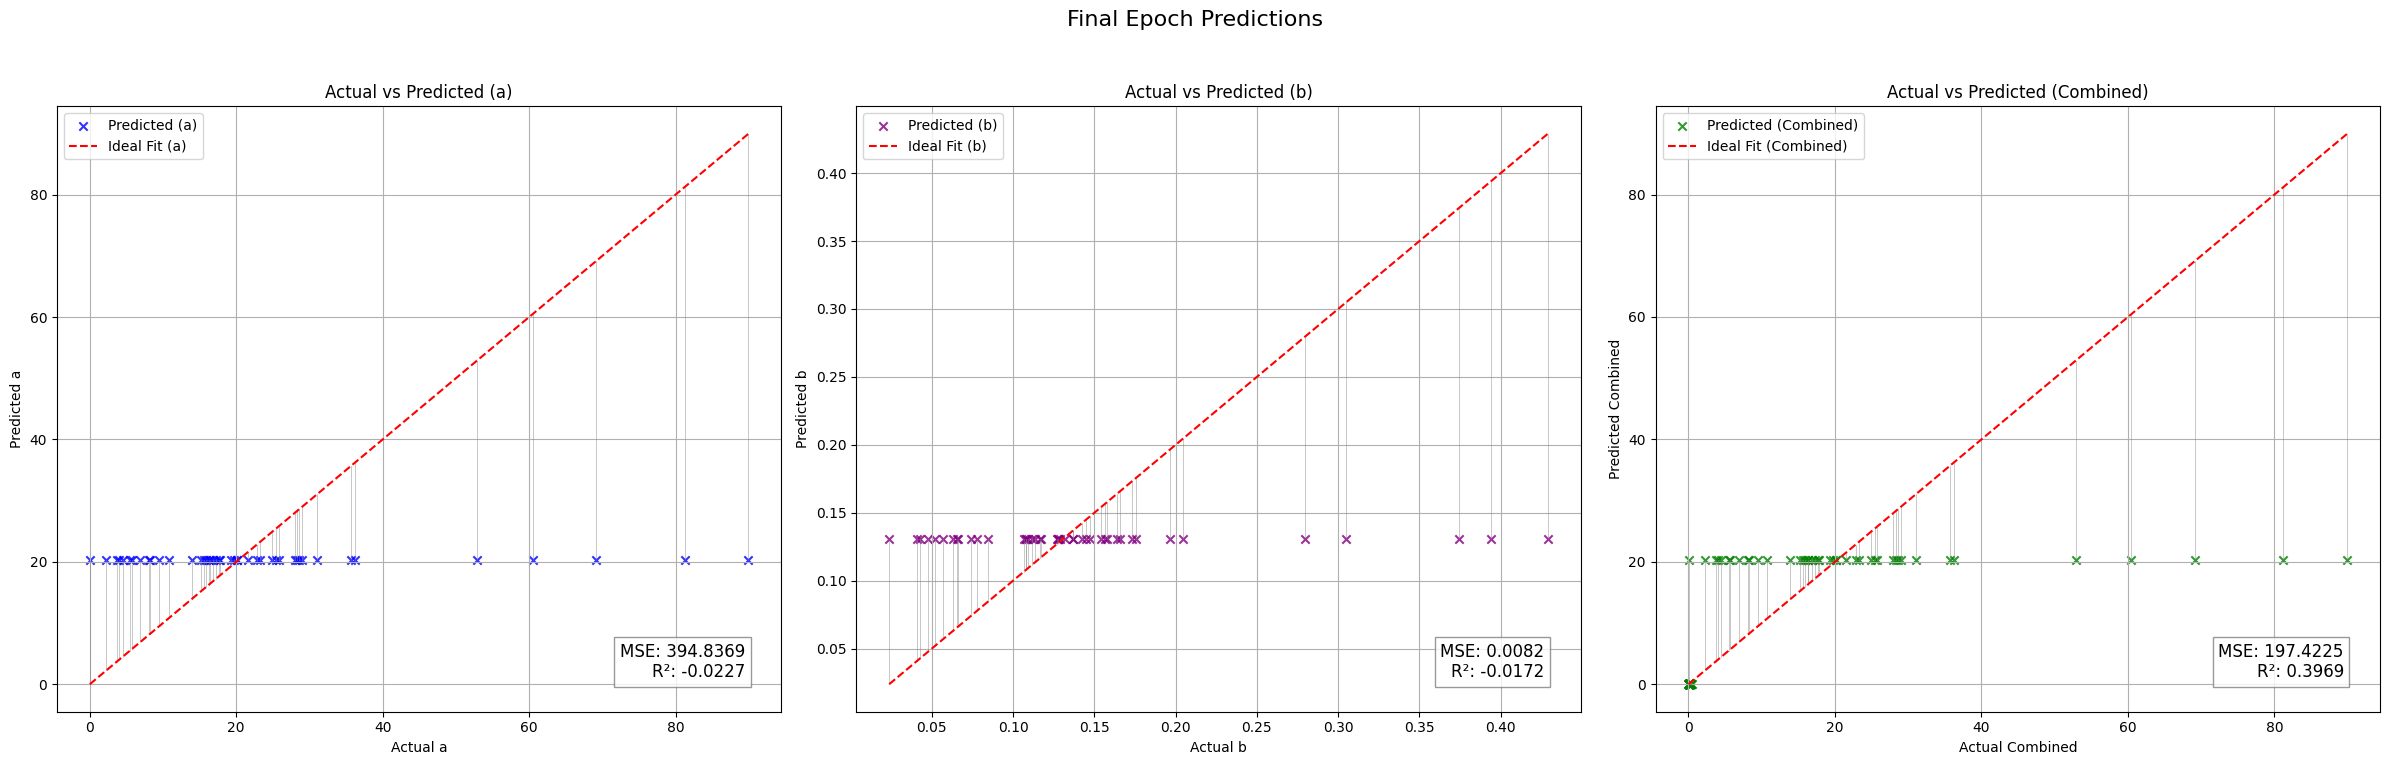

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0196
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Fold 1 Metrics:
  - Validation Loss (MSE): 197.3764
  - R²: -0.0196
  - MAE: 6.4537
  - EVS: 0.0000
Fold 2/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 32.88it/s, loss=0.461]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3760, Val Loss: 98.3532
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 21.06it/s, loss=0.41]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3708, Val Loss: 98.3532
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 40.48it/s, loss=0.261]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.3570, Val Loss: 98.3532
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 30.49it/s, loss=0.39]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1718
  - MAE: 5.9497
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.3679, Val Loss: 98.3532
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 32.40it/s, loss=0.296]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.3591, Val Loss: 98.3532
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 22.30it/s, loss=0.399]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.3677, Val Loss: 98.3532
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 15.08it/s, loss=0.356]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3635, Val Loss: 98.3532
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 33.28it/s, loss=0.402]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.3671, Val Loss: 98.3532
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 69.88it/s, loss=0.449]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.4316
  - R²: -0.1722
  - MAE: 5.9532
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.3709, Val Loss: 98.4316
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 57.73it/s, loss=0.331]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3600, Val Loss: 98.3532
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 33.30it/s, loss=0.391]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.3650, Val Loss: 98.3532
Current Dropout Rate: 0.4200


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


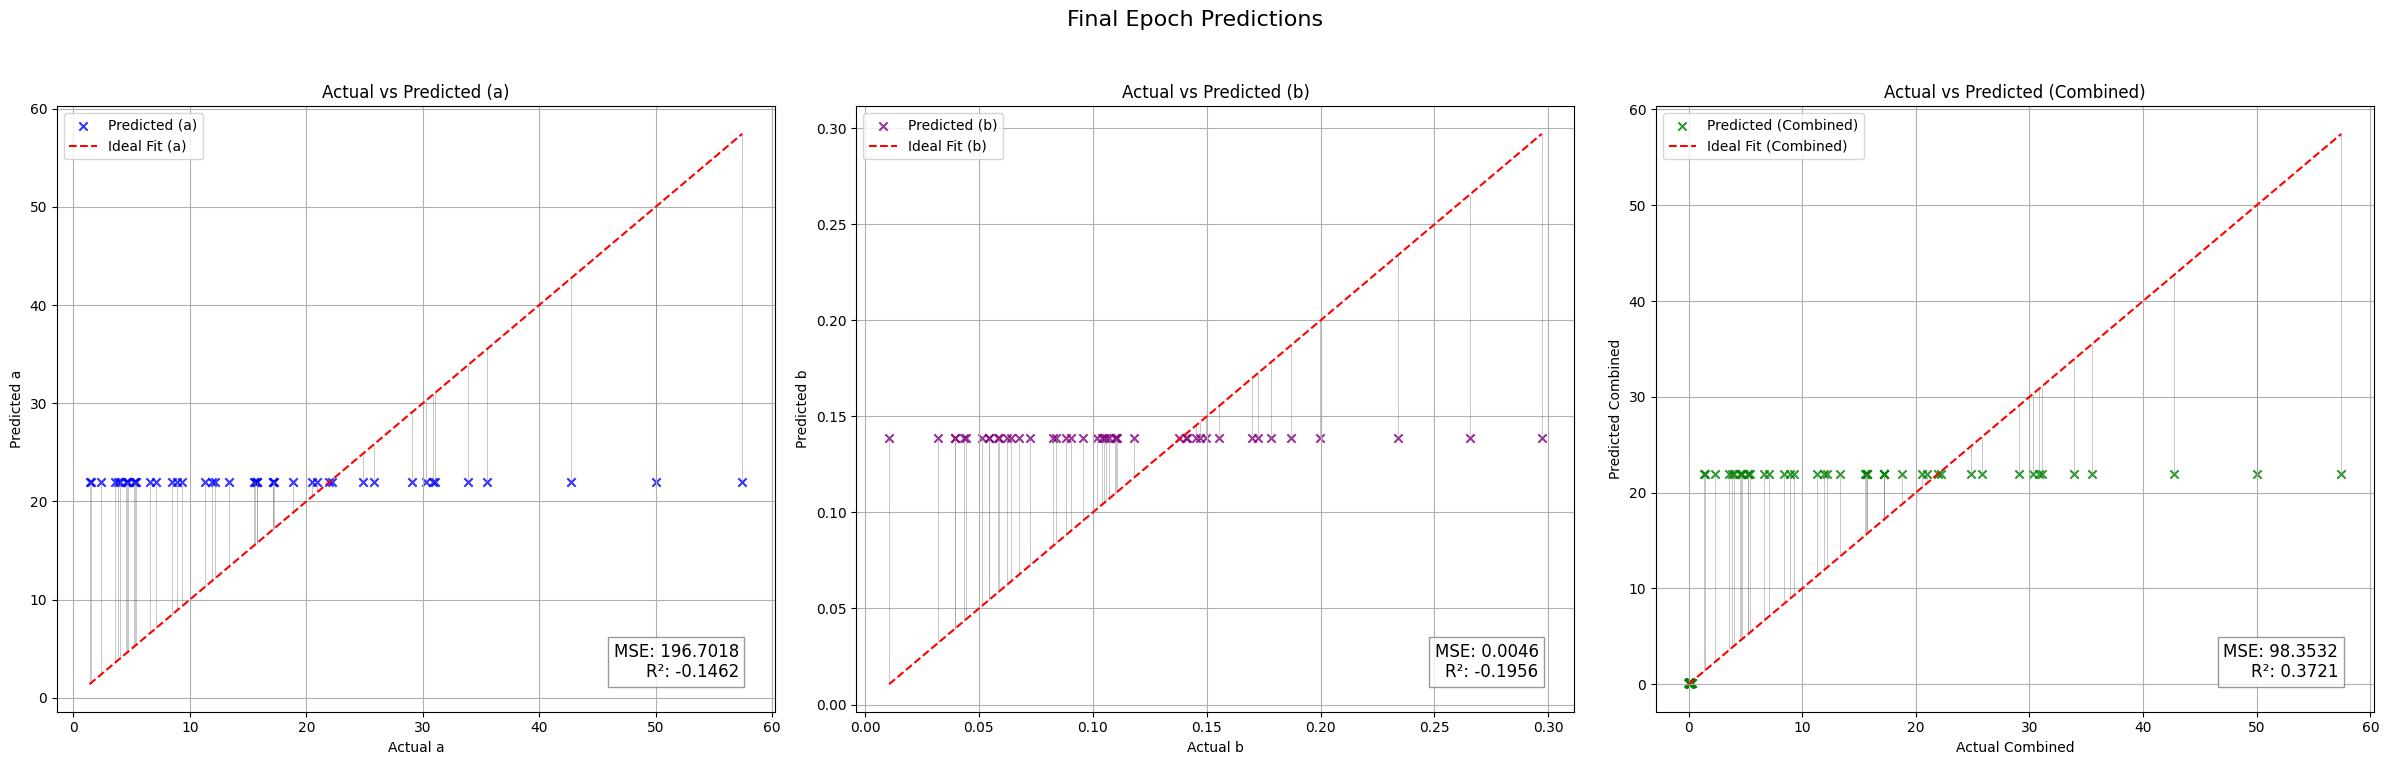

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Fold 2 Metrics:
  - Validation Loss (MSE): 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - EVS: -0.0000
Fold 3/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 49.34it/s, loss=0.288]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3579, Val Loss: 111.2922
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 54.53it/s, loss=0.319]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3600, Val Loss: 111.2922
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 47.46it/s, loss=0.317]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.3592, Val Loss: 111.2922
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 36.32it/s, loss=0.353]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.3618, Val Loss: 111.2861
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 35.93it/s, loss=0.469]

Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000


<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [5/50], Train Loss: 0.3719, Val Loss: 111.2861
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 27.45it/s, loss=0.386]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.3643, Val Loss: 111.2922
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 50.11it/s, loss=0.536]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3773, Val Loss: 111.2922
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 52.11it/s, loss=0.279]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.3544, Val Loss: 111.2922
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 30.15it/s, loss=0.216]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.3485, Val Loss: 111.2922
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 40.51it/s, loss=0.362]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3612, Val Loss: 111.2861
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 40.22it/s, loss=0.267]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.3526, Val Loss: 111.2922
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00, 36.26it/s, loss=0.324]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [12/50], Train Loss: 0.3574, Val Loss: 111.2922
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00, 78.07it/s, loss=0.308]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [13/50], Train Loss: 0.3558, Val Loss: 111.2922
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00, 34.29it/s, loss=0.246]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [14/50], Train Loss: 0.3501, Val Loss: 111.2922
Current Dropout Rate: 0.3960


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


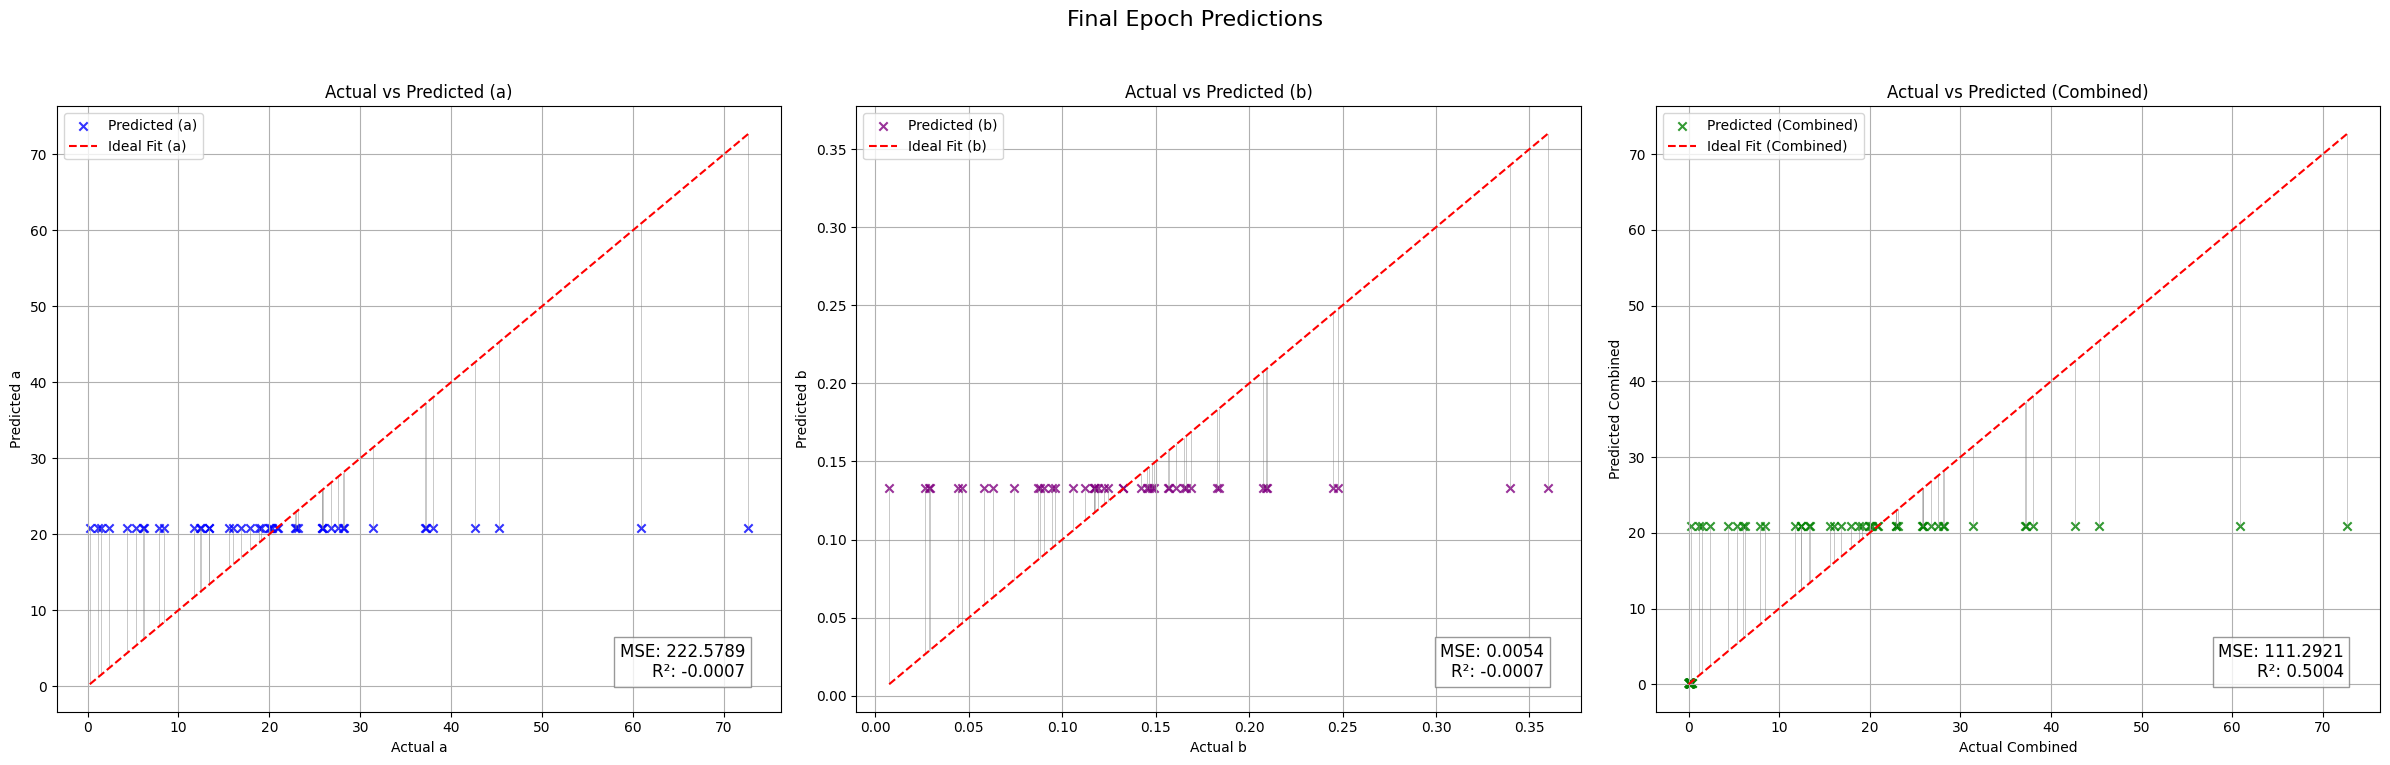

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Fold 3 Metrics:
  - Validation Loss (MSE): 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - EVS: -0.0000
Fold 4/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 67.40it/s, loss=0.222]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3603, Val Loss: 94.0374
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 77.60it/s, loss=0.328]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3694, Val Loss: 94.0374
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 99.94it/s, loss=0.308] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.3674, Val Loss: 94.0374
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 94.10it/s, loss=0.414] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.3765, Val Loss: 94.0374
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 79.71it/s, loss=0.382]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.3735, Val Loss: 94.0374
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 85.04it/s, loss=0.277]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.3639, Val Loss: 94.0374
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 77.46it/s, loss=0.362]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3712, Val Loss: 94.0374
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 93.73it/s, loss=0.269] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.3629, Val Loss: 94.0374
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 81.35it/s, loss=0.391]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.3736, Val Loss: 94.0374
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 72.13it/s, loss=0.497]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3828, Val Loss: 94.0374
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 88.62it/s, loss=0.313]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.3665, Val Loss: 94.0374
Current Dropout Rate: 0.4200


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


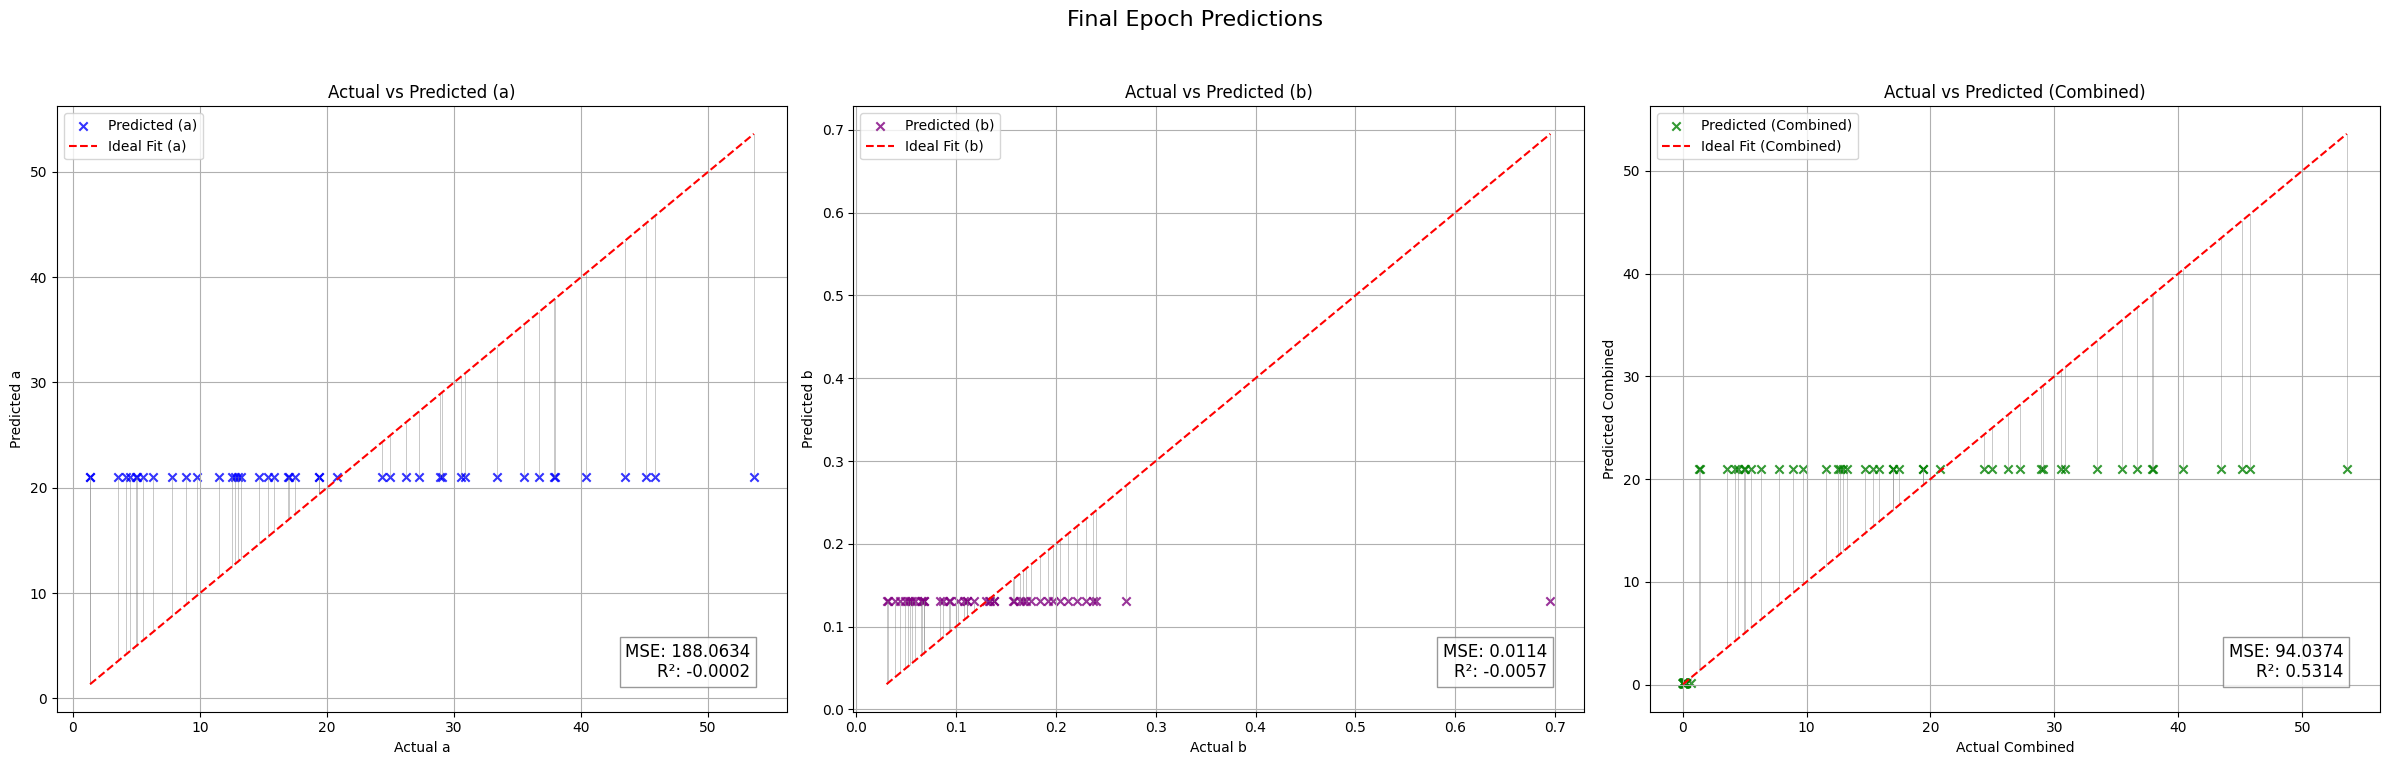

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Fold 4 Metrics:
  - Validation Loss (MSE): 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - EVS: -0.0000
Fold 5/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 82.79it/s, loss=0.243]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [1/50], Train Loss: 0.3612, Val Loss: 182.6789
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 92.53it/s, loss=0.46] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [2/50], Train Loss: 0.3791, Val Loss: 182.6491
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 94.75it/s, loss=0.344] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [3/50], Train Loss: 0.3693, Val Loss: 182.6491
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 95.49it/s, loss=0.347] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [4/50], Train Loss: 0.3694, Val Loss: 182.6789
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 90.58it/s, loss=0.488]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [5/50], Train Loss: 0.3810, Val Loss: 182.6789
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 92.95it/s, loss=0.305] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [6/50], Train Loss: 0.3657, Val Loss: 182.6491
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 91.59it/s, loss=0.376]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [7/50], Train Loss: 0.3715, Val Loss: 182.6491
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 89.62it/s, loss=0.25]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [8/50], Train Loss: 0.3609, Val Loss: 182.6491
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 67.73it/s, loss=0.373]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.3710, Val Loss: 182.6491
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 72.30it/s, loss=0.359]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [10/50], Train Loss: 0.3698, Val Loss: 182.6491
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 59.50it/s, loss=0.348]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.3689, Val Loss: 182.6491
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00, 57.05it/s, loss=0.417]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [12/50], Train Loss: 0.3746, Val Loss: 182.6491
Current Dropout Rate: 0.4120
Early stopping triggered!
Loading the best model for evaluation...


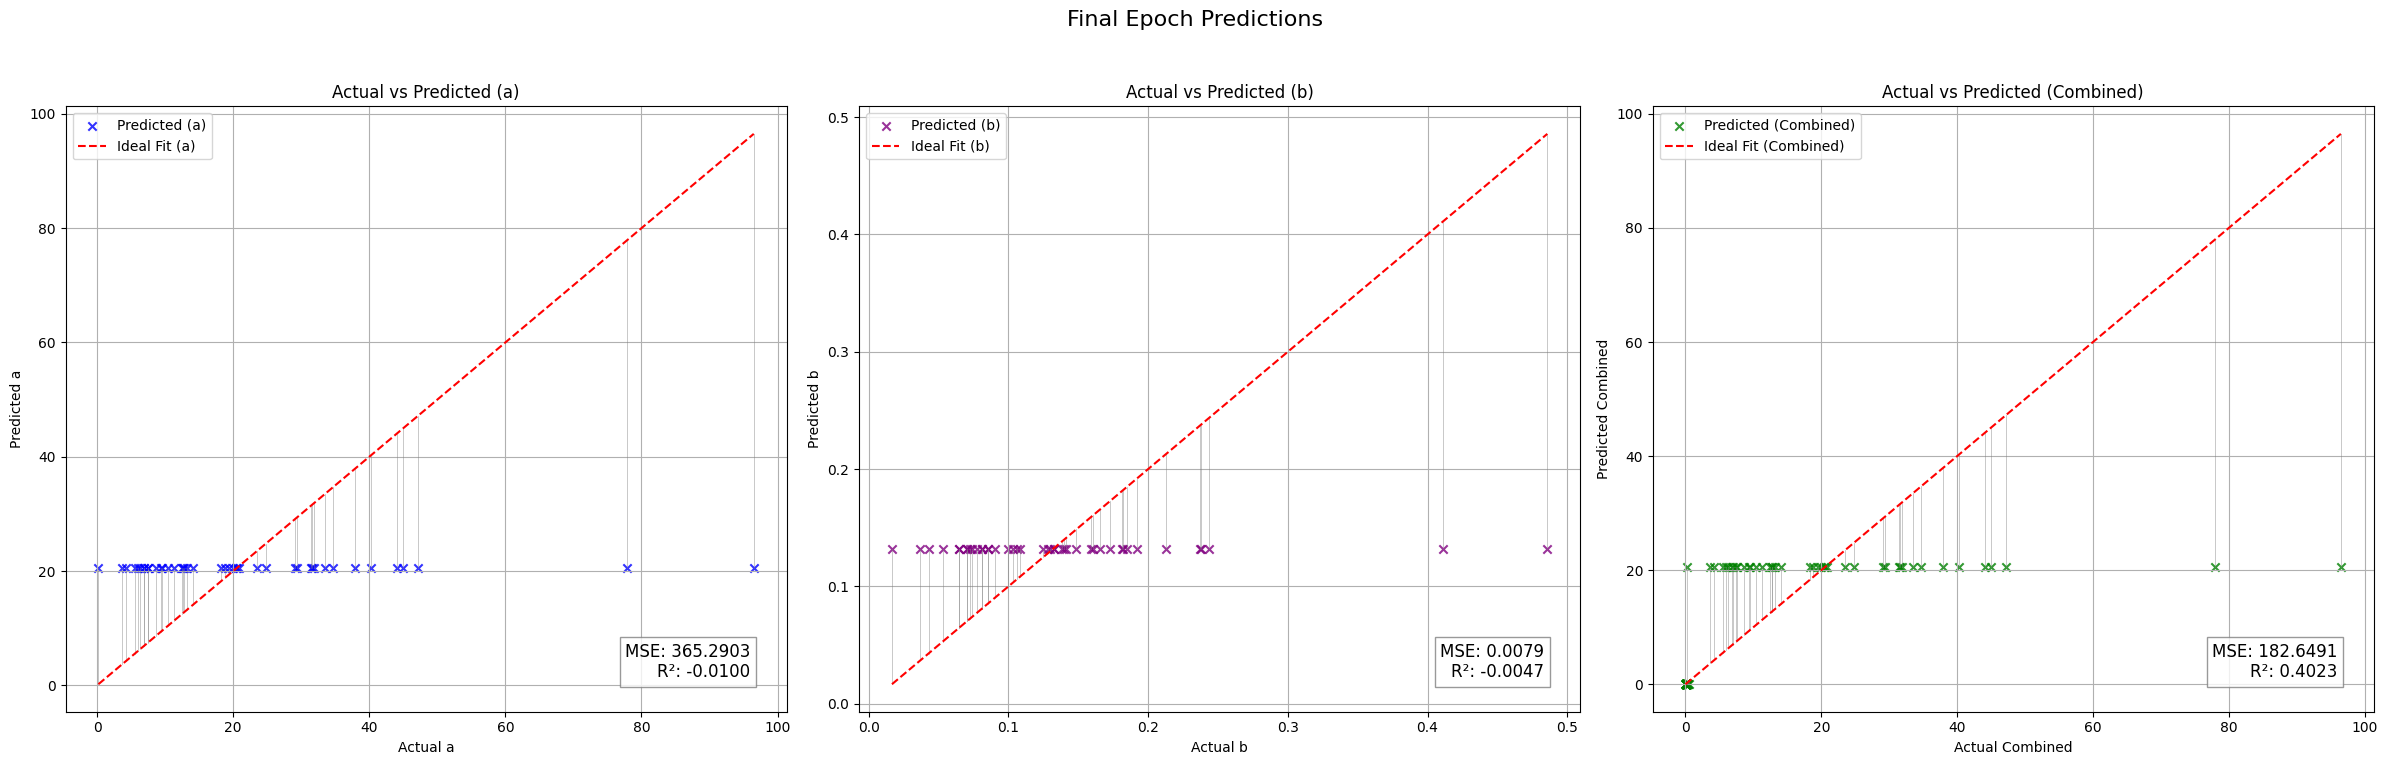

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[I 2024-11-30 07:26:02,008] Trial 0 finished with value: 136.7404327392578 and parameters: {'num_layers': 1, 'hidden_size_0': 496, 'activation_0': 'LeakyReLU', 'dropout_0': 0.19912751670087414, 'batch_size': 64, 'learning_rate': 0.0007038904941635791, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 136.7404327392578.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-11-452298e7c718>:709: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...

Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Fold 5 Metrics:
  - Validation Loss (MSE): 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - EVS: 0.0000
Avg Validation Metrics:
  - MSE: 136.7404
  - R²: -0.0403
  - MAE: 6.0994
  - EVS: -0.0000
Using device: cuda
Fold 1/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 52.88it/s, loss=0.822]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [1/50], Train Loss: 1.6747, Val Loss: 197.4690
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 70.04it/s, loss=0.286]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [2/50], Train Loss: 0.4015, Val Loss: 197.4690
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 60.40it/s, loss=0.367]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0201
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [3/50], Train Loss: 0.3893, Val Loss: 197.4225
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 66.41it/s, loss=0.258]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [4/50], Train Loss: 0.3805, Val Loss: 197.4225
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 60.02it/s, loss=0.654]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [5/50], Train Loss: 0.3774, Val Loss: 197.4225
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 58.18it/s, loss=0.208]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0196
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Epoch [6/50], Train Loss: 0.3712, Val Loss: 197.3764
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 70.77it/s, loss=0.307]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0201
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [7/50], Train Loss: 0.3694, Val Loss: 197.4225
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 69.33it/s, loss=0.171]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [8/50], Train Loss: 0.3672, Val Loss: 197.4690
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 61.08it/s, loss=0.163]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0198
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.3667, Val Loss: 197.3764
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 65.54it/s, loss=0.472]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.2848
  - R²: -0.0192
  - MAE: 6.4566
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3702, Val Loss: 197.2848
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 68.64it/s, loss=0.241]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.3926, Val Loss: 197.4225
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 65.54it/s, loss=0.605]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.1942
  - R²: -0.0188
  - MAE: 6.4594
  - Explained Variance Score (EVS): -0.0000
Epoch [12/50], Train Loss: 0.4526, Val Loss: 197.1942
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 65.46it/s, loss=1.1]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.5625
  - R²: -0.0209
  - MAE: 6.4480
  - Explained Variance Score (EVS): 0.0000
Epoch [13/50], Train Loss: 0.6058, Val Loss: 197.5625
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 61.98it/s, loss=1.08]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.2848
  - R²: -0.0191
  - MAE: 6.4566
  - Explained Variance Score (EVS): -0.0000
Epoch [14/50], Train Loss: 0.8794, Val Loss: 197.2848
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 58.48it/s, loss=0.914]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.7525
  - R²: -0.0212
  - MAE: 6.4424
  - Explained Variance Score (EVS): 0.0000
Epoch [15/50], Train Loss: 0.8773, Val Loss: 197.7525
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 61.12it/s, loss=0.645]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.1046
  - R²: -0.0184
  - MAE: 6.4623
  - Explained Variance Score (EVS): -0.0000
Epoch [16/50], Train Loss: 0.7982, Val Loss: 197.1046
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 69.94it/s, loss=0.413]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4226
  - R²: -0.0209
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [17/50], Train Loss: 0.5244, Val Loss: 197.4226
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 76.04it/s, loss=0.59]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.1492
  - R²: -0.0189
  - MAE: 6.4608
  - Explained Variance Score (EVS): -0.0000
Epoch [18/50], Train Loss: 0.5318, Val Loss: 197.1492
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 70.13it/s, loss=0.81]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.8490
  - R²: -0.0212
  - MAE: 6.4395
  - Explained Variance Score (EVS): 0.0000
Epoch [19/50], Train Loss: 0.7831, Val Loss: 197.8490
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 65.58it/s, loss=0.706]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.2848
  - R²: -0.0189
  - MAE: 6.4566
  - Explained Variance Score (EVS): -0.0000
Epoch [20/50], Train Loss: 0.9056, Val Loss: 197.2848
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 64.15it/s, loss=0.317]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [21/50], Train Loss: 0.4176, Val Loss: 197.4225
Current Dropout Rate: 0.3400


Epoch 22/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 53.20it/s, loss=0.349]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [22/50], Train Loss: 0.3653, Val Loss: 197.4225
Current Dropout Rate: 0.3320


Epoch 23/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 60.17it/s, loss=0.371]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [23/50], Train Loss: 0.3655, Val Loss: 197.4225
Current Dropout Rate: 0.3240


Epoch 24/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24/50: 100%|██████████| 11/11 [00:00<00:00, 59.87it/s, loss=0.51]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [24/50], Train Loss: 0.3663, Val Loss: 197.4690
Current Dropout Rate: 0.3160


Epoch 25/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25/50: 100%|██████████| 11/11 [00:00<00:00, 53.19it/s, loss=0.474]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [25/50], Train Loss: 0.3661, Val Loss: 197.4690
Current Dropout Rate: 0.3080


Epoch 26/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26/50: 100%|██████████| 11/11 [00:00<00:00, 75.53it/s, loss=0.303]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the func

Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0198
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Epoch [26/50], Train Loss: 0.3651, Val Loss: 197.3764
Current Dropout Rate: 0.3000
Early stopping triggered!
Loading the best model for evaluation...


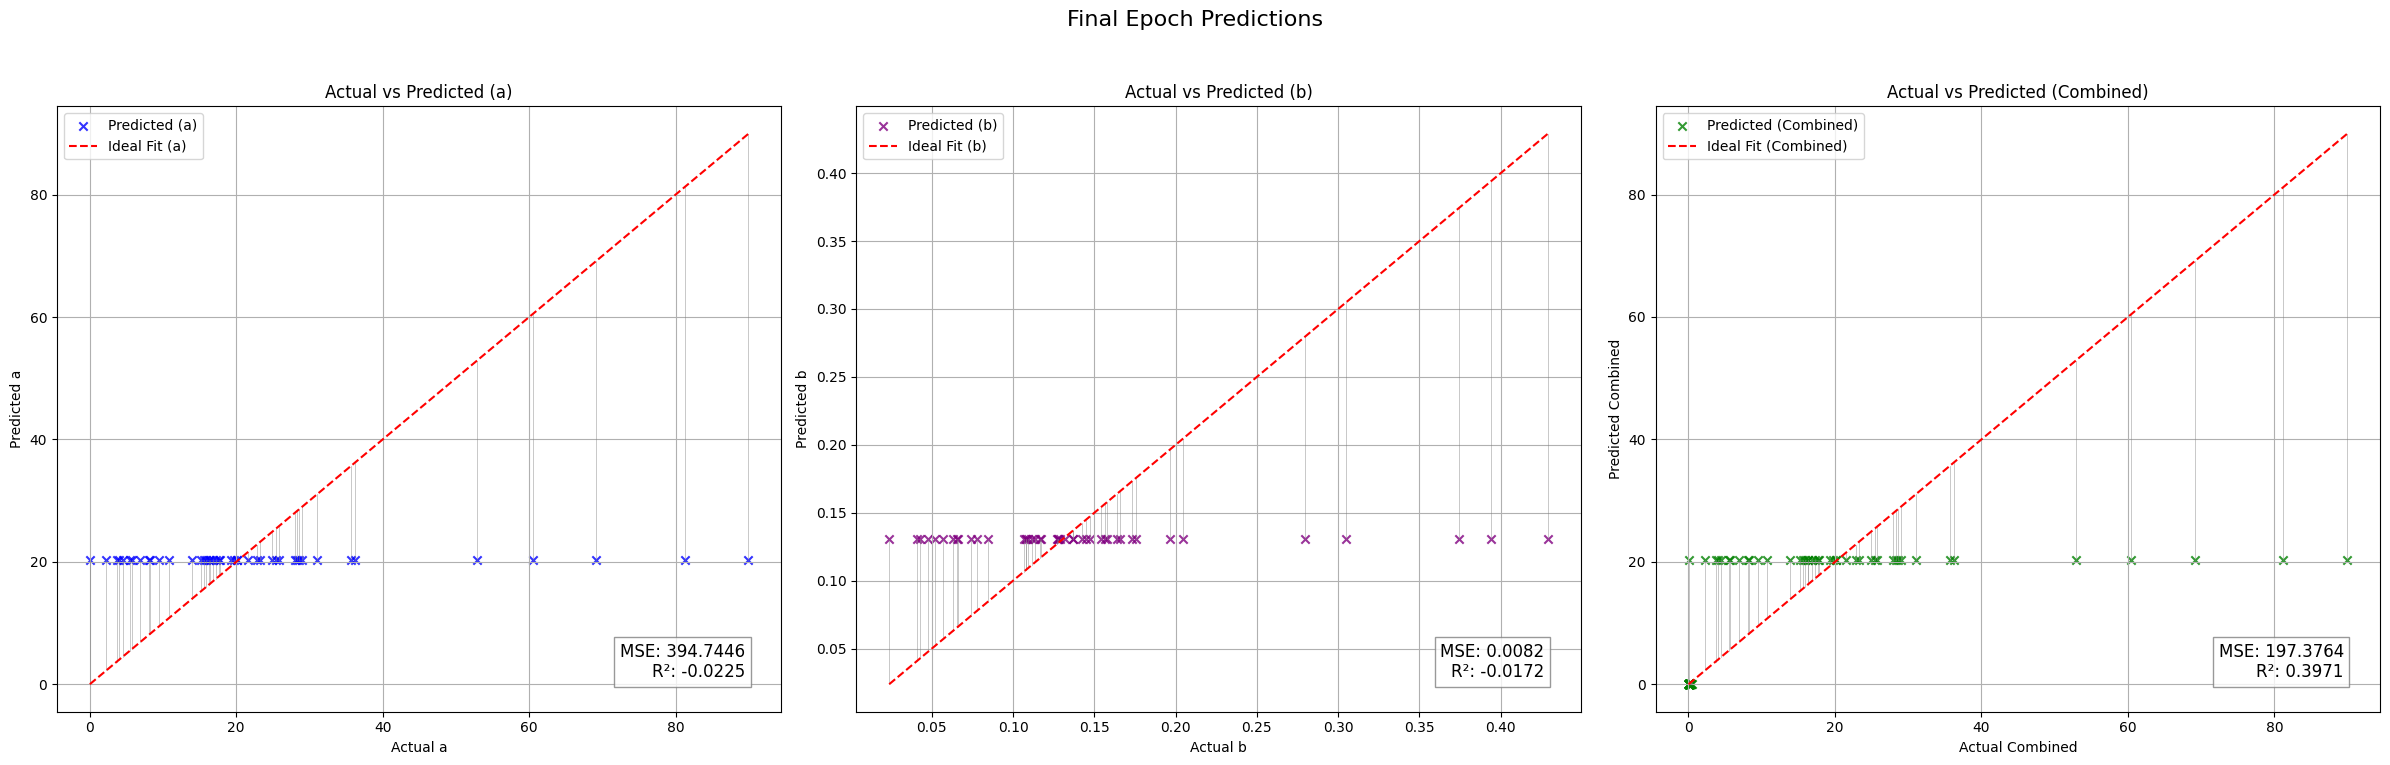

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 197.1046
  - R²: -0.0184
  - MAE: 6.4623
  - Explained Variance Score (EVS): -0.0000
Fold 1 Metrics:
  - Validation Loss (MSE): 197.1046
  - R²: -0.0184
  - MAE: 6.4623
  - EVS: -0.0000
Fold 2/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 68.09it/s, loss=0.209]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2750
  - R²: -0.1705
  - MAE: 5.9464
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3971, Val Loss: 98.2750
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 80.38it/s, loss=0.28]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3567, Val Loss: 98.3532
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 74.10it/s, loss=0.309]

Validation Metrics:
  - MSE: 98.2750
  - R²: -0.1705
  - MAE: 5.9464
  - Explained Variance Score (EVS): -0.0000


<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [3/50], Train Loss: 0.3569, Val Loss: 98.2750
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 74.78it/s, loss=0.222]

Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.3566, Val Loss: 98.3532


<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 76.39it/s, loss=0.254]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1718
  - MAE: 5.9497
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.3571, Val Loss: 98.3532
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 68.32it/s, loss=0.627]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1971
  - R²: -0.1691
  - MAE: 5.9432
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.3604, Val Loss: 98.1971
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 67.16it/s, loss=0.178]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3531
  - R²: -0.1701
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3634, Val Loss: 98.3531
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 77.85it/s, loss=0.4]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1971
  - R²: -0.1691
  - MAE: 5.9432
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.4258, Val Loss: 98.1971
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 75.56it/s, loss=0.611]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1718
  - MAE: 5.9497
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.5496, Val Loss: 98.3532
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 69.24it/s, loss=0.606]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.6682
  - R²: -0.1763
  - MAE: 5.9639
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.5320, Val Loss: 98.6682
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 69.62it/s, loss=0.647]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.4316
  - R²: -0.1722
  - MAE: 5.9532
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.6308, Val Loss: 98.4316
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 66.61it/s, loss=0.254]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.4316
  - R²: -0.1714
  - MAE: 5.9532
  - Explained Variance Score (EVS): -0.0000
Epoch [12/50], Train Loss: 0.5798, Val Loss: 98.4316
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 64.63it/s, loss=0.594]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.5102
  - R²: -0.1736
  - MAE: 5.9568
  - Explained Variance Score (EVS): -0.0000
Epoch [13/50], Train Loss: 0.4429, Val Loss: 98.5102
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 69.36it/s, loss=0.531]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.5102
  - R²: -0.1736
  - MAE: 5.9568
  - Explained Variance Score (EVS): -0.0000
Epoch [14/50], Train Loss: 0.5405, Val Loss: 98.5102
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 77.96it/s, loss=0.835]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1195
  - R²: -0.1678
  - MAE: 5.9399
  - Explained Variance Score (EVS): -0.0000
Epoch [15/50], Train Loss: 0.5590, Val Loss: 98.1195
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 65.98it/s, loss=0.75]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1718
  - MAE: 5.9497
  - Explained Variance Score (EVS): -0.0000
Epoch [16/50], Train Loss: 0.3775, Val Loss: 98.3532
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 82.64it/s, loss=0.303]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [17/50], Train Loss: 0.3566, Val Loss: 98.3532
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 82.29it/s, loss=0.572]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1718
  - MAE: 5.9497
  - Explained Variance Score (EVS): -0.0000
Epoch [18/50], Train Loss: 0.3581, Val Loss: 98.3532
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 68.51it/s, loss=0.347]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2750
  - R²: -0.1705
  - MAE: 5.9464
  - Explained Variance Score (EVS): -0.0000
Epoch [19/50], Train Loss: 0.3569, Val Loss: 98.2750
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 75.11it/s, loss=0.215]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [20/50], Train Loss: 0.3562, Val Loss: 98.3532
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 84.09it/s, loss=0.455]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [21/50], Train Loss: 0.3575, Val Loss: 98.3532
Current Dropout Rate: 0.3400


Epoch 22/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 83.16it/s, loss=0.377]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [22/50], Train Loss: 0.3572, Val Loss: 98.3532
Current Dropout Rate: 0.3320


Epoch 23/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 84.39it/s, loss=0.259]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [23/50], Train Loss: 0.3566, Val Loss: 98.3532
Current Dropout Rate: 0.3240


Epoch 24/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24/50: 100%|██████████| 11/11 [00:00<00:00, 62.30it/s, loss=0.31]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2750
  - R²: -0.1705
  - MAE: 5.9464
  - Explained Variance Score (EVS): -0.0000
Epoch [24/50], Train Loss: 0.3571, Val Loss: 98.2750
Current Dropout Rate: 0.3160


Epoch 25/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25/50: 100%|██████████| 11/11 [00:00<00:00, 76.24it/s, loss=0.148]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the func

Validation Metrics:
  - MSE: 98.2750
  - R²: -0.1705
  - MAE: 5.9464
  - Explained Variance Score (EVS): -0.0000
Epoch [25/50], Train Loss: 0.3563, Val Loss: 98.2750
Current Dropout Rate: 0.3080
Early stopping triggered!
Loading the best model for evaluation...


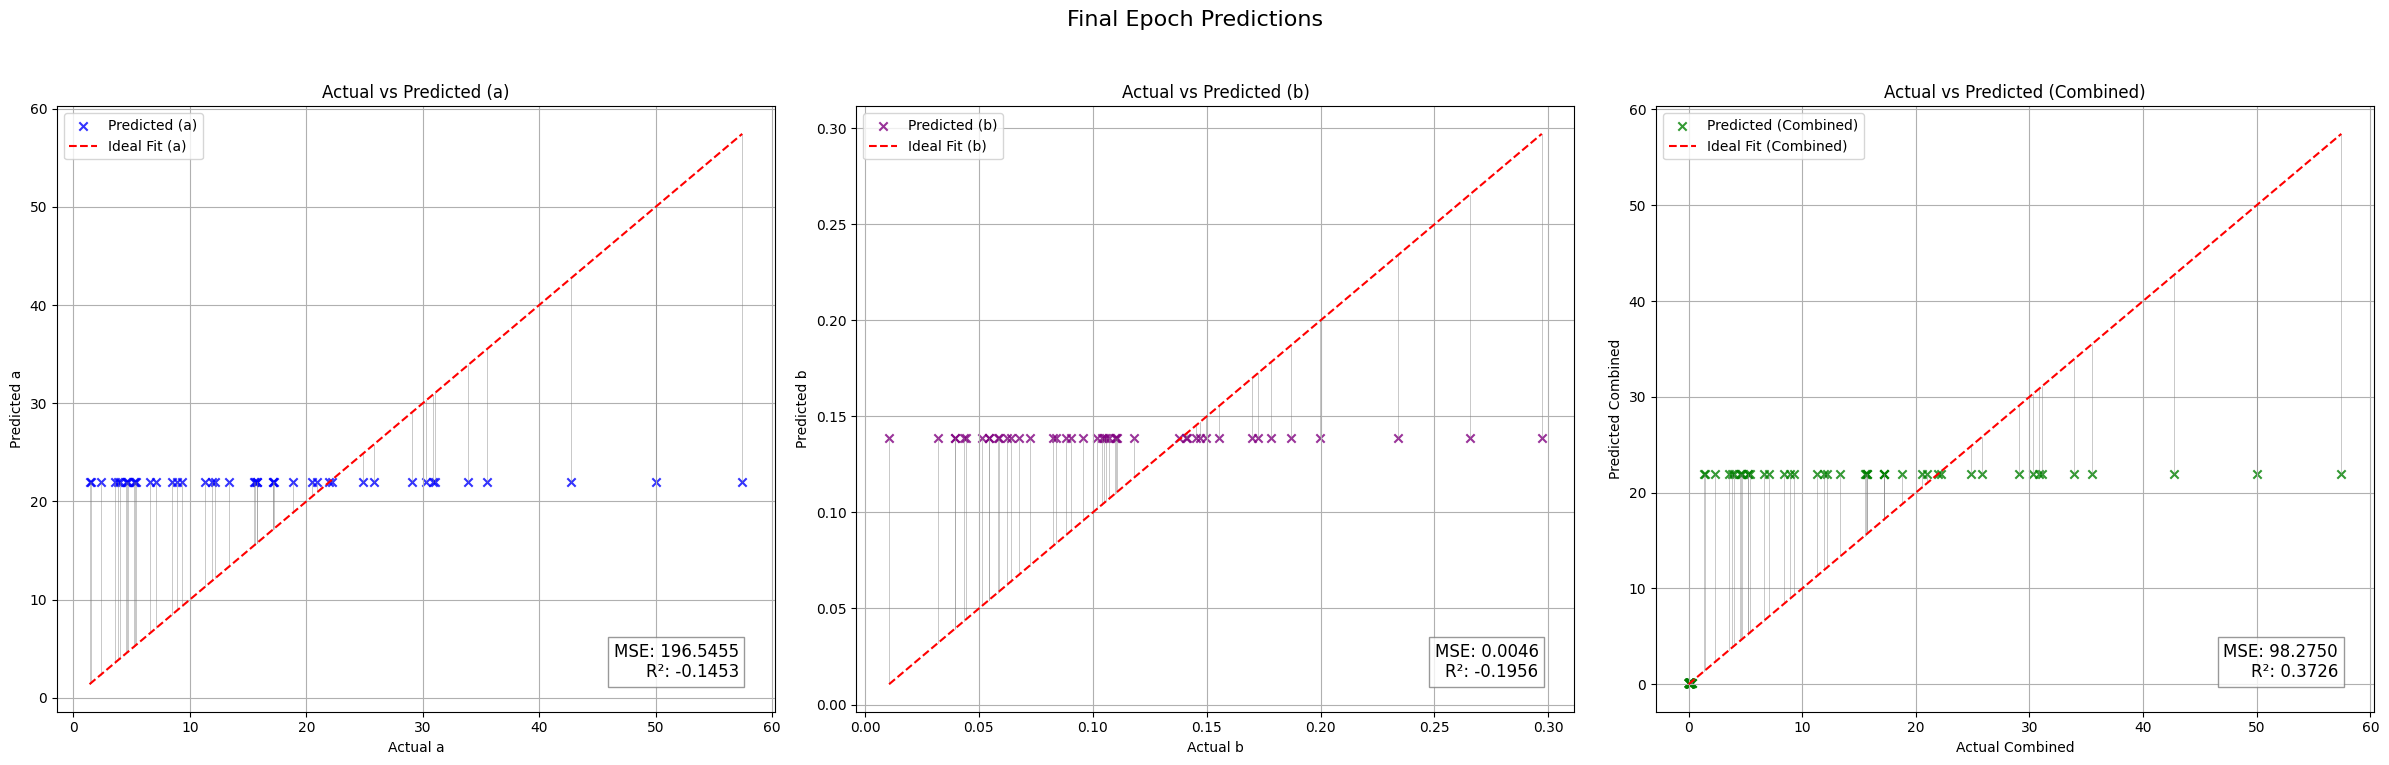

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 98.1195
  - R²: -0.1678
  - MAE: 5.9399
  - Explained Variance Score (EVS): -0.0000
Fold 2 Metrics:
  - Validation Loss (MSE): 98.1195
  - R²: -0.1678
  - MAE: 5.9399
  - EVS: -0.0000
Fold 3/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 68.80it/s, loss=0.525]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2747
  - R²: -0.0006
  - MAE: 5.4415
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.4253, Val Loss: 111.2747
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 74.76it/s, loss=0.583]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2802
  - R²: -0.0006
  - MAE: 5.4403
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3757, Val Loss: 111.2802
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 78.72it/s, loss=0.762]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2693
  - R²: -0.0005
  - MAE: 5.4429
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.3897, Val Loss: 111.2693
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 70.66it/s, loss=0.5]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2985
  - R²: -0.0007
  - MAE: 5.4371
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.4567, Val Loss: 111.2985
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 77.11it/s, loss=0.4]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.3050
  - R²: -0.0008
  - MAE: 5.4360
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.4597, Val Loss: 111.3050
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 63.57it/s, loss=0.465]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2802
  - R²: -0.0006
  - MAE: 5.4403
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.4244, Val Loss: 111.2802
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 74.17it/s, loss=0.305]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3641, Val Loss: 111.2922
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 82.78it/s, loss=0.375]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.3546, Val Loss: 111.2922
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 72.13it/s, loss=0.466]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.3552, Val Loss: 111.2922
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 54.64it/s, loss=0.511]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3555, Val Loss: 111.2861
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 82.88it/s, loss=0.327]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.3545, Val Loss: 111.2861
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 73.07it/s, loss=0.405]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [12/50], Train Loss: 0.3549, Val Loss: 111.2922
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 70.53it/s, loss=0.2]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functi

Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [13/50], Train Loss: 0.3539, Val Loss: 111.2922
Current Dropout Rate: 0.4040
Early stopping triggered!
Loading the best model for evaluation...


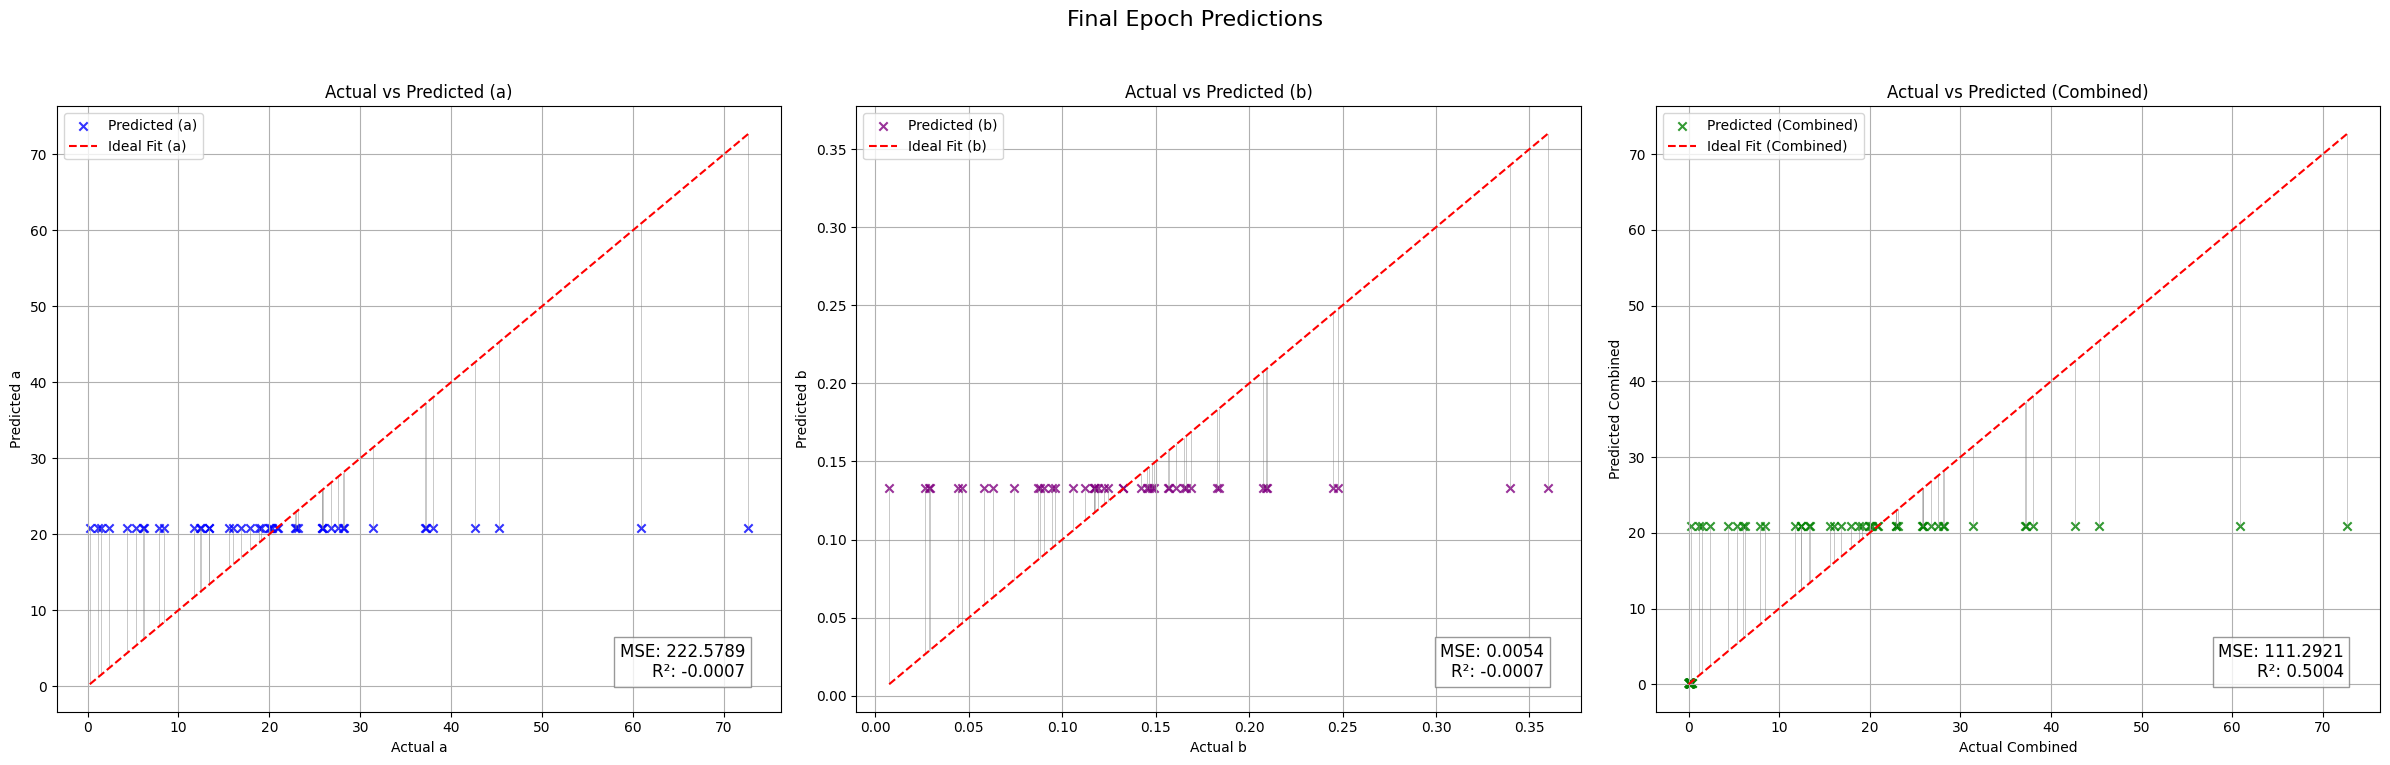

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 111.2693
  - R²: -0.0005
  - MAE: 5.4429
  - Explained Variance Score (EVS): -0.0000
Fold 3 Metrics:
  - Validation Loss (MSE): 111.2693
  - R²: -0.0005
  - MAE: 5.4429
  - EVS: -0.0000
Fold 4/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 67.53it/s, loss=0.141]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0404
  - R²: -0.0029
  - MAE: 5.9051
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3747, Val Loss: 94.0404
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 73.86it/s, loss=0.387]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0404
  - R²: -0.0029
  - MAE: 5.9051
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3664, Val Loss: 94.0404
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 53.97it/s, loss=0.461]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0346
  - R²: -0.0030
  - MAE: 5.9022
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.3670, Val Loss: 94.0346
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 80.40it/s, loss=0.175]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.3658, Val Loss: 94.0374
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 72.56it/s, loss=0.29]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.3684, Val Loss: 94.0374
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 84.43it/s, loss=0.241]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.3789, Val Loss: 94.0374
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 71.48it/s, loss=0.391]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0346
  - R²: -0.0030
  - MAE: 5.9022
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.4173, Val Loss: 94.0346
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 71.40it/s, loss=0.307]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.4200, Val Loss: 94.0374
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 67.70it/s, loss=0.234]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0346
  - R²: -0.0029
  - MAE: 5.9022
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.4507, Val Loss: 94.0346
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 69.36it/s, loss=0.321]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.4092, Val Loss: 94.0374
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 75.70it/s, loss=0.241]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.3994, Val Loss: 94.0374
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 66.12it/s, loss=0.303]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [12/50], Train Loss: 0.3702, Val Loss: 94.0374
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 76.13it/s, loss=0.815]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the func

Validation Metrics:
  - MSE: 94.0404
  - R²: -0.0030
  - MAE: 5.9051
  - Explained Variance Score (EVS): -0.0000
Epoch [13/50], Train Loss: 0.3683, Val Loss: 94.0404
Current Dropout Rate: 0.4040
Early stopping triggered!
Loading the best model for evaluation...


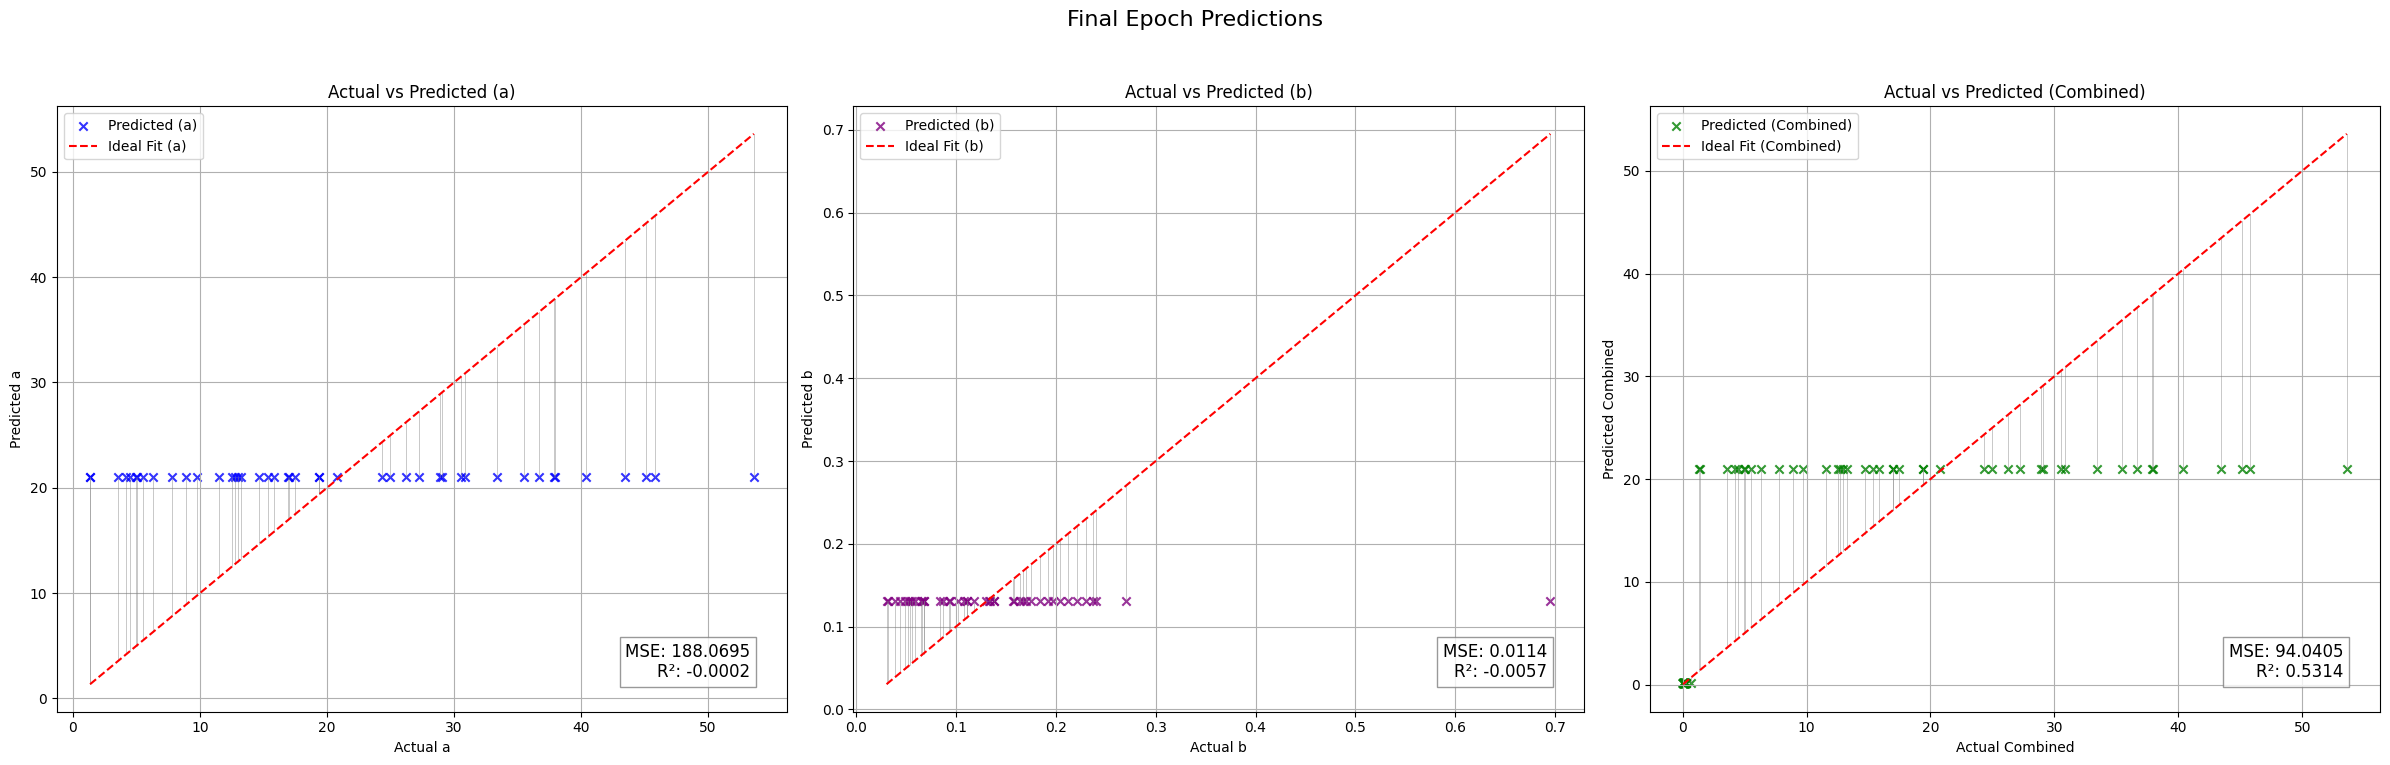

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 94.0346
  - R²: -0.0030
  - MAE: 5.9022
  - Explained Variance Score (EVS): -0.0000
Fold 4 Metrics:
  - Validation Loss (MSE): 94.0346
  - R²: -0.0030
  - MAE: 5.9022
  - EVS: -0.0000
Fold 5/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 77.35it/s, loss=0.439]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [1/50], Train Loss: 0.3644, Val Loss: 182.6491
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 78.85it/s, loss=0.475]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [2/50], Train Loss: 0.3643, Val Loss: 182.6491
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 74.20it/s, loss=0.417]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [3/50], Train Loss: 0.3644, Val Loss: 182.6491
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 59.66it/s, loss=0.372]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [4/50], Train Loss: 0.3644, Val Loss: 182.6491
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 61.29it/s, loss=0.419]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6196
  - R²: -0.0072
  - MAE: 6.7523
  - Explained Variance Score (EVS): 0.0000
Epoch [5/50], Train Loss: 0.3645, Val Loss: 182.6196
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 81.55it/s, loss=0.409]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [6/50], Train Loss: 0.3646, Val Loss: 182.6789
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 81.43it/s, loss=0.406]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [7/50], Train Loss: 0.3646, Val Loss: 182.6491
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 54.66it/s, loss=0.111]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [8/50], Train Loss: 0.3649, Val Loss: 182.6491
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 73.96it/s, loss=0.224]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.3652, Val Loss: 182.6789
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 68.57it/s, loss=0.511]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [10/50], Train Loss: 0.3643, Val Loss: 182.6491
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 76.43it/s, loss=0.283]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.3643, Val Loss: 182.6491
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 66.76it/s, loss=0.42]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [12/50], Train Loss: 0.3643, Val Loss: 182.6789
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 57.25it/s, loss=0.234]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [13/50], Train Loss: 0.3643, Val Loss: 182.6491
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 68.57it/s, loss=0.343]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [14/50], Train Loss: 0.3643, Val Loss: 182.6491
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 75.09it/s, loss=0.278]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the func

Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [15/50], Train Loss: 0.3644, Val Loss: 182.6789
Current Dropout Rate: 0.3880
Early stopping triggered!
Loading the best model for evaluation...


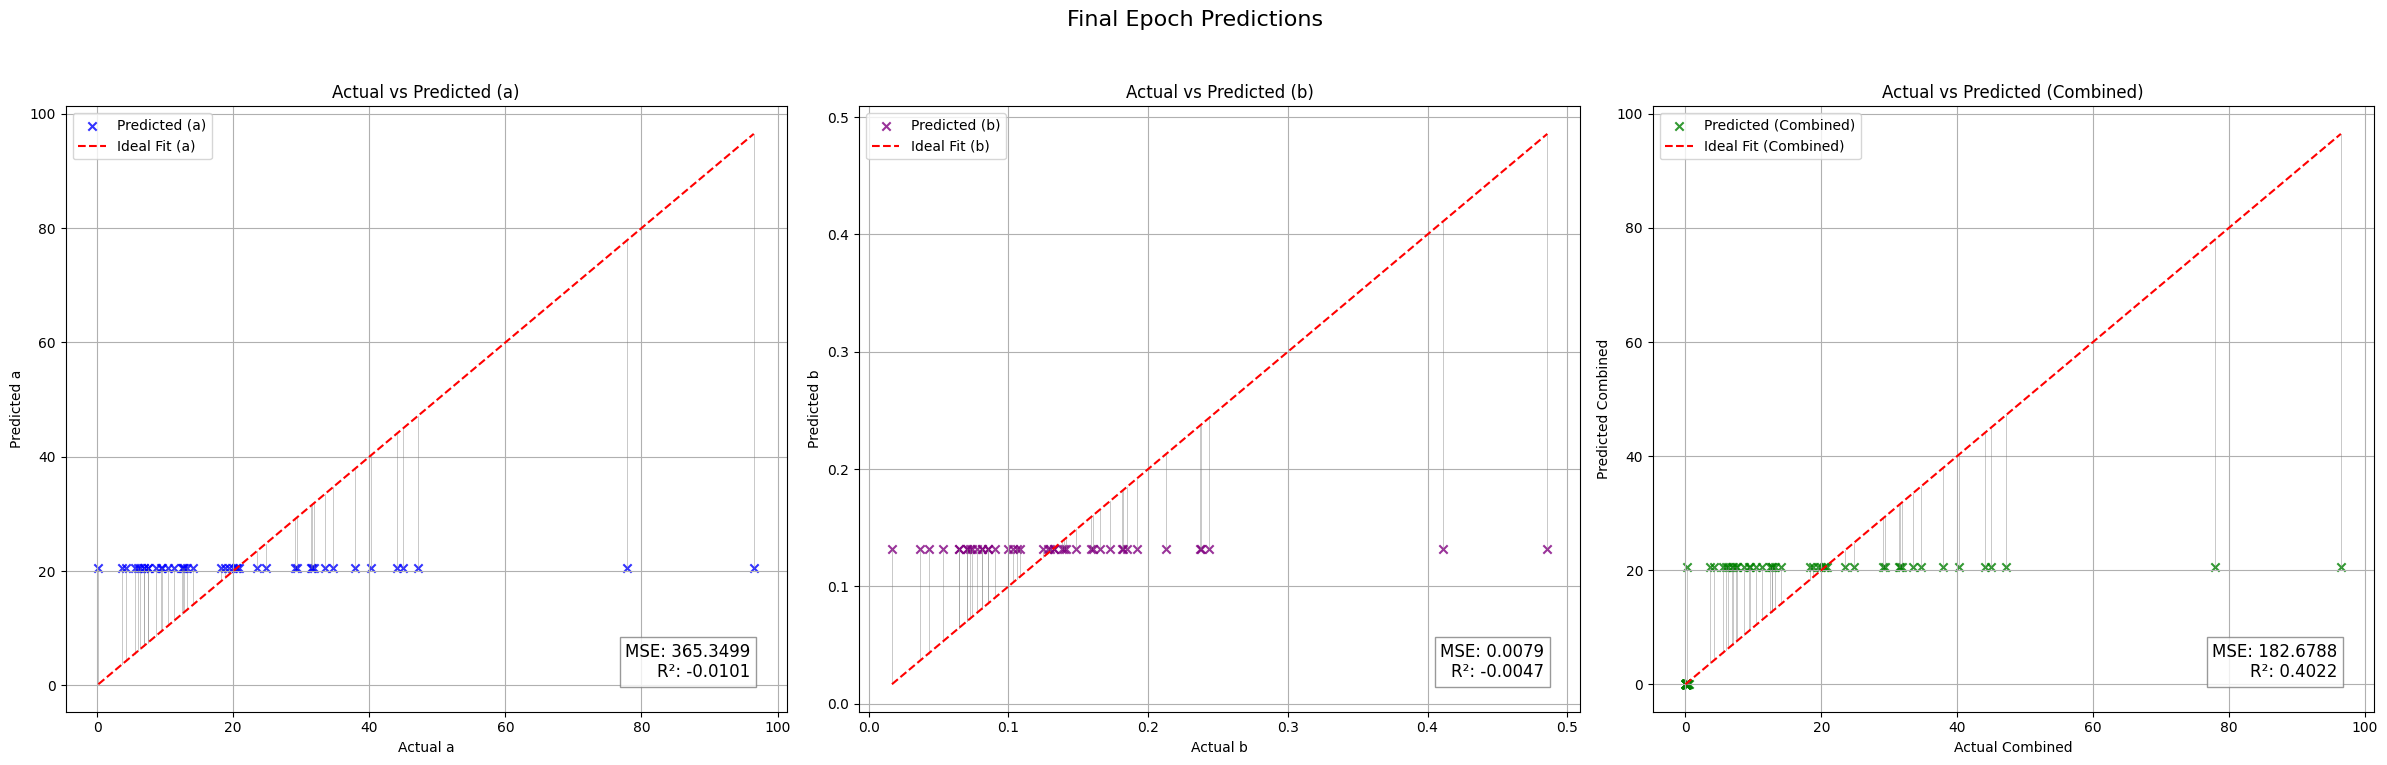

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[I 2024-11-30 07:26:32,147] Trial 1 finished with value: 136.62948608398438 and parameters: {'num_layers': 2, 'hidden_size_0': 482, 'activation_0': 'ELU', 'dropout_0': 0.18339590652379859, 'hidden_size_1': 365, 'activation_1': 'LeakyReLU', 'dropout_1': 0.4668269892289426, 'batch_size': 16, 'learning_rate': 0.0003646034613370035, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 136.62948608398438.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-11-452298e7c718>:709: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipyth

Validation Metrics:
  - MSE: 182.6196
  - R²: -0.0072
  - MAE: 6.7523
  - Explained Variance Score (EVS): 0.0000
Fold 5 Metrics:
  - Validation Loss (MSE): 182.6196
  - R²: -0.0072
  - MAE: 6.7523
  - EVS: 0.0000
Avg Validation Metrics:
  - MSE: 136.6295
  - R²: -0.0394
  - MAE: 6.0999
  - EVS: -0.0000
Using device: cuda
Fold 1/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 55.58it/s, loss=0.721]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.4573
  - R²: -0.0172
  - MAE: 6.4845
  - Explained Variance Score (EVS): -0.0001
Epoch [1/50], Train Loss: 0.7418, Val Loss: 196.4573
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 71.92it/s, loss=0.456]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.7518
  - R²: -0.0186
  - MAE: 6.4743
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.5054, Val Loss: 196.7518
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 78.09it/s, loss=0.499]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9282
  - R²: -0.0190
  - MAE: 6.4679
  - Explained Variance Score (EVS): 0.0000
Epoch [3/50], Train Loss: 0.4605, Val Loss: 196.9282
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 80.26it/s, loss=0.378]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.0250
  - R²: -0.0193
  - MAE: 6.4612
  - Explained Variance Score (EVS): 0.0002
Epoch [4/50], Train Loss: 0.3979, Val Loss: 197.0250
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 77.19it/s, loss=0.332]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.1912
  - R²: -0.0195
  - MAE: 6.4560
  - Explained Variance Score (EVS): 0.0002
Epoch [5/50], Train Loss: 0.3969, Val Loss: 197.1912
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 63.74it/s, loss=0.415]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.2675
  - R²: -0.0197
  - MAE: 6.4527
  - Explained Variance Score (EVS): 0.0002
Epoch [6/50], Train Loss: 0.4021, Val Loss: 197.2675
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 77.25it/s, loss=0.377]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3256
  - R²: -0.0197
  - MAE: 6.4520
  - Explained Variance Score (EVS): 0.0002
Epoch [7/50], Train Loss: 0.3996, Val Loss: 197.3256
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 75.18it/s, loss=0.34]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [8/50], Train Loss: 0.3984, Val Loss: 197.4225
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 76.38it/s, loss=0.383]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.4072, Val Loss: 197.4225
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 64.03it/s, loss=0.439]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [10/50], Train Loss: 0.4095, Val Loss: 197.4225
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 70.93it/s, loss=0.282]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.3968, Val Loss: 197.4225
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


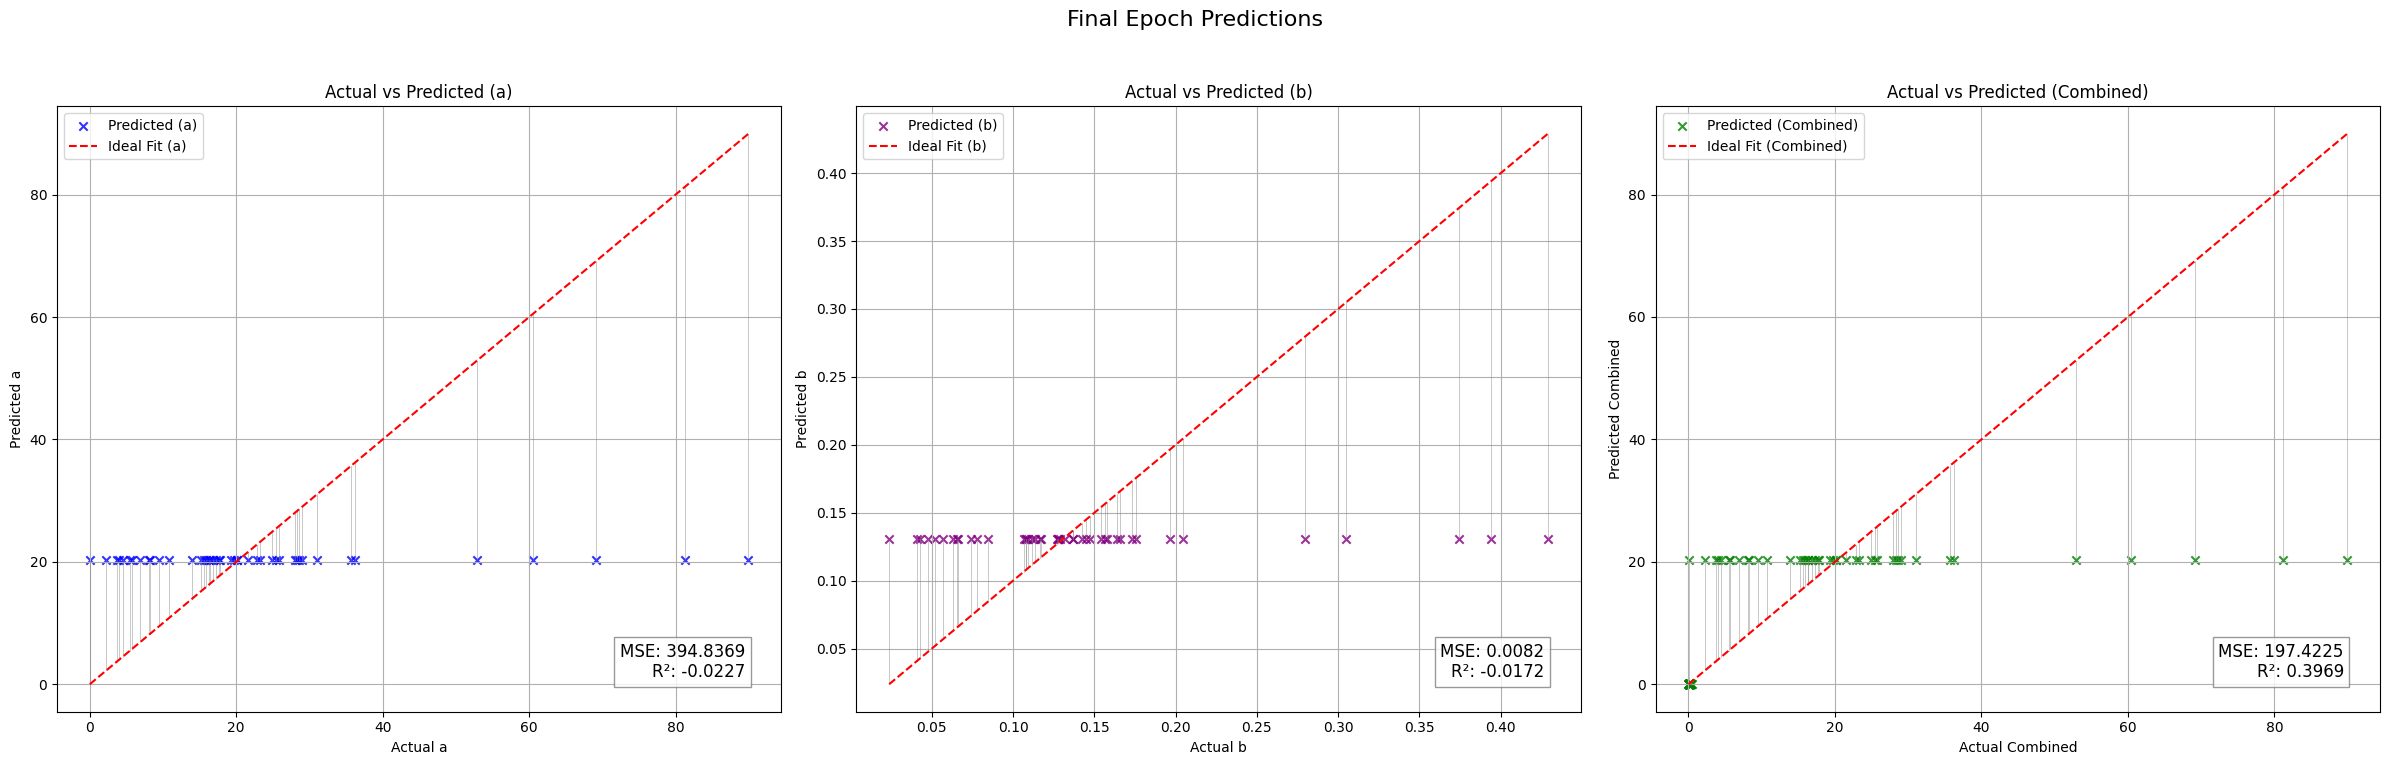

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 196.4573
  - R²: -0.0172
  - MAE: 6.4845
  - Explained Variance Score (EVS): -0.0001
Fold 1 Metrics:
  - Validation Loss (MSE): 196.4573
  - R²: -0.0172
  - MAE: 6.4845
  - EVS: -0.0001
Fold 2/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 81.38it/s, loss=0.412]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 99.8749
  - R²: -0.1798
  - MAE: 6.0174
  - Explained Variance Score (EVS): 0.0002
Epoch [1/50], Train Loss: 0.5074, Val Loss: 99.8749
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 79.98it/s, loss=0.481]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 99.4728
  - R²: -0.1766
  - MAE: 5.9993
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.4662, Val Loss: 99.4728
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 84.75it/s, loss=0.405]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 99.0185
  - R²: -0.1739
  - MAE: 5.9798
  - Explained Variance Score (EVS): 0.0004
Epoch [3/50], Train Loss: 0.4037, Val Loss: 99.0185
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 81.21it/s, loss=0.36]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.7064
  - R²: -0.1718
  - MAE: 5.9661
  - Explained Variance Score (EVS): 0.0008
Epoch [4/50], Train Loss: 0.3951, Val Loss: 98.7064
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 86.24it/s, loss=0.419]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.5891
  - R²: -0.1713
  - MAE: 5.9603
  - Explained Variance Score (EVS): 0.0003
Epoch [5/50], Train Loss: 0.3970, Val Loss: 98.5891
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 80.42it/s, loss=0.472]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3902
  - R²: -0.1711
  - MAE: 5.9519
  - Explained Variance Score (EVS): 0.0003
Epoch [6/50], Train Loss: 0.4078, Val Loss: 98.3902
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 74.14it/s, loss=0.381]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.4316
  - R²: -0.1714
  - MAE: 5.9532
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3950, Val Loss: 98.4316
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 56.96it/s, loss=0.32]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3069
  - R²: -0.1704
  - MAE: 5.9482
  - Explained Variance Score (EVS): 0.0007
Epoch [8/50], Train Loss: 0.3929, Val Loss: 98.3069
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 66.04it/s, loss=0.405]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3142
  - R²: -0.1707
  - MAE: 5.9486
  - Explained Variance Score (EVS): 0.0003
Epoch [9/50], Train Loss: 0.4030, Val Loss: 98.3142
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 62.76it/s, loss=0.35]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3201
  - R²: -0.1707
  - MAE: 5.9488
  - Explained Variance Score (EVS): 0.0002
Epoch [10/50], Train Loss: 0.3959, Val Loss: 98.3201
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 61.60it/s, loss=0.344]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3258
  - R²: -0.1704
  - MAE: 5.9491
  - Explained Variance Score (EVS): 0.0007
Epoch [11/50], Train Loss: 0.3969, Val Loss: 98.3258
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00, 61.25it/s, loss=0.287]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): 0.0000
Epoch [12/50], Train Loss: 0.3922, Val Loss: 98.3532
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00, 65.23it/s, loss=0.462]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1705
  - MAE: 5.9496
  - Explained Variance Score (EVS): 0.0006
Epoch [13/50], Train Loss: 0.4066, Val Loss: 98.3532
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00, 77.77it/s, loss=0.334]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): 0.0001
Epoch [14/50], Train Loss: 0.3938, Val Loss: 98.3532
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 3/3 [00:00<00:00, 72.60it/s, loss=0.337]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1705
  - MAE: 5.9496
  - Explained Variance Score (EVS): 0.0007
Epoch [15/50], Train Loss: 0.3945, Val Loss: 98.3532
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 3/3 [00:00<00:00, 74.76it/s, loss=0.469]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3177
  - R²: -0.1703
  - MAE: 5.9486
  - Explained Variance Score (EVS): 0.0009
Epoch [16/50], Train Loss: 0.4045, Val Loss: 98.3177
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 3/3 [00:00<00:00, 75.75it/s, loss=0.435]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3306
  - R²: -0.1704
  - MAE: 5.9493
  - Explained Variance Score (EVS): 0.0008
Epoch [17/50], Train Loss: 0.4015, Val Loss: 98.3306
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 3/3 [00:00<00:00, 66.60it/s, loss=0.453]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 98.3330
  - R²: -0.1704
  - MAE: 5.9486
  - Explained Variance Score (EVS): 0.0008
Epoch [18/50], Train Loss: 0.4026, Val Loss: 98.3330
Current Dropout Rate: 0.3640
Early stopping triggered!
Loading the best model for evaluation...


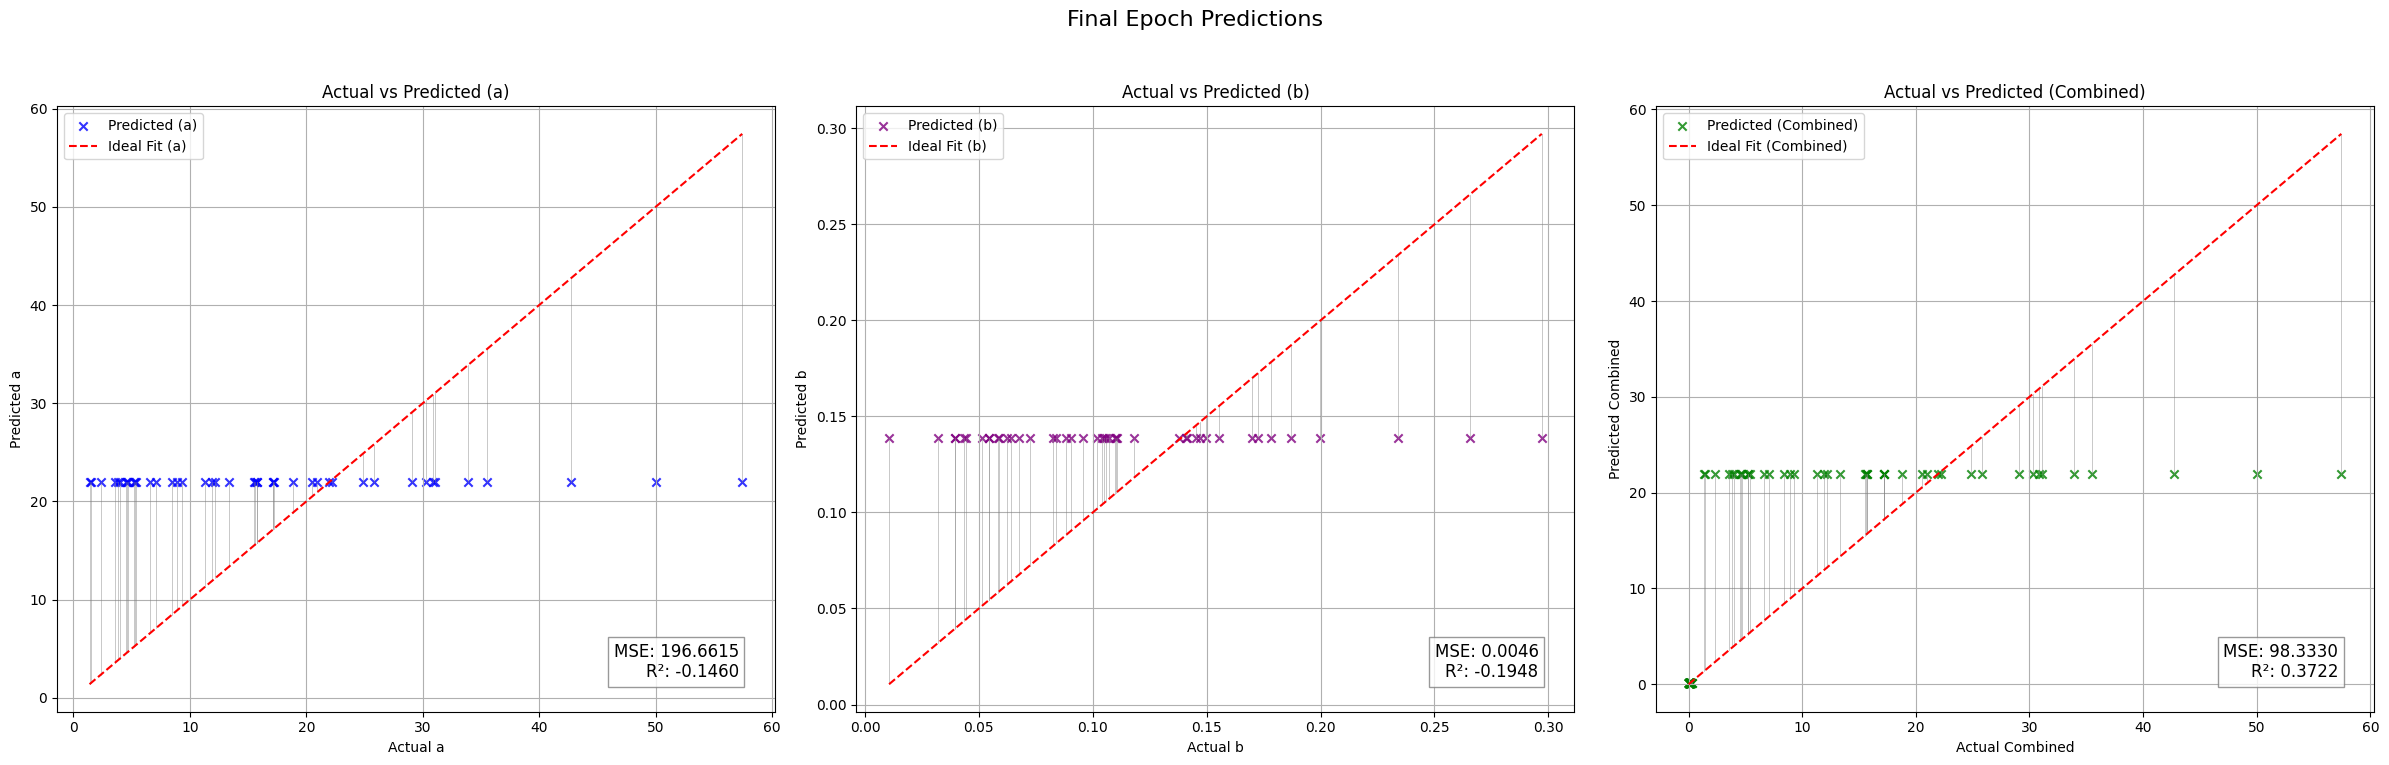

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 98.3069
  - R²: -0.1704
  - MAE: 5.9482
  - Explained Variance Score (EVS): 0.0007
Fold 2 Metrics:
  - Validation Loss (MSE): 98.3069
  - R²: -0.1704
  - MAE: 5.9482
  - EVS: 0.0007
Fold 3/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 79.01it/s, loss=0.475]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3999, Val Loss: 111.2861
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 78.81it/s, loss=0.431]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3988, Val Loss: 111.2861
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 72.26it/s, loss=0.314]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.3919, Val Loss: 111.2861
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 73.39it/s, loss=0.39]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.3990, Val Loss: 111.2861
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 74.02it/s, loss=0.439]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.4031, Val Loss: 111.2861
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 69.57it/s, loss=0.392]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.3981, Val Loss: 111.2861
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 63.20it/s, loss=0.5]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.4076, Val Loss: 111.2861
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 68.31it/s, loss=0.339]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.3935, Val Loss: 111.2861
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 75.66it/s, loss=0.382]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.3969, Val Loss: 111.2861
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 74.22it/s, loss=0.332]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3914, Val Loss: 111.2861
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 74.76it/s, loss=0.415]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.3979, Val Loss: 111.2861
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


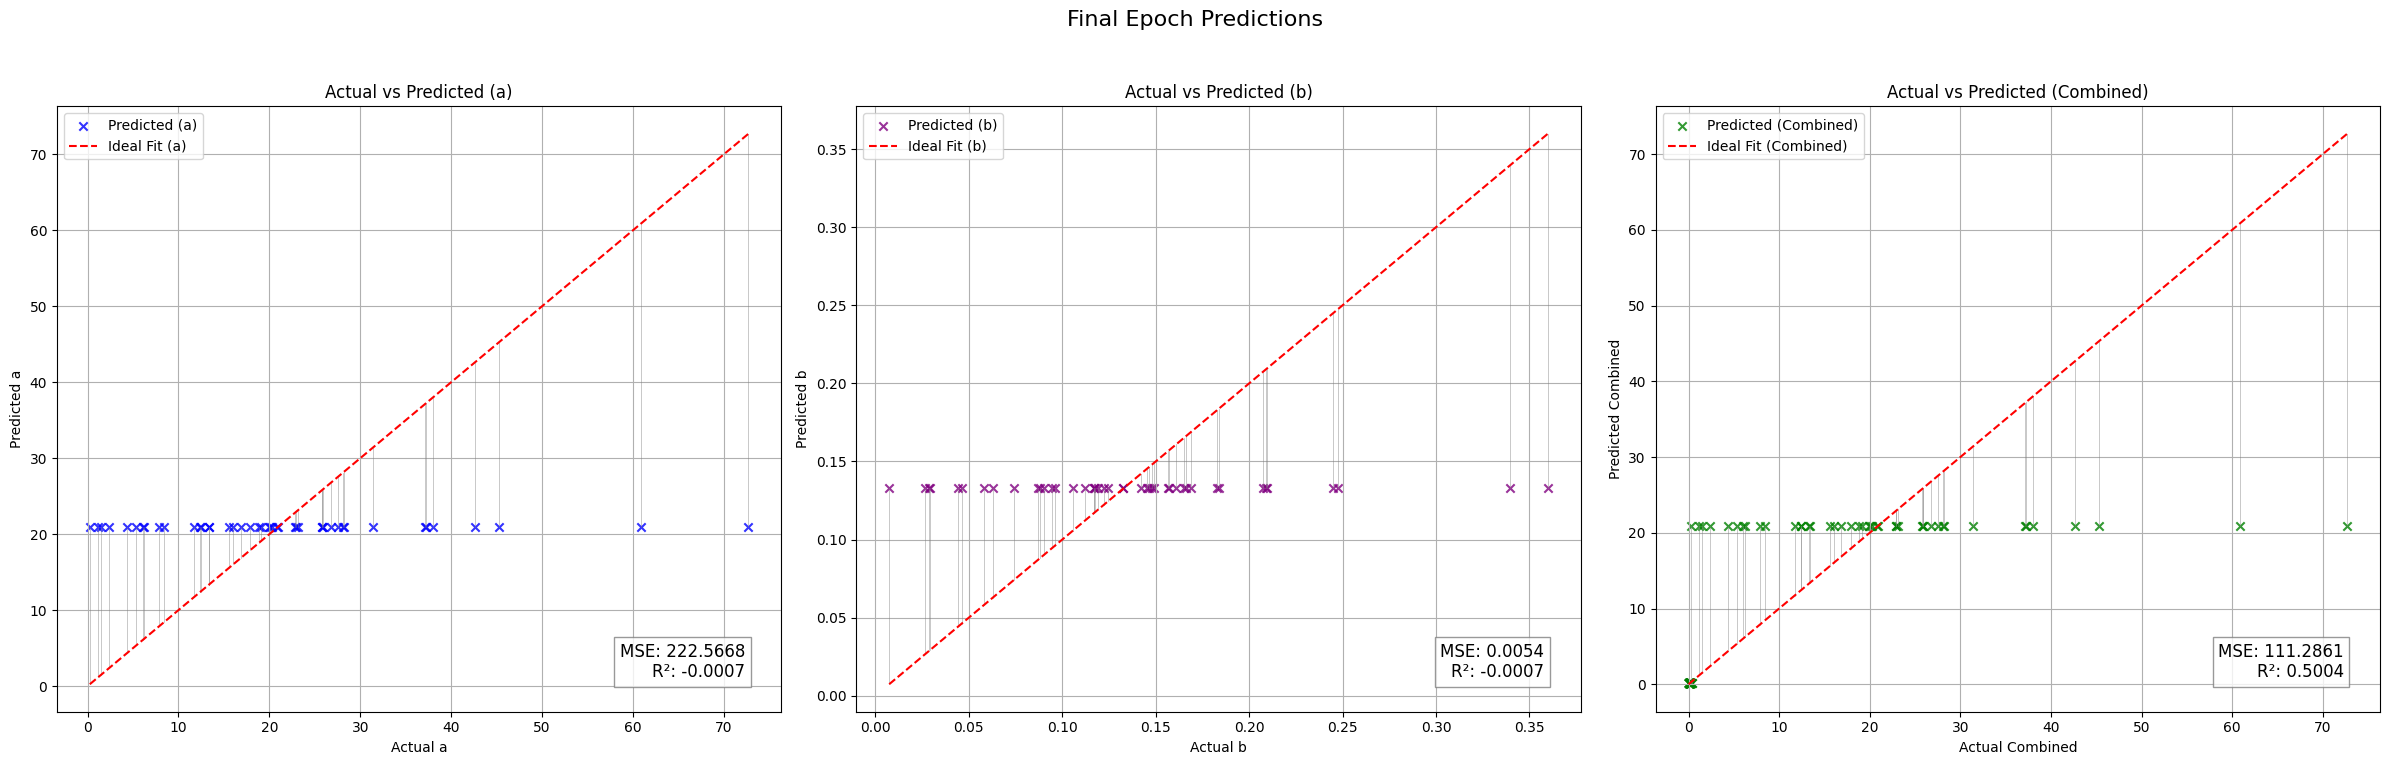

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Fold 3 Metrics:
  - Validation Loss (MSE): 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - EVS: -0.0000
Fold 4/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 85.47it/s, loss=0.414]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0090
  - R²: -0.0028
  - MAE: 5.9028
  - Explained Variance Score (EVS): 0.0002
Epoch [1/50], Train Loss: 0.4030, Val Loss: 94.0090
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 72.30it/s, loss=0.251]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3967, Val Loss: 94.0374
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 70.13it/s, loss=0.392]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.4088, Val Loss: 94.0374
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 67.90it/s, loss=0.433]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.4129, Val Loss: 94.0374
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 81.37it/s, loss=0.326]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.4031, Val Loss: 94.0374
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 82.46it/s, loss=0.399]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.4100, Val Loss: 94.0374
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 79.02it/s, loss=0.473]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0294
  - R²: -0.0029
  - MAE: 5.9035
  - Explained Variance Score (EVS): 0.0000
Epoch [7/50], Train Loss: 0.4158, Val Loss: 94.0294
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 79.02it/s, loss=0.393]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.4085, Val Loss: 94.0374
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 80.23it/s, loss=0.277]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0225
  - R²: -0.0029
  - MAE: 5.9033
  - Explained Variance Score (EVS): 0.0001
Epoch [9/50], Train Loss: 0.3972, Val Loss: 94.0225
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 82.08it/s, loss=0.445]

Validation Metrics:
  - MSE: 94.0057
  - R²: -0.0028
  - MAE: 5.9026
  - Explained Variance Score (EVS): 0.0002
Epoch [10/50], Train Loss: 0.4123, Val Loss: 94.0057
Current Dropout Rate: 0.4280



<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 76.85it/s, loss=0.556]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0090
  - R²: -0.0028
  - MAE: 5.9028
  - Explained Variance Score (EVS): 0.0002
Epoch [11/50], Train Loss: 0.4197, Val Loss: 94.0090
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00, 72.81it/s, loss=0.476]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0062
  - R²: -0.0028
  - MAE: 5.9028
  - Explained Variance Score (EVS): 0.0002
Epoch [12/50], Train Loss: 0.4110, Val Loss: 94.0062
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00, 83.60it/s, loss=0.474]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9975
  - R²: -0.0027
  - MAE: 5.9024
  - Explained Variance Score (EVS): 0.0002
Epoch [13/50], Train Loss: 0.4105, Val Loss: 93.9975
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00, 54.80it/s, loss=0.47]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9798
  - R²: -0.0026
  - MAE: 5.9020
  - Explained Variance Score (EVS): 0.0003
Epoch [14/50], Train Loss: 0.4100, Val Loss: 93.9798
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 3/3 [00:00<00:00, 61.79it/s, loss=0.535]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9670
  - R²: -0.0025
  - MAE: 5.9019
  - Explained Variance Score (EVS): 0.0005
Epoch [15/50], Train Loss: 0.4154, Val Loss: 93.9670
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 3/3 [00:00<00:00, 67.12it/s, loss=0.406]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9581
  - R²: -0.0024
  - MAE: 5.9015
  - Explained Variance Score (EVS): 0.0005
Epoch [16/50], Train Loss: 0.4034, Val Loss: 93.9581
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 3/3 [00:00<00:00, 61.91it/s, loss=0.459]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9413
  - R²: -0.0023
  - MAE: 5.9008
  - Explained Variance Score (EVS): 0.0006
Epoch [17/50], Train Loss: 0.4081, Val Loss: 93.9413
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 3/3 [00:00<00:00, 61.51it/s, loss=0.534]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.8836
  - R²: -0.0018
  - MAE: 5.8994
  - Explained Variance Score (EVS): 0.0012
Epoch [18/50], Train Loss: 0.4143, Val Loss: 93.8836
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 3/3 [00:00<00:00, 62.48it/s, loss=0.384]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.8432
  - R²: -0.0016
  - MAE: 5.8978
  - Explained Variance Score (EVS): 0.0013
Epoch [19/50], Train Loss: 0.4007, Val Loss: 93.8432
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 3/3 [00:00<00:00, 61.73it/s, loss=0.547]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.8053
  - R²: -0.0013
  - MAE: 5.8965
  - Explained Variance Score (EVS): 0.0016
Epoch [20/50], Train Loss: 0.4147, Val Loss: 93.8053
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 3/3 [00:00<00:00, 65.38it/s, loss=0.505]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.7138
  - R²: -0.0006
  - MAE: 5.8935
  - Explained Variance Score (EVS): 0.0023
Epoch [21/50], Train Loss: 0.4110, Val Loss: 93.7138
Current Dropout Rate: 0.3400


Epoch 22/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 3/3 [00:00<00:00, 59.94it/s, loss=0.369]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.5924
  - R²: 0.0003
  - MAE: 5.8899
  - Explained Variance Score (EVS): 0.0033
Epoch [22/50], Train Loss: 0.3981, Val Loss: 93.5924
Current Dropout Rate: 0.3320


Epoch 23/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 3/3 [00:00<00:00, 69.12it/s, loss=0.465]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.5071
  - R²: 0.0008
  - MAE: 5.8874
  - Explained Variance Score (EVS): 0.0038
Epoch [23/50], Train Loss: 0.4063, Val Loss: 93.5071
Current Dropout Rate: 0.3240


Epoch 24/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24/50: 100%|██████████| 3/3 [00:00<00:00, 66.62it/s, loss=0.416]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.3820
  - R²: 0.0018
  - MAE: 5.8824
  - Explained Variance Score (EVS): 0.0048
Epoch [24/50], Train Loss: 0.4018, Val Loss: 93.3820
Current Dropout Rate: 0.3160


Epoch 25/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25/50: 100%|██████████| 3/3 [00:00<00:00, 62.41it/s, loss=0.499]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.2328
  - R²: 0.0029
  - MAE: 5.8780
  - Explained Variance Score (EVS): 0.0059
Epoch [25/50], Train Loss: 0.4090, Val Loss: 93.2328
Current Dropout Rate: 0.3080


Epoch 26/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26/50: 100%|██████████| 3/3 [00:00<00:00, 61.62it/s, loss=0.36]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.0911
  - R²: 0.0038
  - MAE: 5.8730
  - Explained Variance Score (EVS): 0.0068
Epoch [26/50], Train Loss: 0.3967, Val Loss: 93.0911
Current Dropout Rate: 0.3000


Epoch 27/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27/50: 100%|██████████| 3/3 [00:00<00:00, 67.58it/s, loss=0.338]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.9977
  - R²: 0.0046
  - MAE: 5.8699
  - Explained Variance Score (EVS): 0.0076
Epoch [27/50], Train Loss: 0.3945, Val Loss: 92.9977
Current Dropout Rate: 0.2920


Epoch 28/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28/50: 100%|██████████| 3/3 [00:00<00:00, 70.24it/s, loss=0.283]


Validation Metrics:
  - MSE: 92.8633
  - R²: 0.0054
  - MAE: 5.8660
  - Explained Variance Score (EVS): 0.0084
Epoch [28/50], Train Loss: 0.3894, Val Loss: 92.8633

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Current Dropout Rate: 0.2840


Epoch 29/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29/50: 100%|██████████| 3/3 [00:00<00:00, 70.41it/s, loss=0.429]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.7287
  - R²: 0.0064
  - MAE: 5.8608
  - Explained Variance Score (EVS): 0.0094
Epoch [29/50], Train Loss: 0.4022, Val Loss: 92.7287
Current Dropout Rate: 0.2760


Epoch 30/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/50: 100%|██████████| 3/3 [00:00<00:00, 67.11it/s, loss=0.411]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.6621
  - R²: 0.0069
  - MAE: 5.8587
  - Explained Variance Score (EVS): 0.0100
Epoch [30/50], Train Loss: 0.4008, Val Loss: 92.6621
Current Dropout Rate: 0.2680


Epoch 31/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31/50: 100%|██████████| 3/3 [00:00<00:00, 72.61it/s, loss=0.385]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.5810
  - R²: 0.0075
  - MAE: 5.8560
  - Explained Variance Score (EVS): 0.0106
Epoch [31/50], Train Loss: 0.3979, Val Loss: 92.5810
Current Dropout Rate: 0.2600


Epoch 32/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32/50: 100%|██████████| 3/3 [00:00<00:00, 65.67it/s, loss=0.613]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.5042
  - R²: 0.0081
  - MAE: 5.8533
  - Explained Variance Score (EVS): 0.0111
Epoch [32/50], Train Loss: 0.4181, Val Loss: 92.5042
Current Dropout Rate: 0.2520


Epoch 33/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33/50: 100%|██████████| 3/3 [00:00<00:00, 71.42it/s, loss=0.32]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.4673
  - R²: 0.0085
  - MAE: 5.8523
  - Explained Variance Score (EVS): 0.0115
Epoch [33/50], Train Loss: 0.3921, Val Loss: 92.4673
Current Dropout Rate: 0.2440


Epoch 34/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34/50: 100%|██████████| 3/3 [00:00<00:00, 66.11it/s, loss=0.39]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.4461
  - R²: 0.0085
  - MAE: 5.8512
  - Explained Variance Score (EVS): 0.0116
Epoch [34/50], Train Loss: 0.3983, Val Loss: 92.4461
Current Dropout Rate: 0.2360


Epoch 35/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35/50: 100%|██████████| 3/3 [00:00<00:00, 57.94it/s, loss=0.312]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.4120
  - R²: 0.0088
  - MAE: 5.8494
  - Explained Variance Score (EVS): 0.0119
Epoch [35/50], Train Loss: 0.3911, Val Loss: 92.4120
Current Dropout Rate: 0.2280


Epoch 36/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36/50: 100%|██████████| 3/3 [00:00<00:00, 57.09it/s, loss=0.229]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.3852
  - R²: 0.0088
  - MAE: 5.8489
  - Explained Variance Score (EVS): 0.0119
Epoch [36/50], Train Loss: 0.3838, Val Loss: 92.3852
Current Dropout Rate: 0.2200


Epoch 37/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37/50: 100%|██████████| 3/3 [00:00<00:00, 54.76it/s, loss=0.337]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.3697
  - R²: 0.0090
  - MAE: 5.8485
  - Explained Variance Score (EVS): 0.0120
Epoch [37/50], Train Loss: 0.3933, Val Loss: 92.3697
Current Dropout Rate: 0.2120


Epoch 38/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38/50: 100%|██████████| 3/3 [00:00<00:00, 59.21it/s, loss=0.382]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.3751
  - R²: 0.0090
  - MAE: 5.8489
  - Explained Variance Score (EVS): 0.0120
Epoch [38/50], Train Loss: 0.3973, Val Loss: 92.3751
Current Dropout Rate: 0.2040


Epoch 39/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39/50: 100%|██████████| 3/3 [00:00<00:00, 60.23it/s, loss=0.459]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.3701
  - R²: 0.0090
  - MAE: 5.8483
  - Explained Variance Score (EVS): 0.0121
Epoch [39/50], Train Loss: 0.4041, Val Loss: 92.3701
Current Dropout Rate: 0.1960


Epoch 40/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40/50: 100%|██████████| 3/3 [00:00<00:00, 74.87it/s, loss=0.544]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.3750
  - R²: 0.0090
  - MAE: 5.8489
  - Explained Variance Score (EVS): 0.0120
Epoch [40/50], Train Loss: 0.4115, Val Loss: 92.3750
Current Dropout Rate: 0.1880


Epoch 41/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41/50: 100%|██████████| 3/3 [00:00<00:00, 64.91it/s, loss=0.462]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.3928
  - R²: 0.0088
  - MAE: 5.8487
  - Explained Variance Score (EVS): 0.0119
Epoch [41/50], Train Loss: 0.4042, Val Loss: 92.3928
Current Dropout Rate: 0.1800


Epoch 42/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42/50: 100%|██████████| 3/3 [00:00<00:00, 66.61it/s, loss=0.309]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.3992
  - R²: 0.0088
  - MAE: 5.8491
  - Explained Variance Score (EVS): 0.0118
Epoch [42/50], Train Loss: 0.3906, Val Loss: 92.3992
Current Dropout Rate: 0.1720


Epoch 43/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43/50: 100%|██████████| 3/3 [00:00<00:00, 60.47it/s, loss=0.46]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.4013
  - R²: 0.0088
  - MAE: 5.8498
  - Explained Variance Score (EVS): 0.0119
Epoch [43/50], Train Loss: 0.4039, Val Loss: 92.4013
Current Dropout Rate: 0.1640


Epoch 44/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44/50: 100%|██████████| 3/3 [00:00<00:00, 65.79it/s, loss=0.515]

Validation Metrics:
  - MSE: 92.3952
  - R²: 0.0088
  - MAE: 5.8496
  - Explained Variance Score (EVS): 0.0119
Epoch [44/50], Train Loss: 0.4086, Val Loss: 92.3952
Current Dropout Rate: 0.1560



<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45/50: 100%|██████████| 3/3 [00:00<00:00, 57.07it/s, loss=0.254]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.4355
  - R²: 0.0087
  - MAE: 5.8506
  - Explained Variance Score (EVS): 0.0118
Epoch [45/50], Train Loss: 0.3856, Val Loss: 92.4355
Current Dropout Rate: 0.1480


Epoch 46/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46/50: 100%|██████████| 3/3 [00:00<00:00, 66.36it/s, loss=0.293]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.4409
  - R²: 0.0085
  - MAE: 5.8508
  - Explained Variance Score (EVS): 0.0115
Epoch [46/50], Train Loss: 0.3889, Val Loss: 92.4409
Current Dropout Rate: 0.1400


Epoch 47/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47/50: 100%|██████████| 3/3 [00:00<00:00, 53.88it/s, loss=0.393]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 92.4358
  - R²: 0.0086
  - MAE: 5.8512
  - Explained Variance Score (EVS): 0.0116
Epoch [47/50], Train Loss: 0.3976, Val Loss: 92.4358
Current Dropout Rate: 0.1320


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


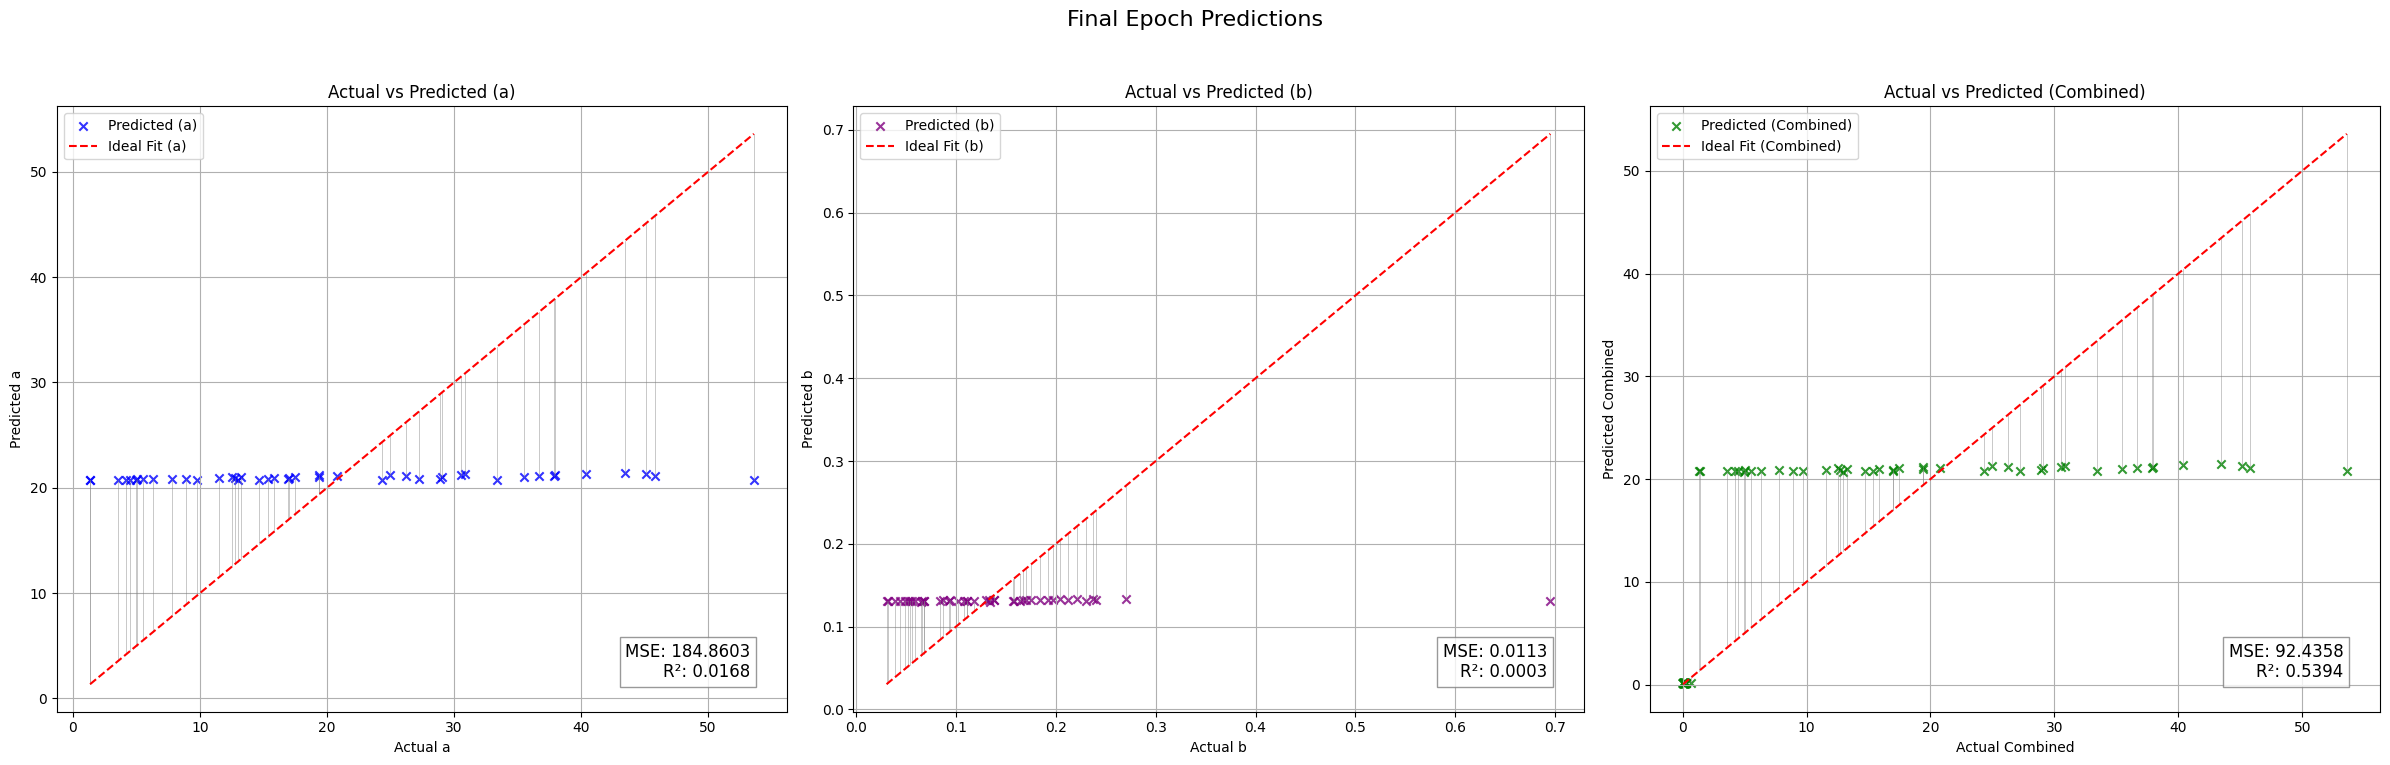

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 92.3697
  - R²: 0.0090
  - MAE: 5.8485
  - Explained Variance Score (EVS): 0.0120
Fold 4 Metrics:
  - Validation Loss (MSE): 92.3697
  - R²: 0.0090
  - MAE: 5.8485
  - EVS: 0.0120
Fold 5/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 55.23it/s, loss=0.327]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 180.5964
  - R²: 0.0049
  - MAE: 6.6934
  - Explained Variance Score (EVS): 0.0123
Epoch [1/50], Train Loss: 0.3923, Val Loss: 180.5964
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 64.28it/s, loss=0.361]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 181.1563
  - R²: 0.0017
  - MAE: 6.7070
  - Explained Variance Score (EVS): 0.0092
Epoch [2/50], Train Loss: 0.3964, Val Loss: 181.1563
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 69.65it/s, loss=0.342]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 181.4627
  - R²: -0.0000
  - MAE: 6.7150
  - Explained Variance Score (EVS): 0.0075
Epoch [3/50], Train Loss: 0.3957, Val Loss: 181.4627
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 62.49it/s, loss=0.364]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 181.6424
  - R²: -0.0013
  - MAE: 6.7207
  - Explained Variance Score (EVS): 0.0062
Epoch [4/50], Train Loss: 0.3980, Val Loss: 181.6424
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 50.63it/s, loss=0.35]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 181.7564
  - R²: -0.0019
  - MAE: 6.7249
  - Explained Variance Score (EVS): 0.0055
Epoch [5/50], Train Loss: 0.3973, Val Loss: 181.7564
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 58.81it/s, loss=0.288]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 181.8830
  - R²: -0.0024
  - MAE: 6.7280
  - Explained Variance Score (EVS): 0.0050
Epoch [6/50], Train Loss: 0.3922, Val Loss: 181.8830
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 52.67it/s, loss=0.465]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 181.9538
  - R²: -0.0030
  - MAE: 6.7311
  - Explained Variance Score (EVS): 0.0044
Epoch [7/50], Train Loss: 0.4072, Val Loss: 181.9538
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 71.37it/s, loss=0.255]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 181.9924
  - R²: -0.0031
  - MAE: 6.7325
  - Explained Variance Score (EVS): 0.0042
Epoch [8/50], Train Loss: 0.3898, Val Loss: 181.9924
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 57.63it/s, loss=0.466]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.0363
  - R²: -0.0033
  - MAE: 6.7347
  - Explained Variance Score (EVS): 0.0040
Epoch [9/50], Train Loss: 0.4075, Val Loss: 182.0363
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 73.87it/s, loss=0.5]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.0488
  - R²: -0.0034
  - MAE: 6.7353
  - Explained Variance Score (EVS): 0.0039
Epoch [10/50], Train Loss: 0.4104, Val Loss: 182.0488
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 60.07it/s, loss=0.411]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 182.0722
  - R²: -0.0040
  - MAE: 6.7360
  - Explained Variance Score (EVS): 0.0033
Epoch [11/50], Train Loss: 0.4030, Val Loss: 182.0722
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


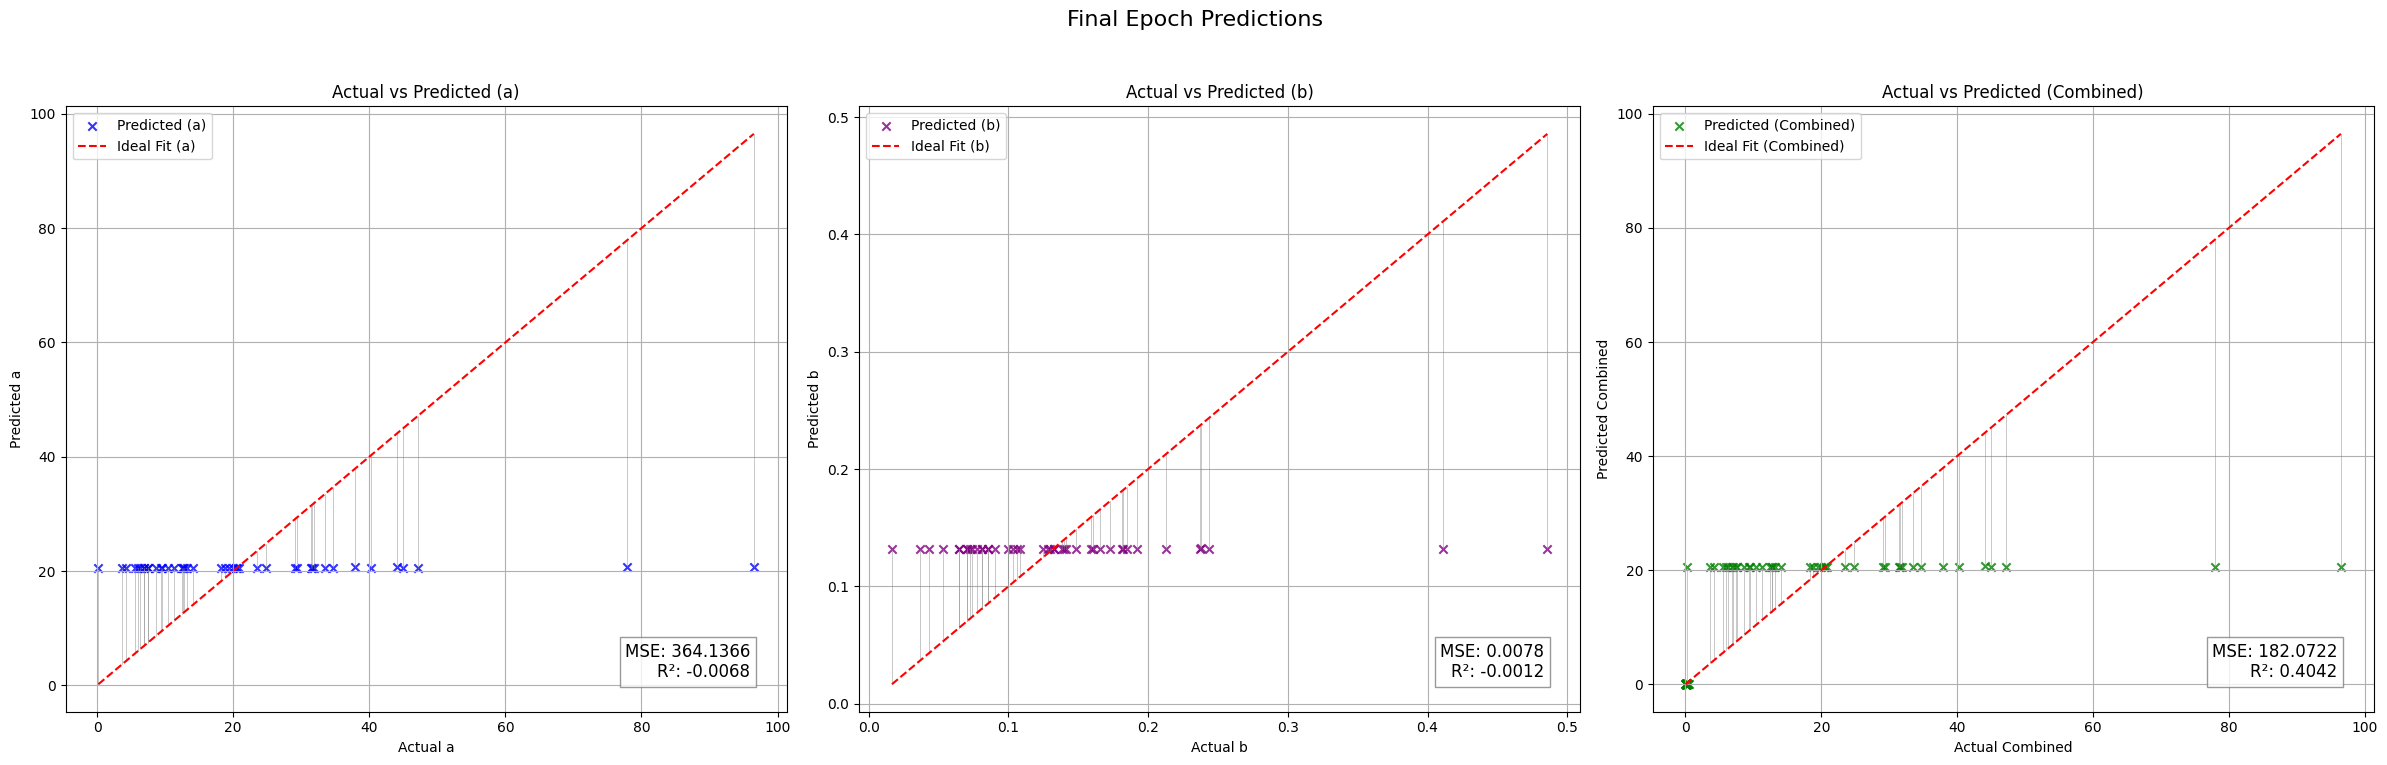

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[I 2024-11-30 07:26:48,760] Trial 2 finished with value: 135.8032684326172 and parameters: {'num_layers': 2, 'hidden_size_0': 120, 'activation_0': 'ELU', 'dropout_0': 0.3799976968620752, 'hidden_size_1': 282, 'activation_1': 'LeakyReLU', 'dropout_1': 0.22898243548079011, 'batch_size': 64, 'learning_rate': 0.0019291195983963656, 'optimizer': 'Adagrad'}. Best is trial 2 with value: 135.8032684326172.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-11-452298e7c718>:709: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython

Validation Metrics:
  - MSE: 180.5964
  - R²: 0.0049
  - MAE: 6.6934
  - Explained Variance Score (EVS): 0.0123
Fold 5 Metrics:
  - Validation Loss (MSE): 180.5964
  - R²: 0.0049
  - MAE: 6.6934
  - EVS: 0.0123
Avg Validation Metrics:
  - MSE: 135.8033
  - R²: -0.0349
  - MAE: 6.0828
  - EVS: 0.0050
Using device: cuda
Fold 1/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 78.79it/s, loss=1.08]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.6046
  - R²: -0.0235
  - MAE: 6.4426
  - Explained Variance Score (EVS): 0.0031
Epoch [1/50], Train Loss: 1.1671, Val Loss: 197.6046
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 84.50it/s, loss=1.06]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.6769
  - R²: -0.0251
  - MAE: 6.4396
  - Explained Variance Score (EVS): 0.0020
Epoch [2/50], Train Loss: 1.0369, Val Loss: 197.6769
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 76.79it/s, loss=0.772]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.6048
  - R²: -0.0257
  - MAE: 6.4461
  - Explained Variance Score (EVS): 0.0008
Epoch [3/50], Train Loss: 0.8559, Val Loss: 197.6048
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 84.43it/s, loss=0.645]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.6295
  - R²: -0.0257
  - MAE: 6.4481
  - Explained Variance Score (EVS): 0.0003
Epoch [4/50], Train Loss: 0.7183, Val Loss: 197.6295
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 80.14it/s, loss=0.747]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.7719
  - R²: -0.0258
  - MAE: 6.4527
  - Explained Variance Score (EVS): -0.0004
Epoch [5/50], Train Loss: 0.6768, Val Loss: 197.7719
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 76.15it/s, loss=0.547]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.8390
  - R²: -0.0255
  - MAE: 6.4561
  - Explained Variance Score (EVS): -0.0008
Epoch [6/50], Train Loss: 0.5847, Val Loss: 197.8390
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 68.67it/s, loss=0.561]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.7757
  - R²: -0.0253
  - MAE: 6.4550
  - Explained Variance Score (EVS): -0.0011
Epoch [7/50], Train Loss: 0.5393, Val Loss: 197.7757
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 69.99it/s, loss=0.551]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.6545
  - R²: -0.0246
  - MAE: 6.4529
  - Explained Variance Score (EVS): -0.0008
Epoch [8/50], Train Loss: 0.5258, Val Loss: 197.6545
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 71.28it/s, loss=0.474]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3710
  - R²: -0.0236
  - MAE: 6.4497
  - Explained Variance Score (EVS): -0.0001
Epoch [9/50], Train Loss: 0.4978, Val Loss: 197.3710
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 84.15it/s, loss=0.495]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.1744
  - R²: -0.0230
  - MAE: 6.4472
  - Explained Variance Score (EVS): 0.0002
Epoch [10/50], Train Loss: 0.5024, Val Loss: 197.1744
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 67.48it/s, loss=0.461]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.0338
  - R²: -0.0225
  - MAE: 6.4464
  - Explained Variance Score (EVS): 0.0005
Epoch [11/50], Train Loss: 0.4899, Val Loss: 197.0338
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00, 72.51it/s, loss=0.445]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9670
  - R²: -0.0220
  - MAE: 6.4457
  - Explained Variance Score (EVS): 0.0007
Epoch [12/50], Train Loss: 0.4838, Val Loss: 196.9670
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00, 85.70it/s, loss=0.423]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9675
  - R²: -0.0215
  - MAE: 6.4450
  - Explained Variance Score (EVS): 0.0009
Epoch [13/50], Train Loss: 0.4710, Val Loss: 196.9675
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00, 61.91it/s, loss=0.468]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9384
  - R²: -0.0209
  - MAE: 6.4441
  - Explained Variance Score (EVS): 0.0012
Epoch [14/50], Train Loss: 0.4551, Val Loss: 196.9384
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 3/3 [00:00<00:00, 69.54it/s, loss=0.404]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9235
  - R²: -0.0204
  - MAE: 6.4437
  - Explained Variance Score (EVS): 0.0015
Epoch [15/50], Train Loss: 0.4408, Val Loss: 196.9235
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 3/3 [00:00<00:00, 75.70it/s, loss=0.551]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9562
  - R²: -0.0197
  - MAE: 6.4432
  - Explained Variance Score (EVS): 0.0020
Epoch [16/50], Train Loss: 0.4386, Val Loss: 196.9562
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 3/3 [00:00<00:00, 74.93it/s, loss=0.434]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9582
  - R²: -0.0193
  - MAE: 6.4434
  - Explained Variance Score (EVS): 0.0021
Epoch [17/50], Train Loss: 0.4179, Val Loss: 196.9582
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 3/3 [00:00<00:00, 67.80it/s, loss=0.328]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9212
  - R²: -0.0186
  - MAE: 6.4430
  - Explained Variance Score (EVS): 0.0026
Epoch [18/50], Train Loss: 0.4028, Val Loss: 196.9212
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 3/3 [00:00<00:00, 78.00it/s, loss=0.393]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9292
  - R²: -0.0184
  - MAE: 6.4432
  - Explained Variance Score (EVS): 0.0026
Epoch [19/50], Train Loss: 0.4048, Val Loss: 196.9292
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 3/3 [00:00<00:00, 77.04it/s, loss=0.404]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9672
  - R²: -0.0184
  - MAE: 6.4432
  - Explained Variance Score (EVS): 0.0025
Epoch [20/50], Train Loss: 0.4054, Val Loss: 196.9672
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 3/3 [00:00<00:00, 65.55it/s, loss=0.279]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.9576
  - R²: -0.0185
  - MAE: 6.4432
  - Explained Variance Score (EVS): 0.0022
Epoch [21/50], Train Loss: 0.3945, Val Loss: 196.9576
Current Dropout Rate: 0.3400


Epoch 22/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 3/3 [00:00<00:00, 70.85it/s, loss=0.389]


Validation Metrics:
  - MSE: 197.0207
  - R²: -0.0185
  - MAE: 6.4430
  - Explained Variance Score (EVS): 0.0021


<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [22/50], Train Loss: 0.4045, Val Loss: 197.0207
Current Dropout Rate: 0.3320


Epoch 23/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 3/3 [00:00<00:00, 64.23it/s, loss=0.421]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.0793
  - R²: -0.0187
  - MAE: 6.4430
  - Explained Variance Score (EVS): 0.0018
Epoch [23/50], Train Loss: 0.4072, Val Loss: 197.0793
Current Dropout Rate: 0.3240


Epoch 24/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24/50: 100%|██████████| 3/3 [00:00<00:00, 77.01it/s, loss=0.405]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.0896
  - R²: -0.0187
  - MAE: 6.4437
  - Explained Variance Score (EVS): 0.0016
Epoch [24/50], Train Loss: 0.4050, Val Loss: 197.0896
Current Dropout Rate: 0.3160


Epoch 25/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25/50: 100%|██████████| 3/3 [00:00<00:00, 64.29it/s, loss=0.453]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.1458
  - R²: -0.0189
  - MAE: 6.4450
  - Explained Variance Score (EVS): 0.0014
Epoch [25/50], Train Loss: 0.4080, Val Loss: 197.1458
Current Dropout Rate: 0.3080


Epoch 26/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26/50: 100%|██████████| 3/3 [00:00<00:00, 74.89it/s, loss=0.26]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.1879
  - R²: -0.0189
  - MAE: 6.4464
  - Explained Variance Score (EVS): 0.0013
Epoch [26/50], Train Loss: 0.3896, Val Loss: 197.1879
Current Dropout Rate: 0.3000


Epoch 27/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27/50: 100%|██████████| 3/3 [00:00<00:00, 80.33it/s, loss=0.429]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.1987
  - R²: -0.0189
  - MAE: 6.4475
  - Explained Variance Score (EVS): 0.0012
Epoch [27/50], Train Loss: 0.4034, Val Loss: 197.1987
Current Dropout Rate: 0.2920


Epoch 28/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28/50: 100%|██████████| 3/3 [00:00<00:00, 64.95it/s, loss=0.446]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.2045
  - R²: -0.0187
  - MAE: 6.4480
  - Explained Variance Score (EVS): 0.0012
Epoch [28/50], Train Loss: 0.4040, Val Loss: 197.2045
Current Dropout Rate: 0.2840


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


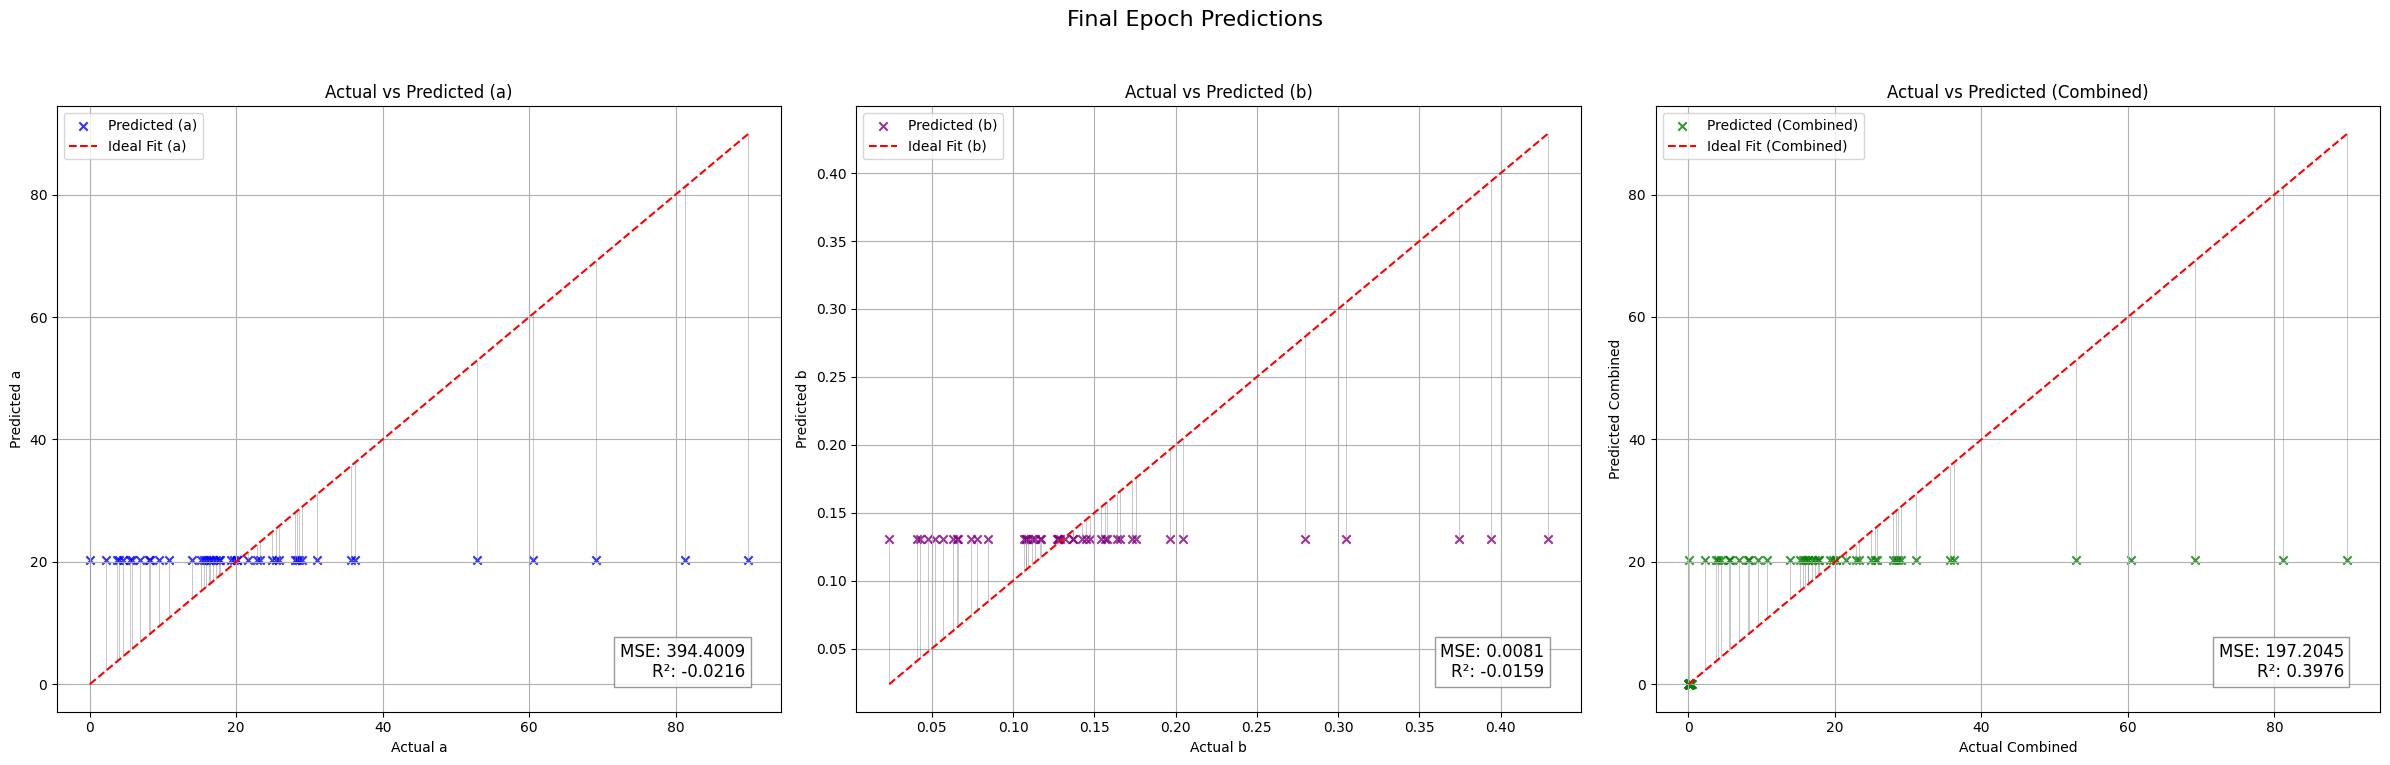

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 196.9212
  - R²: -0.0186
  - MAE: 6.4430
  - Explained Variance Score (EVS): 0.0026
Fold 1 Metrics:
  - Validation Loss (MSE): 196.9212
  - R²: -0.0186
  - MAE: 6.4430
  - EVS: 0.0026
Fold 2/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 88.02it/s, loss=0.421]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1175
  - R²: -0.1620
  - MAE: 5.9414
  - Explained Variance Score (EVS): 0.0028
Epoch [1/50], Train Loss: 0.4000, Val Loss: 98.1175
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 85.41it/s, loss=0.22]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1785
  - R²: -0.1633
  - MAE: 5.9425
  - Explained Variance Score (EVS): 0.0018
Epoch [2/50], Train Loss: 0.3828, Val Loss: 98.1785
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 81.83it/s, loss=0.33]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1741
  - R²: -0.1643
  - MAE: 5.9423
  - Explained Variance Score (EVS): 0.0014
Epoch [3/50], Train Loss: 0.3899, Val Loss: 98.1741
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 94.20it/s, loss=0.339] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1644
  - R²: -0.1652
  - MAE: 5.9423
  - Explained Variance Score (EVS): 0.0010
Epoch [4/50], Train Loss: 0.3884, Val Loss: 98.1644
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 96.51it/s, loss=0.464] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1641
  - R²: -0.1659
  - MAE: 5.9427
  - Explained Variance Score (EVS): 0.0011
Epoch [5/50], Train Loss: 0.3978, Val Loss: 98.1641
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 96.46it/s, loss=0.316] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1414
  - R²: -0.1661
  - MAE: 5.9429
  - Explained Variance Score (EVS): 0.0016
Epoch [6/50], Train Loss: 0.3854, Val Loss: 98.1414
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 95.29it/s, loss=0.384] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1786
  - R²: -0.1670
  - MAE: 5.9438
  - Explained Variance Score (EVS): 0.0015
Epoch [7/50], Train Loss: 0.3914, Val Loss: 98.1786
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 96.24it/s, loss=0.308] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.1700
  - R²: -0.1671
  - MAE: 5.9440
  - Explained Variance Score (EVS): 0.0018
Epoch [8/50], Train Loss: 0.3845, Val Loss: 98.1700
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 85.67it/s, loss=0.426]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2051
  - R²: -0.1679
  - MAE: 5.9453
  - Explained Variance Score (EVS): 0.0015
Epoch [9/50], Train Loss: 0.3943, Val Loss: 98.2051
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 92.80it/s, loss=0.371]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2509
  - R²: -0.1681
  - MAE: 5.9466
  - Explained Variance Score (EVS): 0.0017
Epoch [10/50], Train Loss: 0.3885, Val Loss: 98.2509
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 71.51it/s, loss=0.313]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2614
  - R²: -0.1691
  - MAE: 5.9469
  - Explained Variance Score (EVS): 0.0012
Epoch [11/50], Train Loss: 0.3825, Val Loss: 98.2614
Current Dropout Rate: 0.4200


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


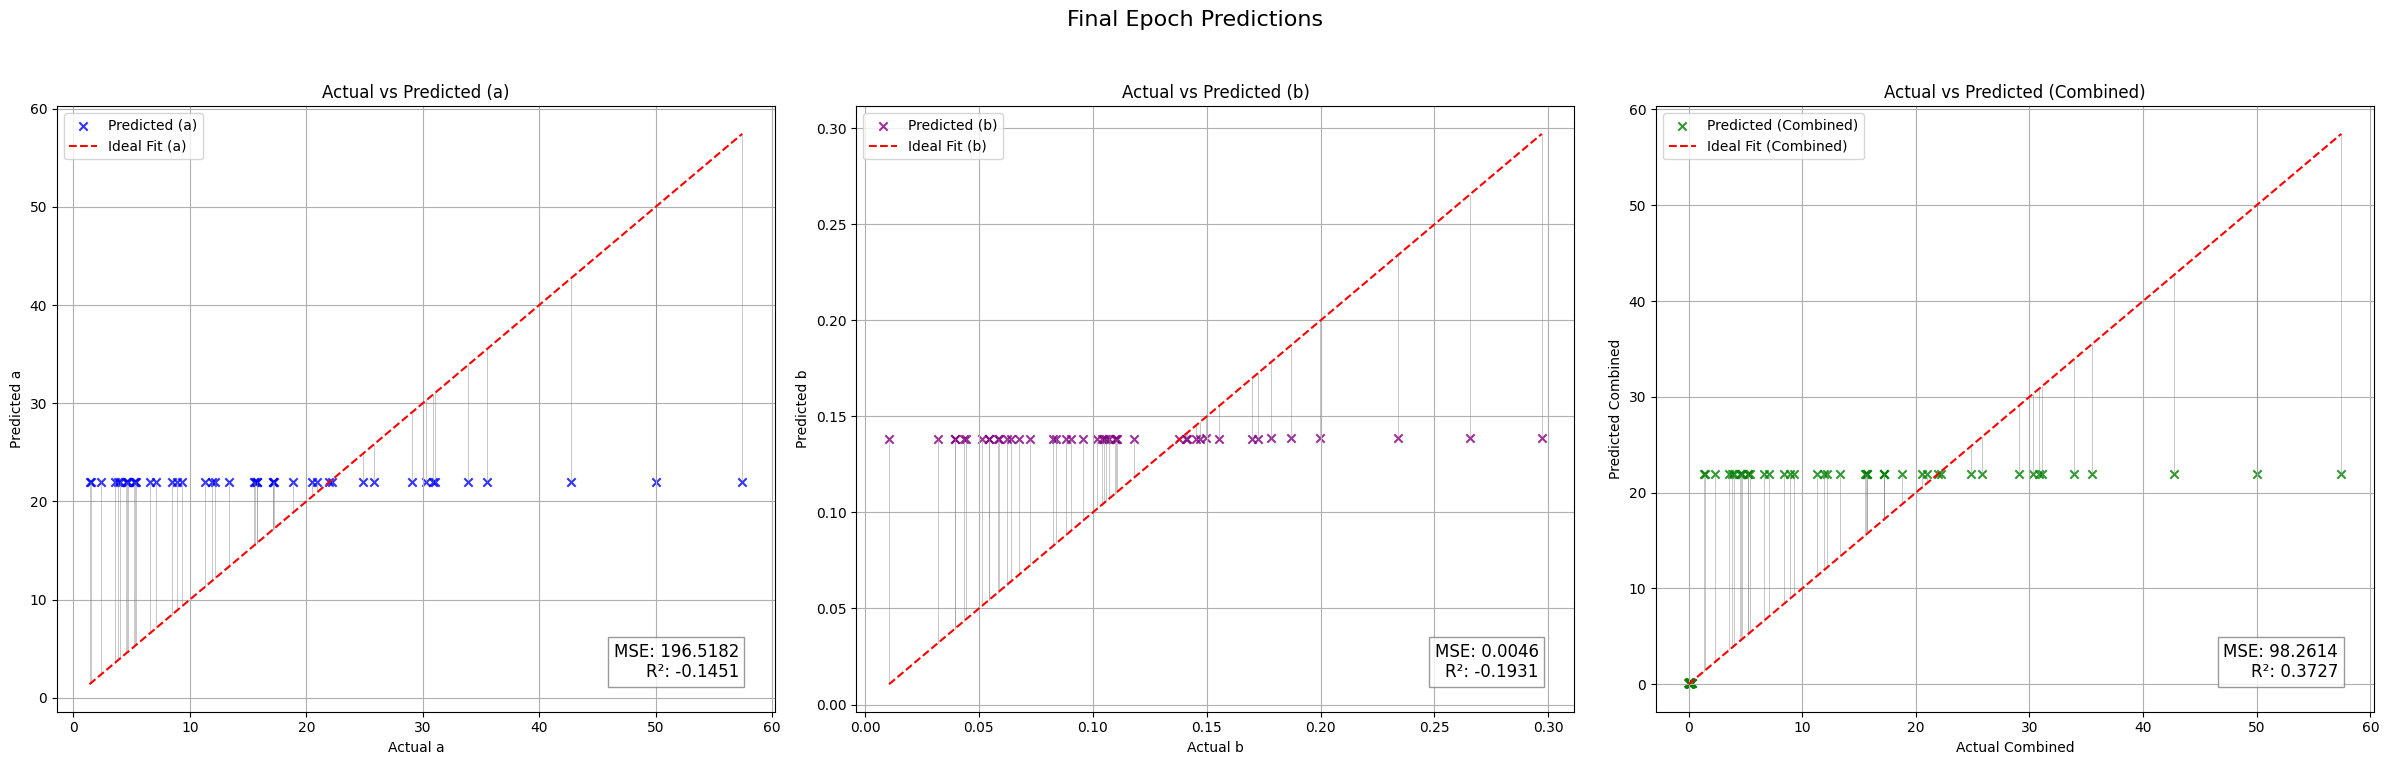

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 98.1175
  - R²: -0.1620
  - MAE: 5.9414
  - Explained Variance Score (EVS): 0.0028
Fold 2 Metrics:
  - Validation Loss (MSE): 98.1175
  - R²: -0.1620
  - MAE: 5.9414
  - EVS: 0.0028
Fold 3/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 81.90it/s, loss=0.367]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 110.9655
  - R²: 0.0017
  - MAE: 5.4288
  - Explained Variance Score (EVS): 0.0027
Epoch [1/50], Train Loss: 0.3937, Val Loss: 110.9655
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 82.35it/s, loss=0.348]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.0486
  - R²: 0.0011
  - MAE: 5.4308
  - Explained Variance Score (EVS): 0.0021
Epoch [2/50], Train Loss: 0.3887, Val Loss: 111.0486
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 87.71it/s, loss=0.471]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.0706
  - R²: 0.0009
  - MAE: 5.4317
  - Explained Variance Score (EVS): 0.0018
Epoch [3/50], Train Loss: 0.3971, Val Loss: 111.0706
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 62.31it/s, loss=0.41]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.1408
  - R²: 0.0004
  - MAE: 5.4333
  - Explained Variance Score (EVS): 0.0013
Epoch [4/50], Train Loss: 0.3893, Val Loss: 111.1408
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 83.06it/s, loss=0.451]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.1378
  - R²: 0.0003
  - MAE: 5.4328
  - Explained Variance Score (EVS): 0.0012
Epoch [5/50], Train Loss: 0.3925, Val Loss: 111.1378
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 72.31it/s, loss=0.316]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.1545
  - R²: 0.0002
  - MAE: 5.4334
  - Explained Variance Score (EVS): 0.0010
Epoch [6/50], Train Loss: 0.3819, Val Loss: 111.1545
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 71.99it/s, loss=0.394]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.1685
  - R²: 0.0003
  - MAE: 5.4344
  - Explained Variance Score (EVS): 0.0011
Epoch [7/50], Train Loss: 0.3896, Val Loss: 111.1685
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 66.41it/s, loss=0.501]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.1775
  - R²: 0.0002
  - MAE: 5.4348
  - Explained Variance Score (EVS): 0.0009
Epoch [8/50], Train Loss: 0.3993, Val Loss: 111.1775
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 71.03it/s, loss=0.378]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.1619
  - R²: 0.0003
  - MAE: 5.4349
  - Explained Variance Score (EVS): 0.0010
Epoch [9/50], Train Loss: 0.3873, Val Loss: 111.1619
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 86.39it/s, loss=0.43]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2028
  - R²: -0.0000
  - MAE: 5.4364
  - Explained Variance Score (EVS): 0.0007
Epoch [10/50], Train Loss: 0.3909, Val Loss: 111.2028
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 80.38it/s, loss=0.5]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2192
  - R²: 0.0001
  - MAE: 5.4374
  - Explained Variance Score (EVS): 0.0007
Epoch [11/50], Train Loss: 0.3966, Val Loss: 111.2192
Current Dropout Rate: 0.4200


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


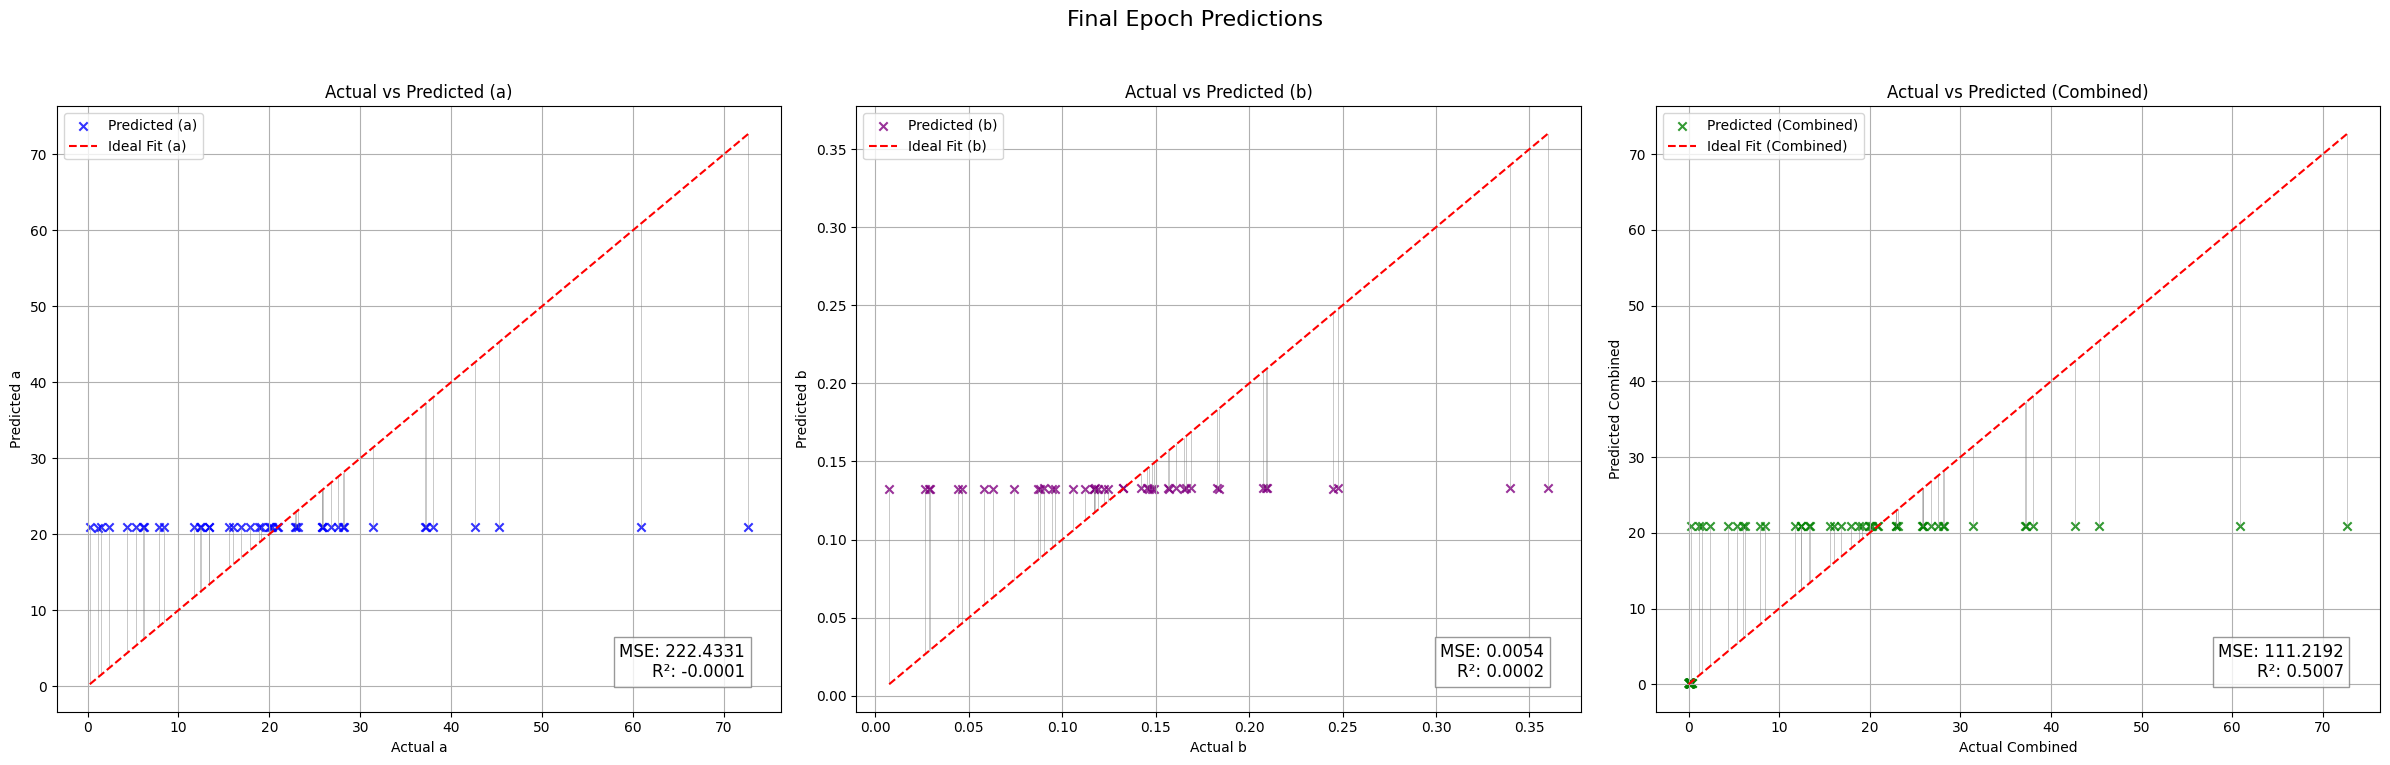

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 110.9655
  - R²: 0.0017
  - MAE: 5.4288
  - Explained Variance Score (EVS): 0.0027
Fold 3 Metrics:
  - Validation Loss (MSE): 110.9655
  - R²: 0.0017
  - MAE: 5.4288
  - EVS: 0.0027
Fold 4/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 70.16it/s, loss=0.421]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.7905
  - R²: -0.0019
  - MAE: 5.8953
  - Explained Variance Score (EVS): 0.0015
Epoch [1/50], Train Loss: 0.4065, Val Loss: 93.7905
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 77.09it/s, loss=0.5]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.8409
  - R²: -0.0022
  - MAE: 5.8965
  - Explained Variance Score (EVS): 0.0012
Epoch [2/50], Train Loss: 0.4119, Val Loss: 93.8409
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 77.97it/s, loss=0.423]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.8937
  - R²: -0.0023
  - MAE: 5.8979
  - Explained Variance Score (EVS): 0.0010
Epoch [3/50], Train Loss: 0.4016, Val Loss: 93.8937
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 97.33it/s, loss=0.522] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9312
  - R²: -0.0025
  - MAE: 5.8992
  - Explained Variance Score (EVS): 0.0007
Epoch [4/50], Train Loss: 0.4086, Val Loss: 93.9312
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 67.91it/s, loss=0.286]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9364
  - R²: -0.0025
  - MAE: 5.8999
  - Explained Variance Score (EVS): 0.0007
Epoch [5/50], Train Loss: 0.3881, Val Loss: 93.9364
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 92.41it/s, loss=0.334]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9396
  - R²: -0.0024
  - MAE: 5.9003
  - Explained Variance Score (EVS): 0.0008
Epoch [6/50], Train Loss: 0.3936, Val Loss: 93.9396
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 90.90it/s, loss=0.429]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9238
  - R²: -0.0023
  - MAE: 5.8997
  - Explained Variance Score (EVS): 0.0008
Epoch [7/50], Train Loss: 0.4026, Val Loss: 93.9238
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 68.58it/s, loss=0.327]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9244
  - R²: -0.0024
  - MAE: 5.9001
  - Explained Variance Score (EVS): 0.0007
Epoch [8/50], Train Loss: 0.3932, Val Loss: 93.9244
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 82.56it/s, loss=0.358]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9175
  - R²: -0.0023
  - MAE: 5.9003
  - Explained Variance Score (EVS): 0.0008
Epoch [9/50], Train Loss: 0.3953, Val Loss: 93.9175
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 90.11it/s, loss=0.489]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9040
  - R²: -0.0021
  - MAE: 5.8999
  - Explained Variance Score (EVS): 0.0009
Epoch [10/50], Train Loss: 0.4059, Val Loss: 93.9040
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 97.31it/s, loss=0.337] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functi

Validation Metrics:
  - MSE: 93.9097
  - R²: -0.0022
  - MAE: 5.8999
  - Explained Variance Score (EVS): 0.0009
Epoch [11/50], Train Loss: 0.3917, Val Loss: 93.9097
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


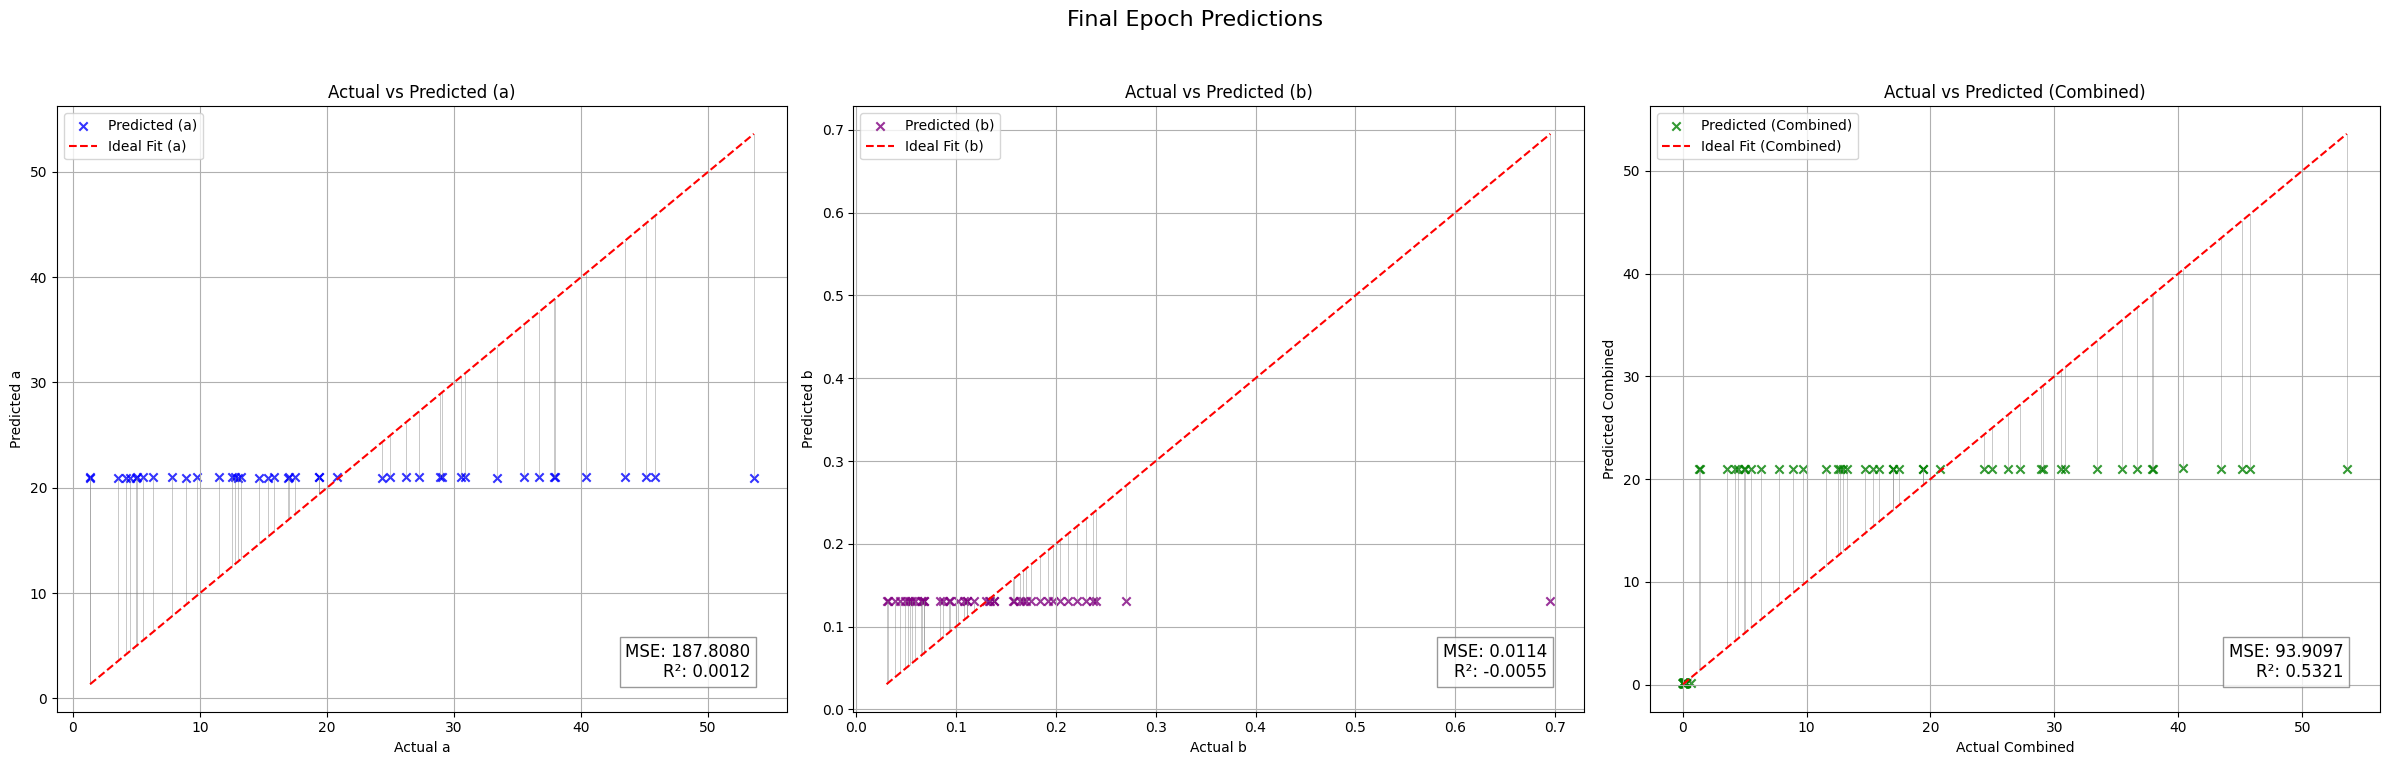

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 93.7905
  - R²: -0.0019
  - MAE: 5.8953
  - Explained Variance Score (EVS): 0.0015
Fold 4 Metrics:
  - Validation Loss (MSE): 93.7905
  - R²: -0.0019
  - MAE: 5.8953
  - EVS: 0.0015
Fold 5/5


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 3/3 [00:00<00:00, 90.12it/s, loss=0.42]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.1804
  - R²: -0.0053
  - MAE: 6.7393
  - Explained Variance Score (EVS): 0.0025
Epoch [1/50], Train Loss: 0.4047, Val Loss: 182.1804
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00, 88.22it/s, loss=0.394]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.2247
  - R²: -0.0054
  - MAE: 6.7393
  - Explained Variance Score (EVS): 0.0024
Epoch [2/50], Train Loss: 0.4011, Val Loss: 182.2247
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00, 83.67it/s, loss=0.38]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.2339
  - R²: -0.0056
  - MAE: 6.7395
  - Explained Variance Score (EVS): 0.0022
Epoch [3/50], Train Loss: 0.3985, Val Loss: 182.2339
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00, 79.26it/s, loss=0.31]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.3114
  - R²: -0.0059
  - MAE: 6.7409
  - Explained Variance Score (EVS): 0.0018
Epoch [4/50], Train Loss: 0.3903, Val Loss: 182.3114
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00, 78.65it/s, loss=0.454]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.3417
  - R²: -0.0060
  - MAE: 6.7420
  - Explained Variance Score (EVS): 0.0017
Epoch [5/50], Train Loss: 0.4003, Val Loss: 182.3417
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00, 88.60it/s, loss=0.254]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.4070
  - R²: -0.0060
  - MAE: 6.7433
  - Explained Variance Score (EVS): 0.0017
Epoch [6/50], Train Loss: 0.3825, Val Loss: 182.4070
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00, 76.68it/s, loss=0.405]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.3466
  - R²: -0.0059
  - MAE: 6.7428
  - Explained Variance Score (EVS): 0.0017
Epoch [7/50], Train Loss: 0.3954, Val Loss: 182.3466
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00, 69.59it/s, loss=0.438]


Validation Metrics:
  - MSE: 182.3188
  - R²: -0.0058
  - MAE: 6.7420
  - Explained Variance Score (EVS): 0.0018

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [8/50], Train Loss: 0.3982, Val Loss: 182.3188
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00, 82.20it/s, loss=0.35]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.2970
  - R²: -0.0057
  - MAE: 6.7413
  - Explained Variance Score (EVS): 0.0019
Epoch [9/50], Train Loss: 0.3908, Val Loss: 182.2970
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00, 77.49it/s, loss=0.321]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.2681
  - R²: -0.0056
  - MAE: 6.7404
  - Explained Variance Score (EVS): 0.0019
Epoch [10/50], Train Loss: 0.3886, Val Loss: 182.2681
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00, 72.10it/s, loss=0.336]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.2396
  - R²: -0.0052
  - MAE: 6.7395
  - Explained Variance Score (EVS): 0.0023
Epoch [11/50], Train Loss: 0.3897, Val Loss: 182.2396
Current Dropout Rate: 0.4200


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


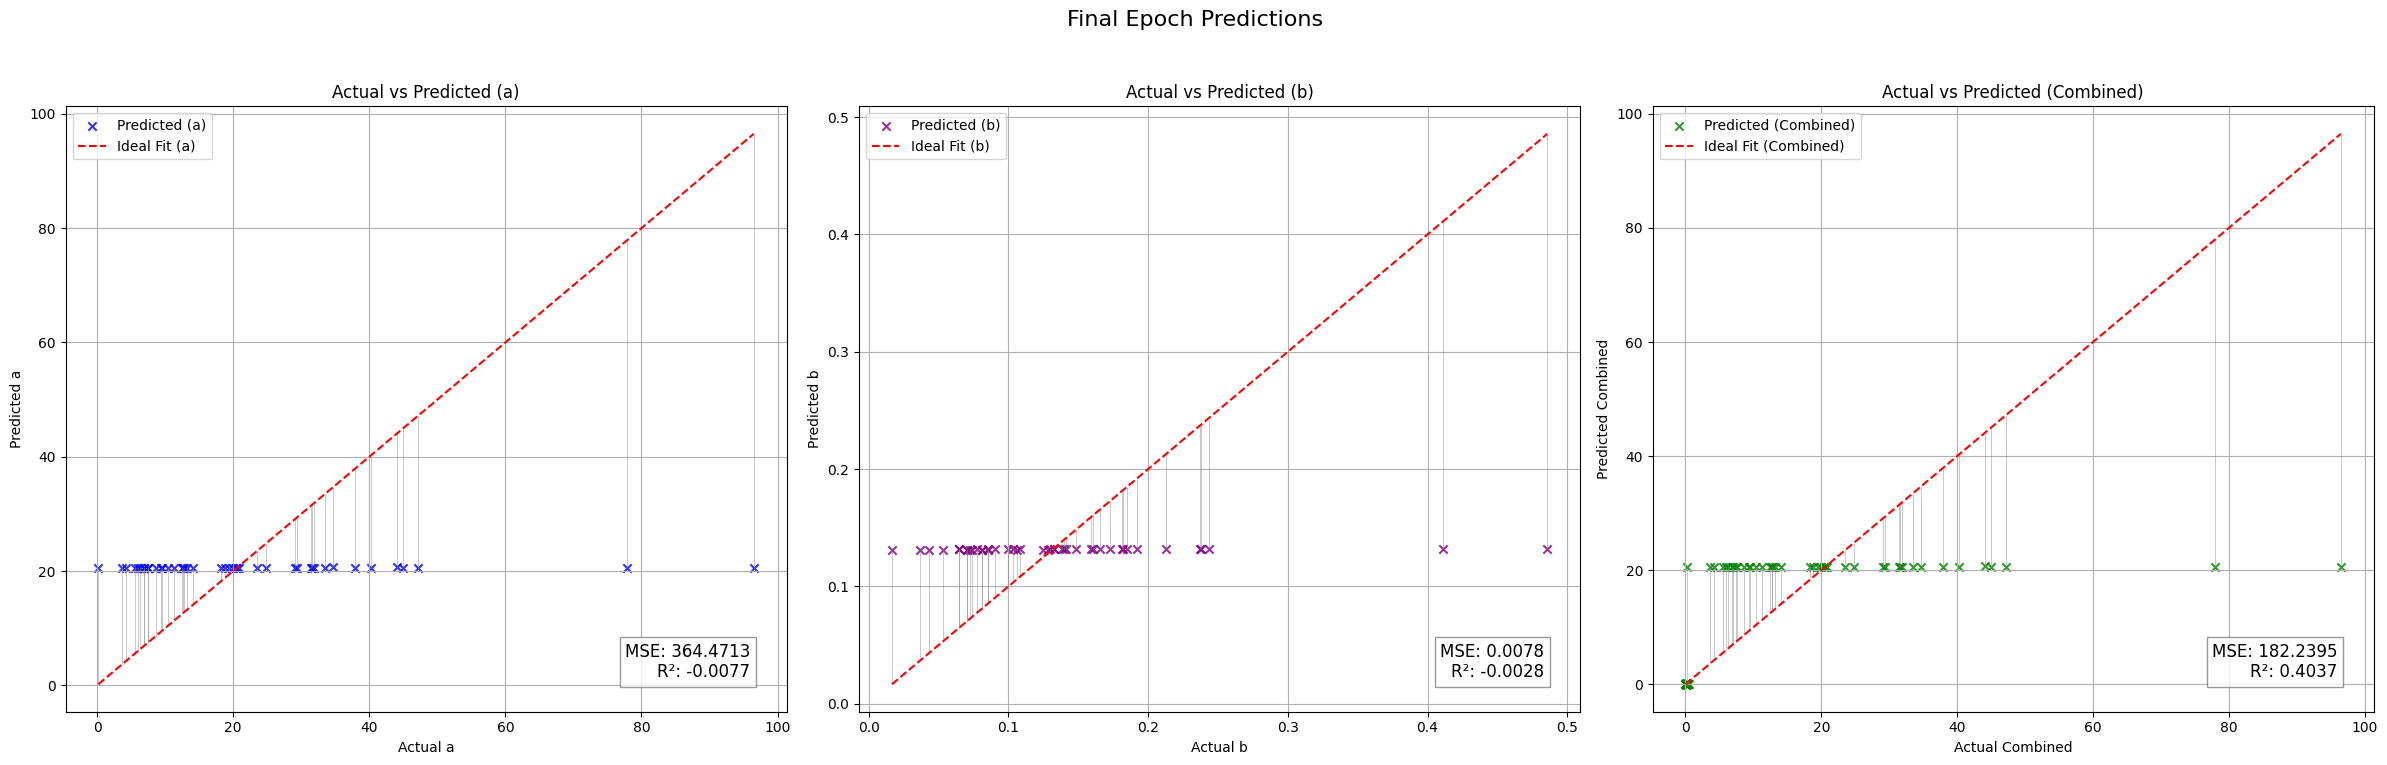

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[I 2024-11-30 07:27:04,487] Trial 3 finished with value: 136.39500427246094 and parameters: {'num_layers': 1, 'hidden_size_0': 335, 'activation_0': 'ELU', 'dropout_0': 0.28899316651720597, 'batch_size': 64, 'learning_rate': 6.230873789502134e-05, 'optimizer': 'Adam'}. Best is trial 2 with value: 135.8032684326172.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-11-452298e7c718>:709: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is de

Validation Metrics:
  - MSE: 182.1804
  - R²: -0.0053
  - MAE: 6.7393
  - Explained Variance Score (EVS): 0.0025
Fold 5 Metrics:
  - Validation Loss (MSE): 182.1804
  - R²: -0.0053
  - MAE: 6.7393
  - EVS: 0.0025
Avg Validation Metrics:
  - MSE: 136.3950
  - R²: -0.0372
  - MAE: 6.0896
  - EVS: 0.0024
Using device: cuda
Fold 1/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 41.55it/s, loss=0.376]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 199.1373
  - R²: -0.0281
  - MAE: 6.4174
  - Explained Variance Score (EVS): 0.0000
Epoch [1/50], Train Loss: 0.8265, Val Loss: 199.1373
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 72.24it/s, loss=0.321]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 198.4999
  - R²: -0.0252
  - MAE: 6.4260
  - Explained Variance Score (EVS): 0.0000
Epoch [2/50], Train Loss: 0.4400, Val Loss: 198.4999
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 64.89it/s, loss=0.334]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 198.0449
  - R²: -0.0230
  - MAE: 6.4338
  - Explained Variance Score (EVS): 0.0000
Epoch [3/50], Train Loss: 0.3987, Val Loss: 198.0449
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 60.51it/s, loss=0.417]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.8007
  - R²: -0.0217
  - MAE: 6.4409
  - Explained Variance Score (EVS): 0.0000
Epoch [4/50], Train Loss: 0.3986, Val Loss: 197.8007
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 60.08it/s, loss=0.373]

Validation Metrics:
  - MSE: 197.6570
  - R²: -0.0211
  - MAE: 6.4452
  - Explained Variance Score (EVS): 0.0000
Epoch [5/50], Train Loss: 0.4032, Val Loss: 197.6570
Current Dropout Rate: 0.4680



<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 65.96it/s, loss=0.352]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.5625
  - R²: -0.0207
  - MAE: 6.4480
  - Explained Variance Score (EVS): 0.0000
Epoch [6/50], Train Loss: 0.4078, Val Loss: 197.5625
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 67.86it/s, loss=0.299]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.5156
  - R²: -0.0204
  - MAE: 6.4495
  - Explained Variance Score (EVS): 0.0000
Epoch [7/50], Train Loss: 0.4065, Val Loss: 197.5156
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 61.95it/s, loss=0.385]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.5156
  - R²: -0.0204
  - MAE: 6.4495
  - Explained Variance Score (EVS): 0.0000
Epoch [8/50], Train Loss: 0.4145, Val Loss: 197.5156
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 59.03it/s, loss=0.367]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.4124, Val Loss: 197.4690
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 62.23it/s, loss=0.247]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [10/50], Train Loss: 0.4018, Val Loss: 197.4690
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 65.87it/s, loss=0.348]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.4106, Val Loss: 197.4690
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 6/6 [00:00<00:00, 61.82it/s, loss=0.493]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0200
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0002
Epoch [12/50], Train Loss: 0.4236, Val Loss: 197.4690
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 6/6 [00:00<00:00, 63.41it/s, loss=0.61]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0199
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0003
Epoch [13/50], Train Loss: 0.4336, Val Loss: 197.4690
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 6/6 [00:00<00:00, 68.67it/s, loss=0.293]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0198
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0004
Epoch [14/50], Train Loss: 0.4048, Val Loss: 197.4690
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 6/6 [00:00<00:00, 77.79it/s, loss=0.313]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4657
  - R²: -0.0202
  - MAE: 6.4505
  - Explained Variance Score (EVS): 0.0000
Epoch [15/50], Train Loss: 0.4066, Val Loss: 197.4657
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 6/6 [00:00<00:00, 70.10it/s, loss=0.413]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3260
  - R²: -0.0194
  - MAE: 6.4470
  - Explained Variance Score (EVS): 0.0008
Epoch [16/50], Train Loss: 0.4153, Val Loss: 197.3260
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 6/6 [00:00<00:00, 69.23it/s, loss=0.389]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3462
  - R²: -0.0194
  - MAE: 6.4461
  - Explained Variance Score (EVS): 0.0008
Epoch [17/50], Train Loss: 0.4126, Val Loss: 197.3462
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 6/6 [00:00<00:00, 69.29it/s, loss=0.194]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.0271
  - R²: -0.0179
  - MAE: 6.4427
  - Explained Variance Score (EVS): 0.0020
Epoch [18/50], Train Loss: 0.3951, Val Loss: 197.0271
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 6/6 [00:00<00:00, 67.33it/s, loss=0.838]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.7665
  - R²: -0.0163
  - MAE: 6.4384
  - Explained Variance Score (EVS): 0.0036
Epoch [19/50], Train Loss: 0.4521, Val Loss: 196.7665
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 6/6 [00:00<00:00, 76.61it/s, loss=0.457]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.6371
  - R²: -0.0155
  - MAE: 6.4363
  - Explained Variance Score (EVS): 0.0043
Epoch [20/50], Train Loss: 0.4180, Val Loss: 196.6371
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 6/6 [00:00<00:00, 75.58it/s, loss=0.336]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.0966
  - R²: -0.0127
  - MAE: 6.4332
  - Explained Variance Score (EVS): 0.0068
Epoch [21/50], Train Loss: 0.4069, Val Loss: 196.0966
Current Dropout Rate: 0.3400


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 6/6 [00:00<00:00, 67.78it/s, loss=0.525]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.3200
  - R²: -0.0140
  - MAE: 6.4309
  - Explained Variance Score (EVS): 0.0056
Epoch [22/50], Train Loss: 0.4235, Val Loss: 196.3200
Current Dropout Rate: 0.3320


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 6/6 [00:00<00:00, 59.75it/s, loss=0.373]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.7795
  - R²: -0.0166
  - MAE: 6.4345
  - Explained Variance Score (EVS): 0.0031
Epoch [23/50], Train Loss: 0.4097, Val Loss: 196.7795
Current Dropout Rate: 0.3240


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24/50: 100%|██████████| 6/6 [00:00<00:00, 62.12it/s, loss=0.398]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.0136
  - R²: -0.0126
  - MAE: 6.4289
  - Explained Variance Score (EVS): 0.0068
Epoch [24/50], Train Loss: 0.4119, Val Loss: 196.0136
Current Dropout Rate: 0.3160


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25/50: 100%|██████████| 6/6 [00:00<00:00, 68.91it/s, loss=0.246]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.8953
  - R²: -0.0174
  - MAE: 6.4368
  - Explained Variance Score (EVS): 0.0024
Epoch [25/50], Train Loss: 0.3985, Val Loss: 196.8953
Current Dropout Rate: 0.3080


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26/50: 100%|██████████| 6/6 [00:00<00:00, 66.35it/s, loss=0.347]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.0549
  - R²: -0.0124
  - MAE: 6.4343
  - Explained Variance Score (EVS): 0.0070
Epoch [26/50], Train Loss: 0.4072, Val Loss: 196.0549
Current Dropout Rate: 0.3000


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27/50: 100%|██████████| 6/6 [00:00<00:00, 68.18it/s, loss=0.3]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.7431
  - R²: -0.0164
  - MAE: 6.4370
  - Explained Variance Score (EVS): 0.0035
Epoch [27/50], Train Loss: 0.4032, Val Loss: 196.7431
Current Dropout Rate: 0.2920


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28/50: 100%|██████████| 6/6 [00:00<00:00, 64.12it/s, loss=0.157]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.6385
  - R²: -0.0157
  - MAE: 6.4384
  - Explained Variance Score (EVS): 0.0040
Epoch [28/50], Train Loss: 0.3907, Val Loss: 196.6385
Current Dropout Rate: 0.2840


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29/50: 100%|██████████| 6/6 [00:00<00:00, 65.09it/s, loss=0.634]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.2340
  - R²: -0.0135
  - MAE: 6.4305
  - Explained Variance Score (EVS): 0.0061
Epoch [29/50], Train Loss: 0.4326, Val Loss: 196.2340
Current Dropout Rate: 0.2760


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/50: 100%|██████████| 6/6 [00:00<00:00, 70.90it/s, loss=0.455]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.1158
  - R²: -0.0129
  - MAE: 6.4291
  - Explained Variance Score (EVS): 0.0065
Epoch [30/50], Train Loss: 0.4164, Val Loss: 196.1158
Current Dropout Rate: 0.2680


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31/50: 100%|██████████| 6/6 [00:00<00:00, 76.85it/s, loss=0.296]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.4102
  - R²: -0.0146
  - MAE: 6.4305
  - Explained Variance Score (EVS): 0.0050
Epoch [31/50], Train Loss: 0.4019, Val Loss: 196.4102
Current Dropout Rate: 0.2600


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32/50: 100%|██████████| 6/6 [00:00<00:00, 63.03it/s, loss=0.444]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 195.9657
  - R²: -0.0118
  - MAE: 6.4296
  - Explained Variance Score (EVS): 0.0076
Epoch [32/50], Train Loss: 0.4151, Val Loss: 195.9657
Current Dropout Rate: 0.2520


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33/50: 100%|██████████| 6/6 [00:00<00:00, 72.29it/s, loss=0.207]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.5314
  - R²: -0.0153
  - MAE: 6.4329
  - Explained Variance Score (EVS): 0.0043
Epoch [33/50], Train Loss: 0.3938, Val Loss: 196.5314
Current Dropout Rate: 0.2440


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34/50: 100%|██████████| 6/6 [00:00<00:00, 75.93it/s, loss=0.323]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.4819
  - R²: -0.0147
  - MAE: 6.4353
  - Explained Variance Score (EVS): 0.0047
Epoch [34/50], Train Loss: 0.4043, Val Loss: 196.4819
Current Dropout Rate: 0.2360


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35/50: 100%|██████████| 6/6 [00:00<00:00, 59.10it/s, loss=0.62]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.0897
  - R²: -0.0126
  - MAE: 6.4286
  - Explained Variance Score (EVS): 0.0067
Epoch [35/50], Train Loss: 0.4304, Val Loss: 196.0897
Current Dropout Rate: 0.2280


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36/50: 100%|██████████| 6/6 [00:00<00:00, 54.70it/s, loss=0.419]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.4069
  - R²: -0.0142
  - MAE: 6.4314
  - Explained Variance Score (EVS): 0.0053
Epoch [36/50], Train Loss: 0.4122, Val Loss: 196.4069
Current Dropout Rate: 0.2200


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37/50: 100%|██████████| 6/6 [00:00<00:00, 72.09it/s, loss=0.371]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.0695
  - R²: -0.0123
  - MAE: 6.4325
  - Explained Variance Score (EVS): 0.0072
Epoch [37/50], Train Loss: 0.4079, Val Loss: 196.0695
Current Dropout Rate: 0.2120


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38/50: 100%|██████████| 6/6 [00:00<00:00, 64.65it/s, loss=0.301]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 195.9921
  - R²: -0.0123
  - MAE: 6.4289
  - Explained Variance Score (EVS): 0.0071
Epoch [38/50], Train Loss: 0.4017, Val Loss: 195.9921
Current Dropout Rate: 0.2040


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39/50: 100%|██████████| 6/6 [00:00<00:00, 66.90it/s, loss=0.767]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 195.7312
  - R²: -0.0109
  - MAE: 6.4282
  - Explained Variance Score (EVS): 0.0084
Epoch [39/50], Train Loss: 0.4427, Val Loss: 195.7312
Current Dropout Rate: 0.1960


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40/50: 100%|██████████| 6/6 [00:00<00:00, 72.65it/s, loss=0.421]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 195.8375
  - R²: -0.0114
  - MAE: 6.4289
  - Explained Variance Score (EVS): 0.0079
Epoch [40/50], Train Loss: 0.4120, Val Loss: 195.8375
Current Dropout Rate: 0.1880


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41/50: 100%|██████████| 6/6 [00:00<00:00, 72.59it/s, loss=0.524]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.2670
  - R²: -0.0139
  - MAE: 6.4302
  - Explained Variance Score (EVS): 0.0055
Epoch [41/50], Train Loss: 0.4210, Val Loss: 196.2670
Current Dropout Rate: 0.1800


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42/50: 100%|██████████| 6/6 [00:00<00:00, 73.28it/s, loss=0.311]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 195.9186
  - R²: -0.0117
  - MAE: 6.4289
  - Explained Variance Score (EVS): 0.0076
Epoch [42/50], Train Loss: 0.4022, Val Loss: 195.9186
Current Dropout Rate: 0.1720


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43/50: 100%|██████████| 6/6 [00:00<00:00, 63.92it/s, loss=0.645]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.0374
  - R²: -0.0124
  - MAE: 6.4307
  - Explained Variance Score (EVS): 0.0070
Epoch [43/50], Train Loss: 0.4319, Val Loss: 196.0374
Current Dropout Rate: 0.1640


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44/50: 100%|██████████| 6/6 [00:00<00:00, 67.87it/s, loss=0.369]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.3366
  - R²: -0.0142
  - MAE: 6.4305
  - Explained Variance Score (EVS): 0.0053
Epoch [44/50], Train Loss: 0.4071, Val Loss: 196.3366
Current Dropout Rate: 0.1560


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45/50: 100%|██████████| 6/6 [00:00<00:00, 69.98it/s, loss=0.276]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.3344
  - R²: -0.0142
  - MAE: 6.4311
  - Explained Variance Score (EVS): 0.0053
Epoch [45/50], Train Loss: 0.3990, Val Loss: 196.3344
Current Dropout Rate: 0.1480


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46/50: 100%|██████████| 6/6 [00:00<00:00, 69.67it/s, loss=0.183]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.2874
  - R²: -0.0139
  - MAE: 6.4339
  - Explained Variance Score (EVS): 0.0056
Epoch [46/50], Train Loss: 0.3907, Val Loss: 196.2874
Current Dropout Rate: 0.1400


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47/50: 100%|██████████| 6/6 [00:00<00:00, 65.83it/s, loss=0.345]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.1485
  - R²: -0.0131
  - MAE: 6.4305
  - Explained Variance Score (EVS): 0.0064
Epoch [47/50], Train Loss: 0.4050, Val Loss: 196.1485
Current Dropout Rate: 0.1320


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48/50: 100%|██████████| 6/6 [00:00<00:00, 65.77it/s, loss=0.775]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.1410
  - R²: -0.0132
  - MAE: 6.4295
  - Explained Variance Score (EVS): 0.0062
Epoch [48/50], Train Loss: 0.4432, Val Loss: 196.1410
Current Dropout Rate: 0.1240


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49/50: 100%|██████████| 6/6 [00:00<00:00, 73.11it/s, loss=0.579]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 196.1789
  - R²: -0.0134
  - MAE: 6.4291
  - Explained Variance Score (EVS): 0.0060
Epoch [49/50], Train Loss: 0.4258, Val Loss: 196.1789
Current Dropout Rate: 0.1160
Early stopping triggered!
Loading the best model for evaluation...


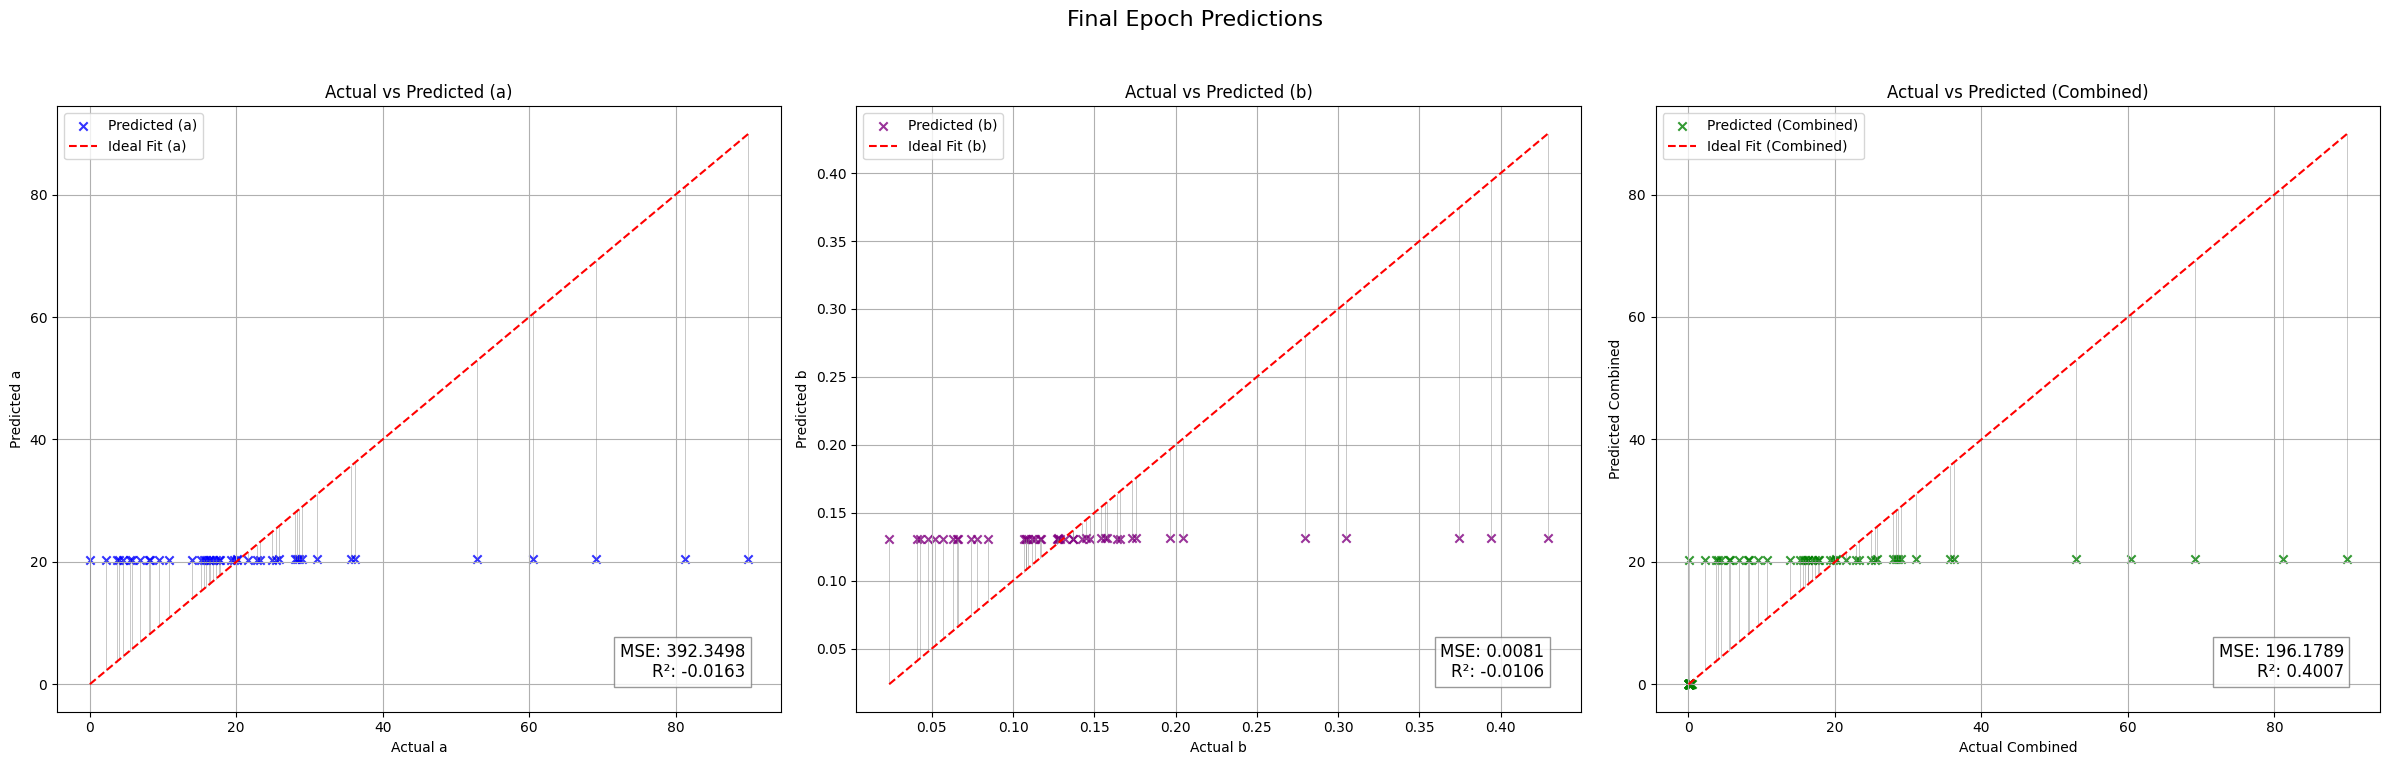

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 195.7312
  - R²: -0.0109
  - MAE: 6.4282
  - Explained Variance Score (EVS): 0.0084
Fold 1 Metrics:
  - Validation Loss (MSE): 195.7312
  - R²: -0.0109
  - MAE: 6.4282
  - EVS: 0.0084
Fold 2/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 83.14it/s, loss=0.619]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2219
  - R²: -0.1700
  - MAE: 5.9453
  - Explained Variance Score (EVS): 0.0006
Epoch [1/50], Train Loss: 0.4226, Val Loss: 98.2219
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 81.04it/s, loss=0.201]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2445
  - R²: -0.1703
  - MAE: 5.9457
  - Explained Variance Score (EVS): 0.0002
Epoch [2/50], Train Loss: 0.3862, Val Loss: 98.2445
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 74.95it/s, loss=0.328]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2445
  - R²: -0.1703
  - MAE: 5.9457
  - Explained Variance Score (EVS): 0.0002
Epoch [3/50], Train Loss: 0.3975, Val Loss: 98.2445
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 66.18it/s, loss=0.401]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2434
  - R²: -0.1703
  - MAE: 5.9455
  - Explained Variance Score (EVS): 0.0002
Epoch [4/50], Train Loss: 0.4040, Val Loss: 98.2434
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 72.05it/s, loss=0.356]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2434
  - R²: -0.1703
  - MAE: 5.9455
  - Explained Variance Score (EVS): 0.0002
Epoch [5/50], Train Loss: 0.4000, Val Loss: 98.2434
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 80.24it/s, loss=0.362]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2360
  - R²: -0.1702
  - MAE: 5.9453
  - Explained Variance Score (EVS): 0.0003
Epoch [6/50], Train Loss: 0.4005, Val Loss: 98.2360
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 74.08it/s, loss=0.29]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2360
  - R²: -0.1702
  - MAE: 5.9453
  - Explained Variance Score (EVS): 0.0003
Epoch [7/50], Train Loss: 0.3942, Val Loss: 98.2360
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 81.56it/s, loss=0.239]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.2275
  - R²: -0.1702
  - MAE: 5.9448
  - Explained Variance Score (EVS): 0.0004
Epoch [8/50], Train Loss: 0.3896, Val Loss: 98.2275
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 84.43it/s, loss=0.249]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.3904, Val Loss: 98.3532
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 78.18it/s, loss=0.41]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.4047, Val Loss: 98.3532
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 80.17it/s, loss=0.533]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.4156, Val Loss: 98.3532
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


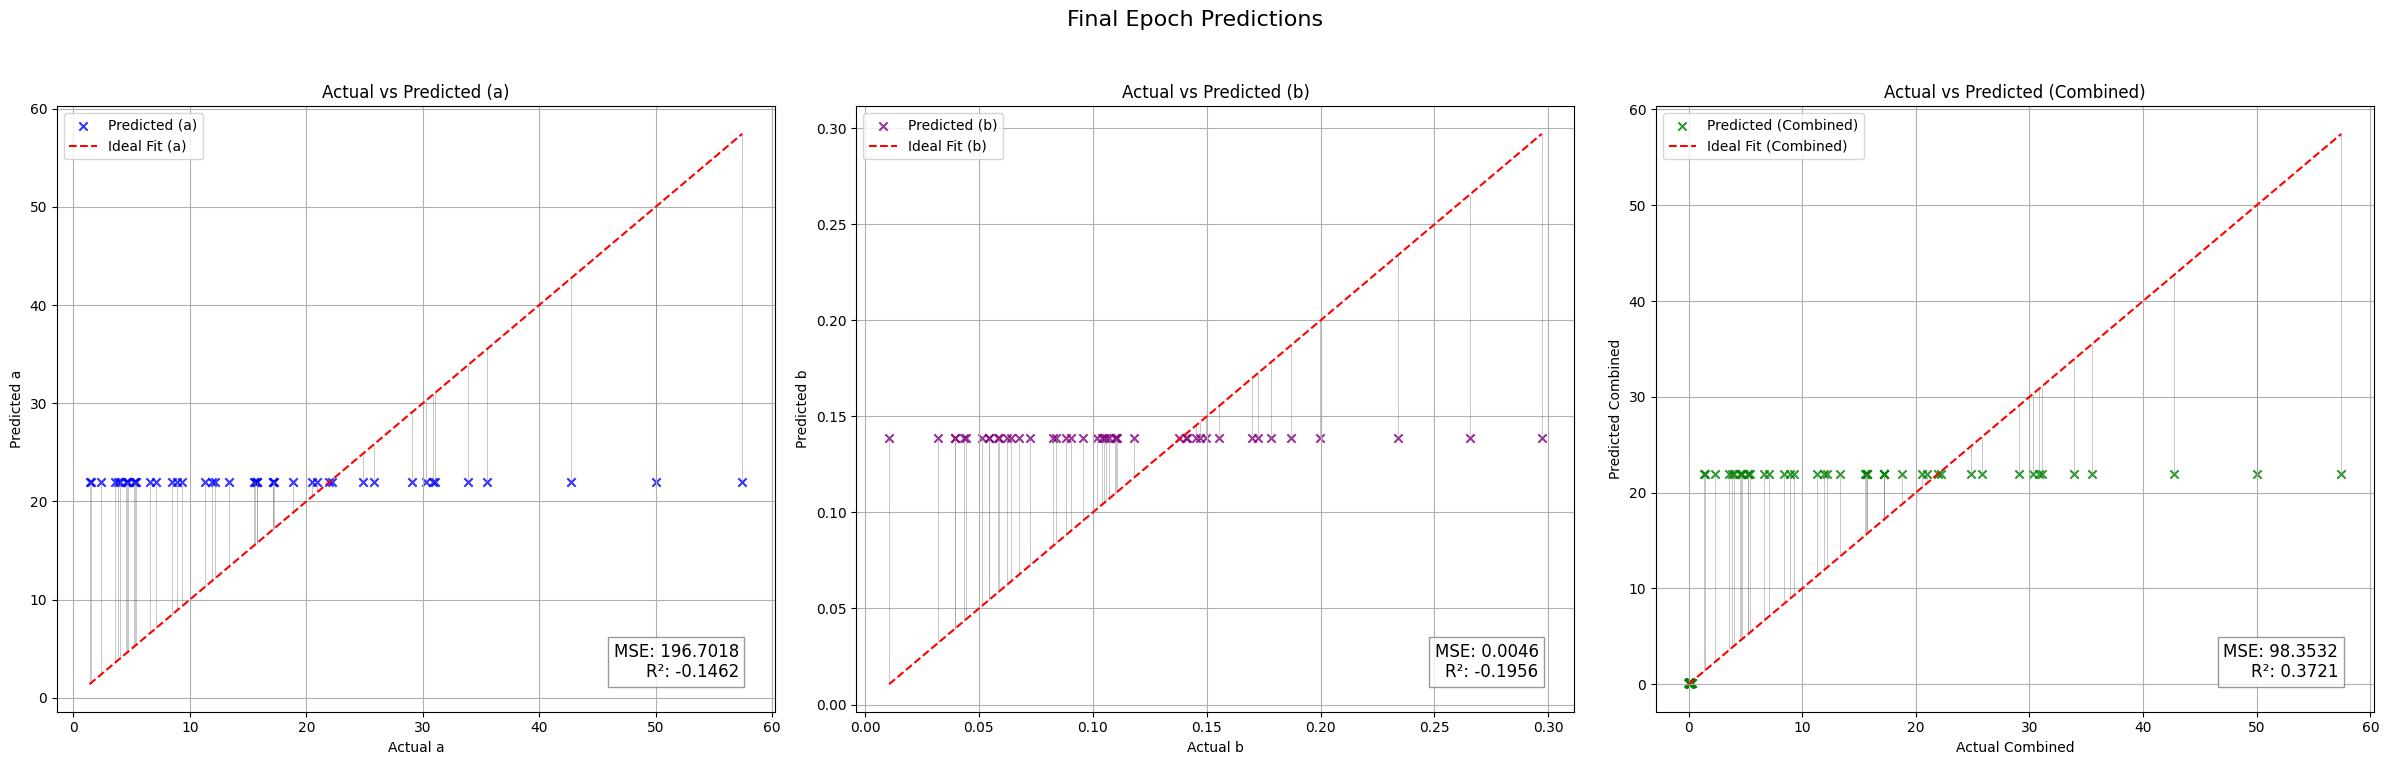

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 98.2219
  - R²: -0.1700
  - MAE: 5.9453
  - Explained Variance Score (EVS): 0.0006
Fold 2 Metrics:
  - Validation Loss (MSE): 98.2219
  - R²: -0.1700
  - MAE: 5.9453
  - EVS: 0.0006
Fold 3/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 78.19it/s, loss=0.293]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2584
  - R²: -0.0005
  - MAE: 5.4375
  - Explained Variance Score (EVS): 0.0001
Epoch [1/50], Train Loss: 0.3921, Val Loss: 111.2584
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 80.09it/s, loss=0.292]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3922, Val Loss: 111.2922
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 79.14it/s, loss=0.232]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.3868, Val Loss: 111.2922
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 53.64it/s, loss=0.408]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.4024, Val Loss: 111.2922
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 65.91it/s, loss=0.484]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.4092, Val Loss: 111.2922
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 82.92it/s, loss=0.387]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.4006, Val Loss: 111.2922
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 85.58it/s, loss=0.259]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3893, Val Loss: 111.2922
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 79.19it/s, loss=0.496]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.4102, Val Loss: 111.2922
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 51.33it/s, loss=0.381]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.4001, Val Loss: 111.2922
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 18.47it/s, loss=0.224]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3862, Val Loss: 111.2922
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 17.95it/s, loss=0.228]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.3864, Val Loss: 111.2922
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


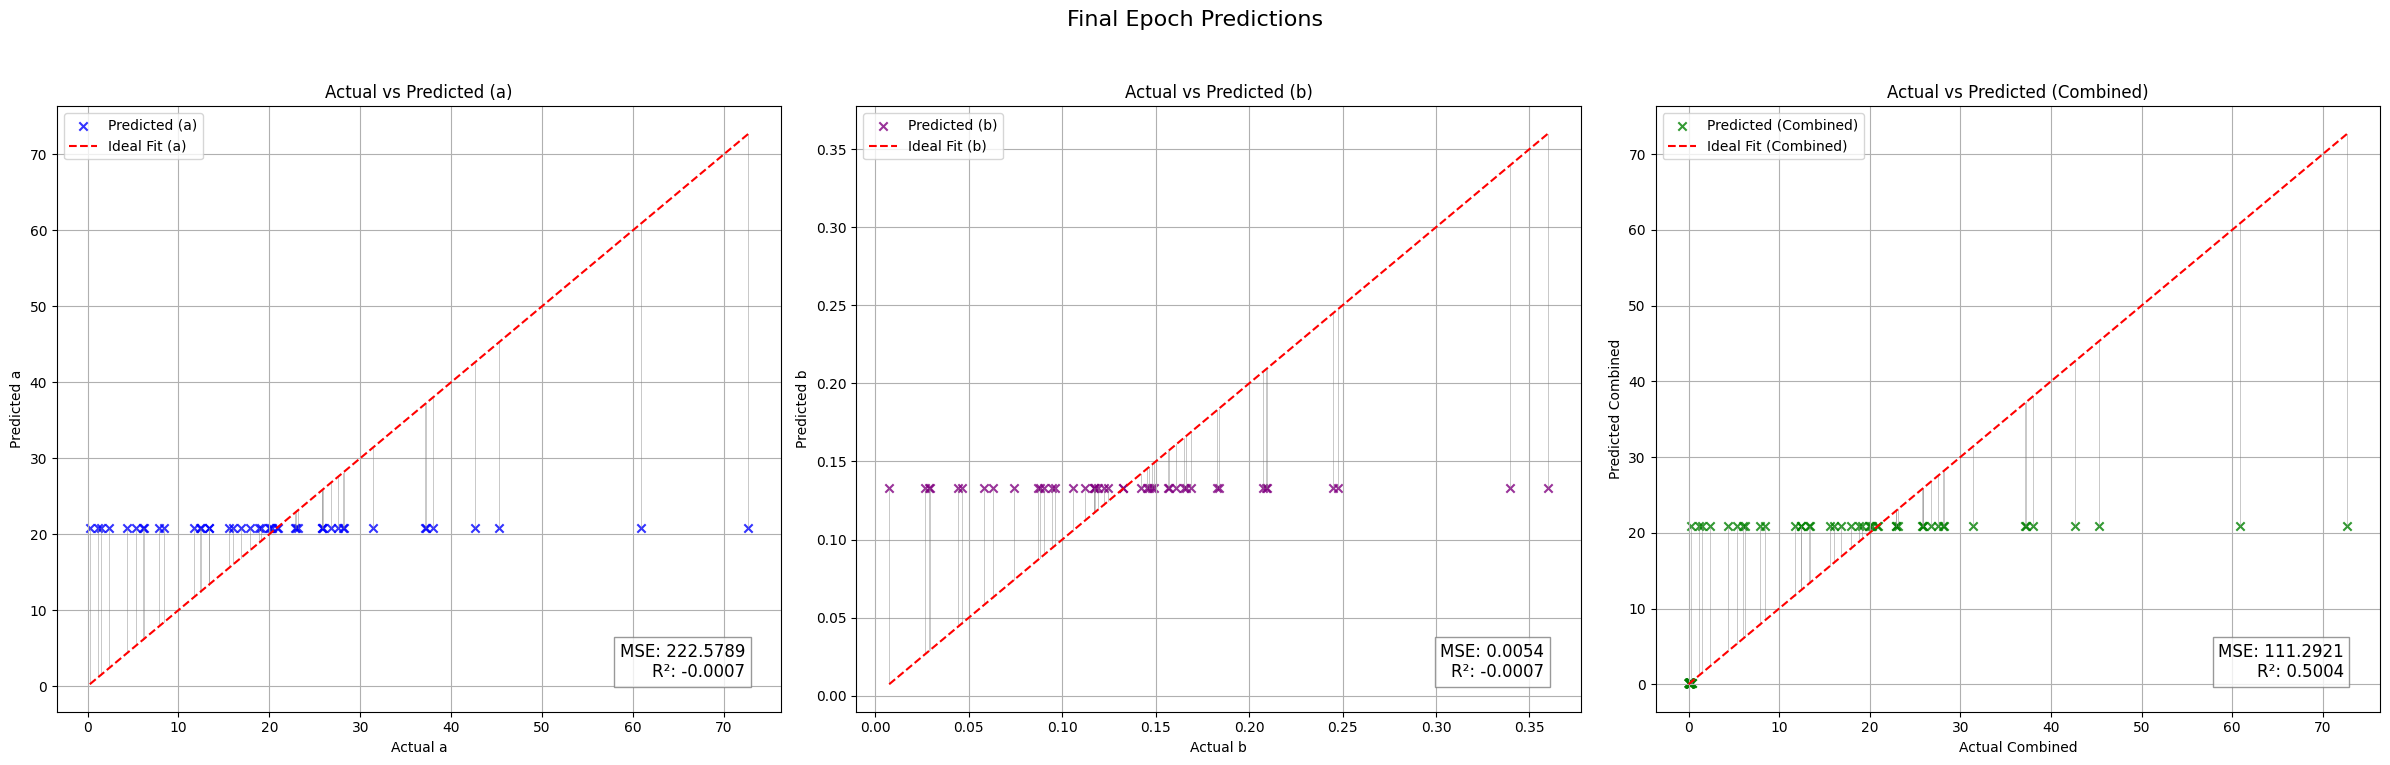

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 111.2584
  - R²: -0.0005
  - MAE: 5.4375
  - Explained Variance Score (EVS): 0.0001
Fold 3 Metrics:
  - Validation Loss (MSE): 111.2584
  - R²: -0.0005
  - MAE: 5.4375
  - EVS: 0.0001
Fold 4/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 81.53it/s, loss=0.252]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0002
  - R²: -0.0028
  - MAE: 5.9012
  - Explained Variance Score (EVS): 0.0002
Epoch [1/50], Train Loss: 0.3989, Val Loss: 94.0002
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 71.73it/s, loss=0.604]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0007
  - R²: -0.0028
  - MAE: 5.9013
  - Explained Variance Score (EVS): 0.0002
Epoch [2/50], Train Loss: 0.4301, Val Loss: 94.0007
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 76.72it/s, loss=0.308]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [3/50], Train Loss: 0.4039, Val Loss: 93.9918
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 81.55it/s, loss=0.417]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [4/50], Train Loss: 0.4135, Val Loss: 93.9918
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 78.97it/s, loss=0.261]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [5/50], Train Loss: 0.3998, Val Loss: 93.9918
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 77.95it/s, loss=0.222]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [6/50], Train Loss: 0.3963, Val Loss: 93.9918
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 78.86it/s, loss=0.258]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [7/50], Train Loss: 0.3995, Val Loss: 93.9918
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 78.31it/s, loss=0.538]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [8/50], Train Loss: 0.4243, Val Loss: 93.9918
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 72.43it/s, loss=0.47]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [9/50], Train Loss: 0.4182, Val Loss: 93.9918
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 54.38it/s, loss=0.646]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [10/50], Train Loss: 0.4338, Val Loss: 93.9918
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 74.94it/s, loss=0.388]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [11/50], Train Loss: 0.4110, Val Loss: 93.9918
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 6/6 [00:00<00:00, 73.23it/s, loss=0.374]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [12/50], Train Loss: 0.4097, Val Loss: 93.9918
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 6/6 [00:00<00:00, 45.93it/s, loss=0.594]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Epoch [13/50], Train Loss: 0.4292, Val Loss: 93.9918
Current Dropout Rate: 0.4040


<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_path)["model_state"])


Early stopping triggered!
Loading the best model for evaluation...


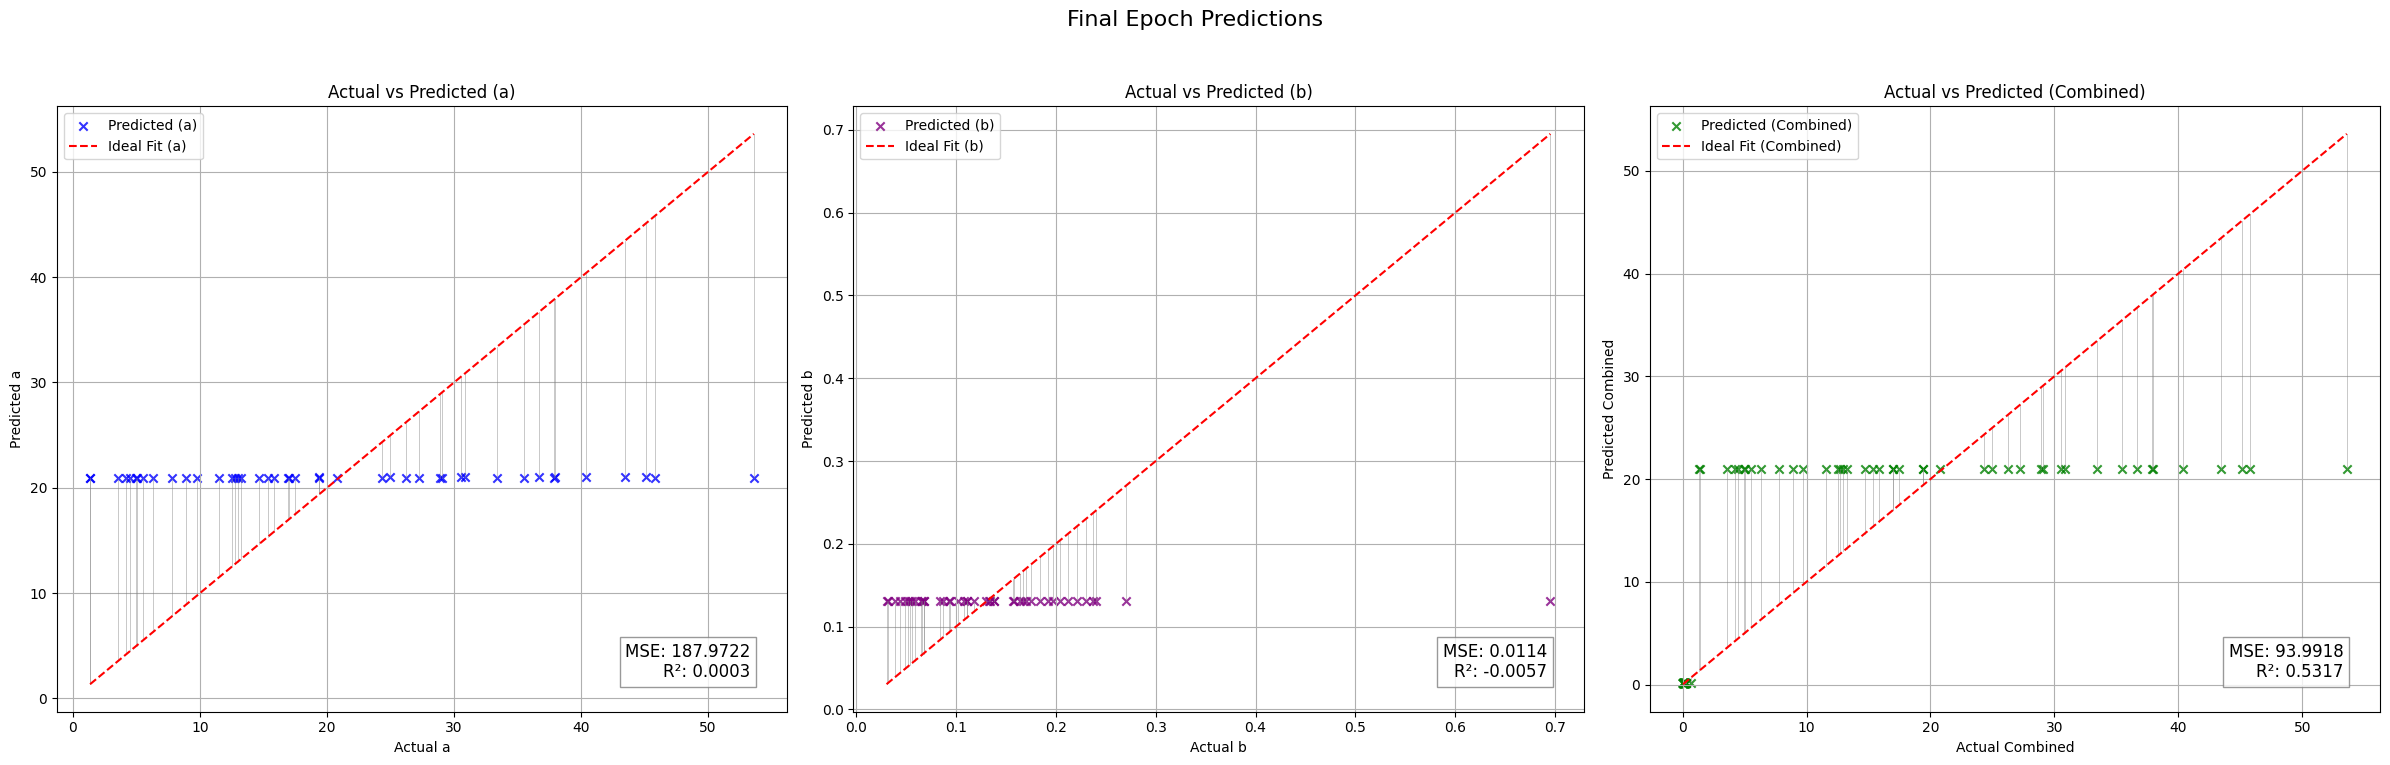

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - Explained Variance Score (EVS): 0.0002
Fold 4 Metrics:
  - Validation Loss (MSE): 93.9918
  - R²: -0.0027
  - MAE: 5.9010
  - EVS: 0.0002
Fold 5/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 74.15it/s, loss=0.286]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6105
  - R²: -0.0072
  - MAE: 6.7482
  - Explained Variance Score (EVS): 0.0002
Epoch [1/50], Train Loss: 0.4012, Val Loss: 182.6105
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 80.45it/s, loss=0.276]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6105
  - R²: -0.0072
  - MAE: 6.7482
  - Explained Variance Score (EVS): 0.0002
Epoch [2/50], Train Loss: 0.4003, Val Loss: 182.6105
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 75.68it/s, loss=0.63]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6105
  - R²: -0.0072
  - MAE: 6.7482
  - Explained Variance Score (EVS): 0.0002
Epoch [3/50], Train Loss: 0.4298, Val Loss: 182.6105
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 63.57it/s, loss=0.48]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6105
  - R²: -0.0072
  - MAE: 6.7482
  - Explained Variance Score (EVS): 0.0002
Epoch [4/50], Train Loss: 0.4174, Val Loss: 182.6105
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 69.87it/s, loss=0.363]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6156
  - R²: -0.0072
  - MAE: 6.7484
  - Explained Variance Score (EVS): 0.0002
Epoch [5/50], Train Loss: 0.4076, Val Loss: 182.6156
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 46.65it/s, loss=0.565]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6156
  - R²: -0.0072
  - MAE: 6.7484
  - Explained Variance Score (EVS): 0.0002
Epoch [6/50], Train Loss: 0.4245, Val Loss: 182.6156
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 81.75it/s, loss=0.467]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6156
  - R²: -0.0072
  - MAE: 6.7484
  - Explained Variance Score (EVS): 0.0002
Epoch [7/50], Train Loss: 0.4162, Val Loss: 182.6156
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 78.36it/s, loss=0.312]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6156
  - R²: -0.0072
  - MAE: 6.7484
  - Explained Variance Score (EVS): 0.0002
Epoch [8/50], Train Loss: 0.4034, Val Loss: 182.6156
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 66.99it/s, loss=0.402]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6703
  - R²: -0.0074
  - MAE: 6.7490
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.4109, Val Loss: 182.6703
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 76.47it/s, loss=0.293]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6703
  - R²: -0.0074
  - MAE: 6.7490
  - Explained Variance Score (EVS): 0.0000
Epoch [10/50], Train Loss: 0.4018, Val Loss: 182.6703
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 63.40it/s, loss=0.785]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 182.6703
  - R²: -0.0074
  - MAE: 6.7490
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.4428, Val Loss: 182.6703
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


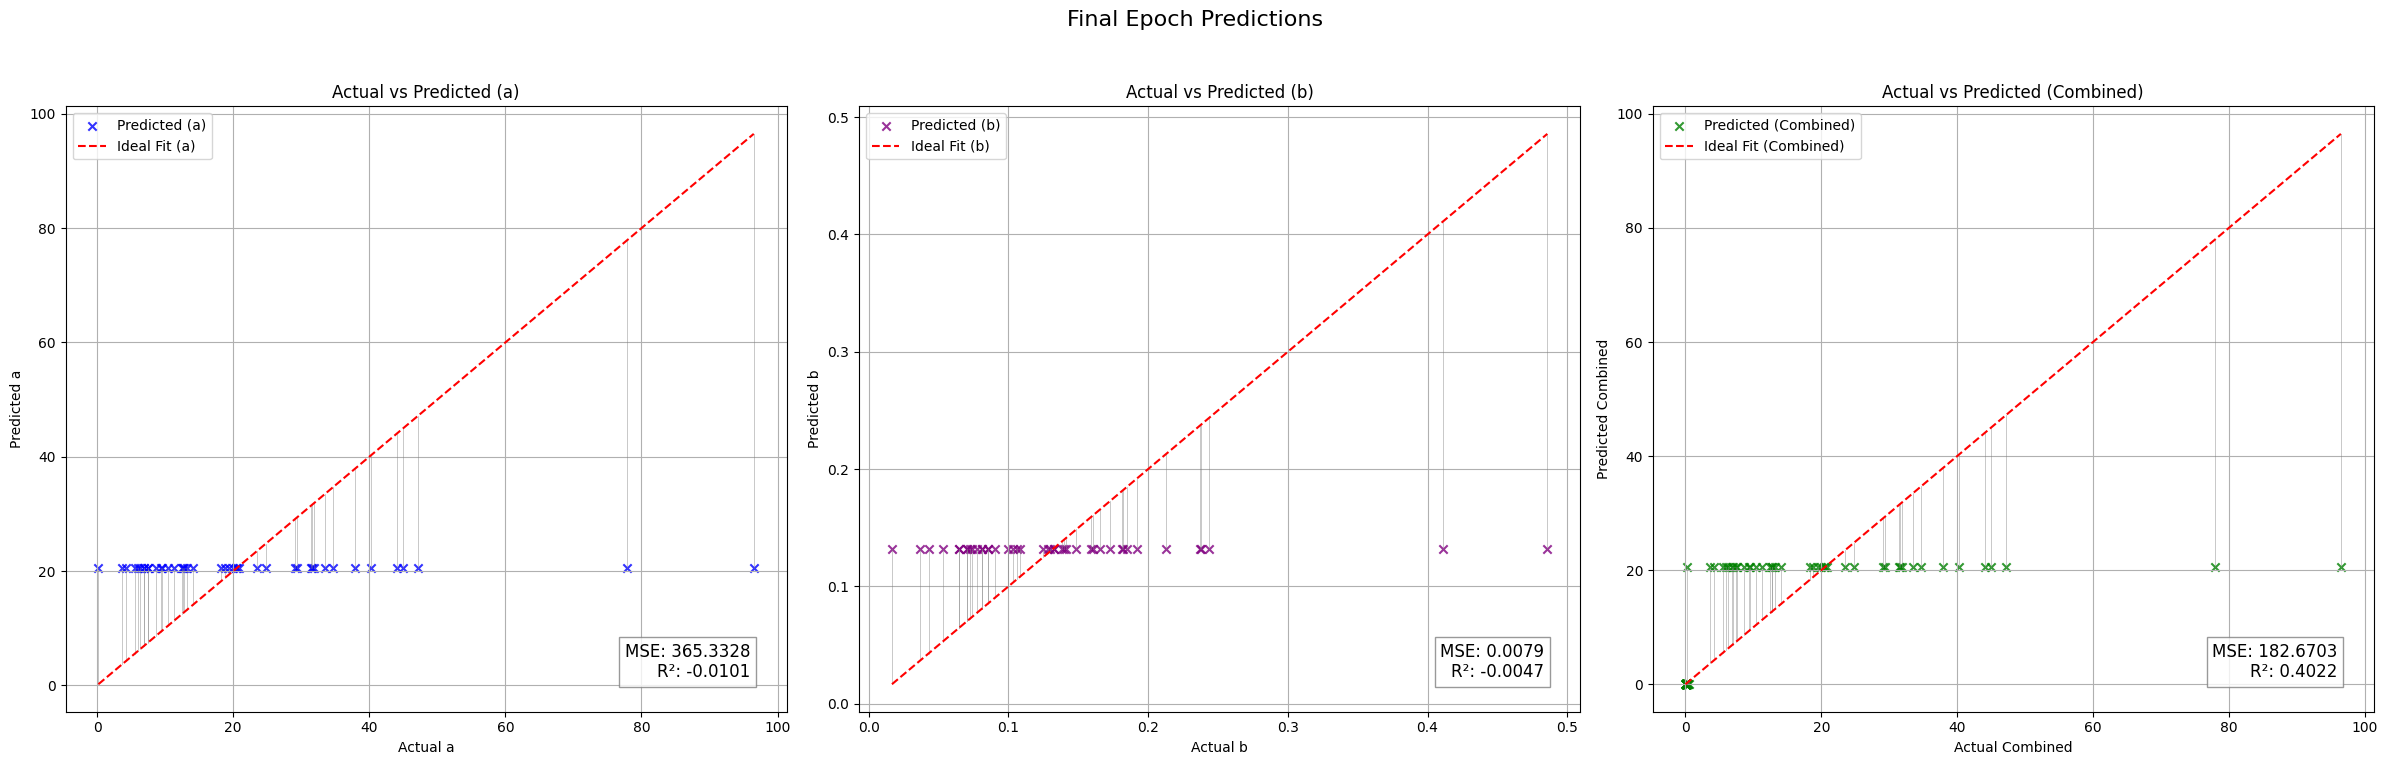

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[I 2024-11-30 07:27:27,685] Trial 4 finished with value: 136.3627471923828 and parameters: {'num_layers': 2, 'hidden_size_0': 343, 'activation_0': 'ELU', 'dropout_0': 0.4697849832433473, 'hidden_size_1': 270, 'activation_1': 'ReLU', 'dropout_1': 0.355305569025523, 'batch_size': 32, 'learning_rate': 0.0009946991323804984, 'optimizer': 'Adagrad'}. Best is trial 2 with value: 135.8032684326172.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-11-452298e7c718>:709: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-

Validation Metrics:
  - MSE: 182.6105
  - R²: -0.0072
  - MAE: 6.7482
  - Explained Variance Score (EVS): 0.0002
Fold 5 Metrics:
  - Validation Loss (MSE): 182.6105
  - R²: -0.0072
  - MAE: 6.7482
  - EVS: 0.0002
Avg Validation Metrics:
  - MSE: 136.3627
  - R²: -0.0383
  - MAE: 6.0920
  - EVS: 0.0019
Using device: cuda
Fold 1/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 91.68it/s, loss=0.337]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [1/50], Train Loss: 2.1276, Val Loss: 197.4225
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 27.32it/s, loss=0.56]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0198
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [2/50], Train Loss: 0.4060, Val Loss: 197.4225
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 30.94it/s, loss=0.281]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0198
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Epoch [3/50], Train Loss: 0.3759, Val Loss: 197.3764
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 24.20it/s, loss=0.487]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0196
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Epoch [4/50], Train Loss: 0.3903, Val Loss: 197.3764
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 25.09it/s, loss=0.561]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [5/50], Train Loss: 0.3940, Val Loss: 197.4690
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 34.83it/s, loss=0.359]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [6/50], Train Loss: 0.3738, Val Loss: 197.4225
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 84.37it/s, loss=0.411]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.5156
  - R²: -0.0204
  - MAE: 6.4495
  - Explained Variance Score (EVS): 0.0000
Epoch [7/50], Train Loss: 0.3767, Val Loss: 197.5156
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 40.70it/s, loss=0.342]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [8/50], Train Loss: 0.3690, Val Loss: 197.4690
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 28.23it/s, loss=0.466]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.3788, Val Loss: 197.4225
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 19.19it/s, loss=0.335]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0202
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [10/50], Train Loss: 0.3664, Val Loss: 197.4690
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 22.00it/s, loss=0.247]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.4225
  - R²: -0.0199
  - MAE: 6.4523
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.3577, Val Loss: 197.4225
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 6/6 [00:00<00:00, 36.43it/s, loss=0.256]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 197.5625
  - R²: -0.0203
  - MAE: 6.4480
  - Explained Variance Score (EVS): 0.0000
Epoch [12/50], Train Loss: 0.3579, Val Loss: 197.5625
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 6/6 [00:00<00:00, 77.12it/s, loss=0.297]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 197.4690
  - R²: -0.0201
  - MAE: 6.4509
  - Explained Variance Score (EVS): 0.0000
Epoch [13/50], Train Loss: 0.3612, Val Loss: 197.4690
Current Dropout Rate: 0.4040
Early stopping triggered!
Loading the best model for evaluation...


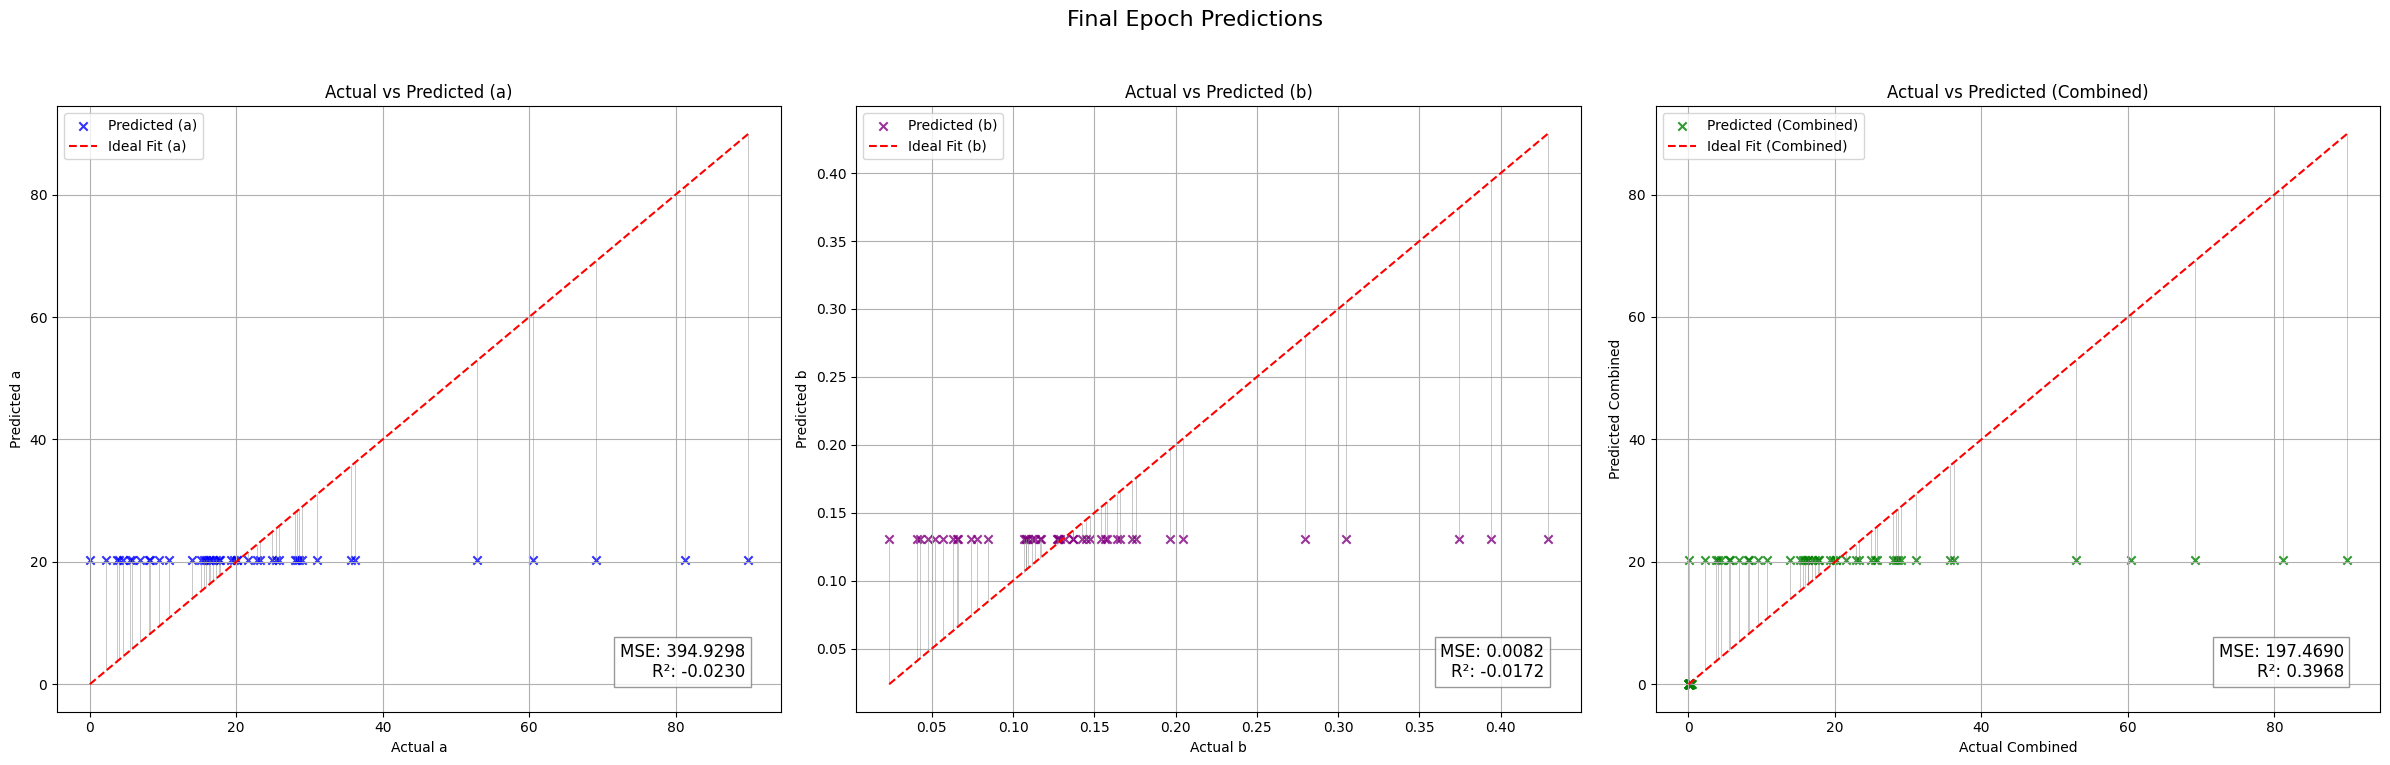

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 197.3764
  - R²: -0.0198
  - MAE: 6.4537
  - Explained Variance Score (EVS): 0.0000
Fold 1 Metrics:
  - Validation Loss (MSE): 197.3764
  - R²: -0.0198
  - MAE: 6.4537
  - EVS: 0.0000
Fold 2/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 87.25it/s, loss=0.558]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3887, Val Loss: 98.3532
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 98.62it/s, loss=0.72] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.5102
  - R²: -0.1736
  - MAE: 5.9568
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.4002, Val Loss: 98.5102
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 101.35it/s, loss=0.256]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.5891
  - R²: -0.1723
  - MAE: 5.9603
  - Explained Variance Score (EVS): -0.0000
Epoch [3/50], Train Loss: 0.3569, Val Loss: 98.5891
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 101.16it/s, loss=0.185]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.8272
  - R²: -0.1746
  - MAE: 5.9710
  - Explained Variance Score (EVS): -0.0000
Epoch [4/50], Train Loss: 0.3491, Val Loss: 98.8272
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 101.59it/s, loss=0.479]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 99.2778
  - R²: -0.1776
  - MAE: 5.9903
  - Explained Variance Score (EVS): -0.0011
Epoch [5/50], Train Loss: 0.3756, Val Loss: 99.2778
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 97.64it/s, loss=0.496] 


Validation Metrics:
  - MSE: 99.0354
  - R²: -0.1761
  - MAE: 5.9774
  - Explained Variance Score (EVS): -0.0027
Epoch [6/50], Train Loss: 0.3801, Val Loss: 99.0354

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 100.93it/s, loss=0.426]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 98.8921
  - R²: -0.1763
  - MAE: 5.9699
  - Explained Variance Score (EVS): -0.0044
Epoch [7/50], Train Loss: 0.3774, Val Loss: 98.8921
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 86.34it/s, loss=0.427]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 99.1342
  - R²: -0.1796
  - MAE: 5.9760
  - Explained Variance Score (EVS): -0.0085
Epoch [8/50], Train Loss: 0.3787, Val Loss: 99.1342
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 94.60it/s, loss=0.315]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 99.4966
  - R²: -0.1826
  - MAE: 5.9822
  - Explained Variance Score (EVS): -0.0167
Epoch [9/50], Train Loss: 0.3737, Val Loss: 99.4966
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 100.54it/s, loss=0.474]

Validation Metrics:
  - MSE: 100.2707
  - R²: -0.1910
  - MAE: 6.0058
  - Explained Variance Score (EVS): -0.0258


<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch [10/50], Train Loss: 0.4129, Val Loss: 100.2707
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 79.89it/s, loss=0.485]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 100.3456
  - R²: -0.1925
  - MAE: 6.0127
  - Explained Variance Score (EVS): -0.0228
Epoch [11/50], Train Loss: 0.5327, Val Loss: 100.3456
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


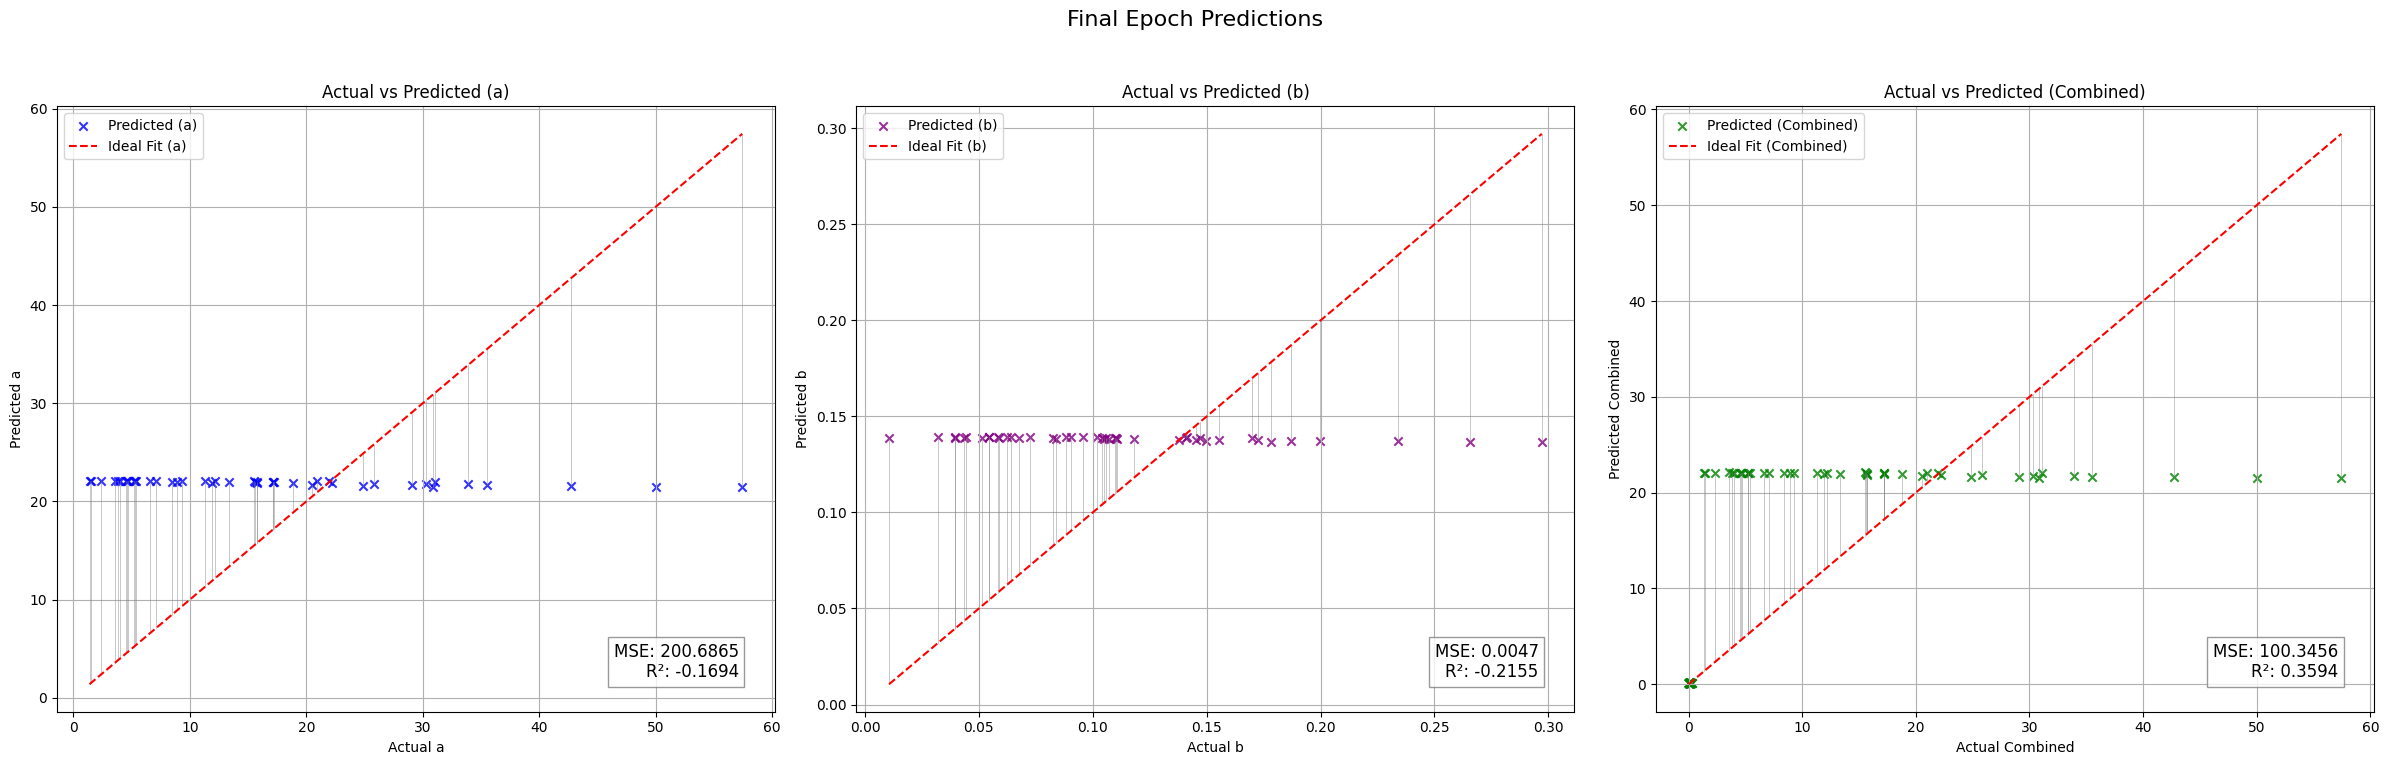

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - Explained Variance Score (EVS): -0.0000
Fold 2 Metrics:
  - Validation Loss (MSE): 98.3532
  - R²: -0.1709
  - MAE: 5.9496
  - EVS: -0.0000
Fold 3/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 103.06it/s, loss=0.383]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3691, Val Loss: 111.2922
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 104.68it/s, loss=0.347]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.4101
  - R²: -0.0017
  - MAE: 5.4479
  - Explained Variance Score (EVS): -0.0011
Epoch [2/50], Train Loss: 0.3746, Val Loss: 111.4101
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 92.12it/s, loss=0.627]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 114.8198
  - R²: -0.0299
  - MAE: 5.5473
  - Explained Variance Score (EVS): -0.0283
Epoch [3/50], Train Loss: 0.4922, Val Loss: 114.8198
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 83.69it/s, loss=1.28]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 122.2625
  - R²: -0.1038
  - MAE: 5.7578
  - Explained Variance Score (EVS): -0.0981
Epoch [4/50], Train Loss: 1.0750, Val Loss: 122.2625
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 80.46it/s, loss=0.203]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [5/50], Train Loss: 0.5226, Val Loss: 111.2922
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 96.15it/s, loss=0.474] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0006
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.3677, Val Loss: 111.2861
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 83.51it/s, loss=0.322]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3540, Val Loss: 111.2922
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 95.49it/s, loss=0.43] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.3631, Val Loss: 111.2922
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 90.19it/s, loss=0.403]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0006
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.3604, Val Loss: 111.2861
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 95.05it/s, loss=0.342]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3547, Val Loss: 111.2922
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 96.34it/s, loss=0.331] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.3535, Val Loss: 111.2922
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 6/6 [00:00<00:00, 82.84it/s, loss=0.252]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2802
  - R²: -0.0006
  - MAE: 5.4403
  - Explained Variance Score (EVS): -0.0000
Epoch [12/50], Train Loss: 0.3464, Val Loss: 111.2802
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 6/6 [00:00<00:00, 83.32it/s, loss=0.336]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [13/50], Train Loss: 0.3537, Val Loss: 111.2922
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 6/6 [00:00<00:00, 84.88it/s, loss=0.419]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [14/50], Train Loss: 0.3609, Val Loss: 111.2861
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 6/6 [00:00<00:00, 91.57it/s, loss=0.256]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2802
  - R²: -0.0006
  - MAE: 5.4403
  - Explained Variance Score (EVS): -0.0000
Epoch [15/50], Train Loss: 0.3464, Val Loss: 111.2802
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 6/6 [00:00<00:00, 91.01it/s, loss=0.437]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [16/50], Train Loss: 0.3624, Val Loss: 111.2922
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 6/6 [00:00<00:00, 90.02it/s, loss=0.402]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [17/50], Train Loss: 0.3592, Val Loss: 111.2861
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 6/6 [00:00<00:00, 95.76it/s, loss=0.414]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2747
  - R²: -0.0006
  - MAE: 5.4415
  - Explained Variance Score (EVS): -0.0000
Epoch [18/50], Train Loss: 0.3602, Val Loss: 111.2747
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 6/6 [00:00<00:00, 78.31it/s, loss=0.276]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2747
  - R²: -0.0006
  - MAE: 5.4415
  - Explained Variance Score (EVS): -0.0000
Epoch [19/50], Train Loss: 0.3482, Val Loss: 111.2747
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 6/6 [00:00<00:00, 93.87it/s, loss=0.255]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [20/50], Train Loss: 0.3463, Val Loss: 111.2922
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 6/6 [00:00<00:00, 85.13it/s, loss=0.427]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0007
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [21/50], Train Loss: 0.3617, Val Loss: 111.2922
Current Dropout Rate: 0.3400


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 6/6 [00:00<00:00, 76.55it/s, loss=0.184]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [22/50], Train Loss: 0.3405, Val Loss: 111.2861
Current Dropout Rate: 0.3320


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 6/6 [00:00<00:00, 81.23it/s, loss=0.412]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2985
  - R²: -0.0008
  - MAE: 5.4371
  - Explained Variance Score (EVS): -0.0000
Epoch [23/50], Train Loss: 0.3614, Val Loss: 111.2985
Current Dropout Rate: 0.3240


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24/50: 100%|██████████| 6/6 [00:00<00:00, 76.36it/s, loss=0.224]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2861
  - R²: -0.0007
  - MAE: 5.4392
  - Explained Variance Score (EVS): -0.0000
Epoch [24/50], Train Loss: 0.3463, Val Loss: 111.2861
Current Dropout Rate: 0.3160


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25/50: 100%|██████████| 6/6 [00:00<00:00, 89.94it/s, loss=0.249]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2922
  - R²: -0.0008
  - MAE: 5.4382
  - Explained Variance Score (EVS): -0.0000
Epoch [25/50], Train Loss: 0.3534, Val Loss: 111.2922
Current Dropout Rate: 0.3080


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26/50: 100%|██████████| 6/6 [00:00<00:00, 88.78it/s, loss=0.281]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2985
  - R²: -0.0009
  - MAE: 5.4371
  - Explained Variance Score (EVS): -0.0000
Epoch [26/50], Train Loss: 0.3753, Val Loss: 111.2985
Current Dropout Rate: 0.3000


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27/50: 100%|██████████| 6/6 [00:00<00:00, 59.99it/s, loss=0.494]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 111.2747
  - R²: -0.0006
  - MAE: 5.4415
  - Explained Variance Score (EVS): -0.0000
Epoch [27/50], Train Loss: 0.4695, Val Loss: 111.2747
Current Dropout Rate: 0.2920


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28/50: 100%|██████████| 6/6 [00:00<00:00, 72.90it/s, loss=0.609]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 111.2802
  - R²: -0.0006
  - MAE: 5.4403
  - Explained Variance Score (EVS): -0.0000
Epoch [28/50], Train Loss: 0.5597, Val Loss: 111.2802
Current Dropout Rate: 0.2840
Early stopping triggered!
Loading the best model for evaluation...


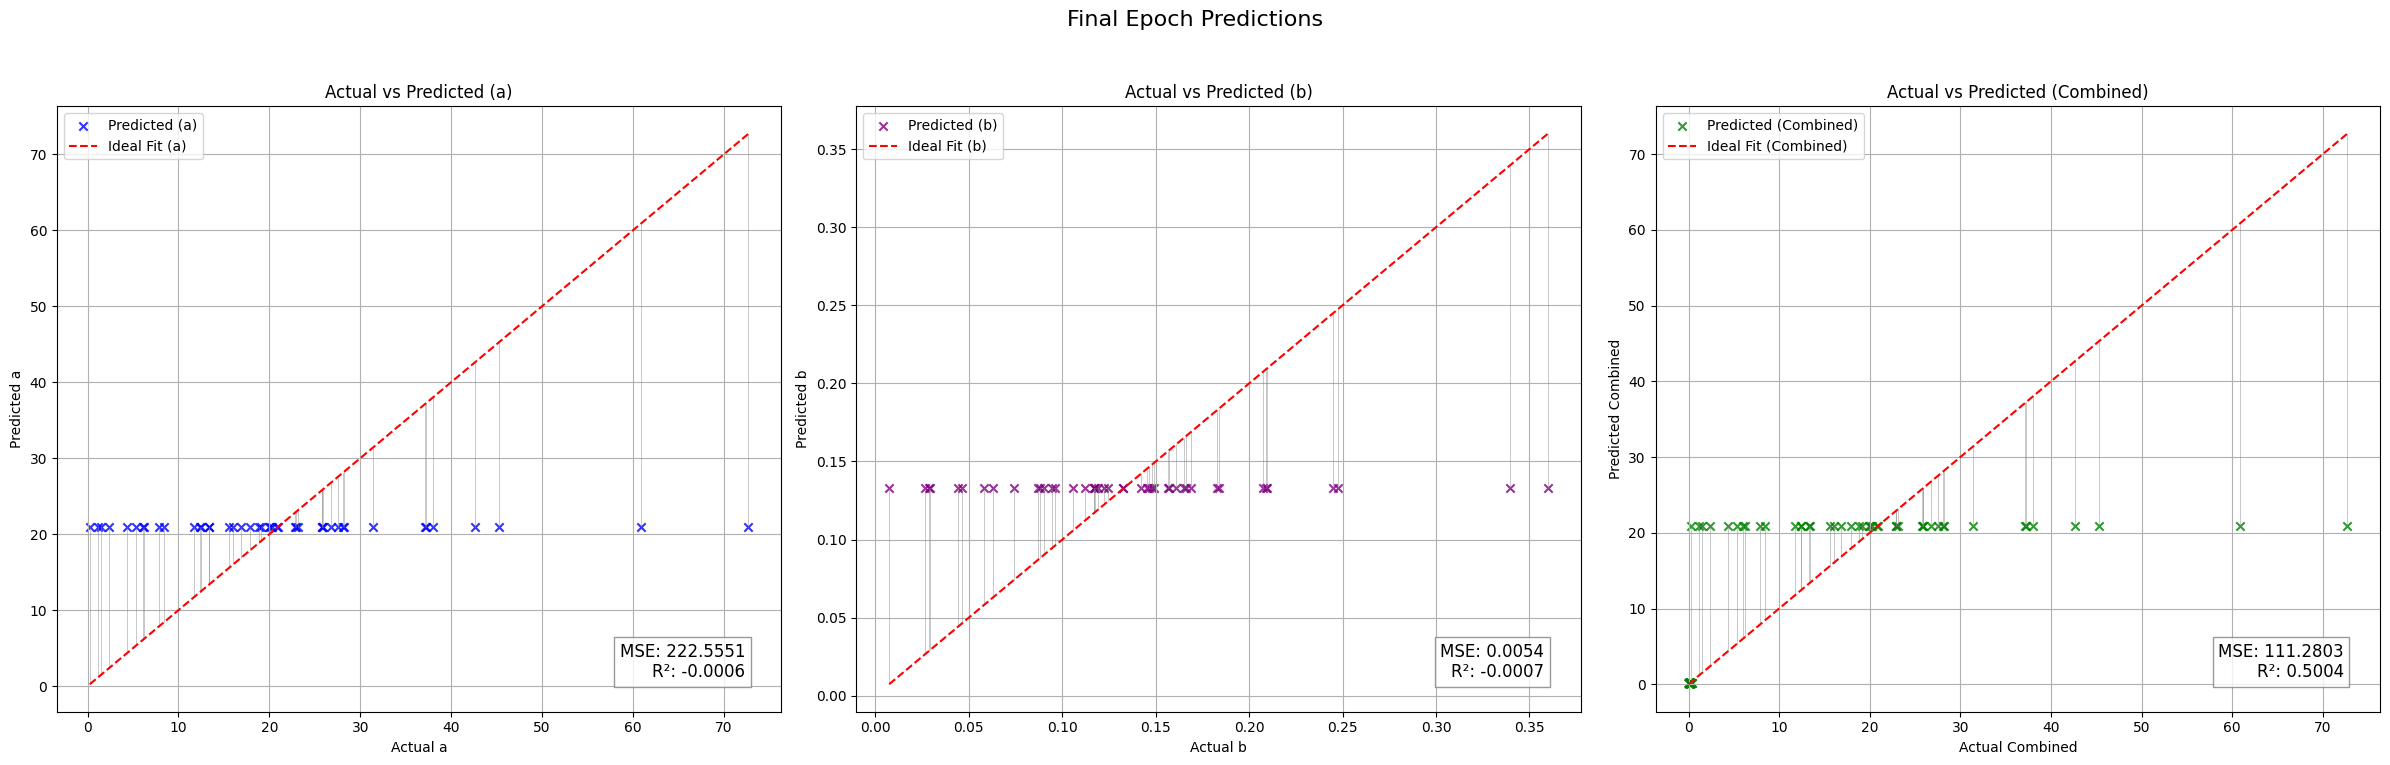

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 111.2747
  - R²: -0.0006
  - MAE: 5.4415
  - Explained Variance Score (EVS): -0.0000
Fold 3 Metrics:
  - Validation Loss (MSE): 111.2747
  - R²: -0.0006
  - MAE: 5.4415
  - EVS: -0.0000
Fold 4/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 101.55it/s, loss=0.56]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0438
  - R²: -0.0029
  - MAE: 5.9065
  - Explained Variance Score (EVS): -0.0000
Epoch [1/50], Train Loss: 0.3838, Val Loss: 94.0438
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 94.92it/s, loss=0.475]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0404
  - R²: -0.0030
  - MAE: 5.9051
  - Explained Variance Score (EVS): -0.0000
Epoch [2/50], Train Loss: 0.3782, Val Loss: 94.0404
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 89.82it/s, loss=0.233]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0956
  - R²: -0.0034
  - MAE: 5.9070
  - Explained Variance Score (EVS): -0.0004
Epoch [3/50], Train Loss: 0.3685, Val Loss: 94.0956
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 99.78it/s, loss=0.56] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.3282
  - R²: -0.0048
  - MAE: 5.9195
  - Explained Variance Score (EVS): -0.0021
Epoch [4/50], Train Loss: 0.4673, Val Loss: 94.3282
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 98.72it/s, loss=0.461] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.1079
  - R²: -0.0035
  - MAE: 5.9072
  - Explained Variance Score (EVS): -0.0006
Epoch [5/50], Train Loss: 0.4956, Val Loss: 94.1079
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 98.43it/s, loss=0.46] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [6/50], Train Loss: 0.3933, Val Loss: 94.0374
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 100.61it/s, loss=0.456]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0404
  - R²: -0.0029
  - MAE: 5.9051
  - Explained Variance Score (EVS): -0.0000
Epoch [7/50], Train Loss: 0.3738, Val Loss: 94.0404
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 93.84it/s, loss=0.319]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [8/50], Train Loss: 0.3618, Val Loss: 94.0374
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 93.53it/s, loss=0.247]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [9/50], Train Loss: 0.3554, Val Loss: 94.0374
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 83.00it/s, loss=0.498]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [10/50], Train Loss: 0.3776, Val Loss: 94.0374
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 56.25it/s, loss=0.83]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0404
  - R²: -0.0029
  - MAE: 5.9051
  - Explained Variance Score (EVS): -0.0000
Epoch [11/50], Train Loss: 0.4070, Val Loss: 94.0404
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 6/6 [00:00<00:00, 61.24it/s, loss=0.36]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0404
  - R²: -0.0029
  - MAE: 5.9051
  - Explained Variance Score (EVS): -0.0000
Epoch [12/50], Train Loss: 0.3653, Val Loss: 94.0404
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 6/6 [00:00<00:00, 86.29it/s, loss=0.705]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0404
  - R²: -0.0029
  - MAE: 5.9051
  - Explained Variance Score (EVS): -0.0000
Epoch [13/50], Train Loss: 0.3959, Val Loss: 94.0404
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 6/6 [00:00<00:00, 74.78it/s, loss=0.318]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [14/50], Train Loss: 0.3617, Val Loss: 94.0374
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 6/6 [00:00<00:00, 79.90it/s, loss=0.145]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [15/50], Train Loss: 0.3464, Val Loss: 94.0374
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 6/6 [00:00<00:00, 79.37it/s, loss=0.29]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Epoch [16/50], Train Loss: 0.3592, Val Loss: 94.0374
Current Dropout Rate: 0.3800
Early stopping triggered!
Loading the best model for evaluation...


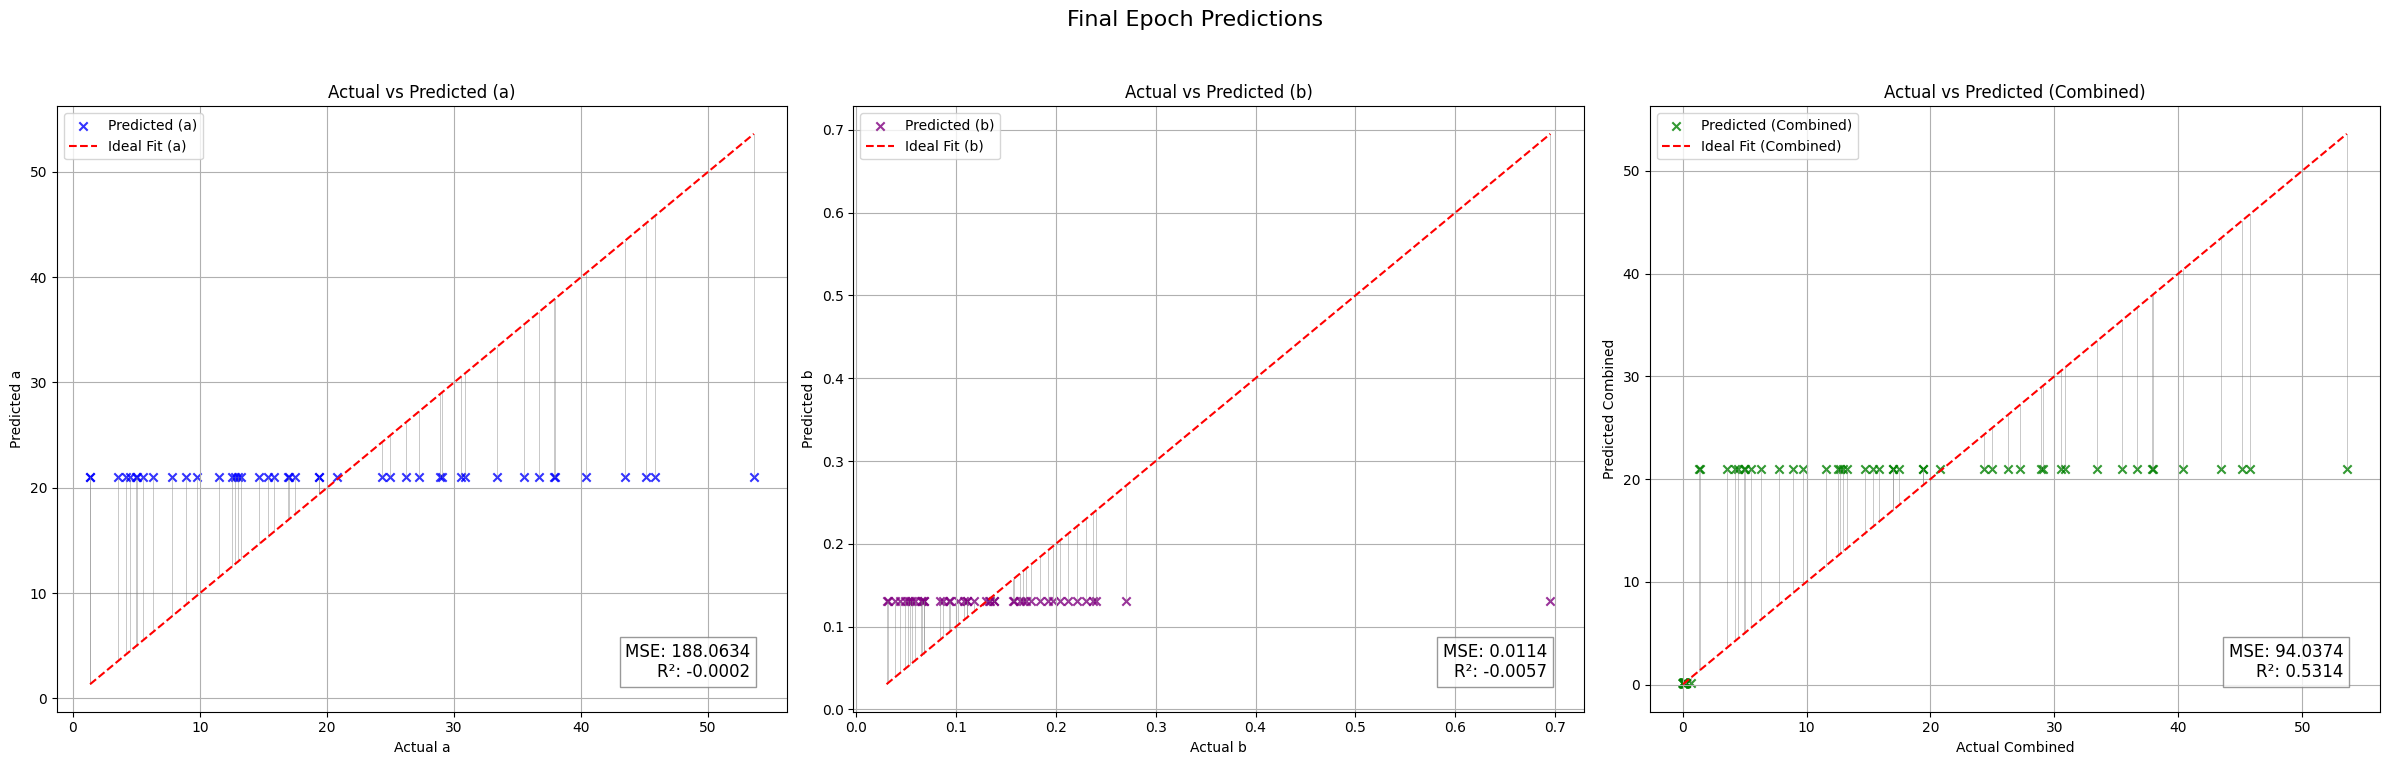

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - Explained Variance Score (EVS): -0.0000
Fold 4 Metrics:
  - Validation Loss (MSE): 94.0374
  - R²: -0.0030
  - MAE: 5.9036
  - EVS: -0.0000
Fold 5/5


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 6/6 [00:00<00:00, 94.21it/s, loss=0.331]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [1/50], Train Loss: 0.3615, Val Loss: 182.6491
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 6/6 [00:00<00:00, 76.09it/s, loss=0.34]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [2/50], Train Loss: 0.3622, Val Loss: 182.6491
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 6/6 [00:00<00:00, 77.41it/s, loss=0.336]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [3/50], Train Loss: 0.3619, Val Loss: 182.6491
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 6/6 [00:00<00:00, 74.85it/s, loss=0.641]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [4/50], Train Loss: 0.3873, Val Loss: 182.6491
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 6/6 [00:00<00:00, 69.80it/s, loss=0.272]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6196
  - R²: -0.0072
  - MAE: 6.7523
  - Explained Variance Score (EVS): 0.0000
Epoch [5/50], Train Loss: 0.3566, Val Loss: 182.6196
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 6/6 [00:00<00:00, 98.77it/s, loss=0.444] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [6/50], Train Loss: 0.3709, Val Loss: 182.6491
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 6/6 [00:00<00:00, 97.02it/s, loss=0.288] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [7/50], Train Loss: 0.3579, Val Loss: 182.6789
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 6/6 [00:00<00:00, 86.79it/s, loss=0.513]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6788
  - R²: -0.0073
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [8/50], Train Loss: 0.3766, Val Loss: 182.6788
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 6/6 [00:00<00:00, 86.86it/s, loss=0.264]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [9/50], Train Loss: 0.3559, Val Loss: 182.6491
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 6/6 [00:00<00:00, 90.25it/s, loss=0.428]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [10/50], Train Loss: 0.3695, Val Loss: 182.6789
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 6/6 [00:00<00:00, 96.76it/s, loss=0.311] 
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [11/50], Train Loss: 0.3598, Val Loss: 182.6789
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 6/6 [00:00<00:00, 87.07it/s, loss=0.392]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0072
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [12/50], Train Loss: 0.3664, Val Loss: 182.6491
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 6/6 [00:00<00:00, 71.15it/s, loss=0.249]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [13/50], Train Loss: 0.3546, Val Loss: 182.6491
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 6/6 [00:00<00:00, 84.64it/s, loss=0.129]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.6789
  - R²: -0.0074
  - MAE: 6.7492
  - Explained Variance Score (EVS): 0.0000
Epoch [14/50], Train Loss: 0.3446, Val Loss: 182.6789
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 6/6 [00:00<00:00, 82.78it/s, loss=0.207]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Validation Metrics:
  - MSE: 182.6491
  - R²: -0.0073
  - MAE: 6.7506
  - Explained Variance Score (EVS): 0.0000
Epoch [15/50], Train Loss: 0.3511, Val Loss: 182.6491
Current Dropout Rate: 0.3880
Early stopping triggered!
Loading the best model for evaluation...


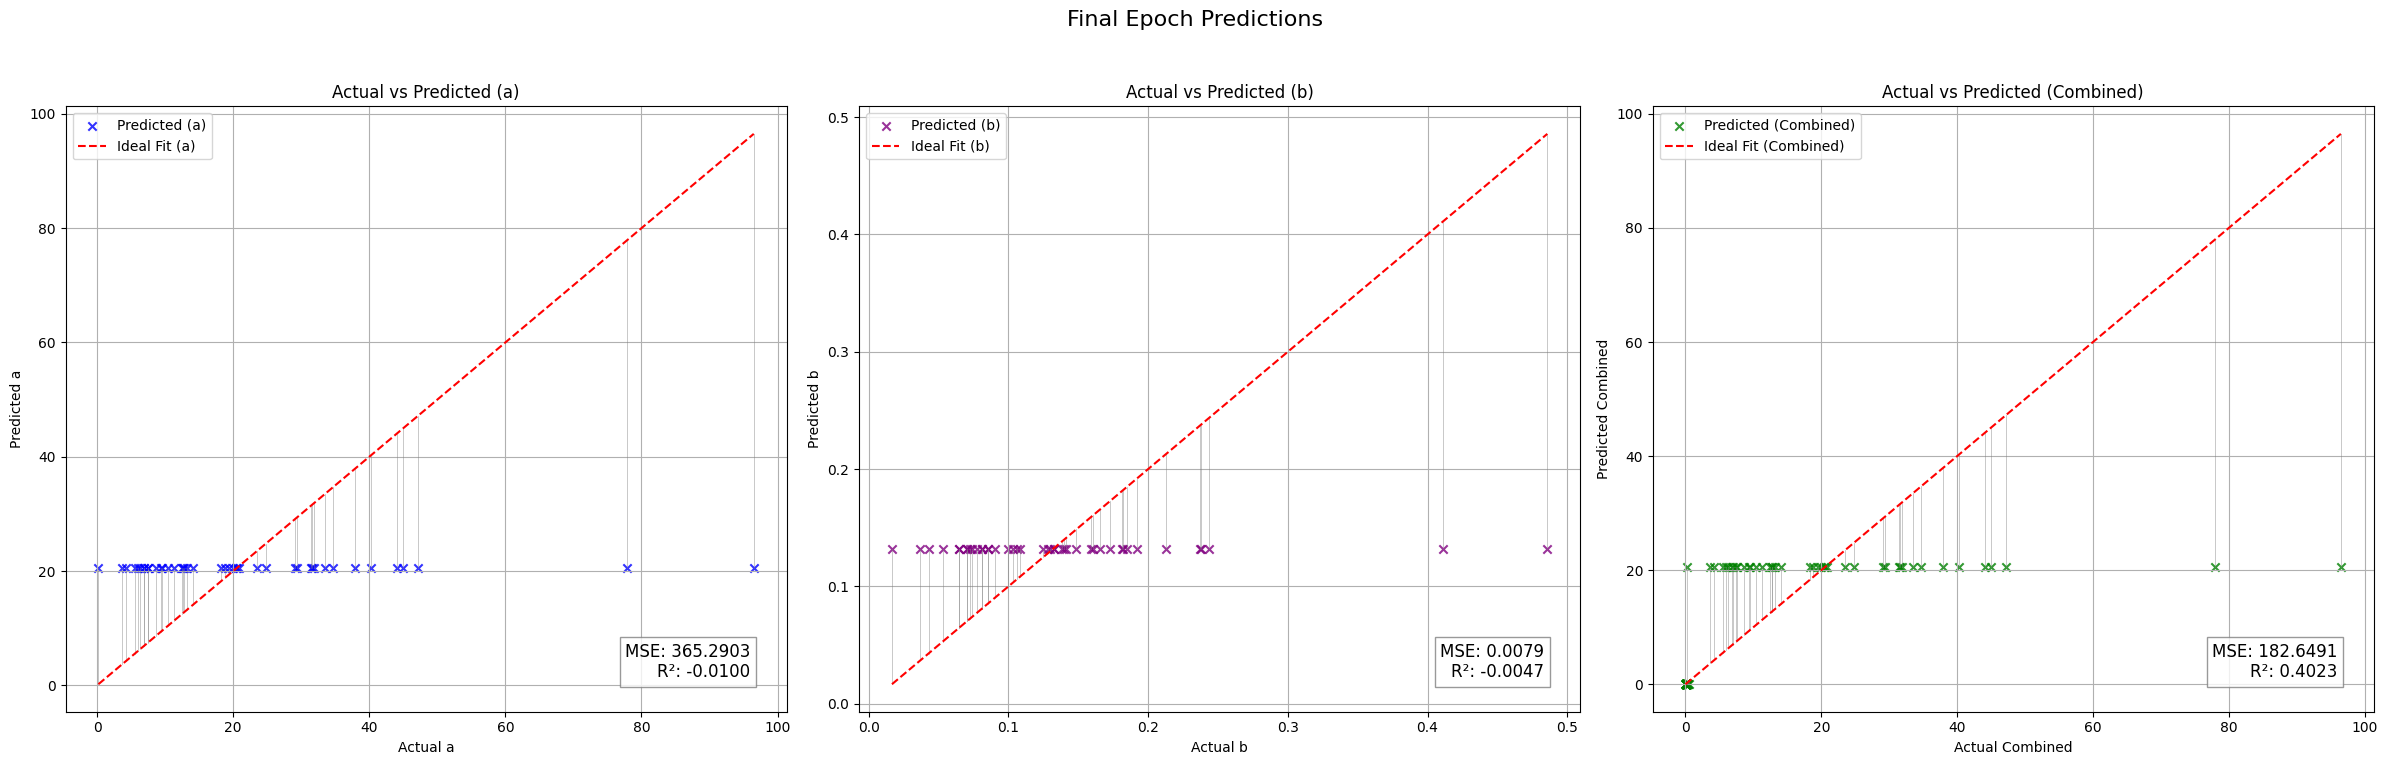

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[I 2024-11-30 07:27:49,343] Trial 5 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-11-452298e7c718>:709: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 182.6196
  - R²: -0.0072
  - MAE: 6.7523
  - Explained Variance Score (EVS): 0.0000
Fold 5 Metrics:
  - Validation Loss (MSE): 182.6196
  - R²: -0.0072
  - MAE: 6.7523
  - EVS: 0.0000
Avg Validation Metrics:
  - MSE: 136.7322
  - R²: -0.0403
  - MAE: 6.1002
  - EVS: -0.0000
Using device: cuda
Fold 1/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 42.78it/s, loss=2.27]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 196.6365
  - R²: -0.0268
  - MAE: 6.3552
  - Explained Variance Score (EVS): 0.0132
Epoch [1/50], Train Loss: 2.3000, Val Loss: 196.6365
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 42.19it/s, loss=2.23]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 206.1950
  - R²: -0.0654
  - MAE: 6.3819
  - Explained Variance Score (EVS): 0.1132
Epoch [2/50], Train Loss: 2.1445, Val Loss: 206.1950
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 39.67it/s, loss=1.98]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 182.1659
  - R²: 0.0563
  - MAE: 5.9993
  - Explained Variance Score (EVS): 0.3444
Epoch [3/50], Train Loss: 2.0745, Val Loss: 182.1659
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 44.14it/s, loss=1.93]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 143.4135
  - R²: 0.2670
  - MAE: 5.1521
  - Explained Variance Score (EVS): 0.4851
Epoch [4/50], Train Loss: 2.0612, Val Loss: 143.4135
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 37.55it/s, loss=1.85]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 107.0362
  - R²: 0.4797
  - MAE: 4.2401
  - Explained Variance Score (EVS): 0.5890
Epoch [5/50], Train Loss: 2.0015, Val Loss: 107.0362
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 43.66it/s, loss=1.89]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 78.6503
  - R²: 0.6300
  - MAE: 3.7845
  - Explained Variance Score (EVS): 0.6855
Epoch [6/50], Train Loss: 1.9484, Val Loss: 78.6503
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 44.62it/s, loss=1.78]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 71.4361
  - R²: 0.6669
  - MAE: 3.6712
  - Explained Variance Score (EVS): 0.7196
Epoch [7/50], Train Loss: 1.8821, Val Loss: 71.4361
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 40.45it/s, loss=1.81]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 71.6237
  - R²: 0.6589
  - MAE: 3.6904
  - Explained Variance Score (EVS): 0.7163
Epoch [8/50], Train Loss: 1.8308, Val Loss: 71.6237
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 49.94it/s, loss=1.71]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 57.3965
  - R²: 0.7197
  - MAE: 3.1924
  - Explained Variance Score (EVS): 0.7499
Epoch [9/50], Train Loss: 1.8195, Val Loss: 57.3965
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 43.44it/s, loss=1.77]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 58.2606
  - R²: 0.7076
  - MAE: 3.4837
  - Explained Variance Score (EVS): 0.7489
Epoch [10/50], Train Loss: 1.7190, Val Loss: 58.2606
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 49.99it/s, loss=1.61]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 45.6683
  - R²: 0.7818
  - MAE: 3.0228
  - Explained Variance Score (EVS): 0.8019
Epoch [11/50], Train Loss: 1.6522, Val Loss: 45.6683
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 50.07it/s, loss=1.59]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 74.3458
  - R²: 0.6425
  - MAE: 3.2340
  - Explained Variance Score (EVS): 0.7011
Epoch [12/50], Train Loss: 1.6178, Val Loss: 74.3458
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 43.66it/s, loss=1.78]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 71.9790
  - R²: 0.6338
  - MAE: 3.3703
  - Explained Variance Score (EVS): 0.7085
Epoch [13/50], Train Loss: 1.5793, Val Loss: 71.9790
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 55.99it/s, loss=1.4]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 63.5834
  - R²: 0.6987
  - MAE: 3.3410
  - Explained Variance Score (EVS): 0.7353
Epoch [14/50], Train Loss: 1.4947, Val Loss: 63.5834
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 54.53it/s, loss=1.32]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 79.6881
  - R²: 0.6269
  - MAE: 3.8867
  - Explained Variance Score (EVS): 0.7161
Epoch [15/50], Train Loss: 1.4201, Val Loss: 79.6881
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 49.13it/s, loss=1.33]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 73.0164
  - R²: 0.6521
  - MAE: 3.3354
  - Explained Variance Score (EVS): 0.7037
Epoch [16/50], Train Loss: 1.3528, Val Loss: 73.0164
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 53.50it/s, loss=1.56]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 78.4171
  - R²: 0.6184
  - MAE: 3.3145
  - Explained Variance Score (EVS): 0.6737
Epoch [17/50], Train Loss: 1.3013, Val Loss: 78.4171
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 49.14it/s, loss=1.38]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 70.5846
  - R²: 0.6608
  - MAE: 3.1858
  - Explained Variance Score (EVS): 0.7074
Epoch [18/50], Train Loss: 1.2427, Val Loss: 70.5846
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 52.52it/s, loss=1.1]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 61.0101
  - R²: 0.7127
  - MAE: 3.1426
  - Explained Variance Score (EVS): 0.7392
Epoch [19/50], Train Loss: 1.1775, Val Loss: 61.0101
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 47.34it/s, loss=1.12]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 56.7269
  - R²: 0.7287
  - MAE: 2.9780
  - Explained Variance Score (EVS): 0.7484
Epoch [20/50], Train Loss: 1.1224, Val Loss: 56.7269
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 51.61it/s, loss=1.07]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the funct

Validation Metrics:
  - MSE: 71.7316
  - R²: 0.6537
  - MAE: 3.3874
  - Explained Variance Score (EVS): 0.6869
Epoch [21/50], Train Loss: 1.0737, Val Loss: 71.7316
Current Dropout Rate: 0.3400
Early stopping triggered!
Loading the best model for evaluation...


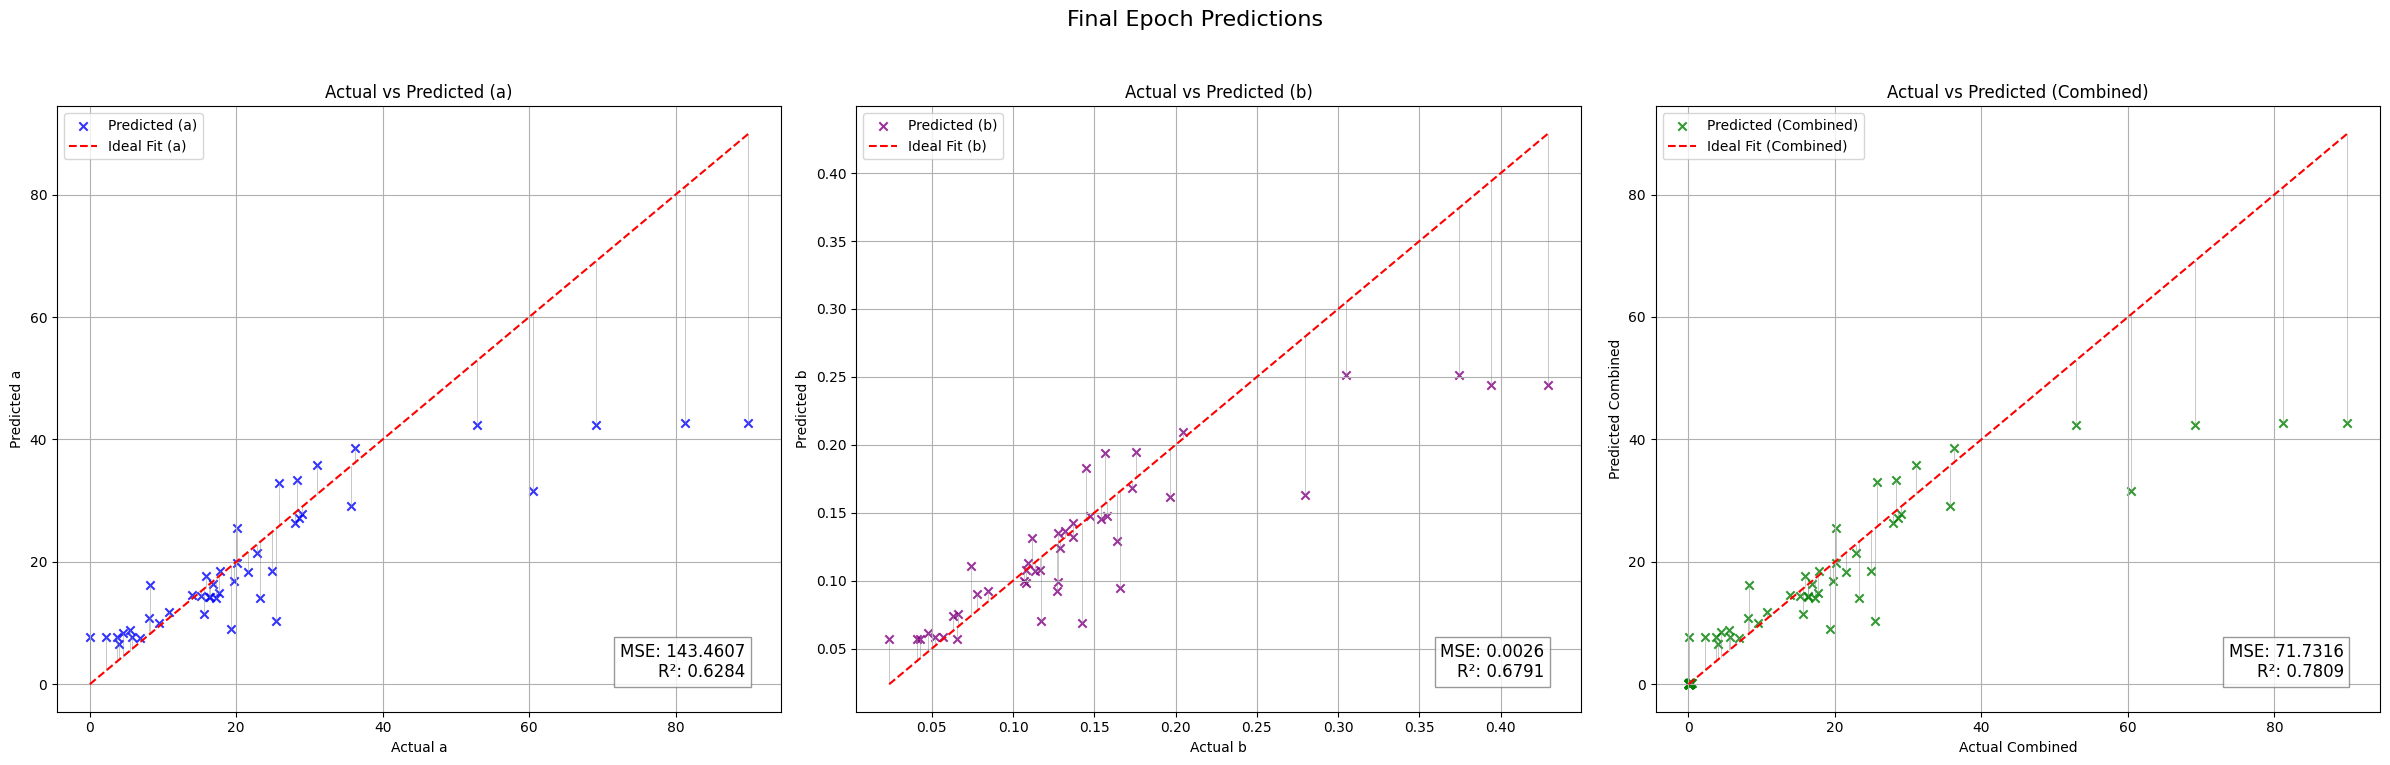

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 45.6683
  - R²: 0.7818
  - MAE: 3.0228
  - Explained Variance Score (EVS): 0.8019
Fold 1 Metrics:
  - Validation Loss (MSE): 45.6683
  - R²: 0.7818
  - MAE: 3.0228
  - EVS: 0.8019
Fold 2/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 51.66it/s, loss=1.62]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 9.2621
  - R²: 0.8807
  - MAE: 1.6758
  - Explained Variance Score (EVS): 0.8871
Epoch [1/50], Train Loss: 1.6783, Val Loss: 9.2621
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 48.14it/s, loss=1.56]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 6.5402
  - R²: 0.9001
  - MAE: 1.4163
  - Explained Variance Score (EVS): 0.9036
Epoch [2/50], Train Loss: 1.5968, Val Loss: 6.5402
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 43.34it/s, loss=1.56]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 7.3506
  - R²: 0.8845
  - MAE: 1.3770
  - Explained Variance Score (EVS): 0.8883
Epoch [3/50], Train Loss: 1.5449, Val Loss: 7.3506
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 43.14it/s, loss=1.4]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 10.5629
  - R²: 0.8766
  - MAE: 1.7185
  - Explained Variance Score (EVS): 0.8949
Epoch [4/50], Train Loss: 1.5027, Val Loss: 10.5629
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 42.17it/s, loss=1.47]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 11.3699
  - R²: 0.8636
  - MAE: 1.7839
  - Explained Variance Score (EVS): 0.8885
Epoch [5/50], Train Loss: 1.4432, Val Loss: 11.3699
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 36.60it/s, loss=1.29]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 10.2782
  - R²: 0.8714
  - MAE: 1.7591
  - Explained Variance Score (EVS): 0.8716
Epoch [6/50], Train Loss: 1.3695, Val Loss: 10.2782
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 47.68it/s, loss=1.18]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 9.4948
  - R²: 0.8767
  - MAE: 1.6672
  - Explained Variance Score (EVS): 0.8770
Epoch [7/50], Train Loss: 1.3375, Val Loss: 9.4948
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 37.08it/s, loss=1.2]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 10.3192
  - R²: 0.8508
  - MAE: 1.6252
  - Explained Variance Score (EVS): 0.8509
Epoch [8/50], Train Loss: 1.2410, Val Loss: 10.3192
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 39.07it/s, loss=1.21]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 8.8443
  - R²: 0.8861
  - MAE: 1.4452
  - Explained Variance Score (EVS): 0.8882
Epoch [9/50], Train Loss: 1.2079, Val Loss: 8.8443
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 47.03it/s, loss=1.11]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 9.1026
  - R²: 0.8729
  - MAE: 1.6762
  - Explained Variance Score (EVS): 0.8731
Epoch [10/50], Train Loss: 1.1561, Val Loss: 9.1026
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 42.06it/s, loss=1.09]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 10.6729
  - R²: 0.8646
  - MAE: 1.6326
  - Explained Variance Score (EVS): 0.8672
Epoch [11/50], Train Loss: 1.0940, Val Loss: 10.6729
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 51.93it/s, loss=1.02]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the funct

Validation Metrics:
  - MSE: 10.0164
  - R²: 0.8687
  - MAE: 1.6578
  - Explained Variance Score (EVS): 0.8690
Epoch [12/50], Train Loss: 1.0729, Val Loss: 10.0164
Current Dropout Rate: 0.4120
Early stopping triggered!
Loading the best model for evaluation...


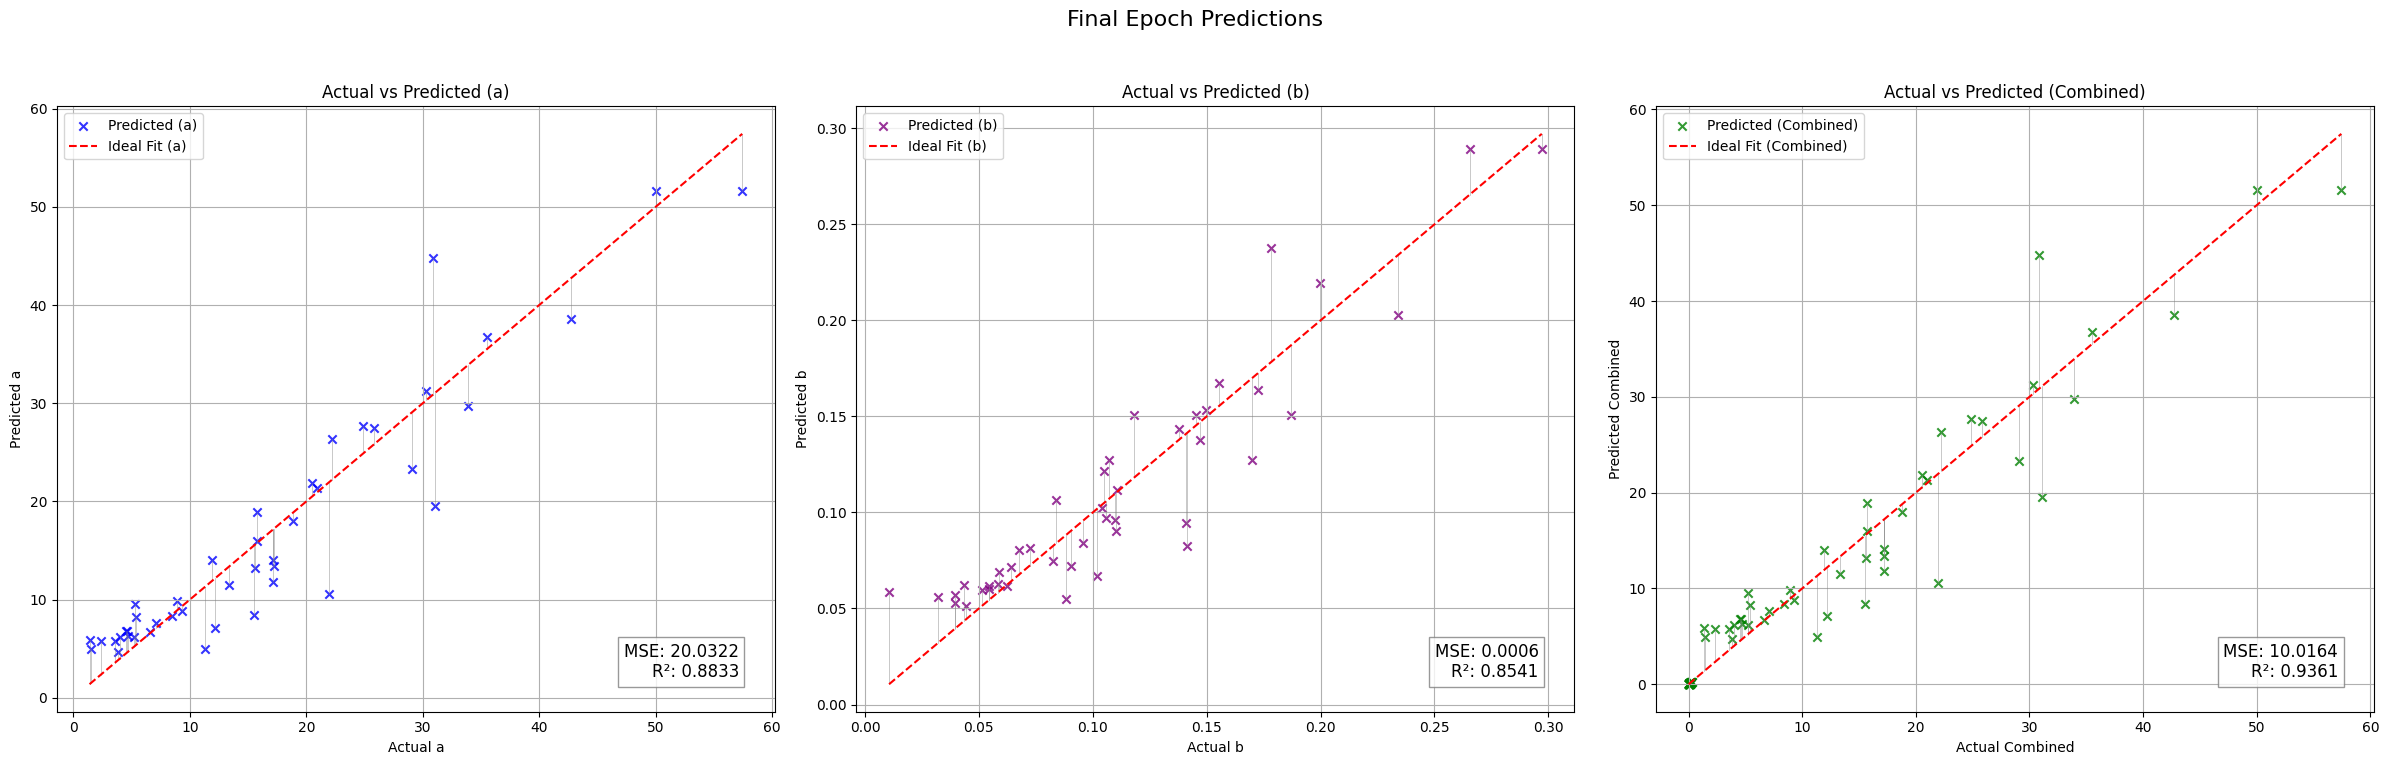

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 6.5402
  - R²: 0.9001
  - MAE: 1.4163
  - Explained Variance Score (EVS): 0.9036
Fold 2 Metrics:
  - Validation Loss (MSE): 6.5402
  - R²: 0.9001
  - MAE: 1.4163
  - EVS: 0.9036
Fold 3/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 45.65it/s, loss=1.48]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 19.5204
  - R²: 0.8066
  - MAE: 2.1034
  - Explained Variance Score (EVS): 0.8121
Epoch [1/50], Train Loss: 1.5660, Val Loss: 19.5204
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 41.52it/s, loss=1.51]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 20.4081
  - R²: 0.8085
  - MAE: 2.1838
  - Explained Variance Score (EVS): 0.8135
Epoch [2/50], Train Loss: 1.5242, Val Loss: 20.4081
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 36.60it/s, loss=1.44]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 20.1550
  - R²: 0.8167
  - MAE: 2.0931
  - Explained Variance Score (EVS): 0.8230
Epoch [3/50], Train Loss: 1.5073, Val Loss: 20.1550
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 48.18it/s, loss=1.41]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 18.2371
  - R²: 0.8288
  - MAE: 1.9288
  - Explained Variance Score (EVS): 0.8303
Epoch [4/50], Train Loss: 1.4566, Val Loss: 18.2371
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 41.23it/s, loss=1.65]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 19.2004
  - R²: 0.8232
  - MAE: 2.0293
  - Explained Variance Score (EVS): 0.8309
Epoch [5/50], Train Loss: 1.4339, Val Loss: 19.2004
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 39.34it/s, loss=1.43]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 19.4629
  - R²: 0.8128
  - MAE: 2.0492
  - Explained Variance Score (EVS): 0.8211
Epoch [6/50], Train Loss: 1.4051, Val Loss: 19.4629
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 40.94it/s, loss=1.39]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 18.3266
  - R²: 0.8169
  - MAE: 1.9802
  - Explained Variance Score (EVS): 0.8176
Epoch [7/50], Train Loss: 1.3766, Val Loss: 18.3266
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 42.01it/s, loss=1.36]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 19.5875
  - R²: 0.8092
  - MAE: 2.1597
  - Explained Variance Score (EVS): 0.8148
Epoch [8/50], Train Loss: 1.3342, Val Loss: 19.5875
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 45.78it/s, loss=1.27]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 18.9308
  - R²: 0.8171
  - MAE: 2.0147
  - Explained Variance Score (EVS): 0.8230
Epoch [9/50], Train Loss: 1.3014, Val Loss: 18.9308
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 42.66it/s, loss=1.19]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 18.8887
  - R²: 0.8212
  - MAE: 1.9558
  - Explained Variance Score (EVS): 0.8272
Epoch [10/50], Train Loss: 1.2737, Val Loss: 18.8887
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 41.06it/s, loss=1.6]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 19.1911
  - R²: 0.8211
  - MAE: 1.9547
  - Explained Variance Score (EVS): 0.8274
Epoch [11/50], Train Loss: 1.2314, Val Loss: 19.1911
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 44.75it/s, loss=1.15]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 18.2868
  - R²: 0.8236
  - MAE: 1.9483
  - Explained Variance Score (EVS): 0.8312
Epoch [12/50], Train Loss: 1.2185, Val Loss: 18.2868
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 43.53it/s, loss=1.11]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 17.6917
  - R²: 0.8257
  - MAE: 1.9373
  - Explained Variance Score (EVS): 0.8273
Epoch [13/50], Train Loss: 1.2202, Val Loss: 17.6917
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 39.24it/s, loss=1.09]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 18.1263
  - R²: 0.8193
  - MAE: 1.9235
  - Explained Variance Score (EVS): 0.8227
Epoch [14/50], Train Loss: 1.2036, Val Loss: 18.1263
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 53.18it/s, loss=1.25]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 18.8341
  - R²: 0.8163
  - MAE: 1.9862
  - Explained Variance Score (EVS): 0.8270
Epoch [15/50], Train Loss: 1.1698, Val Loss: 18.8341
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 44.86it/s, loss=1.07]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 17.7186
  - R²: 0.8244
  - MAE: 1.9063
  - Explained Variance Score (EVS): 0.8289
Epoch [16/50], Train Loss: 1.1636, Val Loss: 17.7186
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 38.97it/s, loss=1.04]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 18.6825
  - R²: 0.8128
  - MAE: 2.0046
  - Explained Variance Score (EVS): 0.8222
Epoch [17/50], Train Loss: 1.1270, Val Loss: 18.6825
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 44.72it/s, loss=1.22]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 19.4354
  - R²: 0.8079
  - MAE: 2.0884
  - Explained Variance Score (EVS): 0.8194
Epoch [18/50], Train Loss: 1.1383, Val Loss: 19.4354
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 38.63it/s, loss=1.23]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 20.4471
  - R²: 0.8023
  - MAE: 2.1555
  - Explained Variance Score (EVS): 0.8180
Epoch [19/50], Train Loss: 1.0912, Val Loss: 20.4471
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 40.77it/s, loss=1.08]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 19.3070
  - R²: 0.8102
  - MAE: 2.1302
  - Explained Variance Score (EVS): 0.8202
Epoch [20/50], Train Loss: 1.0736, Val Loss: 19.3070
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 51.03it/s, loss=1.01]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 19.4986
  - R²: 0.8019
  - MAE: 2.0401
  - Explained Variance Score (EVS): 0.8078
Epoch [21/50], Train Loss: 1.0454, Val Loss: 19.4986
Current Dropout Rate: 0.3400


Epoch 22/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 51.65it/s, loss=1.04]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 20.0165
  - R²: 0.7957
  - MAE: 2.0501
  - Explained Variance Score (EVS): 0.8029
Epoch [22/50], Train Loss: 1.0583, Val Loss: 20.0165
Current Dropout Rate: 0.3320


Epoch 23/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 36.88it/s, loss=1.03]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the funct

Validation Metrics:
  - MSE: 19.0444
  - R²: 0.8077
  - MAE: 1.9726
  - Explained Variance Score (EVS): 0.8098
Epoch [23/50], Train Loss: 1.0378, Val Loss: 19.0444
Current Dropout Rate: 0.3240
Early stopping triggered!
Loading the best model for evaluation...


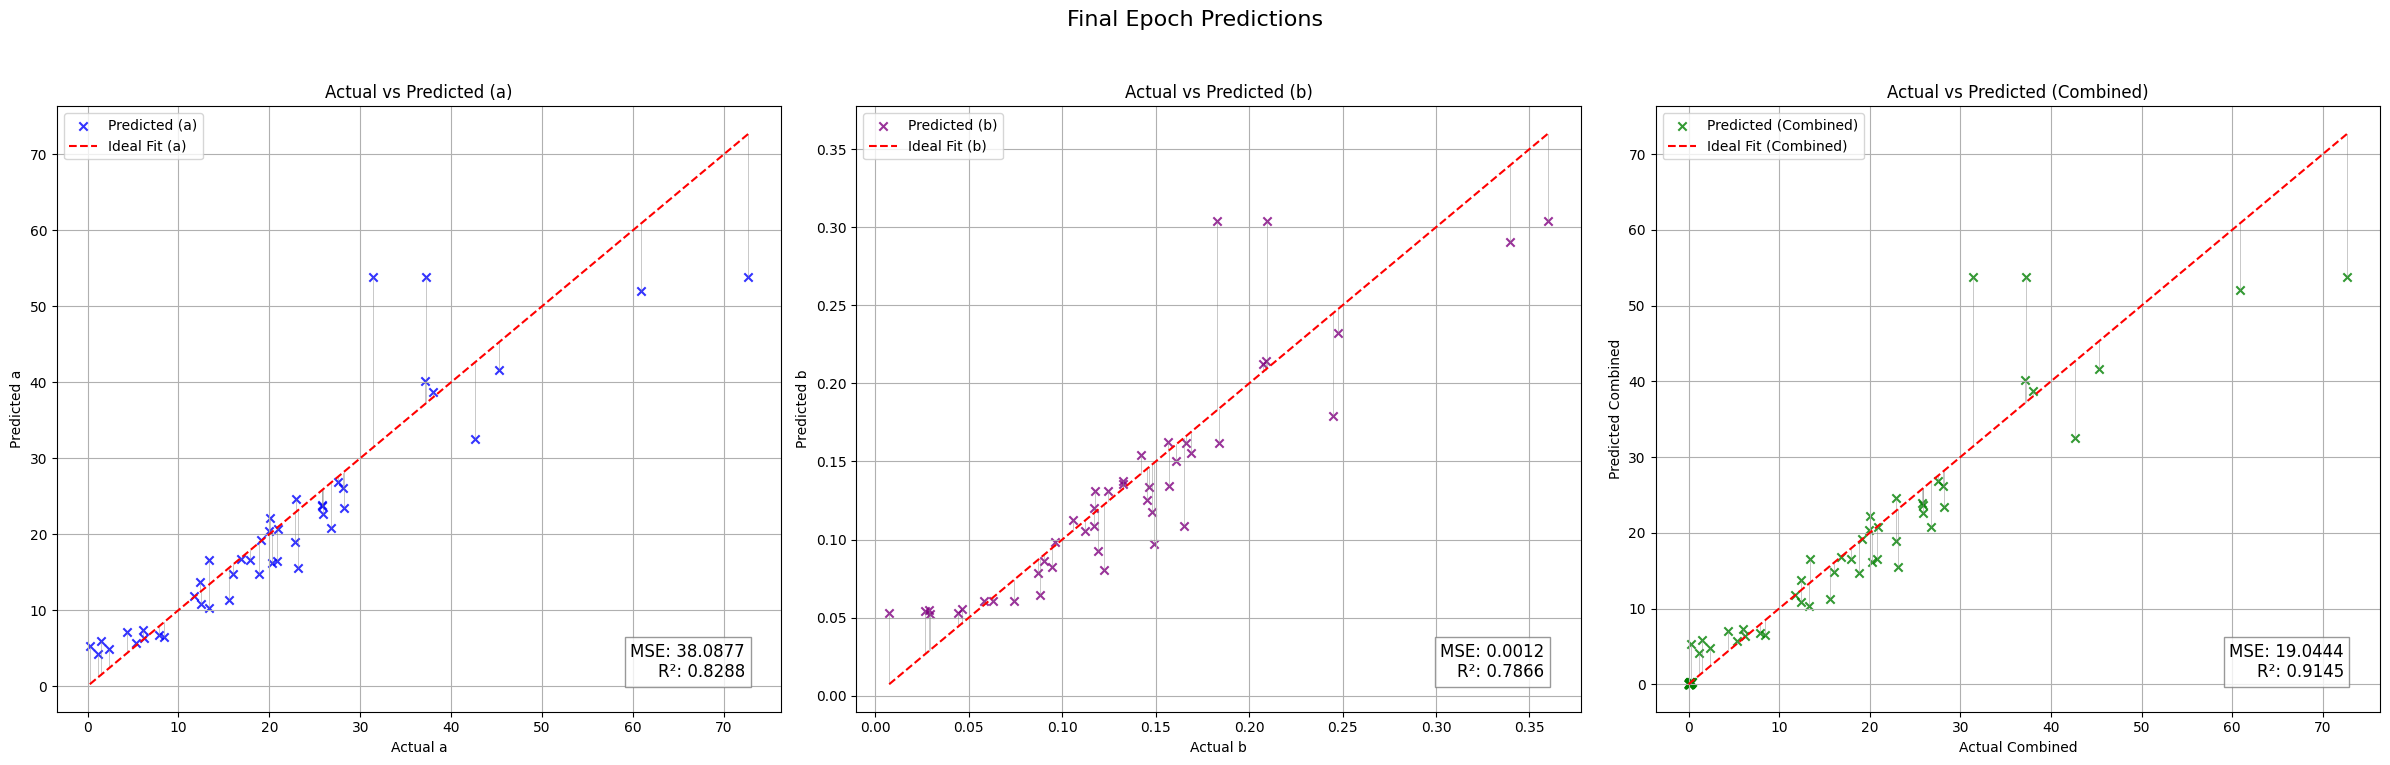

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 17.6917
  - R²: 0.8257
  - MAE: 1.9373
  - Explained Variance Score (EVS): 0.8273
Fold 3 Metrics:
  - Validation Loss (MSE): 17.6917
  - R²: 0.8257
  - MAE: 1.9373
  - EVS: 0.8273
Fold 4/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 44.15it/s, loss=1.21]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 23.3147
  - R²: 0.5488
  - MAE: 1.9557
  - Explained Variance Score (EVS): 0.5540
Epoch [1/50], Train Loss: 1.2053, Val Loss: 23.3147
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 53.13it/s, loss=1.45]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 25.1165
  - R²: 0.5366
  - MAE: 2.1030
  - Explained Variance Score (EVS): 0.5491
Epoch [2/50], Train Loss: 1.1920, Val Loss: 25.1165
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 40.10it/s, loss=1.11]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 28.2163
  - R²: 0.5209
  - MAE: 2.1905
  - Explained Variance Score (EVS): 0.5331
Epoch [3/50], Train Loss: 1.1608, Val Loss: 28.2163
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 42.95it/s, loss=1.23]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 27.4486
  - R²: 0.5254
  - MAE: 2.1824
  - Explained Variance Score (EVS): 0.5412
Epoch [4/50], Train Loss: 1.1461, Val Loss: 27.4486
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 51.21it/s, loss=1.26]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 29.5033
  - R²: 0.5169
  - MAE: 2.1936
  - Explained Variance Score (EVS): 0.5224
Epoch [5/50], Train Loss: 1.1329, Val Loss: 29.5033
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 48.91it/s, loss=1.06]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 29.7448
  - R²: 0.5133
  - MAE: 2.2373
  - Explained Variance Score (EVS): 0.5202
Epoch [6/50], Train Loss: 1.1101, Val Loss: 29.7448
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 51.19it/s, loss=1.08]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 30.3090
  - R²: 0.5088
  - MAE: 2.2357
  - Explained Variance Score (EVS): 0.5145
Epoch [7/50], Train Loss: 1.1140, Val Loss: 30.3090
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 51.32it/s, loss=1.1]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 31.2349
  - R²: 0.5039
  - MAE: 2.1888
  - Explained Variance Score (EVS): 0.5075
Epoch [8/50], Train Loss: 1.0881, Val Loss: 31.2349
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 52.46it/s, loss=1.03]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 33.2143
  - R²: 0.4885
  - MAE: 2.2864
  - Explained Variance Score (EVS): 0.4946
Epoch [9/50], Train Loss: 1.0645, Val Loss: 33.2143
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 44.07it/s, loss=1.01]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 33.6882
  - R²: 0.4859
  - MAE: 2.2951
  - Explained Variance Score (EVS): 0.4897
Epoch [10/50], Train Loss: 1.0688, Val Loss: 33.6882
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 51.90it/s, loss=1.02]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the funct

Validation Metrics:
  - MSE: 29.4101
  - R²: 0.5138
  - MAE: 2.2367
  - Explained Variance Score (EVS): 0.5197
Epoch [11/50], Train Loss: 1.0810, Val Loss: 29.4101
Current Dropout Rate: 0.4200
Early stopping triggered!
Loading the best model for evaluation...


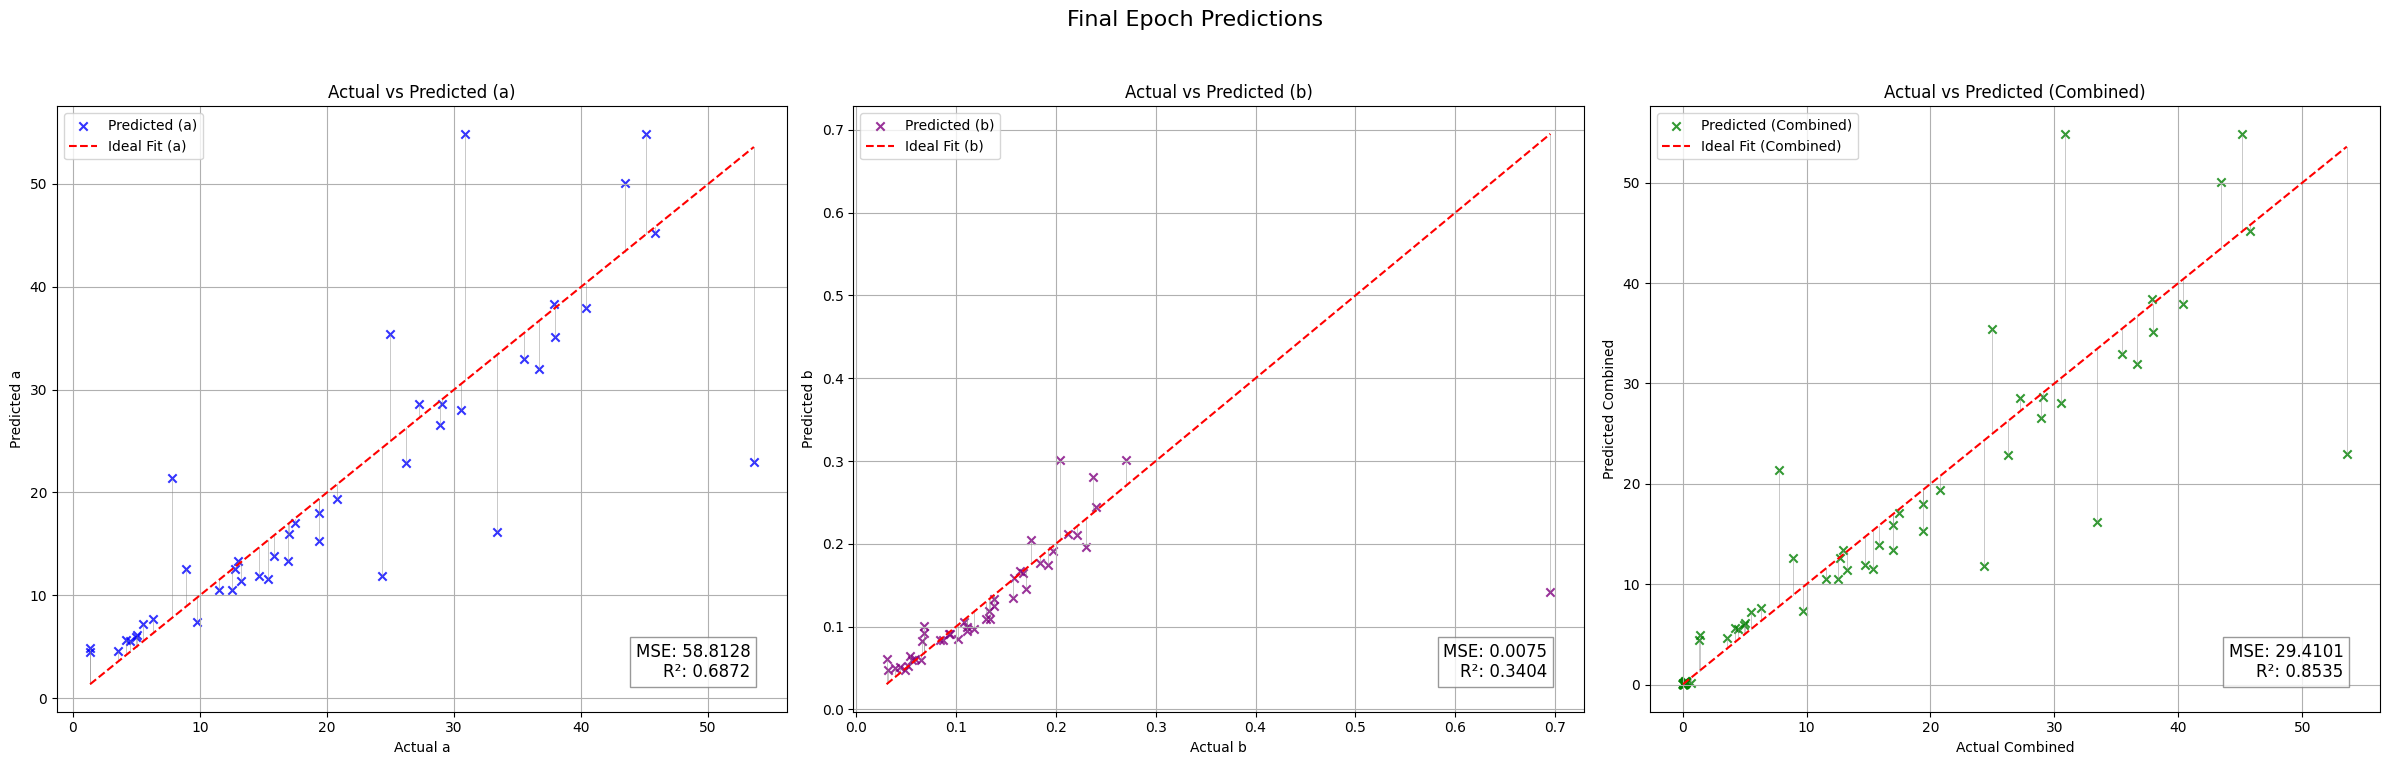

<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-452298e7c718>:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Validation Metrics:
  - MSE: 23.3147
  - R²: 0.5488
  - MAE: 1.9557
  - Explained Variance Score (EVS): 0.5540
Fold 4 Metrics:
  - Validation Loss (MSE): 23.3147
  - R²: 0.5488
  - MAE: 1.9557
  - EVS: 0.5540
Fold 5/5


Epoch 1/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 11/11 [00:00<00:00, 53.43it/s, loss=1.08]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 44.3747
  - R²: 0.7685
  - MAE: 2.0945
  - Explained Variance Score (EVS): 0.7805
Epoch [1/50], Train Loss: 1.1847, Val Loss: 44.3747
Current Dropout Rate: 0.5000


Epoch 2/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 11/11 [00:00<00:00, 52.58it/s, loss=1.1]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 43.2776
  - R²: 0.7739
  - MAE: 2.0018
  - Explained Variance Score (EVS): 0.7884
Epoch [2/50], Train Loss: 1.1997, Val Loss: 43.2776
Current Dropout Rate: 0.4920


Epoch 3/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 11/11 [00:00<00:00, 49.17it/s, loss=1.1]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 43.0579
  - R²: 0.7694
  - MAE: 1.9864
  - Explained Variance Score (EVS): 0.7856
Epoch [3/50], Train Loss: 1.1672, Val Loss: 43.0579
Current Dropout Rate: 0.4840


Epoch 4/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 11/11 [00:00<00:00, 48.39it/s, loss=1.09]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 40.9837
  - R²: 0.7804
  - MAE: 1.9056
  - Explained Variance Score (EVS): 0.7926
Epoch [4/50], Train Loss: 1.1703, Val Loss: 40.9837
Current Dropout Rate: 0.4760


Epoch 5/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 11/11 [00:00<00:00, 48.97it/s, loss=1.05]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 47.2827
  - R²: 0.7503
  - MAE: 2.1906
  - Explained Variance Score (EVS): 0.7711
Epoch [5/50], Train Loss: 1.1611, Val Loss: 47.2827
Current Dropout Rate: 0.4680


Epoch 6/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 11/11 [00:00<00:00, 47.71it/s, loss=1.11]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.9264
  - R²: 0.7796
  - MAE: 2.0143
  - Explained Variance Score (EVS): 0.7967
Epoch [6/50], Train Loss: 1.1601, Val Loss: 41.9264
Current Dropout Rate: 0.4600


Epoch 7/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 11/11 [00:00<00:00, 43.76it/s, loss=1.13]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.2371
  - R²: 0.7843
  - MAE: 1.9491
  - Explained Variance Score (EVS): 0.8002
Epoch [7/50], Train Loss: 1.1418, Val Loss: 41.2371
Current Dropout Rate: 0.4520


Epoch 8/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 11/11 [00:00<00:00, 54.80it/s, loss=1.04]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.6794
  - R²: 0.7789
  - MAE: 2.0194
  - Explained Variance Score (EVS): 0.7940
Epoch [8/50], Train Loss: 1.1237, Val Loss: 41.6794
Current Dropout Rate: 0.4440


Epoch 9/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 11/11 [00:00<00:00, 53.87it/s, loss=1.29]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.1998
  - R²: 0.7801
  - MAE: 2.0223
  - Explained Variance Score (EVS): 0.7954
Epoch [9/50], Train Loss: 1.1138, Val Loss: 41.1998
Current Dropout Rate: 0.4360


Epoch 10/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 11/11 [00:00<00:00, 49.10it/s, loss=1.08]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 43.2563
  - R²: 0.7703
  - MAE: 2.1112
  - Explained Variance Score (EVS): 0.7848
Epoch [10/50], Train Loss: 1.1020, Val Loss: 43.2563
Current Dropout Rate: 0.4280


Epoch 11/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 11/11 [00:00<00:00, 45.76it/s, loss=1.16]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 43.8353
  - R²: 0.7667
  - MAE: 2.1311
  - Explained Variance Score (EVS): 0.7882
Epoch [11/50], Train Loss: 1.1159, Val Loss: 43.8353
Current Dropout Rate: 0.4200


Epoch 12/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 11/11 [00:00<00:00, 50.57it/s, loss=1.03]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 42.6723
  - R²: 0.7713
  - MAE: 2.0923
  - Explained Variance Score (EVS): 0.7866
Epoch [12/50], Train Loss: 1.0894, Val Loss: 42.6723
Current Dropout Rate: 0.4120


Epoch 13/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 11/11 [00:00<00:00, 45.27it/s, loss=1.04]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 40.5130
  - R²: 0.7851
  - MAE: 2.0402
  - Explained Variance Score (EVS): 0.8020
Epoch [13/50], Train Loss: 1.1039, Val Loss: 40.5130
Current Dropout Rate: 0.4040


Epoch 14/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 11/11 [00:00<00:00, 48.26it/s, loss=1.1]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.5010
  - R²: 0.7788
  - MAE: 2.0659
  - Explained Variance Score (EVS): 0.7946
Epoch [14/50], Train Loss: 1.0796, Val Loss: 41.5010
Current Dropout Rate: 0.3960


Epoch 15/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 11/11 [00:00<00:00, 49.98it/s, loss=1.15]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 42.7432
  - R²: 0.7732
  - MAE: 2.1101
  - Explained Variance Score (EVS): 0.7953
Epoch [15/50], Train Loss: 1.0991, Val Loss: 42.7432
Current Dropout Rate: 0.3880


Epoch 16/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 11/11 [00:00<00:00, 48.06it/s, loss=1.09]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 44.0512
  - R²: 0.7663
  - MAE: 2.1396
  - Explained Variance Score (EVS): 0.7862
Epoch [16/50], Train Loss: 1.0785, Val Loss: 44.0512
Current Dropout Rate: 0.3800


Epoch 17/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 11/11 [00:00<00:00, 46.13it/s, loss=1.04]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 40.6303
  - R²: 0.7855
  - MAE: 2.0169
  - Explained Variance Score (EVS): 0.8005
Epoch [17/50], Train Loss: 1.0772, Val Loss: 40.6303
Current Dropout Rate: 0.3720


Epoch 18/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 11/11 [00:00<00:00, 48.08it/s, loss=1.04]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 43.2942
  - R²: 0.7707
  - MAE: 2.1141
  - Explained Variance Score (EVS): 0.7829
Epoch [18/50], Train Loss: 1.0580, Val Loss: 43.2942
Current Dropout Rate: 0.3640


Epoch 19/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 11/11 [00:00<00:00, 37.53it/s, loss=1.01]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 42.9337
  - R²: 0.7709
  - MAE: 2.1516
  - Explained Variance Score (EVS): 0.7855
Epoch [19/50], Train Loss: 1.0628, Val Loss: 42.9337
Current Dropout Rate: 0.3560


Epoch 20/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 11/11 [00:00<00:00, 46.37it/s, loss=1.06]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 39.4048
  - R²: 0.7877
  - MAE: 2.0690
  - Explained Variance Score (EVS): 0.7974
Epoch [20/50], Train Loss: 1.0632, Val Loss: 39.4048
Current Dropout Rate: 0.3480


Epoch 21/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 11/11 [00:00<00:00, 54.15it/s, loss=1.21]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 39.4181
  - R²: 0.7860
  - MAE: 2.0052
  - Explained Variance Score (EVS): 0.7967
Epoch [21/50], Train Loss: 1.0925, Val Loss: 39.4181
Current Dropout Rate: 0.3400


Epoch 22/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 11/11 [00:00<00:00, 44.74it/s, loss=0.998]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 38.0295
  - R²: 0.7941
  - MAE: 1.9403
  - Explained Variance Score (EVS): 0.8035
Epoch [22/50], Train Loss: 1.0624, Val Loss: 38.0295
Current Dropout Rate: 0.3320


Epoch 23/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 11/11 [00:00<00:00, 51.62it/s, loss=1.07]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.2494
  - R²: 0.7770
  - MAE: 2.0945
  - Explained Variance Score (EVS): 0.7917
Epoch [23/50], Train Loss: 1.0633, Val Loss: 41.2494
Current Dropout Rate: 0.3240


Epoch 24/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24/50: 100%|██████████| 11/11 [00:00<00:00, 47.37it/s, loss=1.1]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 42.4842
  - R²: 0.7692
  - MAE: 2.1155
  - Explained Variance Score (EVS): 0.7855
Epoch [24/50], Train Loss: 1.0303, Val Loss: 42.4842
Current Dropout Rate: 0.3160


Epoch 25/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25/50: 100%|██████████| 11/11 [00:00<00:00, 39.86it/s, loss=1.04]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 39.7065
  - R²: 0.7847
  - MAE: 1.9781
  - Explained Variance Score (EVS): 0.7956
Epoch [25/50], Train Loss: 1.0532, Val Loss: 39.7065
Current Dropout Rate: 0.3080


Epoch 26/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26/50: 100%|██████████| 11/11 [00:00<00:00, 41.70it/s, loss=1.07]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.1332
  - R²: 0.7764
  - MAE: 2.0389
  - Explained Variance Score (EVS): 0.7865
Epoch [26/50], Train Loss: 1.0470, Val Loss: 41.1332
Current Dropout Rate: 0.3000


Epoch 27/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27/50: 100%|██████████| 11/11 [00:00<00:00, 45.72it/s, loss=1.2]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 37.6177
  - R²: 0.7955
  - MAE: 1.8696
  - Explained Variance Score (EVS): 0.8040
Epoch [27/50], Train Loss: 1.0632, Val Loss: 37.6177
Current Dropout Rate: 0.2920


Epoch 28/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28/50: 100%|██████████| 11/11 [00:00<00:00, 43.34it/s, loss=0.958]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 40.5496
  - R²: 0.7791
  - MAE: 1.9936
  - Explained Variance Score (EVS): 0.7904
Epoch [28/50], Train Loss: 1.0583, Val Loss: 40.5496
Current Dropout Rate: 0.2840


Epoch 29/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29/50: 100%|██████████| 11/11 [00:00<00:00, 43.23it/s, loss=0.999]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.4837
  - R²: 0.7765
  - MAE: 2.0623
  - Explained Variance Score (EVS): 0.7891
Epoch [29/50], Train Loss: 1.0217, Val Loss: 41.4837
Current Dropout Rate: 0.2760


Epoch 30/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/50: 100%|██████████| 11/11 [00:00<00:00, 48.23it/s, loss=1.01]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 41.8376
  - R²: 0.7729
  - MAE: 2.0666
  - Explained Variance Score (EVS): 0.7850
Epoch [30/50], Train Loss: 1.0199, Val Loss: 41.8376
Current Dropout Rate: 0.2680


Epoch 31/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31/50: 100%|██████████| 11/11 [00:00<00:00, 49.52it/s, loss=1.04]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 42.9647
  - R²: 0.7676
  - MAE: 2.1024
  - Explained Variance Score (EVS): 0.7821
Epoch [31/50], Train Loss: 1.0163, Val Loss: 42.9647
Current Dropout Rate: 0.2600


Epoch 32/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32/50: 100%|██████████| 11/11 [00:00<00:00, 38.16it/s, loss=0.961]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 40.6057
  - R²: 0.7783
  - MAE: 2.0138
  - Explained Variance Score (EVS): 0.7924
Epoch [32/50], Train Loss: 1.0008, Val Loss: 40.6057
Current Dropout Rate: 0.2520


Epoch 33/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33/50: 100%|██████████| 11/11 [00:00<00:00, 39.58it/s, loss=0.994]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 40.3340
  - R²: 0.7818
  - MAE: 2.0307
  - Explained Variance Score (EVS): 0.7918
Epoch [33/50], Train Loss: 1.0026, Val Loss: 40.3340
Current Dropout Rate: 0.2440


Epoch 34/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34/50: 100%|██████████| 11/11 [00:00<00:00, 44.06it/s, loss=0.978]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 42.2646
  - R²: 0.7705
  - MAE: 2.0945
  - Explained Variance Score (EVS): 0.7867
Epoch [34/50], Train Loss: 1.0252, Val Loss: 42.2646
Current Dropout Rate: 0.2360


Epoch 35/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35/50: 100%|██████████| 11/11 [00:00<00:00, 46.03it/s, loss=0.969]
<ipython-input-11-452298e7c718>:472: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Metrics:
  - MSE: 40.3812
  - R²: 0.7814
  - MAE: 2.0511
  - Explained Variance Score (EVS): 0.7941
Epoch [35/50], Train Loss: 1.0214, Val Loss: 40.3812
Current Dropout Rate: 0.2280


Epoch 36/50:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-11-452298e7c718>:385: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36/50:  91%|█████████ | 10/11 [00:00<00:00, 40.47it/s, loss=0.961]

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Assume the DataPreprocessor class and its method `load_embeddings_and_targets` are already defined
# Replace `url` and `drive_path` with your actual data location or paths.
preprocessor = DataPreprocessor(url, drive_path)
data = preprocessor.data

# Generate embeddings and targets (if not already done)
embeddings, targets = preprocessor.load_embeddings_and_targets()

layer_config = layer_config = [
    {
        "hidden_size": 256,          # Number of neurons in the first hidden layer
        "activation": "ReLU",       # Activation function for this layer
        "dropout": 0.3              # Dropout rate for this layer
    },
    {
        "hidden_size": 128,          # Number of neurons in the second hidden layer
        "activation": "LeakyReLU",   # Activation function for this layer
        "dropout": 0.2               # Dropout rate for this layer
    },
    {
        "hidden_size": 64,           # Number of neurons in the third hidden layer
        "activation": "ELU",         # Activation function for this layer
        "dropout": 0.1               # Dropout rate for this layer
    }
]

SCHEDULERS = {
    "ReduceLROnPlateau": {
        "scheduler": optim.lr_scheduler.ReduceLROnPlateau,
        "params": {"mode": "min", "factor": 0.5, "patience": 10, "verbose": True}
    },
    "CyclicLR": {
        "scheduler": optim.lr_scheduler.CyclicLR,
        "params": {"base_lr": 1e-5, "max_lr": 1e-3, "step_size_up": 10, "mode": "triangular"}
    },
    "CosineAnnealingLR": {
        "scheduler": optim.lr_scheduler.CosineAnnealingLR,
        "params": {"T_max": 10, "eta_min": 1e-6}
    },
    "StepLR": {
        "scheduler": optim.lr_scheduler.StepLR,
        "params": {"step_size": 10, "gamma": 0.1}
    },
    "ExponentialLR": {
        "scheduler": optim.lr_scheduler.ExponentialLR,
        "params": {"gamma": 0.95}
    },
    "OneCycleLR": {
        "scheduler": optim.lr_scheduler.OneCycleLR,
        "params": {"max_lr": 1e-3, "steps_per_epoch": 100, "epochs": 10}
    }
}


# Initialize the pipeline with your data, including hyperparameters like dropout_rate and k_folds
pipeline = MolecularPredictorPipeline(
    embeddings=embeddings,
    targets=targets,
    layer_config=layer_config,
    optimizer_name='AdamW',  # You can change this to 'SGD' or 'RMSprop
    hidden_size=128,  # You can adjust this based on your requirement
    batch_size=32,    # Adjust this as needed
    learning_rate=0.001,  # Adjust as needed
    num_epochs=50,    # Number of training epochs
    patience=10,      # Patience for early stopping
    dropout_rate=0.5,  # Dropout rate for regularization (as added in the changes)
    k_folds=5,          # Using K-fold cross-validation for more robust evaluation
    clip_grad_norm=1.0, # gradient norm
    clip_grad_value=0.5, # gradient value
    scheduler_type="ReduceLROnPlateau",  # Choose a scheduler type from SCHEDULERS
    scheduler_params=SCHEDULERS["ReduceLROnPlateau"]["params"],
)

# Start the hyperparameter tuning process (Optuna)
print("Starting hyperparameter tuning...")
pipeline.tune_hyperparameters(n_trials=50)  # Tune over 50 trials (you can increase this number for better optimization)

# After tuning, the best hyperparameters will be printed.
# You can now use the best hyperparameters to train a model or make predictions.

# Once the tuning is complete, you can use the pipeline to train and evaluate the model.
print("\nTraining the model with the best hyperparameters...")

# Step 1: Create the training and validation datasets and dataloaders.
# Split the data for training and validation (80% training, 20% validation)
train_data, val_data, train_targets, val_targets = train_test_split(
    embeddings, targets, test_size=0.2, random_state=42
)

# Create datasets for training and validation
train_dataset = pipeline.MoleculeDataset(train_data, train_targets)
val_dataset = pipeline.MoleculeDataset(val_data, val_targets)

# Create DataLoader objects for both datasets
train_loader = DataLoader(train_dataset, batch_size=pipeline.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=pipeline.batch_size, shuffle=False)

# Step 2: Train the model using the provided data loaders
pipeline.train_model(train_loader, val_loader)

# Step 3: Evaluate the model on the validation set
print("\nEvaluating the model on the validation data...")
mse, r2 = pipeline.evaluate_model(val_loader, return_metrics=True)
print(f"Validation MSE: {mse:.4f}, R2: {r2:.4f}")

# Step 4: Save the trained model
pipeline.save_model('molecular_predictor.pth')

# Optionally, load the saved model (if needed)
pipeline.load_model('molecular_predictor.pth')

pipeline.load_model("best_overall_model.pth")
pipeline.model.eval()
print("Best model loaded for predictions.")


In [53]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

class CombinedPipeline:
    def __init__(self, embedding_model, regression_models, data):
        """
        Initialize the combined pipeline.

        Parameters:
        - embedding_model: Instance of the MolecularPredictorPipeline for embeddings-based predictions.
        - regression_models: Dictionary of regression models (e.g., {"lr": LinearRegression(), "rf": RandomForestRegressor()}).
        - data: Dataset containing features (X) and targets (a, b).
        """
        self.embedding_model = embedding_model
        self.regression_models = regression_models
        self.data = data
        self.scaler = StandardScaler()
        self.combination_weights = None

    def prepare_data(self, test_size=0.2, random_state=42):
        """
        Prepare and split the data into training and test sets.
        """
        numeric_data = self.data.select_dtypes(include=['number'])
        self.X = numeric_data.drop(columns=['a', 'b'])
        self.y = self.data[['a', 'b']]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

    def train_embedding_model(self):
        """
        Train the embedding model using its training procedure.
        """
        print("Training embedding model...")
        self.embedding_model.k_fold_cross_validation()

    def train_regression_models(self):
        """
        Train all specified regression models on the scaled data.
        """
        self.trained_models = {}
        for model_name, model in self.regression_models.items():
            print(f"Training regression model: {model_name}...")
            model.fit(self.X_train_scaled, self.y_train)
            self.trained_models[model_name] = model

    def combine_predictions(self, combination_method="weighted", weights=None):
        """
        Combine predictions from the embedding model and regression models.

        Parameters:
        - combination_method: "weighted" or "stacking".
        - weights: Optional list of weights for the models if using "weighted" method.

        Returns:
        - Combined predictions.
        """
        print("Combining predictions...")
        # Get embedding model predictions
        embedding_predictions = self.embedding_model.predict(self.X_test.values)

        # Get regression model predictions
        regression_predictions = np.array([
            model.predict(self.X_test_scaled) for model in self.trained_models.values()
        ])  # Shape: (num_models, num_samples, 2)

        # Combine predictions
        if combination_method == "weighted":
            if weights is None:
                weights = [1 / (len(self.trained_models) + 1)] * (len(self.trained_models) + 1)
            embedding_weight = weights[0]
            regression_weights = weights[1:]
            combined_predictions = (
                embedding_weight * embedding_predictions +
                np.sum([
                    regression_weight * regression_predictions[i]
                    for i, regression_weight in enumerate(regression_weights)
                ], axis=0)
            )
        elif combination_method == "stacking":
            # Use a meta-learner for stacking
            stacking_X = np.hstack([embedding_predictions] + list(regression_predictions))
            meta_model = LinearRegression()
            meta_model.fit(stacking_X, self.y_test)
            combined_predictions = meta_model.predict(stacking_X)
        else:
            raise ValueError("Invalid combination method. Use 'weighted' or 'stacking'.")

        return combined_predictions

    def evaluate_combined_model(self, combined_predictions):
        """
        Evaluate the combined model using MSE and R² scores.
        """
        mse_a = mean_squared_error(self.y_test['a'], combined_predictions[:, 0])
        mse_b = mean_squared_error(self.y_test['b'], combined_predictions[:, 1])
        mse_combined = mean_squared_error(self.y_test, combined_predictions)
        r2_combined = r2_score(self.y_test, combined_predictions)
        print(f"Combined Model - MSE for 'a': {mse_a:.4f}")
        print(f"Combined Model - MSE for 'b': {mse_b:.4f}")
        print(f"Combined Model - Combined MSE: {mse_combined:.4f}")
        print(f"Combined Model - R²: {r2_combined:.4f}")
        return mse_a, mse_b, mse_combined, r2_combined

    def run_pipeline(self, combination_method="weighted", weights=None):
        """
        Run the full pipeline: train models, combine predictions, and evaluate.
        """
        self.prepare_data()
        self.train_embedding_model()
        self.train_regression_models()
        combined_predictions = self.combine_predictions(combination_method, weights)
        return self.evaluate_combined_model(combined_predictions)

Loaded Embeddings
Using device: cuda
Training embedding model...
Fold 1/5
Epoch [1/50], Train Loss: 0.4893, Val Loss: 213.4357
Current Dropout Rate: 0.5000
Epoch [2/50], Train Loss: 0.4146, Val Loss: 197.0881
Current Dropout Rate: 0.4920
Epoch [3/50], Train Loss: 0.3119, Val Loss: 178.8284
Current Dropout Rate: 0.4840
Epoch [4/50], Train Loss: 0.3060, Val Loss: 154.6966
Current Dropout Rate: 0.4760
Epoch [5/50], Train Loss: 0.2564, Val Loss: 132.7649
Current Dropout Rate: 0.4680
Epoch [6/50], Train Loss: 0.2191, Val Loss: 116.5872
Current Dropout Rate: 0.4600
Epoch [7/50], Train Loss: 0.2038, Val Loss: 101.6138
Current Dropout Rate: 0.4520
Epoch [8/50], Train Loss: 0.1752, Val Loss: 92.6537
Current Dropout Rate: 0.4440
Epoch [9/50], Train Loss: 0.1663, Val Loss: 86.3615
Current Dropout Rate: 0.4360
Epoch [10/50], Train Loss: 0.1535, Val Loss: 86.0501
Current Dropout Rate: 0.4280
Epoch [11/50], Train Loss: 0.1464, Val Loss: 86.9181
Current Dropout Rate: 0.4200
Epoch [12/50], Train Loss:

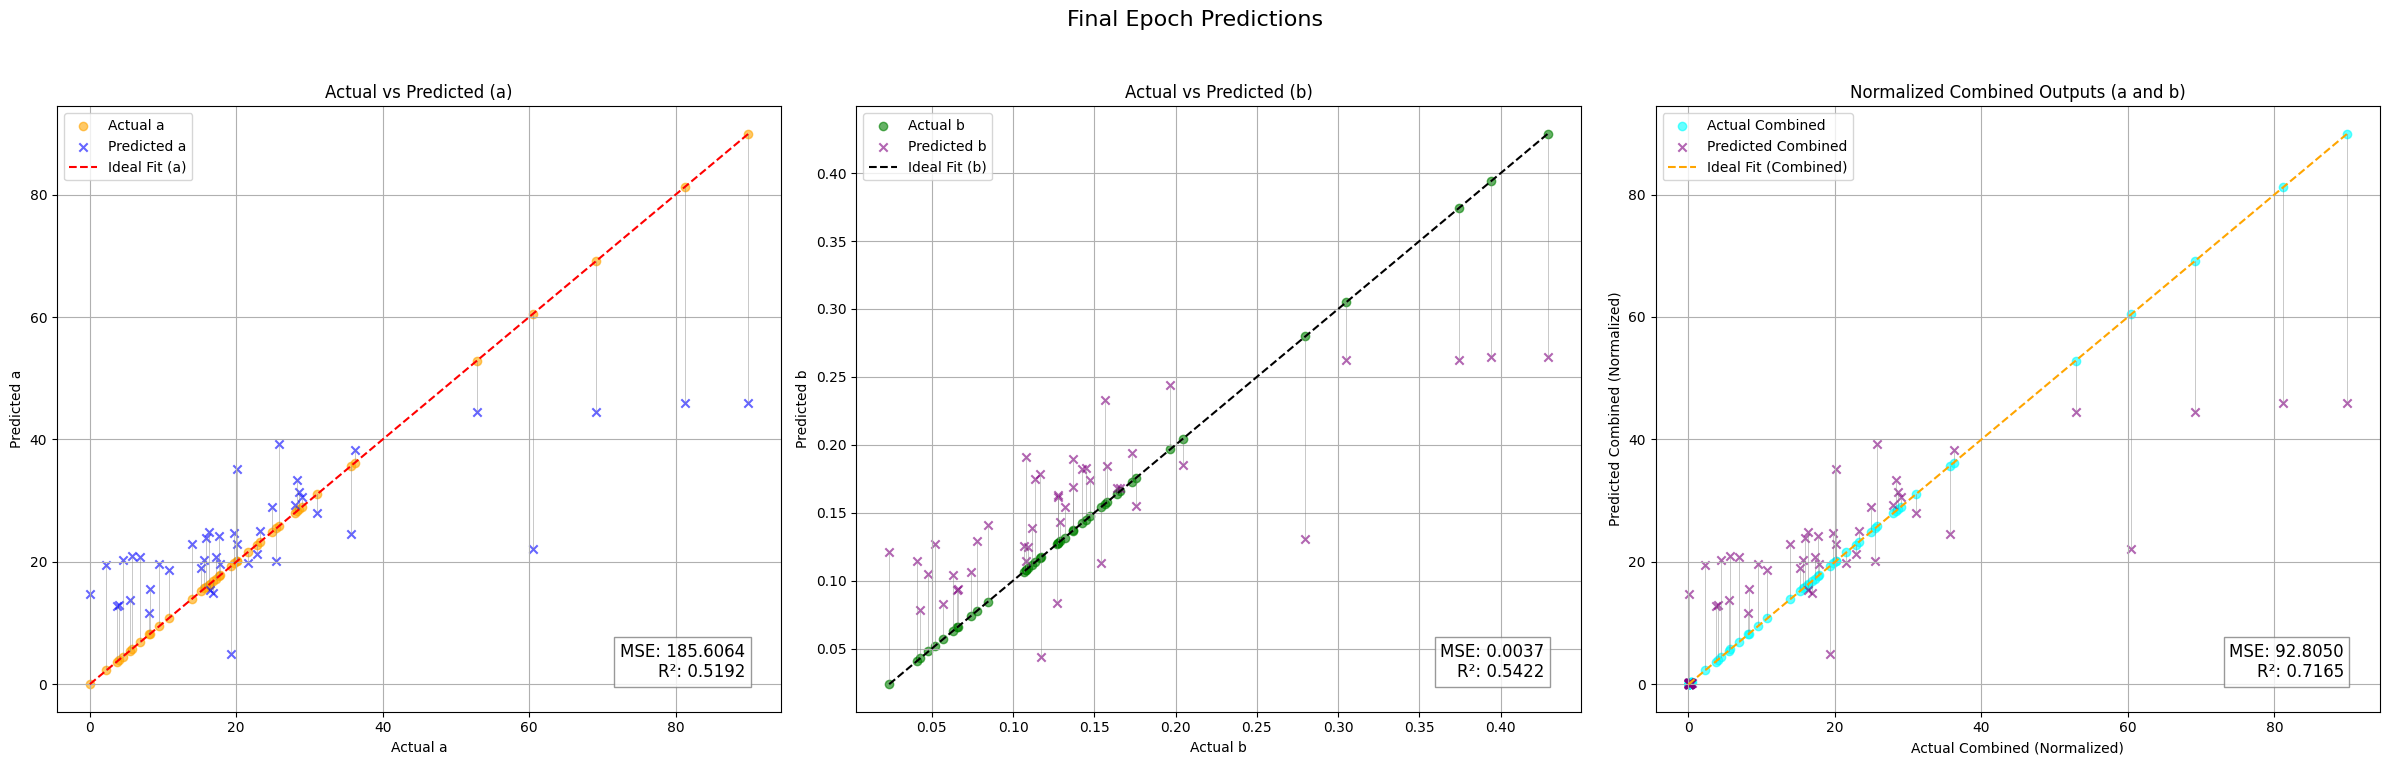

Fold 2/5
Epoch [1/50], Train Loss: 0.1574, Val Loss: 3.7515
Current Dropout Rate: 0.5000
Epoch [2/50], Train Loss: 0.1443, Val Loss: 4.0041
Current Dropout Rate: 0.4920
Epoch [3/50], Train Loss: 0.1323, Val Loss: 4.5239
Current Dropout Rate: 0.4840
Epoch [4/50], Train Loss: 0.1202, Val Loss: 4.8808
Current Dropout Rate: 0.4760
Epoch [5/50], Train Loss: 0.1104, Val Loss: 4.9871
Current Dropout Rate: 0.4680
Epoch [6/50], Train Loss: 0.1178, Val Loss: 5.2577
Current Dropout Rate: 0.4600
Epoch [7/50], Train Loss: 0.1041, Val Loss: 5.0671
Current Dropout Rate: 0.4520
Epoch [8/50], Train Loss: 0.1249, Val Loss: 5.1357
Current Dropout Rate: 0.4440
Epoch [9/50], Train Loss: 0.0993, Val Loss: 5.2092
Current Dropout Rate: 0.4360
Epoch [10/50], Train Loss: 0.1226, Val Loss: 5.0744
Current Dropout Rate: 0.4280
Epoch [11/50], Train Loss: 0.1011, Val Loss: 5.0602
Current Dropout Rate: 0.4200
Early stopping triggered!


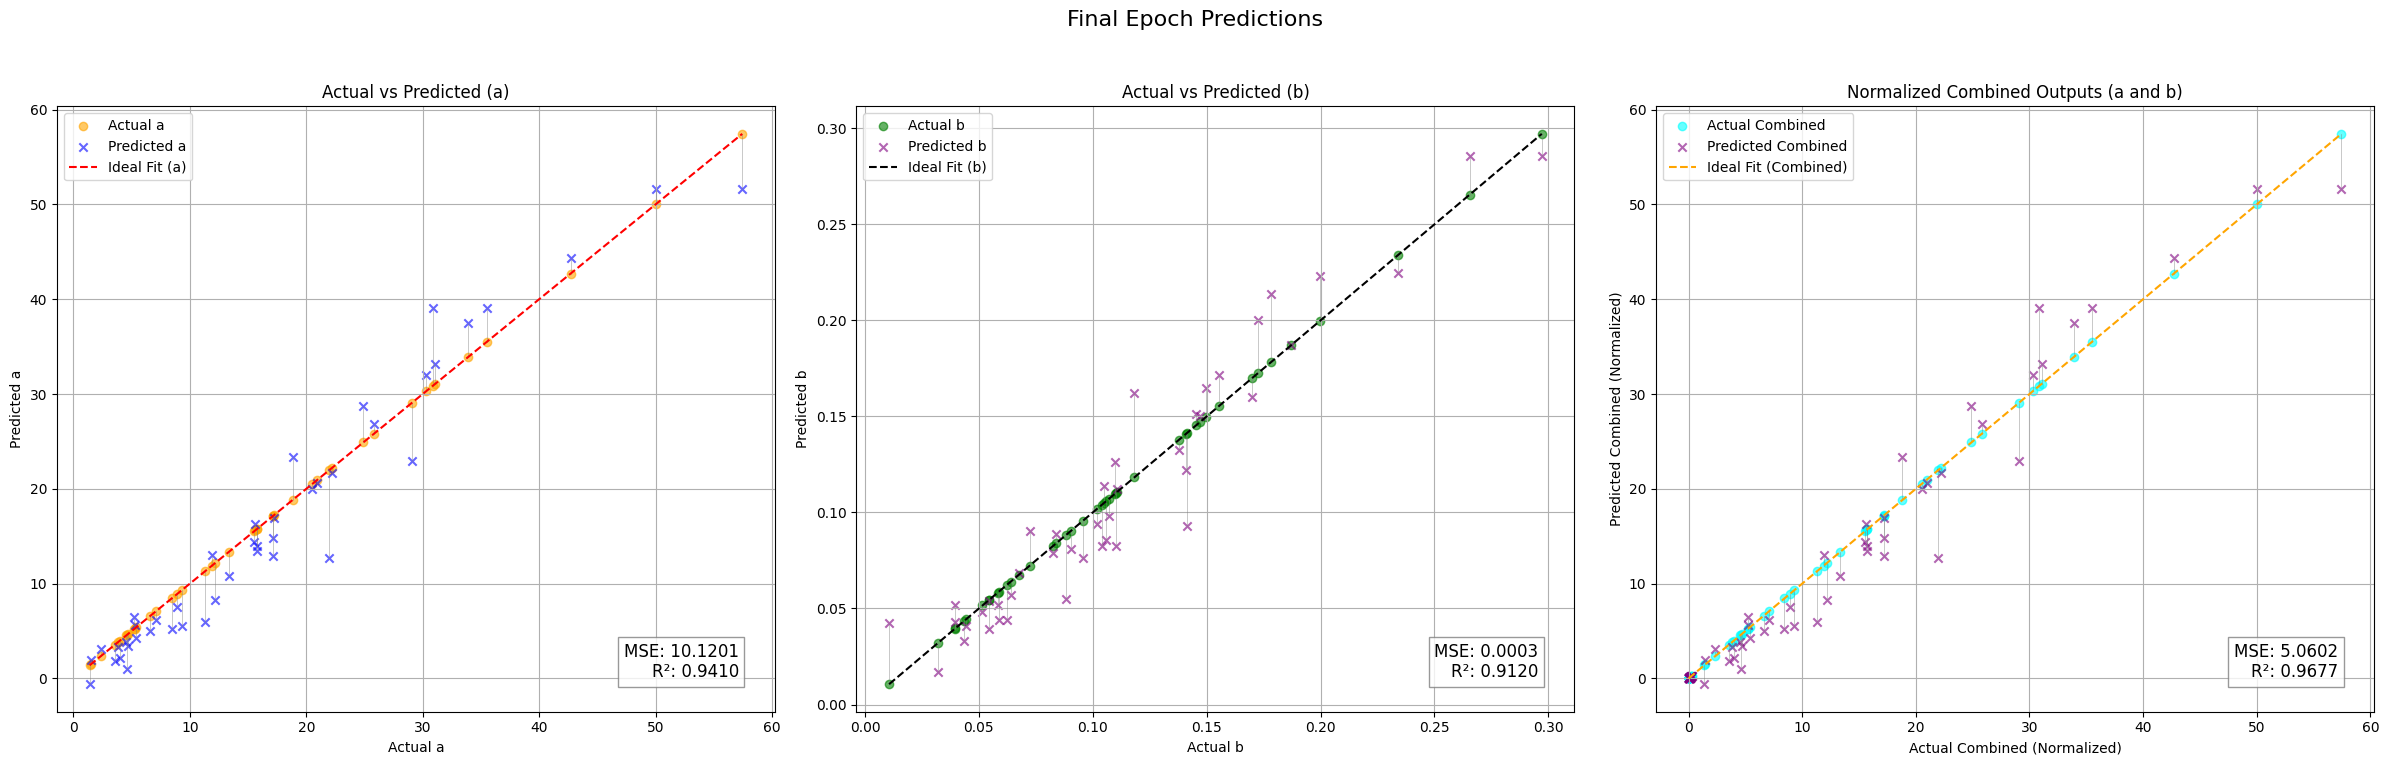

Fold 3/5
Epoch [1/50], Train Loss: 0.1040, Val Loss: 14.9811
Current Dropout Rate: 0.5000
Epoch [2/50], Train Loss: 0.1001, Val Loss: 15.3200
Current Dropout Rate: 0.4920
Epoch [3/50], Train Loss: 0.1022, Val Loss: 15.3935
Current Dropout Rate: 0.4840
Epoch [4/50], Train Loss: 0.0887, Val Loss: 15.4543
Current Dropout Rate: 0.4760
Epoch [5/50], Train Loss: 0.0809, Val Loss: 15.6371
Current Dropout Rate: 0.4680
Epoch [6/50], Train Loss: 0.0827, Val Loss: 15.8785
Current Dropout Rate: 0.4600
Epoch [7/50], Train Loss: 0.0868, Val Loss: 15.9507
Current Dropout Rate: 0.4520
Epoch [8/50], Train Loss: 0.0897, Val Loss: 16.1514
Current Dropout Rate: 0.4440
Epoch [9/50], Train Loss: 0.0791, Val Loss: 16.4337
Current Dropout Rate: 0.4360
Epoch [10/50], Train Loss: 0.0795, Val Loss: 16.4060
Current Dropout Rate: 0.4280
Epoch [11/50], Train Loss: 0.0865, Val Loss: 16.3749
Current Dropout Rate: 0.4200
Early stopping triggered!


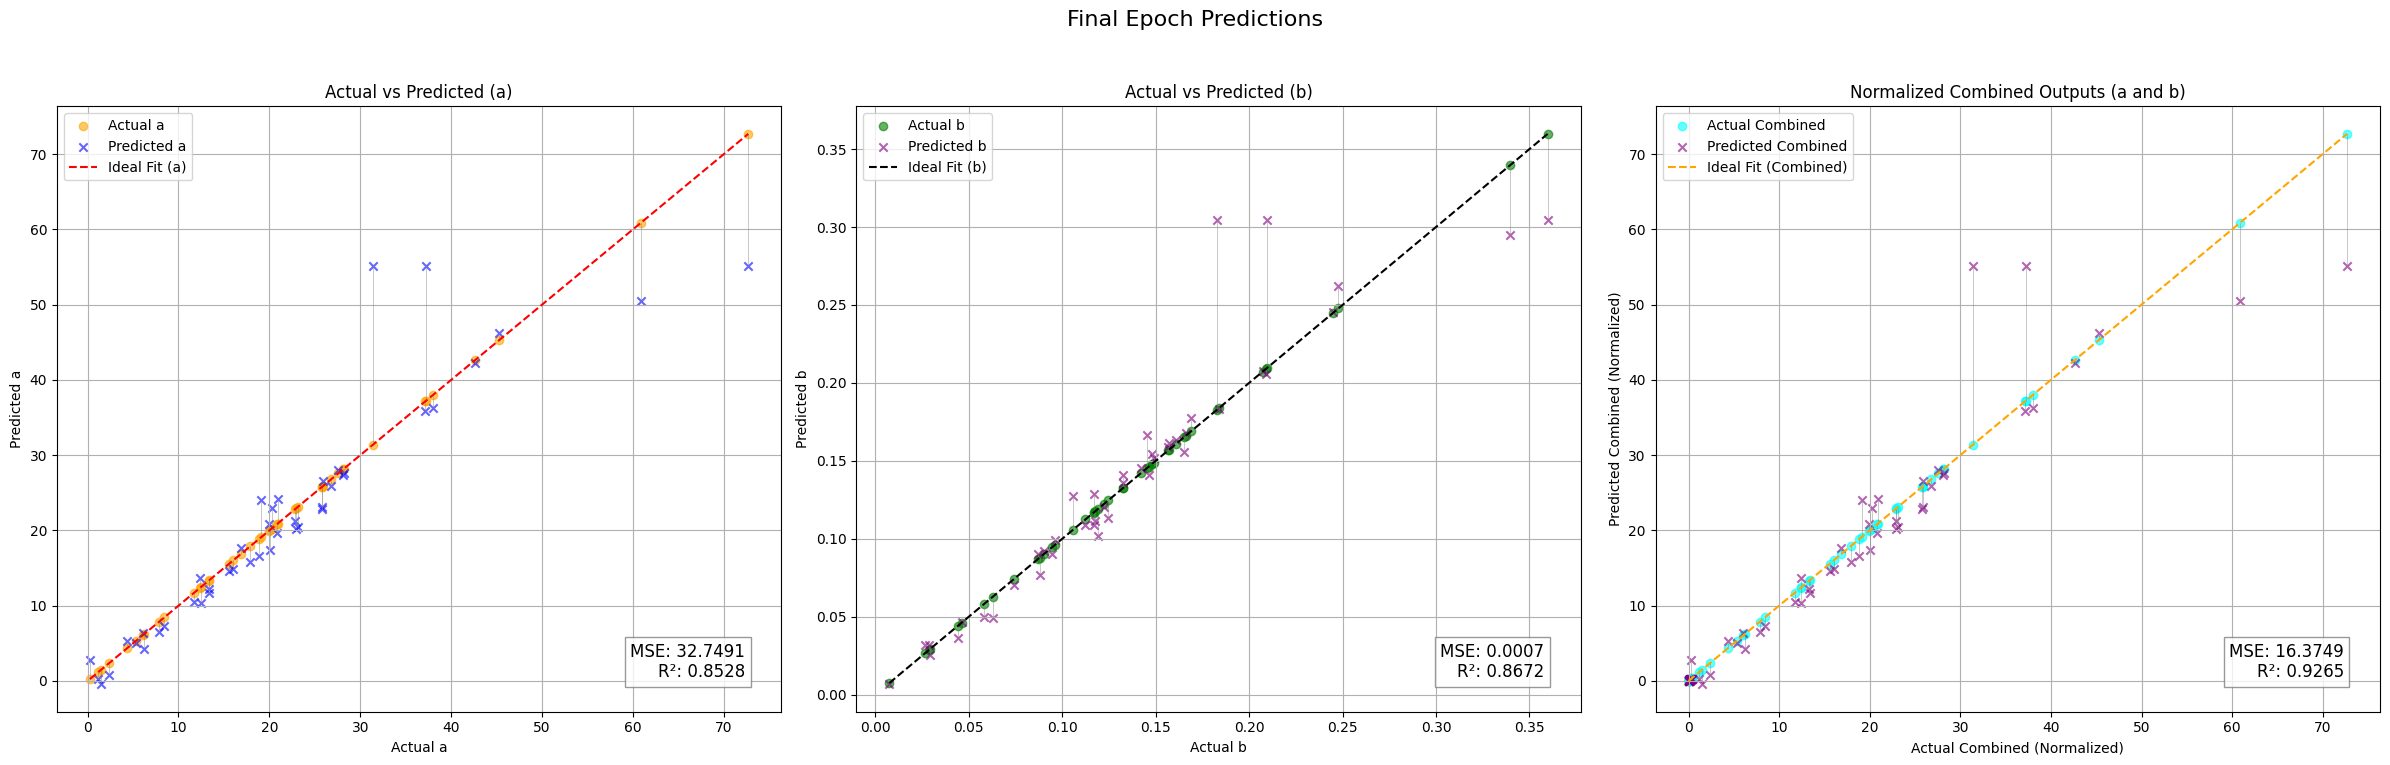

Fold 4/5
Epoch [1/50], Train Loss: 0.0777, Val Loss: 19.3876
Current Dropout Rate: 0.5000
Epoch [2/50], Train Loss: 0.0761, Val Loss: 19.3826
Current Dropout Rate: 0.4920
Epoch [3/50], Train Loss: 0.0730, Val Loss: 19.5940
Current Dropout Rate: 0.4840
Epoch [4/50], Train Loss: 0.0733, Val Loss: 19.5901
Current Dropout Rate: 0.4760
Epoch [5/50], Train Loss: 0.0668, Val Loss: 20.2091
Current Dropout Rate: 0.4680
Epoch [6/50], Train Loss: 0.0641, Val Loss: 20.4849
Current Dropout Rate: 0.4600
Epoch [7/50], Train Loss: 0.0711, Val Loss: 21.0723
Current Dropout Rate: 0.4520
Epoch [8/50], Train Loss: 0.0644, Val Loss: 21.4856
Current Dropout Rate: 0.4440
Epoch [9/50], Train Loss: 0.0759, Val Loss: 21.6002
Current Dropout Rate: 0.4360
Epoch [10/50], Train Loss: 0.0645, Val Loss: 21.6963
Current Dropout Rate: 0.4280
Epoch [11/50], Train Loss: 0.0685, Val Loss: 21.8613
Current Dropout Rate: 0.4200
Epoch [12/50], Train Loss: 0.0688, Val Loss: 22.1597
Current Dropout Rate: 0.4120
Early stopping t

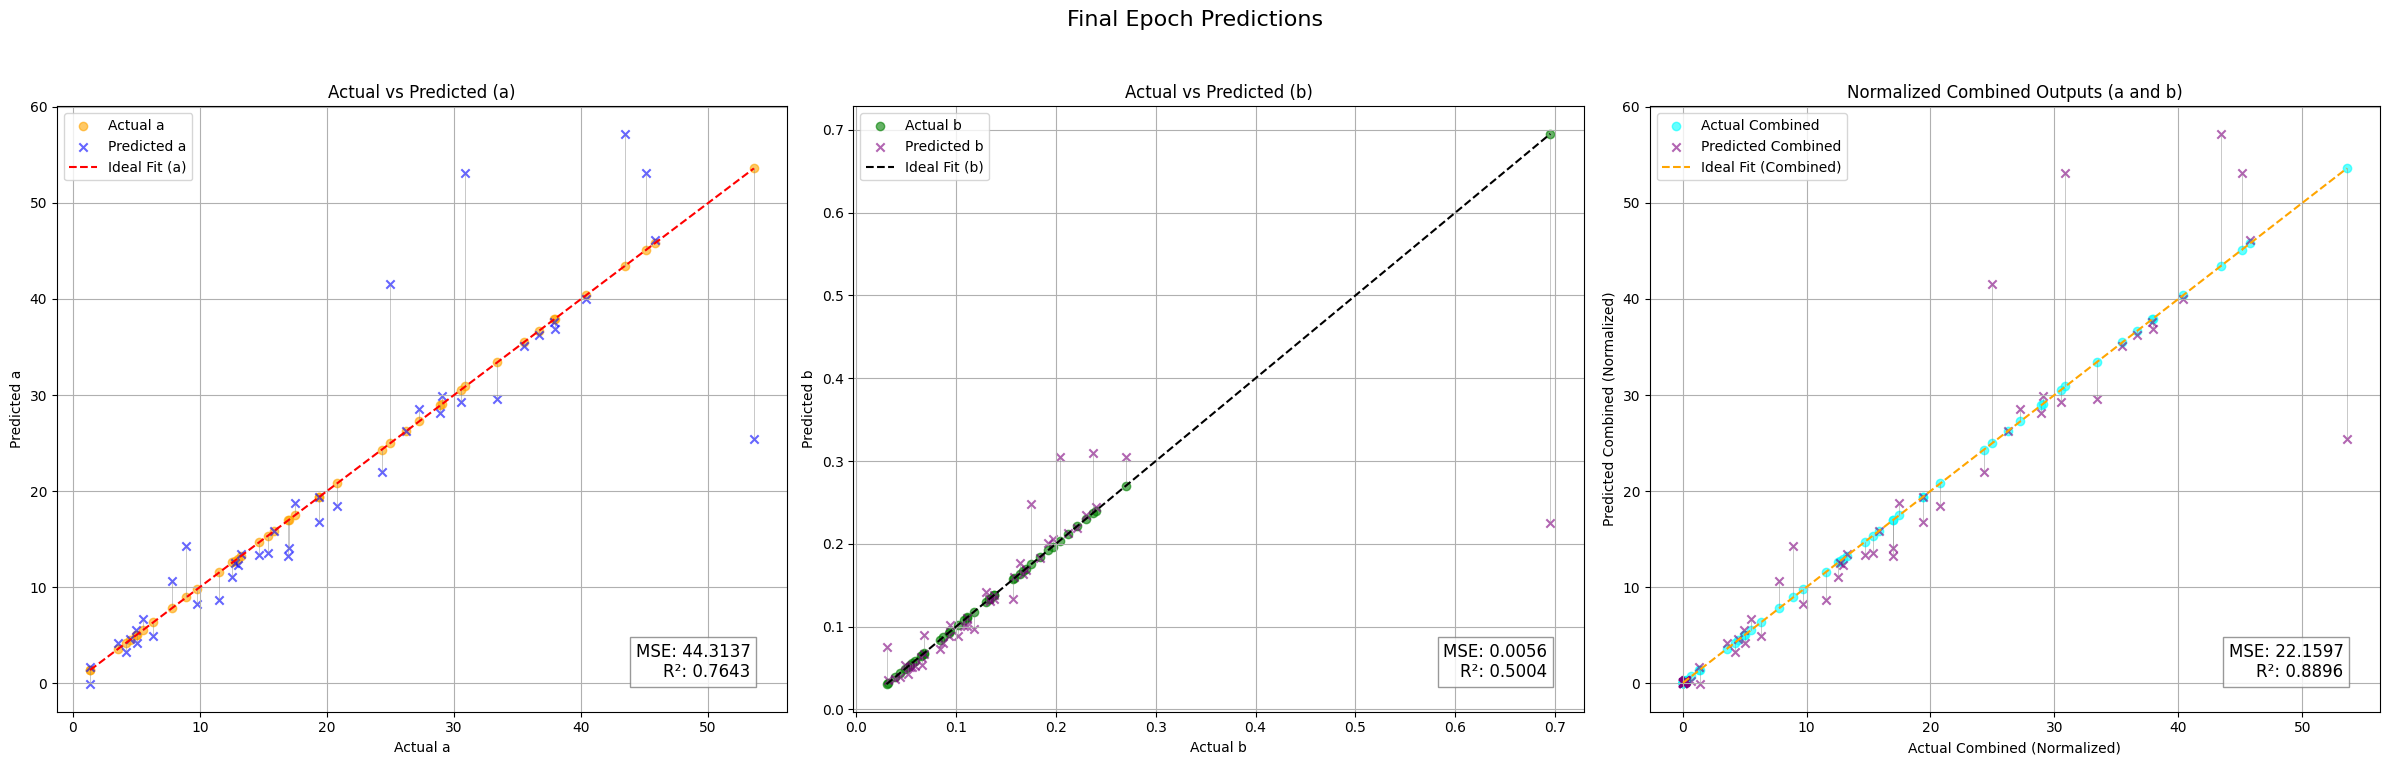

Fold 5/5
Epoch [1/50], Train Loss: 0.0912, Val Loss: 33.9805
Current Dropout Rate: 0.5000
Epoch [2/50], Train Loss: 0.0949, Val Loss: 35.0260
Current Dropout Rate: 0.4920
Epoch [3/50], Train Loss: 0.0661, Val Loss: 34.5320
Current Dropout Rate: 0.4840
Epoch [4/50], Train Loss: 0.0833, Val Loss: 35.0685
Current Dropout Rate: 0.4760
Epoch [5/50], Train Loss: 0.0810, Val Loss: 35.3320
Current Dropout Rate: 0.4680
Epoch [6/50], Train Loss: 0.0681, Val Loss: 35.0845
Current Dropout Rate: 0.4600
Epoch [7/50], Train Loss: 0.0713, Val Loss: 35.6478
Current Dropout Rate: 0.4520
Epoch [8/50], Train Loss: 0.0844, Val Loss: 35.3977
Current Dropout Rate: 0.4440
Epoch [9/50], Train Loss: 0.0748, Val Loss: 35.6787
Current Dropout Rate: 0.4360
Epoch [10/50], Train Loss: 0.0662, Val Loss: 34.7565
Current Dropout Rate: 0.4280
Epoch [11/50], Train Loss: 0.0741, Val Loss: 34.8242
Current Dropout Rate: 0.4200
Early stopping triggered!


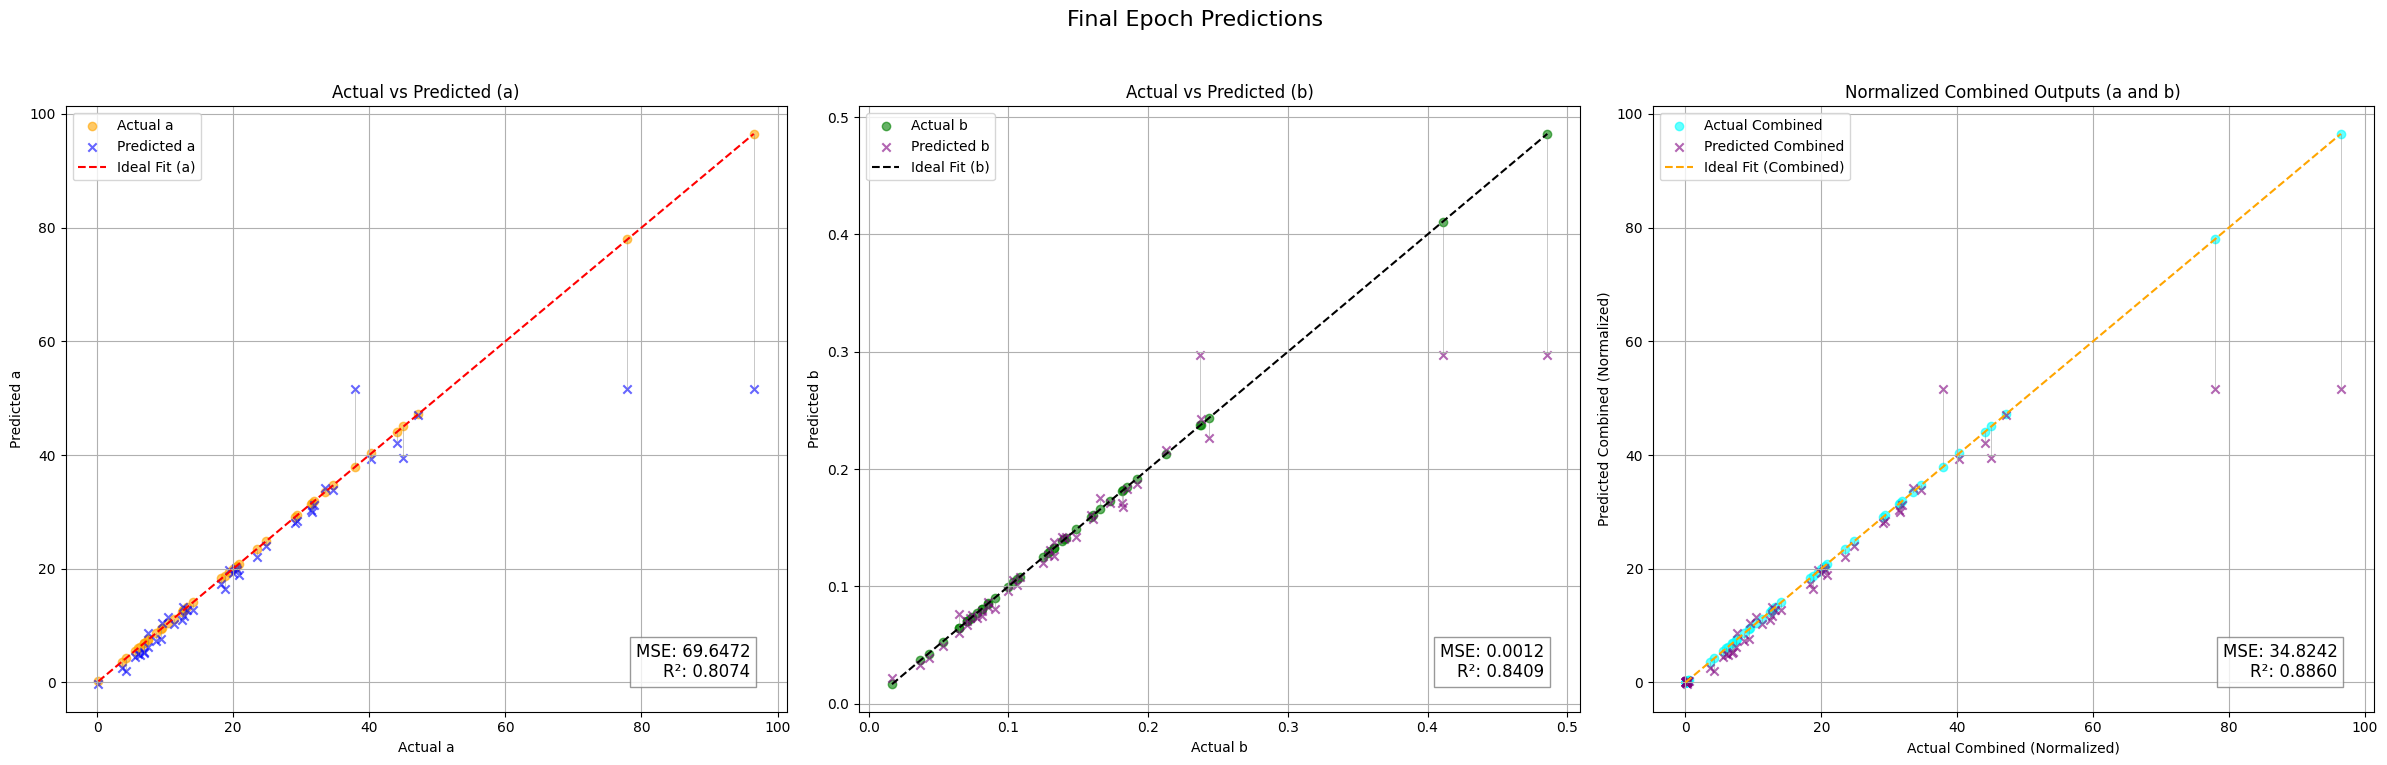

Avg Validation Loss: 34.2448, Avg R2: 0.7547
Training regression model: lr...
Training regression model: rf...
Training regression model: xgb...
Combining predictions...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (44x10 and 2048x128)

In [54]:
# Assume the DataPreprocessor class and its method `load_embeddings_and_targets` are already defined
# Replace `url` and `drive_path` with your actual data location or paths.
preprocessor = DataPreprocessor(url, drive_path)
data = preprocessor.data

# Generate embeddings and targets (if not already done)
embeddings, targets = preprocessor.load_embeddings_and_targets()

# Initialize embedding model and regression models
embedding_model = MolecularPredictorPipeline(embeddings, targets)
regression_models = {
    "lr": LinearRegression(),
    "rf": RandomForestRegressor(),
    "xgb": xgb.XGBRegressor(objective="reg:squarederror"),
}

# Create and run the combined pipeline
pipeline = CombinedPipeline(embedding_model, regression_models, data)
pipeline.run_pipeline(combination_method="weighted", weights=[0.5, 0.25, 0.25])